In [1]:
!pip install pytorch-tabnet
!git clone https://github.com/alezakuskin/Stark_ML
!cd /usr/local/lib/python3.7/dist-packages/pytorch_tabnet && patch </content/Stark_ML/float64.patch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'Stark_ML'...
remote: Enumerating objects: 738, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 738 (delta 147), reused 149 (delta 89), pack-reused 524
Receiving objects: 100% (738/738), 30.35 MiB | 5.50 MiB/s, done.
Resolving deltas: 100% (436/436), done.
patching file abstract_model.py
patching file multitask.py
patching file pretraining.py
patching file tab_model.py
patching file tab_network.py
patching file utils.py


In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!pip install optuna

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib
import json
import torch
#torch.autograd.set_detect_anomaly(False)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn import svm
from google.colab import output

from pytorch_tabnet.tab_model import  TabNetRegressor
np.random.seed(777)

output.clear()

In [15]:
if os.path.isdir('Stark_ML'):
    !rm -rf Stark_ML

!git clone https://github.com/alezakuskin/Stark_ML

import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet


importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)


from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
output.clear()

# Data preprocessing

In [4]:
data = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BC'
                   )
data['Term'] = term_to_number(data['Term'])
data['Term.1'] = term_to_number(data['Term.1'])

In [5]:
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

#Separating into data for width and shift prediction
data_width = data[np.isnan(data['w (A)']) == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])

#Creating data, target and labels for shift prediction
data_shift = data[np.isnan(data['d (A)']) == False]
data_shift_elements = data_shift.loc[data_shift['Element'].isin(elements_to_exclude)]
data_shift = data_shift.drop(data_shift_elements.index)
data_shift = data_shift.sort_values(by=['Z number'])
target_shift = data_shift['d (A)']
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])
target_shift_elements = data_shift_elements['w (A)']
label_shift_elements = data_shift_elements.loc[:, ['Element', 'Wavelength']]


#Selecting items for predicting both parameters simultaneously
data_both = data[(np.isnan(data['w (A)']) == False) & (np.isnan(data['d (A)']) == False)]
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
label_both = data_both.loc[:, ['Element', 'Wavelength']]
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])

print(f'Number of items with width: {data_width.shape[0]}')
print(f'Number of items with shift: {data_shift.shape[0]}')
print(f'Number of items with both parameters: {data_both.shape[0]}')
print()
print(f'Size of elements-exclusive test set: {data_width_elements.shape[0]}')

Number of items with width: 897
Number of items with shift: 331
Number of items with both parameters: 299

Size of elements-exclusive test set: 34


## Data visual description

In [25]:
data_width.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,...,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,8.970000e+02,897.000000
mean,437.237659,14.851728,1.769231,1.612040,3.460424,0.858417,1.943144,2.469342,0.332219,0.749164,...,0.001115,0.002230,0.001115,0.001115,2.899666,1.544036,0.603122,1.827202,2.113072e+05,16462.332219
std,216.218894,15.978406,0.421560,0.737235,2.179154,0.905723,2.720643,3.995171,0.687093,1.679233,...,0.033389,0.047193,0.033389,0.033389,1.247752,1.312079,0.489523,1.432334,3.325359e+06,9439.627870
min,113.416500,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.173231e+04,2950.000000
25%,283.999000,6.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.387426e+04,10970.000000
50%,471.315614,7.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.500000,8.848342e+04,12500.000000
75%,541.520000,26.000000,2.000000,2.000000,6.000000,2.000000,6.000000,7.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,2.000000,1.184278e+05,20800.000000
max,2058.130000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,1.000000,7.000000,9.968131e+07,50000.000000


In [26]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    897.000000
mean       4.564198
std       12.780995
min        0.001500
25%        0.204444
50%        1.451247
75%        4.016393
max      180.500000
Name: w (A), dtype: float64


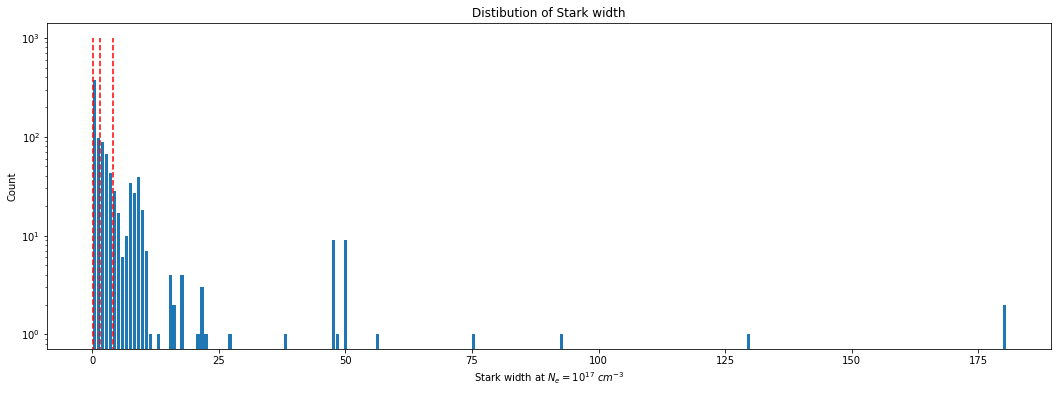

In [27]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

## Train - Test split

In [28]:
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

print(target_test_q4[target_test_q4 > 70])

581    130.0
585    180.5
580     75.5
Name: w (A), dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


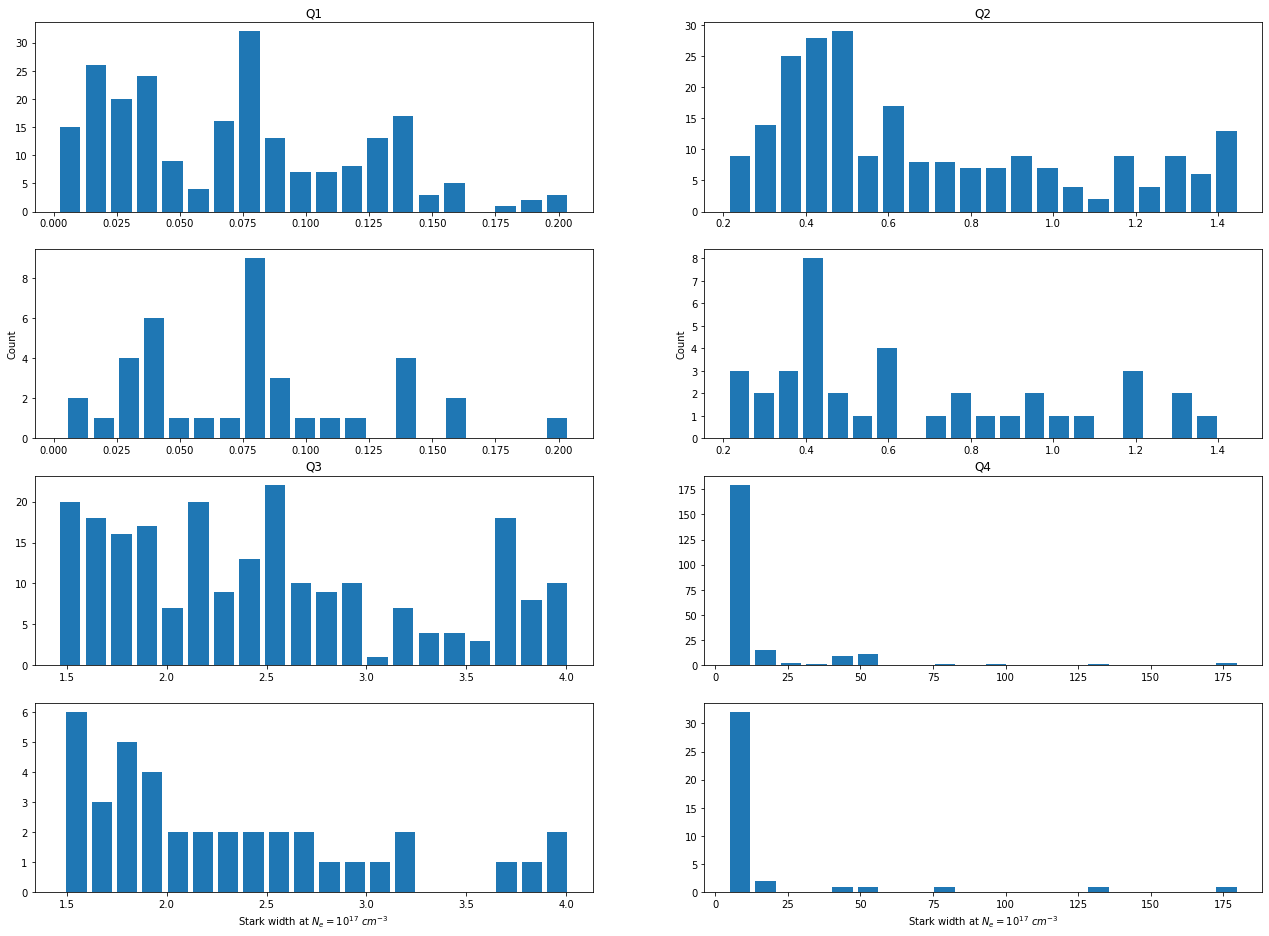

In [29]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

In [30]:
#Creating full train and test datasets
data_width_test, target_width_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_width_test, target_width_test = data_width_test.append(data_test_q3), target_width_test.append(target_test_q3)
data_width_test, target_width_test = data_width_test.append(data_test_q4), target_width_test.append(target_test_q4)

data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

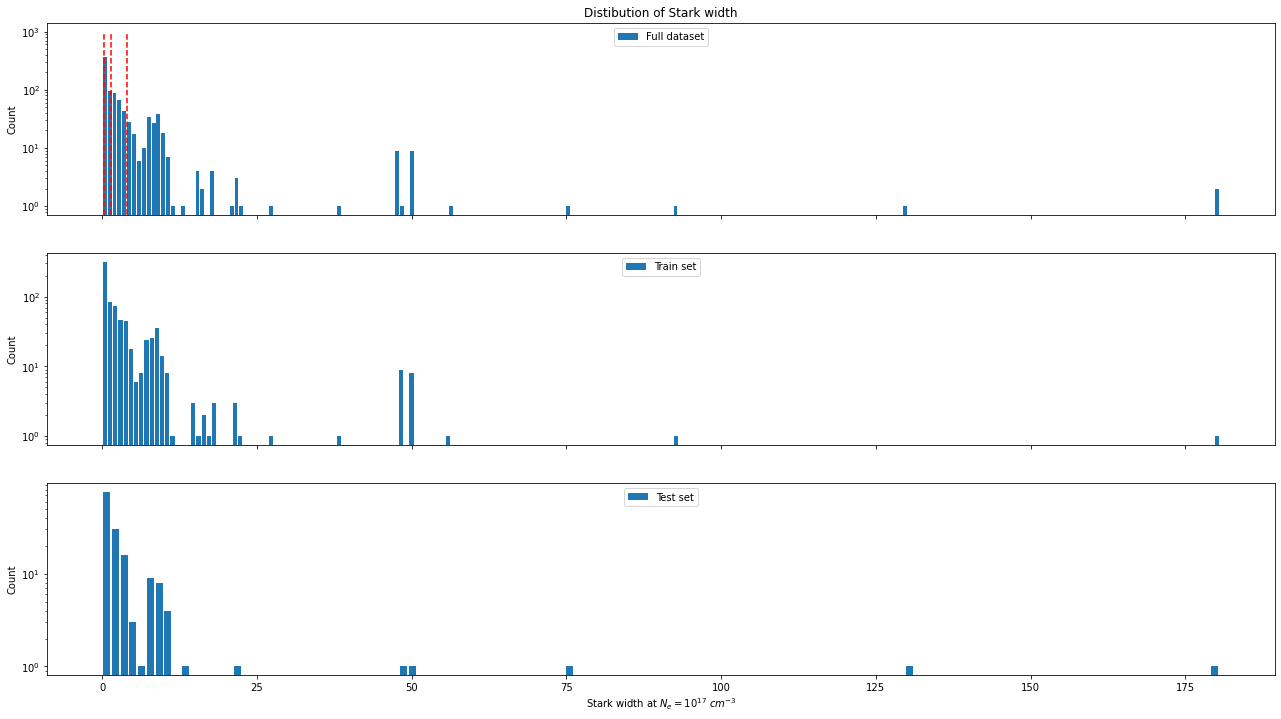

In [31]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

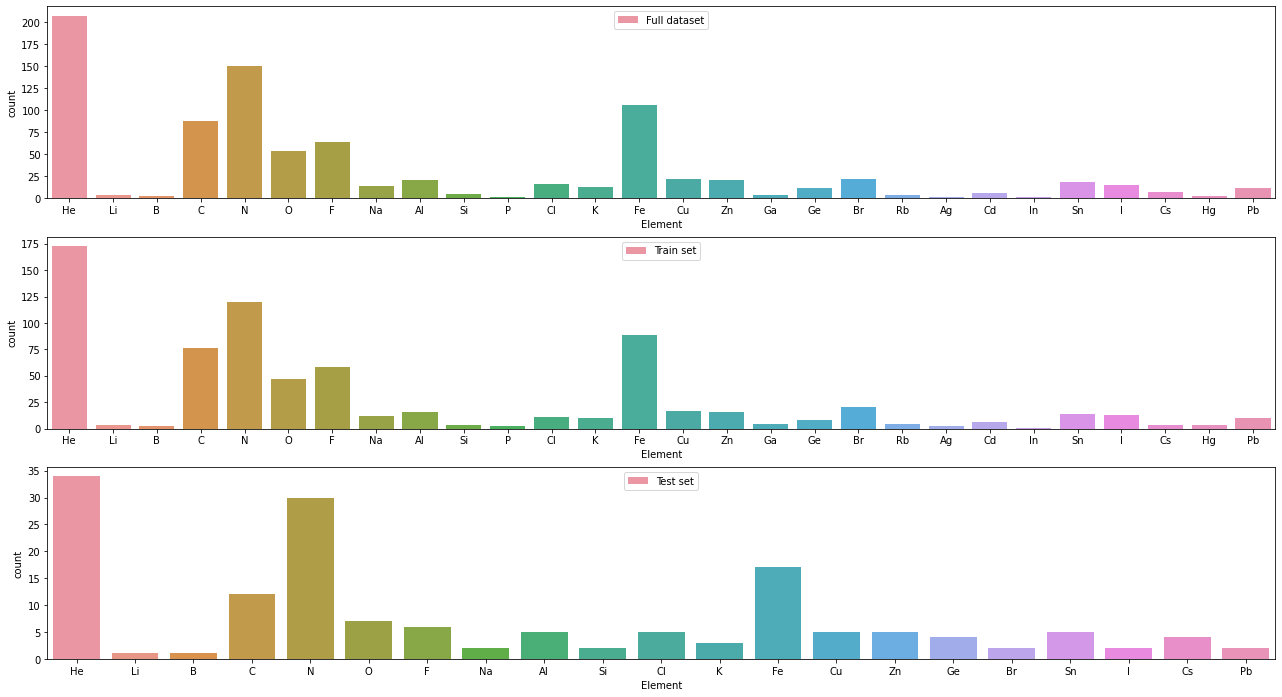

In [32]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

In [33]:
#Assigning proper variables
XW_train, YW_train = data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train
XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test

print(XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)

XW_train = XW_train.sample(frac = 1, random_state = 777)
YW_train = YW_train.sample(frac = 1, random_state = 777)

print('\n', XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)
#XS_train, XS_test, YS_train, YS_test = train_test_split(data_shift, target_shift, test_size = 0.2, random_state = 7)
#XB_train, XB_test, YB_train, YB_test = train_test_split(data_both, target_both, test_size = 0.2, random_state = 7)

(743, 50) (743,)
(154, 50) (154,)

 (743, 50) (743,)
(154, 50) (154,)


In [34]:
XW_elem = data_width_elements.drop(columns=['Element', 'Wavelength', 'Z number'])
YW_elem = target_width_elements
LW_elem = label_width_elements

## Shift data preprocessing

In [6]:
data_shift.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.0,331.0,331.0,331.000000,331.000000,331.000000,331.000000,3.310000e+02,331.000000
mean,479.888947,14.045317,1.740181,1.531722,3.308157,0.737160,1.435045,1.797583,0.314199,0.749245,...,0.003021,0.0,0.0,0.0,2.764350,1.187311,0.555891,1.480363,4.027146e+05,17826.404834
std,192.056662,17.933067,0.439199,0.802301,2.162047,0.853039,2.371135,3.775294,0.694837,1.845705,...,0.054965,0.0,0.0,0.0,1.114123,0.864075,0.497619,0.999428,5.473695e+06,9920.444183
min,119.955000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.173231e+04,3800.000000
25%,391.633000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,2.000000,1.000000,0.000000,1.000000,5.375643e+04,11000.000000
50%,501.568000,8.000000,2.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,3.000000,1.000000,1.000000,1.500000,9.966391e+04,15000.000000
75%,589.200750,13.000000,2.000000,2.000000,6.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,3.000000,2.000000,1.000000,2.000000,1.832368e+05,22700.000000
max,852.112000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,0.0,0.0,0.0,7.000000,5.000000,1.000000,7.000000,9.968131e+07,49000.000000


count    331.000000
mean       2.034925
std        3.704571
min       -7.485437
25%        0.037200
50%        0.290000
75%        2.881356
max       20.000000
Name: d (A), dtype: float64


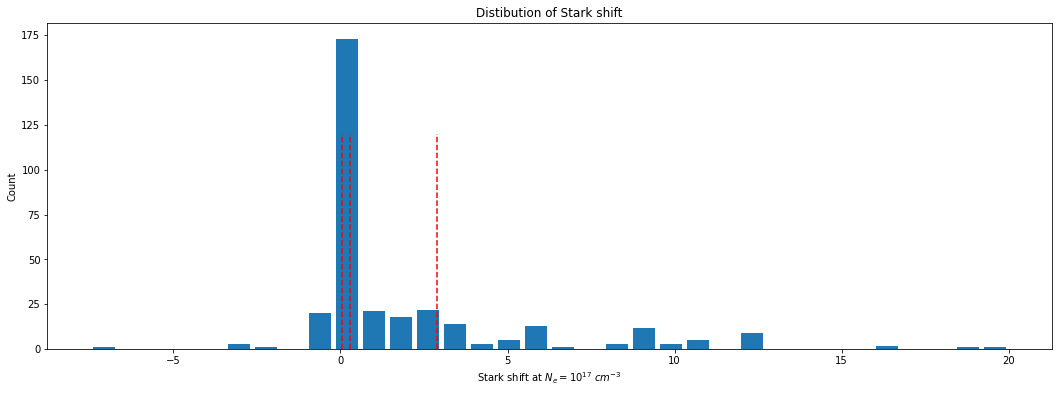

In [7]:
data_shift_stats = target_shift.describe()
print(data_shift_stats)

fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_shift, bins='auto', log=False, rwidth = 0.8)
ax.vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
ax.vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
ax.vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')

ax.set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('Shift distribution.png', dpi = 300)

In [8]:
#Q1
data_test_q1, target_test_q1 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 17.5]) < 1 or len(target_test_q4[(target_test_q4 > 11.5) & (target_test_q4 < 17.5)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_shift,
                                                target_shift,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


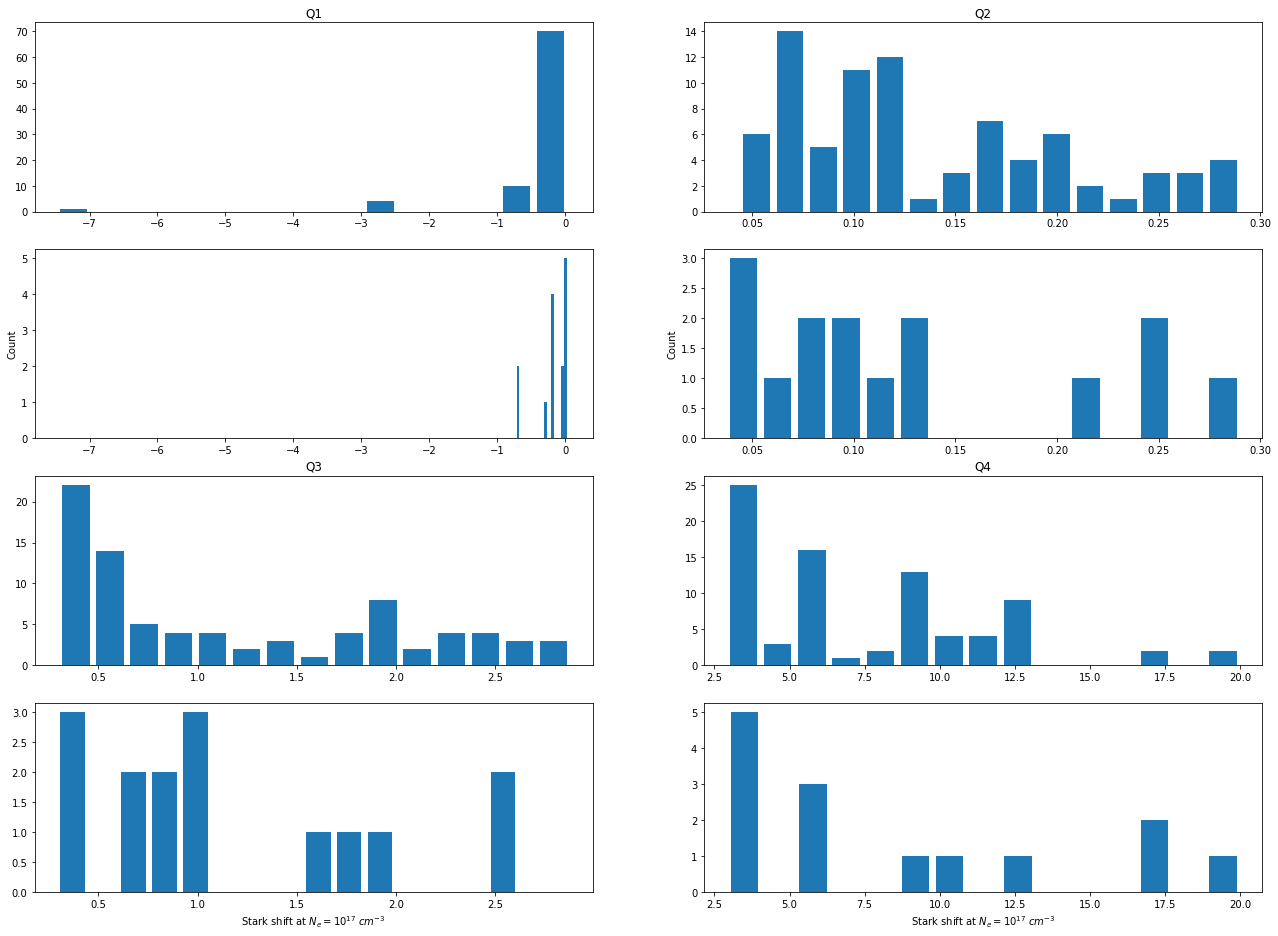

In [9]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_shift[target_shift <= data_shift_stats['25%']], bins=15, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 15, rwidth = 0.8)

axs[0, 1].hist(target_shift[(target_shift > data_shift_stats['25%']) & (target_shift <= data_shift_stats['50%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 15, rwidth = 0.8)

axs[2, 0].hist(target_shift[(target_shift > data_shift_stats['50%']) & (target_shift <= data_shift_stats['75%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 15, rwidth = 0.8)

axs[2, 1].hist(target_shift[target_shift > data_shift_stats['75%']],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 15, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

In [10]:
#Creating full train and test datasets
data_shift_test, target_shift_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_shift_test, target_shift_test = data_shift_test.append(data_test_q3), target_shift_test.append(target_test_q3)
data_shift_test, target_shift_test = data_shift_test.append(data_test_q4), target_shift_test.append(target_test_q4)

data_shift_train, target_shift_train = data_shift.drop(data_shift_test.index), target_shift.drop(target_shift_test.index)

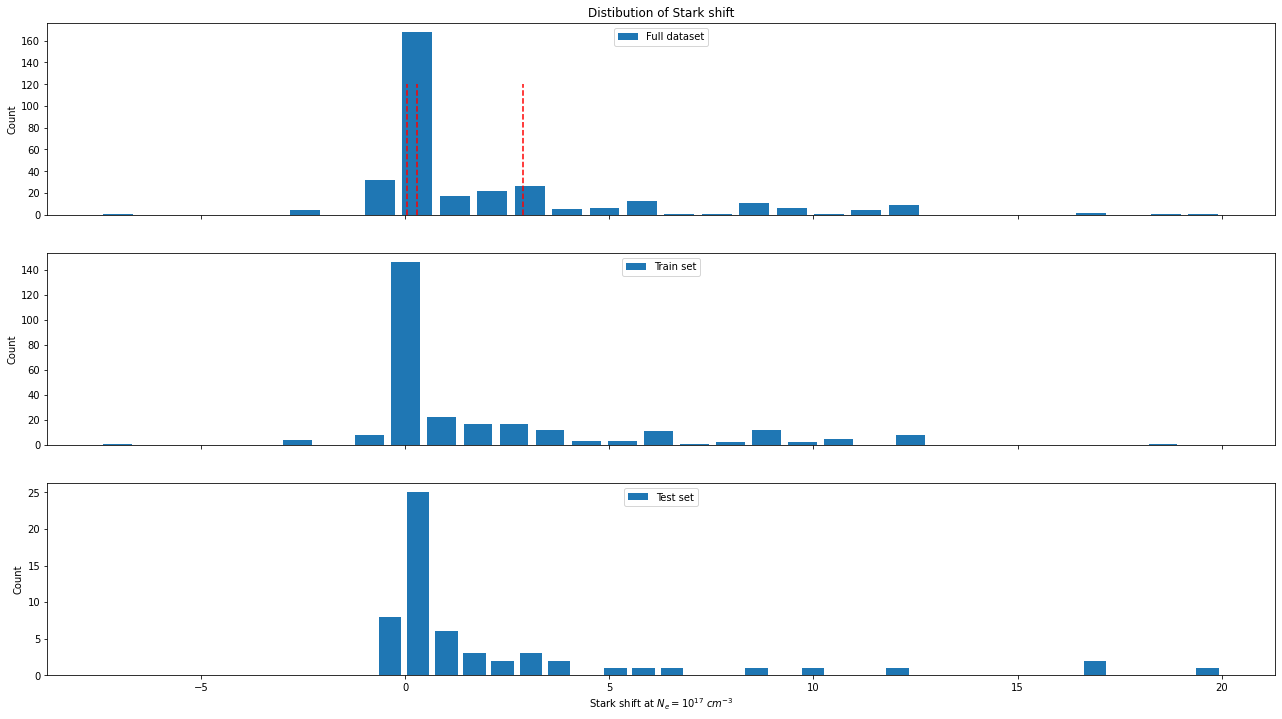

In [11]:
test_shift_stats = target_shift_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_shift, bins=30, log=False, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_shift_train, bins = 30, log = False, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_shift_test, bins = 30, log = False, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')
'''axs[1].vlines(x = test_shift_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('shift distribution.png', dpi = 300)

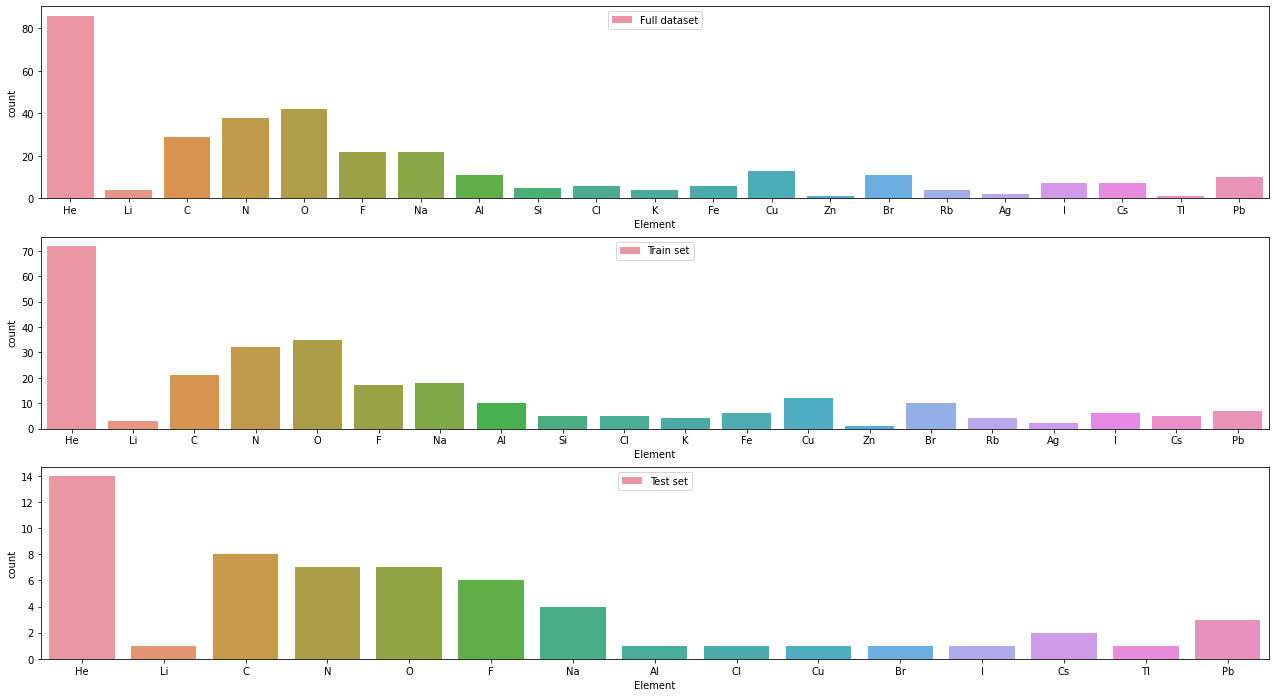

In [12]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_shift, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_shift_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_shift_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

In [13]:
#Assigning proper variables
XS_train, YS_train = data_shift_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_train
XS_test, YS_test = data_shift_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_test

print(XS_train.shape, YS_train.shape)
print(XS_test.shape, YS_test.shape)

XS_train = XS_train.sample(frac = 1, random_state = 777)
YS_train = YS_train.sample(frac = 1, random_state = 777)

print('\n', XS_train.shape, YS_train.shape)
print(XS_test.shape, YS_test.shape)

(275, 50) (275,)
(58, 50) (58,)

 (275, 50) (275,)
(58, 50) (58,)


In [20]:
XS_elem = data_shift_elements.drop(columns=['Element', 'Wavelength', 'Z number', 'd (A)', 'w (A)'])
YS_elem = target_shift_elements
LS_elem = label_shift_elements

#Models optimization

In [ ]:
#@title Max width value
#@markdown You can enter any reasonable value less than 180 Angstrom.
width_threshold =  200#@param {type:"number"}

In [ ]:
XW_train = XW_train.loc[YW_train.loc[YW_train < width_threshold].index]
YW_train = YW_train.loc[YW_train < width_threshold]
XW_test = XW_test.loc[YW_test.loc[YW_test < width_threshold].index]
YW_test = YW_test.loc[YW_test < width_threshold]
XW_elem = XW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]
YW_elem = YW_elem.loc[YW_elem < width_threshold]
LW_elem = LW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]

## KNN

In [ ]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : ['distance', 'uniform'],
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = KNN

KNN_res = main(X = XS_train, y = YS_train, model_name = model_name, params = KNN_params, n_trials = 500)

'''with open(f'KNN_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)
'''
with open(f'KNN_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(KNN_res.best_params, fp)

[I 2022-05-13 11:00:42,942] A new study created in memory with name: no-name-880c2a57-165e-42d5-8c54-0800417cf705


Start hyperparameter optimization
{'n_neighbors': 46, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.4757060357420744}{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 86, 'p': 1.275673133334954}



/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")
[I 2022-05-13 11:00:43,599] Trial 0 finished with value: 3.4950664254000423 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.4757060357420744}. Best is trial 0 with value: 3.4950664254000423.
[I 2022-05-13 11:00:43,644] Trial 1 finished with value: 1.2550758219148195 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 86, 'p': 1.275673133334954}. Best is trial 1 with value: 1.2550758219148195.


{'n_neighbors': 26, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.5893058651654886}
{'n_neighbors': 72, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.281599752372552}


[I 2022-05-13 11:00:44,208] Trial 2 finished with value: 3.1779068169727154 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.5893058651654886}. Best is trial 1 with value: 1.2550758219148195.
[I 2022-05-13 11:00:44,286] Trial 3 finished with value: 3.519009943408739 and parameters: {'n_neighbors': 72, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.281599752372552}. Best is trial 1 with value: 1.2550758219148195.


{'n_neighbors': 127, 'weights': 'distance', 'leaf_size': 20, 'p': 1.4094815577486899}
{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0206447210478906}


[I 2022-05-13 11:00:44,817] Trial 4 finished with value: 1.3931995712811098 and parameters: {'n_neighbors': 127, 'weights': 'distance', 'leaf_size': 20, 'p': 1.4094815577486899}. Best is trial 1 with value: 1.2550758219148195.
[I 2022-05-13 11:00:44,893] Trial 5 finished with value: 1.3294527366699378 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0206447210478906}. Best is trial 1 with value: 1.2550758219148195.


{'n_neighbors': 76, 'weights': 'distance', 'leaf_size': 57, 'p': 1.0003407558550883}
{'n_neighbors': 89, 'weights': 'distance', 'leaf_size': 75, 'p': 1.5051308945592798}


[I 2022-05-13 11:00:45,420] Trial 6 finished with value: 1.306520171981843 and parameters: {'n_neighbors': 76, 'weights': 'distance', 'leaf_size': 57, 'p': 1.0003407558550883}. Best is trial 1 with value: 1.2550758219148195.
[I 2022-05-13 11:00:45,471] Trial 7 finished with value: 1.3790130234791578 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'leaf_size': 75, 'p': 1.5051308945592798}. Best is trial 1 with value: 1.2550758219148195.


{'n_neighbors': 21, 'weights': 'distance', 'leaf_size': 99, 'p': 1.1295445202596917}
{'n_neighbors': 144, 'weights': 'distance', 'leaf_size': 92, 'p': 1.2566001441456451}


[I 2022-05-13 11:00:45,997] Trial 8 finished with value: 1.2409920133455052 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'leaf_size': 99, 'p': 1.1295445202596917}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:46,052] Trial 9 finished with value: 1.3937865151141926 and parameters: {'n_neighbors': 144, 'weights': 'distance', 'leaf_size': 92, 'p': 1.2566001441456451}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 50, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0959151915333067}
{'n_neighbors': 46, 'weights': 'uniform', 'leaf_size': 5, 'p': 1.9087597600524282}


[I 2022-05-13 11:00:46,598] Trial 10 finished with value: 1.3032898206118524 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0959151915333067}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:46,656] Trial 11 finished with value: 3.501365444841981 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'leaf_size': 5, 'p': 1.9087597600524282}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 39, 'p': 1.9838367165886888}
{'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 44, 'p': 1.2215005322731125}


[I 2022-05-13 11:00:47,149] Trial 12 finished with value: 1.345999715189467 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 39, 'p': 1.9838367165886888}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:47,215] Trial 13 finished with value: 1.2692183891244333 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 44, 'p': 1.2215005322731125}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 97, 'p': 1.2378938585631214}
{'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 98, 'p': 1.7327658797099987}


[I 2022-05-13 11:00:47,708] Trial 14 finished with value: 1.2581216439417373 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 97, 'p': 1.2378938585631214}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:47,769] Trial 15 finished with value: 1.3047932335095997 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 98, 'p': 1.7327658797099987}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 106, 'weights': 'distance', 'leaf_size': 67, 'p': 1.7126891833724647}
{'n_neighbors': 109, 'weights': 'distance', 'leaf_size': 69, 'p': 1.146667845840241}


[I 2022-05-13 11:00:48,273] Trial 16 finished with value: 1.407555181721948 and parameters: {'n_neighbors': 106, 'weights': 'distance', 'leaf_size': 67, 'p': 1.7126891833724647}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:48,329] Trial 17 finished with value: 1.34270790483564 and parameters: {'n_neighbors': 109, 'weights': 'distance', 'leaf_size': 69, 'p': 1.146667845840241}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 62, 'weights': 'distance', 'leaf_size': 30, 'p': 1.139789388066935}
{'n_neighbors': 61, 'weights': 'uniform', 'leaf_size': 32, 'p': 1.3707722982789938}


[I 2022-05-13 11:00:48,828] Trial 18 finished with value: 1.311773342539706 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'leaf_size': 30, 'p': 1.139789388066935}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:48,886] Trial 19 finished with value: 3.544084581949619 and parameters: {'n_neighbors': 61, 'weights': 'uniform', 'leaf_size': 32, 'p': 1.3707722982789938}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 60, 'p': 1.3480638958375375}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.3179692174228799}


[I 2022-05-13 11:00:49,384] Trial 20 finished with value: 1.8026939724298015 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 60, 'p': 1.3480638958375375}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:49,440] Trial 21 finished with value: 1.2980642483482785 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.3179692174228799}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 32, 'weights': 'distance', 'leaf_size': 99, 'p': 1.224308648213889}
{'n_neighbors': 34, 'weights': 'distance', 'leaf_size': 97, 'p': 1.2120149968155232}


[I 2022-05-13 11:00:49,941] Trial 22 finished with value: 1.2992234420008009 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'leaf_size': 99, 'p': 1.224308648213889}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:49,997] Trial 23 finished with value: 1.3016827099893038 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'leaf_size': 97, 'p': 1.2120149968155232}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 18, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1343873108269449}
{'n_neighbors': 19, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1205375844028556}


[I 2022-05-13 11:00:50,492] Trial 24 finished with value: 1.243564108509729 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1343873108269449}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:50,559] Trial 25 finished with value: 1.2454498906564768 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1205375844028556}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1030314057260748}
{'n_neighbors': 40, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0741142304719655}


[I 2022-05-13 11:00:51,042] Trial 26 finished with value: 1.2341907099039073 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1030314057260748}. Best is trial 26 with value: 1.2341907099039073.
[I 2022-05-13 11:00:51,110] Trial 27 finished with value: 1.2973179261064796 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0741142304719655}. Best is trial 26 with value: 1.2341907099039073.


{'n_neighbors': 39, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0694775381812869}
{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 76, 'p': 1.0460880987305945}


[I 2022-05-13 11:00:51,595] Trial 28 finished with value: 1.2974345708999935 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0694775381812869}. Best is trial 26 with value: 1.2341907099039073.
[I 2022-05-13 11:00:51,671] Trial 29 finished with value: 1.2289730365543103 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 76, 'p': 1.0460880987305945}. Best is trial 29 with value: 1.2289730365543103.


{'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.457949347300198}
{'n_neighbors': 55, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.436513279131227}


[I 2022-05-13 11:00:52,146] Trial 30 finished with value: 2.053695285153274 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.457949347300198}. Best is trial 29 with value: 1.2289730365543103.
[I 2022-05-13 11:00:52,223] Trial 31 finished with value: 3.5459831558908457 and parameters: {'n_neighbors': 55, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.436513279131227}. Best is trial 29 with value: 1.2289730365543103.


{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1589751201413274}
{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 89, 'p': 1.165295442672689}


[I 2022-05-13 11:00:52,698] Trial 32 finished with value: 1.241843374264008 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1589751201413274}. Best is trial 29 with value: 1.2289730365543103.
[I 2022-05-13 11:00:52,780] Trial 33 finished with value: 1.2422598241406924 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 89, 'p': 1.165295442672689}. Best is trial 29 with value: 1.2289730365543103.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0375872809004796}
{'n_neighbors': 31, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0053312936971062}


[I 2022-05-13 11:00:53,252] Trial 34 finished with value: 1.2192438032739634 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0375872809004796}. Best is trial 34 with value: 1.2192438032739634.
[I 2022-05-13 11:00:53,334] Trial 35 finished with value: 1.2861195538412653 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0053312936971062}. Best is trial 34 with value: 1.2192438032739634.


{'n_neighbors': 35, 'weights': 'distance', 'leaf_size': 82, 'p': 1.0520171438749102}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 71, 'p': 1.059064464445527}


[I 2022-05-13 11:00:53,809] Trial 36 finished with value: 1.2909658274855287 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'leaf_size': 82, 'p': 1.0520171438749102}. Best is trial 34 with value: 1.2192438032739634.
[I 2022-05-13 11:00:53,886] Trial 37 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 71, 'p': 1.059064464445527}. Best is trial 37 with value: 0.9661027438815045.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 71, 'p': 1.5425231680696905}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 52, 'p': 1.0479150818725025}


[I 2022-05-13 11:00:54,365] Trial 38 finished with value: 1.2808145292880648 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 71, 'p': 1.5425231680696905}. Best is trial 37 with value: 0.9661027438815045.
[I 2022-05-13 11:00:54,441] Trial 39 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 52, 'p': 1.0479150818725025}. Best is trial 37 with value: 0.9661027438815045.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.0400094042500188}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.036371454049353}


[I 2022-05-13 11:00:54,918] Trial 40 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.0400094042500188}. Best is trial 37 with value: 0.9661027438815045.
[I 2022-05-13 11:00:54,997] Trial 41 finished with value: 1.5631766442098254 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.036371454049353}. Best is trial 37 with value: 0.9661027438815045.


{'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 50, 'p': 1.0406659593175887}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0109993376935962}


[I 2022-05-13 11:00:55,473] Trial 42 finished with value: 1.2033270864408572 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 50, 'p': 1.0406659593175887}. Best is trial 37 with value: 0.9661027438815045.
[I 2022-05-13 11:00:55,549] Trial 43 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0109993376935962}. Best is trial 37 with value: 0.9661027438815045.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.003137107772517}
{'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0130226039642154}


[I 2022-05-13 11:00:56,025] Trial 44 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.003137107772517}. Best is trial 37 with value: 0.9661027438815045.
[I 2022-05-13 11:00:56,100] Trial 45 finished with value: 1.2033270864408572 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0130226039642154}. Best is trial 37 with value: 0.9661027438815045.


{'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.181269777809788}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 43, 'p': 1.1774428222396276}


[I 2022-05-13 11:00:56,578] Trial 46 finished with value: 1.2033283196753626 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.181269777809788}. Best is trial 37 with value: 0.9661027438815045.
[I 2022-05-13 11:00:56,650] Trial 47 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 43, 'p': 1.1774428222396276}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 77, 'weights': 'uniform', 'leaf_size': 40, 'p': 1.2914861532120254}
{'n_neighbors': 21, 'weights': 'uniform', 'leaf_size': 37, 'p': 1.3033004354180535}


[I 2022-05-13 11:00:57,132] Trial 48 finished with value: 3.530314234761364 and parameters: {'n_neighbors': 77, 'weights': 'uniform', 'leaf_size': 40, 'p': 1.2914861532120254}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:00:57,207] Trial 49 finished with value: 2.824212149030244 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'leaf_size': 37, 'p': 1.3033004354180535}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 26, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.0920774635968864}
{'n_neighbors': 143, 'weights': 'uniform', 'leaf_size': 59, 'p': 1.091941969195768}


[I 2022-05-13 11:00:57,701] Trial 50 finished with value: 3.1598119491905323 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.0920774635968864}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:00:57,779] Trial 51 finished with value: 3.6390936057467074 and parameters: {'n_neighbors': 143, 'weights': 'uniform', 'leaf_size': 59, 'p': 1.091941969195768}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 56, 'p': 1.0973279437712176}
{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.0012567010472222}


[I 2022-05-13 11:00:58,253] Trial 52 finished with value: 1.7574365017358402 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 56, 'p': 1.0973279437712176}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:00:58,335] Trial 53 finished with value: 1.7220098503515953 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.0012567010472222}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.000635634214034}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 22, 'p': 1.192091246129672}


[I 2022-05-13 11:00:58,821] Trial 54 finished with value: 1.7223247125154955 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.000635634214034}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:00:58,905] Trial 55 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 22, 'p': 1.192091246129672}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 19, 'weights': 'uniform', 'leaf_size': 21, 'p': 1.1900284415592577}
{'n_neighbors': 19, 'weights': 'uniform', 'leaf_size': 31, 'p': 1.2647465047858129}


[I 2022-05-13 11:00:59,376] Trial 56 finished with value: 2.612867754413684 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'leaf_size': 21, 'p': 1.1900284415592577}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:00:59,457] Trial 57 finished with value: 2.6210459471446503 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'leaf_size': 31, 'p': 1.2647465047858129}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 99, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.6304487082895953}
{'n_neighbors': 27, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.626328809413225}


[I 2022-05-13 11:00:59,939] Trial 58 finished with value: 3.6178492699853706 and parameters: {'n_neighbors': 99, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.6304487082895953}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:00,008] Trial 59 finished with value: 3.224262001013012 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.626328809413225}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 28, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.1235283904950237}
{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.1237645115807955}


[I 2022-05-13 11:01:00,499] Trial 60 finished with value: 3.256271213060411 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.1235283904950237}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:00,565] Trial 61 finished with value: 1.6779714687492622 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.1237645115807955}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 13, 'p': 1.0680546405944467}
{'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 6, 'p': 1.0668644245254695}


[I 2022-05-13 11:01:01,052] Trial 62 finished with value: 1.7721475358978935 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 13, 'p': 1.0680546405944467}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:01,115] Trial 63 finished with value: 1.2033270864408572 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 6, 'p': 1.0668644245254695}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 15, 'weights': 'uniform', 'leaf_size': 26, 'p': 1.1971589181343536}
{'n_neighbors': 15, 'weights': 'uniform', 'leaf_size': 23, 'p': 1.2033740565838231}


[I 2022-05-13 11:01:01,604] Trial 64 finished with value: 2.2643289165823077 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'leaf_size': 26, 'p': 1.1971589181343536}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:01,670] Trial 65 finished with value: 2.264328954566724 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'leaf_size': 23, 'p': 1.2033740565838231}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 41, 'p': 1.7999776392807785}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 36, 'p': 1.2475815322285742}


[I 2022-05-13 11:01:02,164] Trial 66 finished with value: 1.2947220896249896 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 41, 'p': 1.7999776392807785}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:02,225] Trial 67 finished with value: 1.2980642483482785 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 36, 'p': 1.2475815322285742}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 126, 'weights': 'uniform', 'leaf_size': 36, 'p': 1.1520016048911967}
{'n_neighbors': 125, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.3858781600179653}


[I 2022-05-13 11:01:02,726] Trial 68 finished with value: 3.6201304364992595 and parameters: {'n_neighbors': 126, 'weights': 'uniform', 'leaf_size': 36, 'p': 1.1520016048911967}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:02,783] Trial 69 finished with value: 3.625789255768084 and parameters: {'n_neighbors': 125, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.3858781600179653}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 23, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.3599352144286274}
{'n_neighbors': 22, 'weights': 'uniform', 'leaf_size': 14, 'p': 1.031275441085553}


[I 2022-05-13 11:01:03,282] Trial 70 finished with value: 3.000795191016082 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.3599352144286274}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:03,337] Trial 71 finished with value: 2.885584654806773 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'leaf_size': 14, 'p': 1.031275441085553}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.01519003829378}
{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 52, 'p': 1.0240252973909634}


[I 2022-05-13 11:01:03,839] Trial 72 finished with value: 1.6739740067360334 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.01519003829378}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:03,892] Trial 73 finished with value: 1.8443737626723447 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 52, 'p': 1.0240252973909634}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 42, 'p': 1.0447215206816585}
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 6, 'p': 1.073498049784656}


[I 2022-05-13 11:01:04,391] Trial 74 finished with value: 1.918532260923704 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 42, 'p': 1.0447215206816585}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:04,453] Trial 75 finished with value: 1.6082376865827162 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 6, 'p': 1.073498049784656}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 10, 'p': 1.0612389428317295}
{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 16, 'p': 1.1088155038087746}


[I 2022-05-13 11:01:04,942] Trial 76 finished with value: 1.5941894464815245 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 10, 'p': 1.0612389428317295}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:05,007] Trial 77 finished with value: 1.239046113777236 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 16, 'p': 1.1088155038087746}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 2, 'p': 1.1327012882293432}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1634943059210665}


[I 2022-05-13 11:01:05,498] Trial 78 finished with value: 1.2402851551649197 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 2, 'p': 1.1327012882293432}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:05,564] Trial 79 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1634943059210665}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.0830978962608593}
{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 71, 'p': 1.1816916641552444}


[I 2022-05-13 11:01:06,063] Trial 80 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.0830978962608593}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:06,122] Trial 81 finished with value: 1.2446952345892632 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 71, 'p': 1.1816916641552444}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 71, 'p': 1.171507313003774}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 69, 'p': 1.157283310236145}


[I 2022-05-13 11:01:06,617] Trial 82 finished with value: 1.2498731999712196 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 71, 'p': 1.171507313003774}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:06,679] Trial 83 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 69, 'p': 1.157283310236145}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 67, 'p': 1.2319173413719553}
{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 68, 'p': 1.0923282303031983}


[I 2022-05-13 11:01:07,178] Trial 84 finished with value: 1.3906486232175785 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 67, 'p': 1.2319173413719553}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:07,237] Trial 85 finished with value: 1.3479139053114688 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 68, 'p': 1.0923282303031983}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 73, 'p': 1.0911645132800012}
{'n_neighbors': 70, 'weights': 'distance', 'leaf_size': 59, 'p': 1.1430428215243305}


[I 2022-05-13 11:01:07,728] Trial 86 finished with value: 1.2501772860889342 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 73, 'p': 1.0911645132800012}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:07,796] Trial 87 finished with value: 1.3120886334832567 and parameters: {'n_neighbors': 70, 'weights': 'distance', 'leaf_size': 59, 'p': 1.1430428215243305}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 71, 'weights': 'distance', 'leaf_size': 78, 'p': 1.1380407179390226}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 78, 'p': 1.0512473992454752}


[I 2022-05-13 11:01:08,284] Trial 88 finished with value: 1.3118711618505943 and parameters: {'n_neighbors': 71, 'weights': 'distance', 'leaf_size': 78, 'p': 1.1380407179390226}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:08,351] Trial 89 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 78, 'p': 1.0512473992454752}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0471549384537595}
{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 46, 'p': 1.1132895117948745}


[I 2022-05-13 11:01:08,838] Trial 90 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0471549384537595}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:08,904] Trial 91 finished with value: 1.2362555336303565 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 46, 'p': 1.1132895117948745}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0258490859784541}
{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0553087889853823}


[I 2022-05-13 11:01:09,390] Trial 92 finished with value: 1.2598365644362866 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0258490859784541}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:09,455] Trial 93 finished with value: 1.2615301315982144 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0553087889853823}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 77, 'p': 1.0528198107116935}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 60, 'p': 1.050694293755827}


[I 2022-05-13 11:01:09,945] Trial 94 finished with value: 1.3304698927949157 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 77, 'p': 1.0528198107116935}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:10,016] Trial 95 finished with value: 1.3234524426952012 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 60, 'p': 1.050694293755827}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 80, 'p': 1.0037710714181165}
{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 74, 'p': 1.0213031582085605}


[I 2022-05-13 11:01:10,498] Trial 96 finished with value: 1.2040347888561038 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 80, 'p': 1.0037710714181165}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:10,574] Trial 97 finished with value: 1.230660600552744 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 74, 'p': 1.0213031582085605}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 74, 'p': 1.0826985365543729}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 60, 'p': 1.1171860363248247}


[I 2022-05-13 11:01:11,055] Trial 98 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 74, 'p': 1.0826985365543729}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:11,126] Trial 99 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 60, 'p': 1.1171860363248247}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0930809385343951}
{'n_neighbors': 90, 'weights': 'distance', 'leaf_size': 43, 'p': 1.3237733612653453}


[I 2022-05-13 11:01:11,614] Trial 100 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0930809385343951}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:11,690] Trial 101 finished with value: 1.3595792443254437 and parameters: {'n_neighbors': 90, 'weights': 'distance', 'leaf_size': 43, 'p': 1.3237733612653453}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 61, 'p': 1.1094095537077882}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0791678647305405}


[I 2022-05-13 11:01:12,181] Trial 102 finished with value: 1.3255497000168281 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 61, 'p': 1.1094095537077882}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:12,248] Trial 103 finished with value: 1.324547408019503 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0791678647305405}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 69, 'p': 1.0818827113873866}
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 69, 'p': 1.169194996180924}


[I 2022-05-13 11:01:12,741] Trial 104 finished with value: 1.251562978992625 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 69, 'p': 1.0818827113873866}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:12,808] Trial 105 finished with value: 1.2737847264704603 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 69, 'p': 1.169194996180924}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1600478326012291}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 83, 'p': 1.1546832739123896}


[I 2022-05-13 11:01:13,299] Trial 106 finished with value: 1.2903723699787277 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1600478326012291}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:13,363] Trial 107 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 83, 'p': 1.1546832739123896}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 72, 'p': 1.1175045665369905}
{'n_neighbors': 18, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.035617926932334}


[I 2022-05-13 11:01:13,857] Trial 108 finished with value: 1.239547762452911 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 72, 'p': 1.1175045665369905}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:13,921] Trial 109 finished with value: 2.5340296903117916 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.035617926932334}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 79, 'p': 1.2092043576889668}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 87, 'p': 1.2106783639765581}


[I 2022-05-13 11:01:14,417] Trial 110 finished with value: 1.3411232008106033 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 79, 'p': 1.2092043576889668}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:14,476] Trial 111 finished with value: 1.3411639902388506 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 87, 'p': 1.2106783639765581}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0787454719107388}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 82, 'p': 1.4979929461446193}


[I 2022-05-13 11:01:14,967] Trial 112 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0787454719107388}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:15,027] Trial 113 finished with value: 1.294722194229934 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 82, 'p': 1.4979929461446193}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.9871008544991486}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1406026673951661}


[I 2022-05-13 11:01:15,524] Trial 114 finished with value: 1.786326017826756 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.9871008544991486}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:15,579] Trial 115 finished with value: 1.3413461372289845 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1406026673951661}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1523049402237941}
{'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 52, 'p': 1.1045307403910511}


[I 2022-05-13 11:01:16,077] Trial 116 finished with value: 1.9465427570265306 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1523049402237941}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:16,138] Trial 117 finished with value: 2.0262177373163412 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 52, 'p': 1.1045307403910511}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1120917611927383}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 39, 'p': 1.021583392338034}


[I 2022-05-13 11:01:16,630] Trial 118 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1120917611927383}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:16,696] Trial 119 finished with value: 1.3119880055349564 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 39, 'p': 1.021583392338034}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 39, 'p': 1.0242217489928338}
{'n_neighbors': 20, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0881445400954783}


[I 2022-05-13 11:01:17,408] Trial 120 finished with value: 1.7690934503456552 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 39, 'p': 1.0242217489928338}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:17,439] Trial 121 finished with value: 1.2398608767787305 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0881445400954783}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 66, 'p': 1.0777558642692207}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0690714774402335}


[I 2022-05-13 11:01:17,989] Trial 122 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 66, 'p': 1.0777558642692207}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:18,018] Trial 123 finished with value: 1.2777544848186544 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0690714774402335}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 62, 'p': 1.0645924202112311}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 62, 'p': 1.1281445156184808}


[I 2022-05-13 11:01:18,580] Trial 124 finished with value: 1.3239287783130496 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 62, 'p': 1.0645924202112311}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:18,617] Trial 125 finished with value: 1.3264119766638847 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 62, 'p': 1.1281445156184808}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.1221917440639955}
{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 77, 'p': 1.8767318221825318}


[I 2022-05-13 11:01:19,136] Trial 126 finished with value: 1.8727667103114651 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.1221917440639955}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:19,187] Trial 127 finished with value: 1.2785077525574664 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 77, 'p': 1.8767318221825318}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 89, 'p': 1.18228529983213}
{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1801302232628212}


[I 2022-05-13 11:01:19,693] Trial 128 finished with value: 1.2433011141060117 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 89, 'p': 1.18228529983213}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:19,742] Trial 129 finished with value: 1.2432001954690794 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1801302232628212}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.2700054328555919}
{'n_neighbors': 53, 'weights': 'distance', 'leaf_size': 46, 'p': 1.0389778763408866}


[I 2022-05-13 11:01:20,245] Trial 130 finished with value: 1.8022687854001638 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.2700054328555919}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:20,305] Trial 131 finished with value: 1.297149287908568 and parameters: {'n_neighbors': 53, 'weights': 'distance', 'leaf_size': 46, 'p': 1.0389778763408866}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.100720053278585}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0006787593500859}


[I 2022-05-13 11:01:20,801] Trial 132 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.100720053278585}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:20,862] Trial 133 finished with value: 0.9431848684566967 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0006787593500859}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1005653388637981}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0572490277957638}


[I 2022-05-13 11:01:21,357] Trial 134 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1005653388637981}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:21,424] Trial 135 finished with value: 1.3364213744826507 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0572490277957638}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0040796538161243}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0801141015357532}


[I 2022-05-13 11:01:21,921] Trial 136 finished with value: 1.326735061086891 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0040796538161243}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:21,989] Trial 137 finished with value: 1.3245780523814923 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0801141015357532}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 45, 'weights': 'distance', 'leaf_size': 80, 'p': 1.1544321721730169}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 58, 'p': 1.1421867979641709}


[I 2022-05-13 11:01:22,487] Trial 138 finished with value: 1.3068723818064751 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'leaf_size': 80, 'p': 1.1544321721730169}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:22,543] Trial 139 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 58, 'p': 1.1421867979641709}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 54, 'p': 1.0972848764267742}
{'n_neighbors': 116, 'weights': 'uniform', 'leaf_size': 54, 'p': 1.003739210195469}


[I 2022-05-13 11:01:23,049] Trial 140 finished with value: 1.2279605234082112 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 54, 'p': 1.0972848764267742}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:23,104] Trial 141 finished with value: 3.6546590043933174 and parameters: {'n_neighbors': 116, 'weights': 'uniform', 'leaf_size': 54, 'p': 1.003739210195469}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1149063446468443}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 66, 'p': 1.0444759856867196}


[I 2022-05-13 11:01:23,612] Trial 142 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1149063446468443}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:23,661] Trial 143 finished with value: 1.2768237374154137 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 66, 'p': 1.0444759856867196}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 73, 'p': 1.2383093630058328}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 74, 'p': 1.134530667706826}


[I 2022-05-13 11:01:24,176] Trial 144 finished with value: 1.3726206809372379 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 73, 'p': 1.2383093630058328}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:24,217] Trial 145 finished with value: 1.3195931233135465 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 74, 'p': 1.134530667706826}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0440013554426086}
{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0352595314355983}


[I 2022-05-13 11:01:24,739] Trial 146 finished with value: 1.260926691156309 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0440013554426086}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:24,777] Trial 147 finished with value: 1.7851495430734219 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0352595314355983}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0616218024714588}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.0601223293850062}


[I 2022-05-13 11:01:25,487] Trial 148 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0616218024714588}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:25,567] Trial 149 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.0601223293850062}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1574402498514273}
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 58, 'p': 1.0000038969103866}


[I 2022-05-13 11:01:26,047] Trial 150 finished with value: 1.610993711531868 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1574402498514273}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:26,179] Trial 151 finished with value: 1.5803318301817266 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 58, 'p': 1.0000038969103866}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1044796360087143}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 49, 'p': 1.1058458148768109}


[I 2022-05-13 11:01:26,827] Trial 152 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1044796360087143}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:26,941] Trial 153 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 49, 'p': 1.1058458148768109}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 50, 'p': 1.0228113353555326}
{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 48, 'p': 1.134443440196539}


[I 2022-05-13 11:01:27,512] Trial 154 finished with value: 1.2178096605914115 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 50, 'p': 1.0228113353555326}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:27,731] Trial 155 finished with value: 1.2402954873020964 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 48, 'p': 1.134443440196539}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 53, 'p': 1.0384506224741694}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 76, 'p': 1.0205489187706447}


[I 2022-05-13 11:01:28,196] Trial 156 finished with value: 1.3300045562469296 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 53, 'p': 1.0384506224741694}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:28,349] Trial 157 finished with value: 1.3222158461710252 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 76, 'p': 1.0205489187706447}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1157692776562087}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 63, 'p': 1.1476671799981113}


[I 2022-05-13 11:01:28,754] Trial 158 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1157692776562087}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:28,909] Trial 159 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 63, 'p': 1.1476671799981113}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 147, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1966967501185817}
{'n_neighbors': 62, 'weights': 'distance', 'leaf_size': 56, 'p': 1.192545691280351}


[I 2022-05-13 11:01:29,317] Trial 160 finished with value: 3.640867691732393 and parameters: {'n_neighbors': 147, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1966967501185817}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:29,469] Trial 161 finished with value: 1.3196629140025207 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'leaf_size': 56, 'p': 1.192545691280351}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 61, 'p': 1.1696864952045714}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1502429460046302}


[I 2022-05-13 11:01:29,880] Trial 162 finished with value: 1.3201473197228044 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 61, 'p': 1.1696864952045714}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:30,031] Trial 163 finished with value: 1.3201359279732283 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1502429460046302}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 64, 'p': 1.1458722747947347}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 58, 'p': 1.0706886455067701}


[I 2022-05-13 11:01:30,442] Trial 164 finished with value: 1.326903856462195 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 64, 'p': 1.1458722747947347}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:30,596] Trial 165 finished with value: 1.3242694334634186 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 58, 'p': 1.0706886455067701}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1265951696226577}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 86, 'p': 1.5725010367131673}


[I 2022-05-13 11:01:31,004] Trial 166 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1265951696226577}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:31,157] Trial 167 finished with value: 1.2947220896249896 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 86, 'p': 1.5725010367131673}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.0830435149845623}
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 67, 'p': 1.0937550182022189}


[I 2022-05-13 11:01:31,561] Trial 168 finished with value: 1.7820493871026328 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.0830435149845623}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:31,718] Trial 169 finished with value: 1.275057523519358 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 67, 'p': 1.0937550182022189}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.0530008020404207}
{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 50, 'p': 1.0539385817512137}


[I 2022-05-13 11:01:32,121] Trial 170 finished with value: 1.7721475358978935 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.0530008020404207}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:32,276] Trial 171 finished with value: 1.674029577324245 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 50, 'p': 1.0539385817512137}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0556472169940447}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1065685696096734}


[I 2022-05-13 11:01:32,686] Trial 172 finished with value: 1.563556844952787 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0556472169940447}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:32,833] Trial 173 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1065685696096734}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 72, 'p': 1.0176905341348945}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 72, 'p': 1.020517826825543}


[I 2022-05-13 11:01:33,246] Trial 174 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 72, 'p': 1.0176905341348945}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:33,405] Trial 175 finished with value: 1.322214671126296 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 72, 'p': 1.020517826825543}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0183033485098065}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 43, 'p': 1.1629157765341347}


[I 2022-05-13 11:01:33,814] Trial 176 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0183033485098065}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:33,969] Trial 177 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 43, 'p': 1.1629157765341347}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.6836699425854948}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 41, 'p': 1.707188029416678}


[I 2022-05-13 11:01:34,378] Trial 178 finished with value: 1.2947220896249896 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.6836699425854948}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:34,530] Trial 179 finished with value: 1.59189647099336 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 41, 'p': 1.707188029416678}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1678444418466076}
{'n_neighbors': 139, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1606219414500267}


[I 2022-05-13 11:01:34,942] Trial 180 finished with value: 1.2497888318441057 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1678444418466076}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:35,098] Trial 181 finished with value: 1.3727336490241602 and parameters: {'n_neighbors': 139, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1606219414500267}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 60, 'p': 1.2133172839836148}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 100, 'p': 1.2205023998619486}


[I 2022-05-13 11:01:35,507] Trial 182 finished with value: 1.3908324777093253 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 60, 'p': 1.2133172839836148}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:35,663] Trial 183 finished with value: 1.3414332214887605 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 100, 'p': 1.2205023998619486}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 80, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.1317489720715208}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1124903647357012}


[I 2022-05-13 11:01:36,071] Trial 184 finished with value: 3.5640899649781552 and parameters: {'n_neighbors': 80, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.1317489720715208}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:36,231] Trial 185 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1124903647357012}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 44, 'p': 1.0919782426803168}
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0808403779969407}


[I 2022-05-13 11:01:36,635] Trial 186 finished with value: 1.7574365017358402 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 44, 'p': 1.0919782426803168}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:36,792] Trial 187 finished with value: 1.2480324792727535 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0808403779969407}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.4279191403337093}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 34, 'p': 1.41855664173296}


[I 2022-05-13 11:01:37,198] Trial 188 finished with value: 1.2980702280254968 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.4279191403337093}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:37,353] Trial 189 finished with value: 1.37687560772429 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 34, 'p': 1.41855664173296}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 47, 'p': 1.112498104151226}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 63, 'p': 1.0610360028976251}


[I 2022-05-13 11:01:37,758] Trial 190 finished with value: 1.5637502605653943 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 47, 'p': 1.112498104151226}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:37,920] Trial 191 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 63, 'p': 1.0610360028976251}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 97, 'p': 1.014864403778618}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 84, 'p': 1.1768356512526947}


[I 2022-05-13 11:01:38,326] Trial 192 finished with value: 1.27562810961542 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 97, 'p': 1.014864403778618}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:38,484] Trial 193 finished with value: 1.3456710070421996 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 84, 'p': 1.1768356512526947}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1803294803099078}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 94, 'p': 1.127817013722141}


[I 2022-05-13 11:01:38,893] Trial 194 finished with value: 1.3462895891080908 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1803294803099078}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:39,050] Trial 195 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 94, 'p': 1.127817013722141}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 55, 'p': 1.134817428974221}
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.0377330713437487}


[I 2022-05-13 11:01:39,453] Trial 196 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 55, 'p': 1.134817428974221}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:39,625] Trial 197 finished with value: 1.5940245370367037 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.0377330713437487}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0843285796192668}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0034745082606862}


[I 2022-05-13 11:01:40,022] Trial 198 finished with value: 1.6082793650535145 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0843285796192668}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:40,188] Trial 199 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0034745082606862}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 62, 'p': 1.0597273036387318}
{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 67, 'p': 1.150379985341261}


[I 2022-05-13 11:01:40,586] Trial 200 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 62, 'p': 1.0597273036387318}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:40,758] Trial 201 finished with value: 1.2669401770457145 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 67, 'p': 1.150379985341261}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 81, 'p': 1.077838335554629}
{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 60, 'p': 1.0897749394840839}


[I 2022-05-13 11:01:41,151] Trial 202 finished with value: 1.3245042245106187 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 81, 'p': 1.077838335554629}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:41,321] Trial 203 finished with value: 1.3478449933745769 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 60, 'p': 1.0897749394840839}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 44, 'p': 1.0190864517134208}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.0184906391632957}


[I 2022-05-13 11:01:41,712] Trial 204 finished with value: 1.5631834953601254 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 44, 'p': 1.0190864517134208}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:41,878] Trial 205 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.0184906391632957}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.024041446887315}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 57, 'p': 1.0021758690869862}


[I 2022-05-13 11:01:42,275] Trial 206 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.024041446887315}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:42,447] Trial 207 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 57, 'p': 1.0021758690869862}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 90, 'p': 1.1101445793427671}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 55, 'p': 1.1126015232698083}


[I 2022-05-13 11:01:42,834] Trial 208 finished with value: 1.288710784025056 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 90, 'p': 1.1101445793427671}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:43,011] Trial 209 finished with value: 1.3188396937888036 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 55, 'p': 1.1126015232698083}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0597274631116849}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 84, 'p': 1.11179522035399}


[I 2022-05-13 11:01:43,399] Trial 210 finished with value: 1.3169139680746327 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0597274631116849}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:43,574] Trial 211 finished with value: 1.279254971151526 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 84, 'p': 1.11179522035399}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1164066939506085}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 87, 'p': 1.072503605306874}


[I 2022-05-13 11:01:43,959] Trial 212 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1164066939506085}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:44,134] Trial 213 finished with value: 1.3243294482765742 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 87, 'p': 1.072503605306874}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1383181429277525}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 66, 'p': 1.1524285474809401}


[I 2022-05-13 11:01:44,520] Trial 214 finished with value: 1.326691156049901 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1383181429277525}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:44,698] Trial 215 finished with value: 1.3270855817127123 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 66, 'p': 1.1524285474809401}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1586951115960389}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 94, 'p': 1.1325585550815835}


[I 2022-05-13 11:01:45,081] Trial 216 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1586951115960389}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:45,259] Trial 217 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 94, 'p': 1.1325585550815835}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 58, 'p': 1.191928028671287}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 52, 'p': 1.167516813085967}


[I 2022-05-13 11:01:45,645] Trial 218 finished with value: 1.3466249236867647 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 58, 'p': 1.191928028671287}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:45,828] Trial 219 finished with value: 1.3421728058218088 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 52, 'p': 1.167516813085967}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.0397070129863595}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 62, 'p': 1.0368604757496134}


[I 2022-05-13 11:01:46,209] Trial 220 finished with value: 1.785174751401113 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.0397070129863595}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:46,401] Trial 221 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 62, 'p': 1.0368604757496134}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.0340212911401667}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.134321756372293}


[I 2022-05-13 11:01:46,785] Trial 222 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.0340212911401667}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:46,970] Trial 223 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.134321756372293}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.145836948805231}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1385263944502277}


[I 2022-05-13 11:01:47,345] Trial 224 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.145836948805231}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:47,530] Trial 225 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1385263944502277}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1639540207844306}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.151618196016647}


[I 2022-05-13 11:01:47,911] Trial 226 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1639540207844306}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:48,088] Trial 227 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.151618196016647}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1552370197785529}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1285271055386177}


[I 2022-05-13 11:01:48,477] Trial 228 finished with value: 1.5640161154031937 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1552370197785529}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:48,652] Trial 229 finished with value: 1.5641500716021088 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1285271055386177}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.130673220020359}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 73, 'p': 1.1955339240870657}


[I 2022-05-13 11:01:49,038] Trial 230 finished with value: 1.7724008700008498 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.130673220020359}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:49,210] Trial 231 finished with value: 1.3467276041197025 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 73, 'p': 1.1955339240870657}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 64, 'p': 1.041378152828663}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.0023772361585945}


[I 2022-05-13 11:01:49,598] Trial 232 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 64, 'p': 1.041378152828663}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:49,769] Trial 233 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.0023772361585945}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1439148773113637}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1411987620745083}


[I 2022-05-13 11:01:50,162] Trial 234 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1439148773113637}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:50,329] Trial 235 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1411987620745083}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1429780206034799}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 89, 'p': 1.1772221829098113}


[I 2022-05-13 11:01:50,724] Trial 236 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1429780206034799}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:50,902] Trial 237 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 89, 'p': 1.1772221829098113}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1698475952329324}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1391548638800986}


[I 2022-05-13 11:01:51,288] Trial 238 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1698475952329324}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:51,466] Trial 239 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1391548638800986}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1502931054583287}
{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.178214100706865}


[I 2022-05-13 11:01:51,847] Trial 240 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1502931054583287}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:52,032] Trial 241 finished with value: 1.4943989675817648 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.178214100706865}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1672079785232228}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1615812099239946}


[I 2022-05-13 11:01:52,410] Trial 242 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1672079785232228}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:52,603] Trial 243 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1615812099239946}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1495383704784845}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.144326470814447}


[I 2022-05-13 11:01:52,982] Trial 244 finished with value: 1.7502387306177287 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1495383704784845}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:53,165] Trial 245 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.144326470814447}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 67, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1942798521382}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.141734251298916}


[I 2022-05-13 11:01:53,545] Trial 246 finished with value: 3.5326568706699732 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1942798521382}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:53,730] Trial 247 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.141734251298916}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1450167990146822}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1477945941983854}


[I 2022-05-13 11:01:54,110] Trial 248 finished with value: 1.7502441043930645 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1450167990146822}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:54,299] Trial 249 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1477945941983854}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1663687611069042}
{'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.180158989973725}


[I 2022-05-13 11:01:54,679] Trial 250 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1663687611069042}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:54,864] Trial 251 finished with value: 3.6394594877813615 and parameters: {'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.180158989973725}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1734258243170534}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.2069763025736078}


[I 2022-05-13 11:01:55,238] Trial 252 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1734258243170534}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:55,425] Trial 253 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.2069763025736078}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.2019893783844136}
{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.223050841353817}


[I 2022-05-13 11:01:55,808] Trial 254 finished with value: 1.875528435697089 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.2019893783844136}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:56,002] Trial 255 finished with value: 1.8323561741894074 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.223050841353817}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1666873465710763}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1733733122578838}


[I 2022-05-13 11:01:56,376] Trial 256 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1666873465710763}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:56,567] Trial 257 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1733733122578838}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.174469355052224}
{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1497352265455683}


[I 2022-05-13 11:01:56,947] Trial 258 finished with value: 1.7485741610969434 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.174469355052224}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:57,132] Trial 259 finished with value: 1.7726914508527223 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1497352265455683}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1487782239081588}
{'n_neighbors': 37, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1540578443083125}


[I 2022-05-13 11:01:57,522] Trial 260 finished with value: 1.7726914508527223 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1487782239081588}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:57,694] Trial 261 finished with value: 3.3803183570211446 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1540578443083125}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.135324940516763}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.189786702659513}


[I 2022-05-13 11:01:58,086] Trial 262 finished with value: 1.494509667173761 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.135324940516763}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:58,255] Trial 263 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.189786702659513}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.184248196108026}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1348682588916648}


[I 2022-05-13 11:01:58,646] Trial 264 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.184248196108026}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:58,814] Trial 265 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1348682588916648}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.2458782154957253}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1873746073617077}


[I 2022-05-13 11:01:59,217] Trial 266 finished with value: 1.5799465583321106 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.2458782154957253}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:59,395] Trial 267 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1873746073617077}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1841755121321706}
{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.2158520391068837}


[I 2022-05-13 11:01:59,788] Trial 268 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1841755121321706}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:59,968] Trial 269 finished with value: 1.936095152277407 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.2158520391068837}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.2128465865831124}
{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.1616094459281079}


[I 2022-05-13 11:02:00,353] Trial 270 finished with value: 1.8754583798965023 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.2128465865831124}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:00,530] Trial 271 finished with value: 1.772689573976799 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.1616094459281079}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1619471176573148}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1250511393964944}


[I 2022-05-13 11:02:00,914] Trial 272 finished with value: 1.772689573976799 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1619471176573148}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:01,097] Trial 273 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1250511393964944}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.125690769129877}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.143778453347058}


[I 2022-05-13 11:02:01,478] Trial 274 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.125690769129877}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:01,668] Trial 275 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.143778453347058}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 42, 'p': 1.1461042173502127}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1457676394313379}


[I 2022-05-13 11:02:02,045] Trial 276 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 42, 'p': 1.1461042173502127}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:02,238] Trial 277 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1457676394313379}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.174010648712501}
{'n_neighbors': 83, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.1720738335649767}


[I 2022-05-13 11:02:02,614] Trial 278 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.174010648712501}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:02,809] Trial 279 finished with value: 3.5797455205460174 and parameters: {'n_neighbors': 83, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.1720738335649767}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 47, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.16333902449609}
{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1969365706764885}


[I 2022-05-13 11:02:03,186] Trial 280 finished with value: 3.4851225887721133 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.16333902449609}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:03,370] Trial 281 finished with value: 1.7600536591608216 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1969365706764885}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.1291726887809312}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1261983796398085}


[I 2022-05-13 11:02:03,753] Trial 282 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.1291726887809312}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:03,935] Trial 283 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1261983796398085}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1898471321225603}
{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.9444944484332636}


[I 2022-05-13 11:02:04,314] Trial 284 finished with value: 1.832649528174241 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1898471321225603}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:04,500] Trial 285 finished with value: 1.8341051775961001 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.9444944484332636}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1482506101759524}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1506403981774305}


[I 2022-05-13 11:02:04,950] Trial 286 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1482506101759524}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 13, 'weights': 'uniform', 'leaf_size': 38, 'p': 1.1611892324042512}


[I 2022-05-13 11:02:05,661] Trial 288 finished with value: 2.1075972001506234 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'leaf_size': 38, 'p': 1.1611892324042512}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.462963042684188}


[I 2022-05-13 11:02:06,005] Trial 287 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1506403981774305}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.180458192459383}


[I 2022-05-13 11:02:06,294] Trial 289 finished with value: 1.2980702280254968 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.462963042684188}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1824123088265641}


[I 2022-05-13 11:02:06,570] Trial 290 finished with value: 1.7485686137353234 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.180458192459383}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 30, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.2374616696026455}


[I 2022-05-13 11:02:06,855] Trial 291 finished with value: 1.7485501724180466 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1824123088265641}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1219636764288041}


[I 2022-05-13 11:02:07,135] Trial 292 finished with value: 3.32251347468071 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.2374616696026455}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 116, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1218018029248424}


[I 2022-05-13 11:02:07,421] Trial 293 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1219636764288041}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1364434782333908}


[I 2022-05-13 11:02:07,703] Trial 294 finished with value: 3.6574447809296826 and parameters: {'n_neighbors': 116, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1218018029248424}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1378399397689758}


[I 2022-05-13 11:02:07,991] Trial 295 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1364434782333908}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1085388984067404}


[I 2022-05-13 11:02:08,280] Trial 296 finished with value: 1.494509667173761 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1378399397689758}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 56, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1650206312936247}


[I 2022-05-13 11:02:08,557] Trial 297 finished with value: 1.7722172450745735 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1085388984067404}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.163818067834788}


[I 2022-05-13 11:02:08,848] Trial 298 finished with value: 3.5365204872905145 and parameters: {'n_neighbors': 56, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1650206312936247}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1981031534907352}


[I 2022-05-13 11:02:09,116] Trial 299 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.163818067834788}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.2076720780959573}


[I 2022-05-13 11:02:09,410] Trial 300 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1981031534907352}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.2063564070979114}


[I 2022-05-13 11:02:09,678] Trial 301 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.2076720780959573}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.1638473226453778}


[I 2022-05-13 11:02:09,978] Trial 302 finished with value: 1.7600536591608216 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.2063564070979114}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1608994215479942}


[I 2022-05-13 11:02:10,251] Trial 303 finished with value: 1.7680282328007209 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.1638473226453778}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.228659774225886}


[I 2022-05-13 11:02:10,556] Trial 304 finished with value: 1.830127985860211 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1608994215479942}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1536625346796254}


[I 2022-05-13 11:02:10,827] Trial 305 finished with value: 1.5791069771212318 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.228659774225886}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.3756537293597495}


[I 2022-05-13 11:02:11,125] Trial 306 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1536625346796254}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1866681481336225}


[I 2022-05-13 11:02:11,389] Trial 307 finished with value: 1.5324057727392932 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.3756537293597495}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.3009447084923547}


[I 2022-05-13 11:02:11,689] Trial 308 finished with value: 2.0309323436487774 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1866681481336225}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1755545776937362}


[I 2022-05-13 11:02:11,950] Trial 309 finished with value: 2.03358797871307 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.3009447084923547}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.142355766737716}


[I 2022-05-13 11:02:12,251] Trial 310 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1755545776937362}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.173973269526833}


[I 2022-05-13 11:02:12,525] Trial 311 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.142355766737716}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1411559980598254}


[I 2022-05-13 11:02:12,815] Trial 312 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.173973269526833}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1441496970162048}


[I 2022-05-13 11:02:13,085] Trial 313 finished with value: 1.7169214979142873 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1411559980598254}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1507567426089407}


[I 2022-05-13 11:02:13,379] Trial 314 finished with value: 1.7502441043930645 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1441496970162048}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.5230882437751765}


[I 2022-05-13 11:02:13,649] Trial 315 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1507567426089407}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.3262556102302931}


[I 2022-05-13 11:02:13,947] Trial 316 finished with value: 1.5893672178597538 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.5230882437751765}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.3516856334450285}


[I 2022-05-13 11:02:14,219] Trial 317 finished with value: 1.5937860865684381 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.3262556102302931}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1086634787544052}


[I 2022-05-13 11:02:14,512] Trial 318 finished with value: 1.832222352020756 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.3516856334450285}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1765119059431728}


[I 2022-05-13 11:02:14,789] Trial 319 finished with value: 1.8043005311374969 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1086634787544052}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1925828783000745}


[I 2022-05-13 11:02:15,074] Trial 320 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1765119059431728}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1327114793182302}


[I 2022-05-13 11:02:15,364] Trial 321 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1925828783000745}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.8246911781165875}


[I 2022-05-13 11:02:15,635] Trial 322 finished with value: 1.4945699025706118 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1327114793182302}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1659957274218102}


[I 2022-05-13 11:02:15,927] Trial 323 finished with value: 1.7769376196941267 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.8246911781165875}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1624707096734117}


[I 2022-05-13 11:02:16,203] Trial 324 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1659957274218102}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.2572450525060286}


[I 2022-05-13 11:02:16,494] Trial 325 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1624707096734117}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1507358634442941}


[I 2022-05-13 11:02:16,772] Trial 326 finished with value: 1.577502717229478 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.2572450525060286}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1226212452127329}


[I 2022-05-13 11:02:17,061] Trial 327 finished with value: 1.7502387306177287 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1507358634442941}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1201341476246598}


[I 2022-05-13 11:02:17,349] Trial 328 finished with value: 1.7723568394557436 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1226212452127329}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1622560100268464}


[I 2022-05-13 11:02:17,626] Trial 329 finished with value: 1.5641500716021088 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1201341476246598}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.155888480140212}


[I 2022-05-13 11:02:17,916] Trial 330 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1622560100268464}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1416068970234459}


[I 2022-05-13 11:02:18,187] Trial 331 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.155888480140212}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.102462939055507}


[I 2022-05-13 11:02:18,481] Trial 332 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1416068970234459}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1380961113643528}


[I 2022-05-13 11:02:18,756] Trial 333 finished with value: 1.8095392506121601 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.102462939055507}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1391325159369823}


[I 2022-05-13 11:02:19,049] Trial 334 finished with value: 1.8245823337227978 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1380961113643528}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1451740173179235}


[I 2022-05-13 11:02:19,332] Trial 335 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1391325159369823}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 134, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.2788386739841155}


[I 2022-05-13 11:02:19,629] Trial 336 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1451740173179235}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1618504263757015}


[I 2022-05-13 11:02:19,911] Trial 337 finished with value: 3.61364423351245 and parameters: {'n_neighbors': 134, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.2788386739841155}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1034328238191304}


[I 2022-05-13 11:02:20,211] Trial 338 finished with value: 1.7502393909244738 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1618504263757015}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.0984736644895794}


[I 2022-05-13 11:02:20,488] Trial 339 finished with value: 1.6748605639495804 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1034328238191304}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.163282905283639}


[I 2022-05-13 11:02:20,777] Trial 340 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.0984736644895794}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 28, 'p': 1.1213811664826931}


[I 2022-05-13 11:02:21,053] Trial 341 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.163282905283639}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 14, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.2051932664167395}


[I 2022-05-13 11:02:21,346] Trial 342 finished with value: 1.4945699025706118 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 28, 'p': 1.1213811664826931}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1550816932524366}


[I 2022-05-13 11:02:21,627] Trial 343 finished with value: 2.18029922329782 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.2051932664167395}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1514191299887144}


[I 2022-05-13 11:02:21,916] Trial 344 finished with value: 1.5640161154031937 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1550816932524366}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.16570137431409}


[I 2022-05-13 11:02:22,196] Trial 345 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1514191299887144}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1914330263166024}


[I 2022-05-13 11:02:22,484] Trial 346 finished with value: 1.7676987436554454 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.16570137431409}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1892353313428436}


[I 2022-05-13 11:02:22,763] Trial 347 finished with value: 1.7968737787294349 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1914330263166024}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.2221197316947223}


[I 2022-05-13 11:02:23,046] Trial 348 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1892353313428436}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.122069225892709}


[I 2022-05-13 11:02:23,327] Trial 349 finished with value: 1.2980642483482785 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.2221197316947223}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1263144157358012}


[I 2022-05-13 11:02:23,609] Trial 350 finished with value: 1.9387947704825685 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.122069225892709}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 67, 'p': 1.1318413087321995}


[I 2022-05-13 11:02:23,900] Trial 351 finished with value: 1.5641500716021088 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1263144157358012}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1691084463870343}


[I 2022-05-13 11:02:24,175] Trial 352 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 67, 'p': 1.1318413087321995}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1659073067066834}


[I 2022-05-13 11:02:24,463] Trial 353 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1691084463870343}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 90, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1643800396138033}


[I 2022-05-13 11:02:24,751] Trial 354 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1659073067066834}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1495574309982652}


[I 2022-05-13 11:02:25,035] Trial 355 finished with value: 3.6235569105651804 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1643800396138033}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1416770178258293}


[I 2022-05-13 11:02:25,323] Trial 356 finished with value: 1.7726914508527223 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1495574309982652}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1087038919177465}


[I 2022-05-13 11:02:25,602] Trial 357 finished with value: 1.7725270784175862 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1416770178258293}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1854099861856338}


[I 2022-05-13 11:02:25,889] Trial 358 finished with value: 1.6748607745105442 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1087038919177465}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.2148424078768034}


[I 2022-05-13 11:02:26,174] Trial 359 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1854099861856338}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.205323565278555}


[I 2022-05-13 11:02:26,453] Trial 360 finished with value: 1.2980642483482785 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.2148424078768034}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1375167118043117}


[I 2022-05-13 11:02:26,740] Trial 361 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.205323565278555}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.124784596785897}


[I 2022-05-13 11:02:27,023] Trial 362 finished with value: 1.872825989592768 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1375167118043117}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 41, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1228321594393889}


[I 2022-05-13 11:02:27,309] Trial 363 finished with value: 1.9387590473095593 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.124784596785897}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.103503997805227}


[I 2022-05-13 11:02:27,585] Trial 364 finished with value: 3.409107694035768 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1228321594393889}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1718097210970742}


[I 2022-05-13 11:02:27,881] Trial 365 finished with value: 1.5637502605653943 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.103503997805227}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1626797680303915}


[I 2022-05-13 11:02:28,154] Trial 366 finished with value: 1.4942859860979394 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1718097210970742}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 35, 'p': 1.5967103838210268}


[I 2022-05-13 11:02:28,451] Trial 367 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1626797680303915}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.6190085452302716}


[I 2022-05-13 11:02:28,722] Trial 368 finished with value: 1.7775447270890823 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 35, 'p': 1.5967103838210268}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.189017818512432}


[I 2022-05-13 11:02:29,022] Trial 369 finished with value: 1.2947220896249896 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.6190085452302716}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1883778855165992}


[I 2022-05-13 11:02:29,294] Trial 370 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.189017818512432}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 96, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.140054645452006}


[I 2022-05-13 11:02:29,591] Trial 371 finished with value: 1.7968737787294349 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1883778855165992}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 75, 'p': 1.1573767923966432}


[I 2022-05-13 11:02:29,861] Trial 372 finished with value: 3.6338164368603514 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.140054645452006}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 76, 'p': 1.1614640584017029}


[I 2022-05-13 11:02:30,167] Trial 373 finished with value: 1.3418650533850278 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 75, 'p': 1.1573767923966432}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1673693164416876}


[I 2022-05-13 11:02:30,434] Trial 374 finished with value: 1.3273317848827886 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 76, 'p': 1.1614640584017029}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 66, 'p': 1.1450616700139007}


[I 2022-05-13 11:02:30,735] Trial 375 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1673693164416876}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 65, 'p': 1.2011130362451732}


[I 2022-05-13 11:02:31,009] Trial 376 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 66, 'p': 1.1450616700139007}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0981517606711746}


[I 2022-05-13 11:02:31,308] Trial 377 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 65, 'p': 1.2011130362451732}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.0952616662311296}


[I 2022-05-13 11:02:31,589] Trial 378 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0981517606711746}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1795959226995023}


[I 2022-05-13 11:02:31,878] Trial 379 finished with value: 1.8095391695042924 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.0952616662311296}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.232316953867377}


[I 2022-05-13 11:02:32,158] Trial 380 finished with value: 1.7968288707801867 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1795959226995023}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1189271287813183}


[I 2022-05-13 11:02:32,445] Trial 381 finished with value: 1.7781676052991457 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.232316953867377}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.1601869006477972}


[I 2022-05-13 11:02:32,733] Trial 382 finished with value: 1.3261412372943222 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1189271287813183}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1428057480202136}


[I 2022-05-13 11:02:33,023] Trial 383 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.1601869006477972}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1462004588598729}


[I 2022-05-13 11:02:33,303] Trial 384 finished with value: 1.2400039823671818 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1428057480202136}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1352149510181202}


[I 2022-05-13 11:02:33,596] Trial 385 finished with value: 1.3269130158855744 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1462004588598729}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1218910103223259}


[I 2022-05-13 11:02:33,877] Trial 386 finished with value: 1.3266027255449904 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1352149510181202}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.173838100828985}


[I 2022-05-13 11:02:34,162] Trial 387 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1218910103223259}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.7561743156966854}


[I 2022-05-13 11:02:34,447] Trial 388 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.173838100828985}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.206329874547287}


[I 2022-05-13 11:02:34,743] Trial 389 finished with value: 1.9719074345237293 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.7561743156966854}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.2001692903679366}


[I 2022-05-13 11:02:35,017] Trial 390 finished with value: 1.9402032175673973 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.206329874547287}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1615786982653304}


[I 2022-05-13 11:02:35,309] Trial 391 finished with value: 1.7746474590359669 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.2001692903679366}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1764028542191967}


[I 2022-05-13 11:02:35,581] Trial 392 finished with value: 1.772689573976799 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1615786982653304}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1119691921448984}


[I 2022-05-13 11:02:35,877] Trial 393 finished with value: 1.7485741610969434 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1764028542191967}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1130914399223004}


[I 2022-05-13 11:02:36,158] Trial 394 finished with value: 1.5637502605653943 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1119691921448984}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1627640980371992}


[I 2022-05-13 11:02:36,468] Trial 395 finished with value: 1.27929840665777 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1130914399223004}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1503459077706346}


[I 2022-05-13 11:02:36,733] Trial 396 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1627640980371992}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 78, 'p': 1.2258011890577303}


[I 2022-05-13 11:02:37,035] Trial 397 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1503459077706346}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1355117686779694}


[I 2022-05-13 11:02:37,312] Trial 398 finished with value: 1.2980642483482785 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 78, 'p': 1.2258011890577303}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1357408353082417}


[I 2022-05-13 11:02:37,604] Trial 399 finished with value: 1.341148414357344 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1355117686779694}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.18254758321534}


[I 2022-05-13 11:02:37,883] Trial 400 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1357408353082417}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1841602683408061}


[I 2022-05-13 11:02:38,184] Trial 401 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.18254758321534}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 90, 'p': 1.1712752441637597}


[I 2022-05-13 11:02:38,451] Trial 402 finished with value: 1.8326495294472742 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1841602683408061}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1600904160712993}


[I 2022-05-13 11:02:38,750] Trial 403 finished with value: 1.8264289235613518 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 90, 'p': 1.1712752441637597}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1480166410408277}


[I 2022-05-13 11:02:39,026] Trial 404 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1600904160712993}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.0881371532832451}


[I 2022-05-13 11:02:39,326] Trial 405 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1480166410408277}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.4006412430900779}


[I 2022-05-13 11:02:39,602] Trial 406 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.0881371532832451}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 75, 'weights': 'distance', 'leaf_size': 74, 'p': 1.1940368578436131}


[I 2022-05-13 11:02:39,898] Trial 407 finished with value: 1.5939445103999916 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.4006412430900779}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1605809508430878}


[I 2022-05-13 11:02:40,172] Trial 408 finished with value: 1.3230715119307326 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'leaf_size': 74, 'p': 1.1940368578436131}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 66, 'p': 1.1140820068864277}


[I 2022-05-13 11:02:40,476] Trial 409 finished with value: 1.772689573976799 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1605809508430878}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1214349675380062}


[I 2022-05-13 11:02:40,748] Trial 410 finished with value: 1.3188876166490007 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 66, 'p': 1.1140820068864277}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 85, 'p': 1.2131767884949831}


[I 2022-05-13 11:02:41,045] Trial 411 finished with value: 1.5641500716021088 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1214349675380062}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.155329730105055}


[I 2022-05-13 11:02:41,324] Trial 412 finished with value: 1.5799647161023773 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 85, 'p': 1.2131767884949831}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1517131859682133}


[I 2022-05-13 11:02:41,622] Trial 413 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.155329730105055}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1322360910258218}


[I 2022-05-13 11:02:41,908] Trial 414 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1517131859682133}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1340641486106806}


[I 2022-05-13 11:02:42,189] Trial 415 finished with value: 1.6779714866510573 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1322360910258218}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 121, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1029083167981386}


[I 2022-05-13 11:02:42,480] Trial 416 finished with value: 1.3411024584128135 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1340641486106806}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 13, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1756487264841422}


[I 2022-05-13 11:02:42,772] Trial 417 finished with value: 3.6406201418439643 and parameters: {'n_neighbors': 121, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1029083167981386}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1863738290976928}


[I 2022-05-13 11:02:43,051] Trial 418 finished with value: 2.1092732276362876 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1756487264841422}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1525313916187203}


[I 2022-05-13 11:02:43,347] Trial 419 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1863738290976928}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1506797654619383}


[I 2022-05-13 11:02:43,630] Trial 420 finished with value: 1.494509667173761 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1525313916187203}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 59, 'weights': 'distance', 'leaf_size': 80, 'p': 1.2052462334978757}


[I 2022-05-13 11:02:43,930] Trial 421 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1506797654619383}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1278665072106904}


[I 2022-05-13 11:02:44,207] Trial 422 finished with value: 1.3217848917568962 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'leaf_size': 80, 'p': 1.2052462334978757}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1500130598923148}


[I 2022-05-13 11:02:44,510] Trial 423 finished with value: 1.8031614240148834 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1278665072106904}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0931664609518774}


[I 2022-05-13 11:02:44,782] Trial 424 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1500130598923148}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1173940778041336}


[I 2022-05-13 11:02:45,079] Trial 425 finished with value: 1.3249933494019799 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0931664609518774}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.122710427520661}


[I 2022-05-13 11:02:45,354] Trial 426 finished with value: 1.3260956386113432 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1173940778041336}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.2476996962744031}


[I 2022-05-13 11:02:45,648] Trial 427 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.122710427520661}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.3314198814474647}


[I 2022-05-13 11:02:45,932] Trial 428 finished with value: 1.83258946800261 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.2476996962744031}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.166160040525352}


[I 2022-05-13 11:02:46,217] Trial 429 finished with value: 1.8319710038004338 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.3314198814474647}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.4877106967561438}


[I 2022-05-13 11:02:46,509] Trial 430 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.166160040525352}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1793944036015929}


[I 2022-05-13 11:02:46,795] Trial 431 finished with value: 1.2947185370986005 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.4877106967561438}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1824083876711775}


[I 2022-05-13 11:02:47,080] Trial 432 finished with value: 1.7485686137353234 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1793944036015929}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1935913547144756}


[I 2022-05-13 11:02:47,381] Trial 433 finished with value: 1.7485501724180466 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1824083876711775}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1600167273591284}


[I 2022-05-13 11:02:47,659] Trial 434 finished with value: 1.7598425001500217 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1935913547144756}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 16, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.143039648061422}


[I 2022-05-13 11:02:47,953] Trial 435 finished with value: 1.5640161154031937 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1600167273591284}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1546465004362865}


[I 2022-05-13 11:02:48,231] Trial 436 finished with value: 2.3690287766326703 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.143039648061422}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1584808069156998}


[I 2022-05-13 11:02:48,532] Trial 437 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1546465004362865}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 32, 'p': 1.2012112539863}


[I 2022-05-13 11:02:48,821] Trial 438 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1584808069156998}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 72, 'p': 1.1711126421290292}


[I 2022-05-13 11:02:49,107] Trial 439 finished with value: 1.2481724833964474 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 32, 'p': 1.2012112539863}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 75, 'p': 1.6749505619037888}


[I 2022-05-13 11:02:49,394] Trial 440 finished with value: 1.244351571192409 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 72, 'p': 1.1711126421290292}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.142728564241499}


[I 2022-05-13 11:02:49,680] Trial 441 finished with value: 1.3424837346328249 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 75, 'p': 1.6749505619037888}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 85, 'p': 1.2277523178410572}


[I 2022-05-13 11:02:49,969] Trial 442 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.142728564241499}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.0954926597085273}


[I 2022-05-13 11:02:50,247] Trial 443 finished with value: 1.372264257744872 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 85, 'p': 1.2277523178410572}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 68, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1530375121051588}


[I 2022-05-13 11:02:50,544] Trial 444 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.0954926597085273}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 67, 'weights': 'distance', 'leaf_size': 95, 'p': 1.1158718966860062}


[I 2022-05-13 11:02:50,830] Trial 445 finished with value: 3.5291679823807227 and parameters: {'n_neighbors': 68, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1530375121051588}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 89, 'p': 1.1312054808314878}


[I 2022-05-13 11:02:51,123] Trial 446 finished with value: 1.3060535308879202 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'leaf_size': 95, 'p': 1.1158718966860062}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1331381294499878}


[I 2022-05-13 11:02:51,405] Trial 447 finished with value: 1.7724008700008498 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 89, 'p': 1.1312054808314878}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1360669739891727}


[I 2022-05-13 11:02:51,694] Trial 448 finished with value: 1.7627687957303464 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1331381294499878}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1878693507731537}


[I 2022-05-13 11:02:51,989] Trial 449 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1360669739891727}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.106477364396918}


[I 2022-05-13 11:02:52,271] Trial 450 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1878693507731537}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.0861680384154342}


[I 2022-05-13 11:02:52,563] Trial 451 finished with value: 1.5637502605653943 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.106477364396918}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 26, 'weights': 'distance', 'leaf_size': 83, 'p': 1.1543829155031036}


[I 2022-05-13 11:02:52,838] Trial 452 finished with value: 1.5636981753353223 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.0861680384154342}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1472709240437937}


[I 2022-05-13 11:02:53,132] Trial 453 finished with value: 1.2651339803785338 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'leaf_size': 83, 'p': 1.1543829155031036}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1658658152963164}


[I 2022-05-13 11:02:53,407] Trial 454 finished with value: 1.7502387306177287 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1472709240437937}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.1477248804301636}


[I 2022-05-13 11:02:53,706] Trial 455 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1658658152963164}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 81, 'p': 1.2169249116581013}


[I 2022-05-13 11:02:53,978] Trial 456 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.1477248804301636}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1803825458659412}


[I 2022-05-13 11:02:54,278] Trial 457 finished with value: 1.2901242914059505 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 81, 'p': 1.2169249116581013}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1734682695329832}


[I 2022-05-13 11:02:54,559] Trial 458 finished with value: 1.2888904661299823 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1803825458659412}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1736872984632931}


[I 2022-05-13 11:02:54,854] Trial 459 finished with value: 1.4943989675817648 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1734682695329832}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 80, 'p': 1.2031105005720986}


[I 2022-05-13 11:02:55,141] Trial 460 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1736872984632931}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 103, 'weights': 'distance', 'leaf_size': 79, 'p': 1.1910056497614807}


[I 2022-05-13 11:02:55,425] Trial 461 finished with value: 1.374406678897228 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 80, 'p': 1.2031105005720986}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.44316703932344}


[I 2022-05-13 11:02:55,720] Trial 462 finished with value: 1.3455546866057149 and parameters: {'n_neighbors': 103, 'weights': 'distance', 'leaf_size': 79, 'p': 1.1910056497614807}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.164471031866019}


[I 2022-05-13 11:02:55,999] Trial 463 finished with value: 1.2980702280254968 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.44316703932344}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 85, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1502317464243026}


[I 2022-05-13 11:02:56,289] Trial 464 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.164471031866019}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 50, 'weights': 'uniform', 'leaf_size': 64, 'p': 1.1146694999979891}


[I 2022-05-13 11:02:56,574] Trial 465 finished with value: 3.5971932304424525 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1502317464243026}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2721792074394827}


[I 2022-05-13 11:02:56,863] Trial 466 finished with value: 3.504378819646302 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'leaf_size': 64, 'p': 1.1146694999979891}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2696075774345736}


[I 2022-05-13 11:02:57,147] Trial 467 finished with value: 1.780565628563383 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2721792074394827}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1478764631575284}


[I 2022-05-13 11:02:57,433] Trial 468 finished with value: 1.7805713656670796 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2696075774345736}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1729605470675546}


[I 2022-05-13 11:02:57,723] Trial 469 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1478764631575284}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 82, 'p': 1.5517262783820964}


[I 2022-05-13 11:02:58,014] Trial 470 finished with value: 1.327638857002251 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1729605470675546}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1281170058804844}


[I 2022-05-13 11:02:58,296] Trial 471 finished with value: 1.2767641342596663 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 82, 'p': 1.5517262783820964}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 110, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.125990251288807}


[I 2022-05-13 11:02:58,593] Trial 472 finished with value: 1.5641500716021088 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1281170058804844}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.1277985650334503}


[I 2022-05-13 11:02:58,885] Trial 473 finished with value: 3.6583298769419104 and parameters: {'n_neighbors': 110, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.125990251288807}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.0838505892006922}


[I 2022-05-13 11:02:59,168] Trial 474 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.1277985650334503}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.1569908201496475}


[I 2022-05-13 11:02:59,456] Trial 475 finished with value: 1.9254462204857454 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.0838505892006922}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1089681674219134}


[I 2022-05-13 11:02:59,735] Trial 476 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.1569908201496475}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 95, 'p': 1.1059521699118853}


[I 2022-05-13 11:03:00,036] Trial 477 finished with value: 1.6748607745105442 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1089681674219134}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 85, 'p': 1.2155146896404851}


[I 2022-05-13 11:03:00,313] Trial 478 finished with value: 1.3382374219904605 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 95, 'p': 1.1059521699118853}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 81, 'p': 1.148818532046853}


[I 2022-05-13 11:03:00,610] Trial 479 finished with value: 1.347286890499295 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 85, 'p': 1.2155146896404851}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1949656459845135}


[I 2022-05-13 11:03:00,892] Trial 480 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 81, 'p': 1.148818532046853}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 90, 'p': 1.1313798751702981}


[I 2022-05-13 11:03:01,185] Trial 481 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1949656459845135}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.8901626268281801}


[I 2022-05-13 11:03:01,461] Trial 482 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 90, 'p': 1.1313798751702981}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 85, 'p': 1.139250335834682}


[I 2022-05-13 11:03:01,760] Trial 483 finished with value: 1.8949977785655574 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.8901626268281801}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.0741980910032451}


[I 2022-05-13 11:03:02,043] Trial 484 finished with value: 1.8245823337227978 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 85, 'p': 1.139250335834682}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1677513471917285}


[I 2022-05-13 11:03:02,332] Trial 485 finished with value: 1.5636968883747806 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.0741980910032451}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1672929093438948}


[I 2022-05-13 11:03:02,618] Trial 486 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1677513471917285}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1793630341342114}


[I 2022-05-13 11:03:02,909] Trial 487 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1672929093438948}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 32, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.18030917633875}


[I 2022-05-13 11:03:03,195] Trial 488 finished with value: 1.242942609047697 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1793630341342114}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 132, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2276602235481109}


[I 2022-05-13 11:03:03,485] Trial 489 finished with value: 3.3465614189123323 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.18030917633875}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 60, 'p': 1.099171332663216}


[I 2022-05-13 11:03:03,769] Trial 490 finished with value: 3.614591708791385 and parameters: {'n_neighbors': 132, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2276602235481109}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 9, 'p': 1.1519862801648912}


[I 2022-05-13 11:03:04,054] Trial 491 finished with value: 1.6748667718930403 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 60, 'p': 1.099171332663216}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1235044710179487}


[I 2022-05-13 11:03:04,349] Trial 492 finished with value: 1.3270734055806304 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 9, 'p': 1.1519862801648912}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.2080498549878542}


[I 2022-05-13 11:03:04,633] Trial 493 finished with value: 1.326276412646426 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1235044710179487}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1965181348317424}


[I 2022-05-13 11:03:04,920] Trial 494 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.2080498549878542}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1933079311872454}


[I 2022-05-13 11:03:05,215] Trial 495 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1965181348317424}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.1333773713450197}


[I 2022-05-13 11:03:05,502] Trial 496 finished with value: 1.7746474590359669 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1933079311872454}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 19, 'p': 1.1656340393155937}


[I 2022-05-13 11:03:05,796] Trial 497 finished with value: 1.7725240683554557 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.1333773713450197}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1675800183169307}


[I 2022-05-13 11:03:06,077] Trial 498 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 19, 'p': 1.1656340393155937}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:03:06,367] Trial 499 finished with value: 1.2810210746602646 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1675800183169307}. Best is trial 133 with value: 0.9431848684566967.


Best parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0006787593500859}


Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


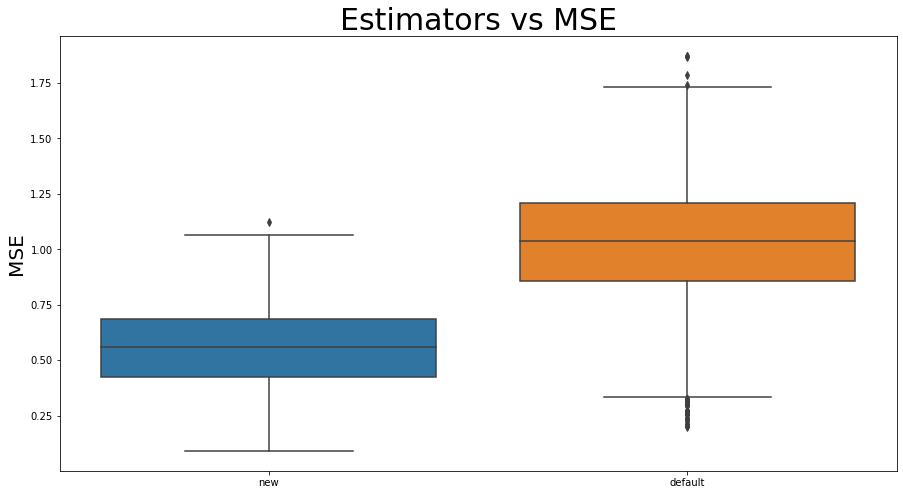

In [ ]:
KNN_params = KNN_res.best_params

models = {}
'''models['old'] = KNeighborsRegressor(weights='distance',
                                          n_neighbors = 70,
                                          n_jobs = -1)
'''
models['new'] = KNeighborsRegressor(**KNN_params)

models['default'] = KNeighborsRegressor(weights = 'uniform', n_neighbors = 3)

results = train_and_test_regressor(models, XS_train, YS_train, XS_test, YS_test)

plot_model_comparison(results)

In [ ]:
optuna.visualization.plot_param_importances(KNN_res)

In [ ]:
optuna.visualization.plot_slice(KNN_res, params = ['weights', 'n_neighbors'])

## Random Forest

In [ ]:
RF_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'criterion' : ['squared_error', 'absolute_error'],      #add 'poisson' for width tuning
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = RandomForest

RF_res = main(X = XS_train, y = YS_train, model_name = model_name, params = RF_params, n_trials = 500)

'''with open(f'RF_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)'''

with open(f'RF_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(RF_res.best_params, fp)

[I 2022-05-13 16:57:37,731] A new study created in memory with name: no-name-1187411e-6798-4377-b255-37738333fc28


Start hyperparameter optimization
{'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-05-13 16:57:40,494] Trial 0 finished with value: 1.978368546587291 and parameters: {'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 16:57:42,567] Trial 1 finished with value: 2.524633726460023 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:45,186] Trial 3 finished with value: 2.301731583914008 and parameters: {'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 8, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:47,957] Trial 4 finished with value: 2.246228911059661 and parameters: {'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 8, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 9, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:48,231] Trial 2 finished with value: 2.0666749722056936 and parameters: {'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 16:57:50,709] Trial 5 finished with value: 2.2860011439159464 and parameters: {'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 9, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:57:54,220] Trial 6 finished with value: 2.4688858841147985 and parameters: {'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.
[I 2022-05-13 16:57:54,291] Trial 7 finished with value: 3.1138323487392845 and parameters: {'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:56,878] Trial 9 finished with value: 2.3006183013510686 and parameters: {'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 8, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:59,383] Trial 10 finished with value: 2.268754983537945 and parameters: {'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 8, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:00,126] Trial 8 finished with value: 2.4426706282633384 and parameters: {'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:02,250] Trial 11 finished with value: 1.8009006781658592 and parameters: {'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}. Best is trial 11 with value: 1.8009006781658592.


{'n_estimators': 100, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:05,076] Trial 13 finished with value: 1.788820836005253 and parameters: {'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}. Best is trial 13 with value: 1.788820836005253.


{'n_estimators': 100, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:07,944] Trial 14 finished with value: 1.628814589541451 and parameters: {'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 14 with value: 1.628814589541451.


{'n_estimators': 100, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:08,581] Trial 12 finished with value: 1.9218493335667333 and parameters: {'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 14 with value: 1.628814589541451.


{'n_estimators': 100, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:11,275] Trial 15 finished with value: 1.181194342480087 and parameters: {'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:11,964] Trial 16 finished with value: 1.2794064482403935 and parameters: {'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:14,555] Trial 17 finished with value: 1.2025569154064824 and parameters: {'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:15,129] Trial 18 finished with value: 1.2476423811030917 and parameters: {'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:17,589] Trial 19 finished with value: 1.2705580872771405 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:18,005] Trial 20 finished with value: 1.5476339200450908 and parameters: {'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:20,437] Trial 21 finished with value: 1.552288622445643 and parameters: {'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:21,051] Trial 22 finished with value: 1.4013725408868936 and parameters: {'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:23,727] Trial 23 finished with value: 1.254722941177184 and parameters: {'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:24,399] Trial 24 finished with value: 1.2580971536256444 and parameters: {'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:26,734] Trial 25 finished with value: 1.6796934049645613 and parameters: {'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:27,303] Trial 26 finished with value: 1.6564703172252646 and parameters: {'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:29,654] Trial 27 finished with value: 1.6690930182447068 and parameters: {'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:30,127] Trial 28 finished with value: 2.042782132315242 and parameters: {'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:32,338] Trial 29 finished with value: 2.052274794259465 and parameters: {'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:33,127] Trial 30 finished with value: 1.2733403337798295 and parameters: {'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:35,285] Trial 31 finished with value: 1.465713994539609 and parameters: {'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:35,959] Trial 32 finished with value: 1.1989978132865782 and parameters: {'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:38,430] Trial 33 finished with value: 1.4185927609951159 and parameters: {'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:39,106] Trial 34 finished with value: 1.4021863827726155 and parameters: {'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:49,065] Trial 35 finished with value: 1.5065327054715585 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 46, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:50,440] Trial 36 finished with value: 1.1824558161707857 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:51,998] Trial 37 finished with value: 1.33482855715851 and parameters: {'max_depth': 46, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:58,554] Trial 38 finished with value: 2.0633831660938275 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:00,227] Trial 39 finished with value: 2.044466039165648 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:05,935] Trial 40 finished with value: 2.2731113348034055 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:09,972] Trial 41 finished with value: 1.7631593952074887 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:17,276] Trial 42 finished with value: 1.143880852213801 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:21,422] Trial 43 finished with value: 1.2006291837729077 and parameters: {'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:27,885] Trial 44 finished with value: 1.472589411505871 and parameters: {'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:31,942] Trial 45 finished with value: 1.453064232337693 and parameters: {'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:38,596] Trial 46 finished with value: 1.511440962407839 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:43,323] Trial 47 finished with value: 1.4971755278198198 and parameters: {'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:50,507] Trial 48 finished with value: 1.2321637004235289 and parameters: {'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:55,239] Trial 49 finished with value: 1.1675067606166185 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:00,142] Trial 50 finished with value: 1.758361536648616 and parameters: {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:03,678] Trial 51 finished with value: 1.9651289174718571 and parameters: {'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:11,981] Trial 52 finished with value: 1.1691314496734755 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:15,220] Trial 53 finished with value: 1.1888254362424457 and parameters: {'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:23,151] Trial 54 finished with value: 1.184641858552451 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:25,710] Trial 55 finished with value: 1.474479783571649 and parameters: {'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:31,186] Trial 56 finished with value: 1.572009376359254 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:35,761] Trial 57 finished with value: 1.4438284367543375 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:42,354] Trial 58 finished with value: 1.1585017385849004 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:47,563] Trial 59 finished with value: 1.1725085331581224 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:53,719] Trial 60 finished with value: 1.1710740664380104 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:56,662] Trial 61 finished with value: 1.7971376190934862 and parameters: {'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:05,329] Trial 62 finished with value: 1.1583668655943993 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:08,050] Trial 63 finished with value: 1.1716227291138157 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:17,376] Trial 64 finished with value: 1.214113792018897 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:18,841] Trial 65 finished with value: 1.4717943078353313 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:27,960] Trial 66 finished with value: 1.4841146427781857 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:30,365] Trial 67 finished with value: 1.2578273409600906 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:39,611] Trial 68 finished with value: 1.294100005405967 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:41,910] Trial 69 finished with value: 1.1847217257015188 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:51,154] Trial 70 finished with value: 1.1828220082111236 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:52,401] Trial 71 finished with value: 1.442860853259066 and parameters: {'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:02,432] Trial 72 finished with value: 1.1703309788788012 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:03,726] Trial 73 finished with value: 1.2014480827648308 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:10,545] Trial 75 finished with value: 2.3689401380023383 and parameters: {'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:12,904] Trial 74 finished with value: 1.2339150318197385 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:22,429] Trial 76 finished with value: 1.1936657943633364 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:23,412] Trial 77 finished with value: 1.4891132829790776 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:31,947] Trial 78 finished with value: 1.657966966316288 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:34,967] Trial 79 finished with value: 1.2866260177704334 and parameters: {'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:38,254] Trial 80 finished with value: 2.463310157133228 and parameters: {'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:46,130] Trial 81 finished with value: 1.2368813920934305 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:49,728] Trial 82 finished with value: 1.166750064638716 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:52,942] Trial 83 finished with value: 2.4366908301414396 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:00,663] Trial 84 finished with value: 1.2049248172156946 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:04,632] Trial 85 finished with value: 1.1912467187261413 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:12,590] Trial 86 finished with value: 1.1329921764216486 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:14,797] Trial 87 finished with value: 1.467898442422873 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:22,483] Trial 89 finished with value: 2.1712666280783672 and parameters: {'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:23,300] Trial 88 finished with value: 1.5274052514110992 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:34,149] Trial 90 finished with value: 1.1970777696157018 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:34,783] Trial 91 finished with value: 1.244115442895618 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:44,915] Trial 92 finished with value: 1.207081450285638 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:45,913] Trial 93 finished with value: 1.1489946840696157 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:56,575] Trial 95 finished with value: 1.505738548510688 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.
[I 2022-05-13 17:03:56,646] Trial 94 finished with value: 1.150032573166909 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:07,701] Trial 97 finished with value: 1.599711295443516 and parameters: {'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:08,104] Trial 96 finished with value: 1.1567977154133593 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:14,907] Trial 98 finished with value: 2.261164967751801 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:18,202] Trial 99 finished with value: 1.4916602203973295 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:23,462] Trial 100 finished with value: 1.5222855304770309 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:26,282] Trial 101 finished with value: 1.3178743345611637 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:35,164] Trial 102 finished with value: 1.12694489934444 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:37,620] Trial 103 finished with value: 1.221694970742751 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:46,650] Trial 104 finished with value: 1.1711071240981952 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:49,187] Trial 105 finished with value: 1.179083296267562 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:57,524] Trial 106 finished with value: 1.5216183839476982 and parameters: {'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:00,547] Trial 107 finished with value: 1.255542309209972 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:09,008] Trial 108 finished with value: 1.2372806889763683 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:11,935] Trial 109 finished with value: 1.231602387929209 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:19,635] Trial 110 finished with value: 1.4607157696552124 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:22,178] Trial 111 finished with value: 1.5302294525467393 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:31,054] Trial 112 finished with value: 1.2230523665762285 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:33,702] Trial 113 finished with value: 1.1241521310320777 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:42,026] Trial 114 finished with value: 1.1879829803391044 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:44,614] Trial 115 finished with value: 1.1740747970436012 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:54,204] Trial 116 finished with value: 1.223940982418635 and parameters: {'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:56,683] Trial 117 finished with value: 1.273936773188964 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:06,212] Trial 118 finished with value: 1.1838913226212546 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:08,369] Trial 119 finished with value: 1.2626673792155443 and parameters: {'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:17,196] Trial 120 finished with value: 1.474109743896052 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:18,907] Trial 121 finished with value: 1.514221131440808 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:28,647] Trial 122 finished with value: 1.1905583254421834 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:30,467] Trial 123 finished with value: 1.177967549656236 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:37,368] Trial 124 finished with value: 1.981414715545292 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:41,640] Trial 125 finished with value: 1.171316092211143 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:48,668] Trial 126 finished with value: 1.1473131919493347 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:53,419] Trial 127 finished with value: 1.1994887798828657 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:59,525] Trial 128 finished with value: 1.4618446332250343 and parameters: {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:04,192] Trial 129 finished with value: 1.1953180616411176 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:10,547] Trial 130 finished with value: 1.483323273335404 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:15,253] Trial 131 finished with value: 1.4894986892150013 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:22,558] Trial 132 finished with value: 1.2161180110189531 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:27,454] Trial 133 finished with value: 1.2083308368315826 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:34,568] Trial 134 finished with value: 1.1659597667291153 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:39,555] Trial 135 finished with value: 1.160984088875773 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:46,670] Trial 136 finished with value: 1.132621252492637 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:51,596] Trial 137 finished with value: 1.1854621659340958 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:58,787] Trial 138 finished with value: 1.1822109816173385 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:03,574] Trial 139 finished with value: 1.1589917029045154 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:10,800] Trial 140 finished with value: 1.177554904436646 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:15,547] Trial 141 finished with value: 1.1705989486736699 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:22,393] Trial 142 finished with value: 1.1853498541294623 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:27,422] Trial 143 finished with value: 1.2048907346857778 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:34,489] Trial 144 finished with value: 1.169978870314926 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:38,485] Trial 145 finished with value: 1.1811761164748593 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:45,396] Trial 146 finished with value: 1.1289490861423797 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:50,190] Trial 147 finished with value: 1.200054663600225 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:56,388] Trial 148 finished with value: 1.213337165110906 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 17:08:59,342] Trial 150 finished with value: 1.529317758723462 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 113 with value: 1.1241521310320777.
[I 2022-05-13 17:08:59,474] Trial 149 finished with value: 1.2390927119846897 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:11,010] Trial 151 finished with value: 1.1929792221865618 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.
[I 2022-05-13 17:09:11,135] Trial 152 finished with value: 1.1134873161920606 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:22,645] Trial 154 finished with value: 1.2050186939383605 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.
[I 2022-05-13 17:09:22,719] Trial 153 finished with value: 1.1593228998987188 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:34,120] Trial 155 finished with value: 1.180093831423966 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:34,493] Trial 156 finished with value: 1.1604569847833832 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:44,828] Trial 157 finished with value: 1.2372772348707801 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:45,541] Trial 158 finished with value: 1.1721230157243248 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:56,088] Trial 160 finished with value: 1.477285953151706 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.
[I 2022-05-13 17:09:56,113] Trial 159 finished with value: 1.2140522034408263 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:07,816] Trial 161 finished with value: 1.1923569198838977 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:08,276] Trial 162 finished with value: 1.119077707096365 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:18,626] Trial 163 finished with value: 1.1879712059630267 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:19,495] Trial 164 finished with value: 1.2452058300434277 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:30,212] Trial 165 finished with value: 1.1710318016174226 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:31,008] Trial 166 finished with value: 1.1787299888497051 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:35,886] Trial 168 finished with value: 2.5213627758250476 and parameters: {'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:41,721] Trial 167 finished with value: 1.15703327232514 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:46,997] Trial 169 finished with value: 1.3752175153074844 and parameters: {'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:53,515] Trial 170 finished with value: 1.1720691673363643 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:57,449] Trial 171 finished with value: 1.4610939907332772 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:05,114] Trial 172 finished with value: 1.1682730543969568 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:08,940] Trial 173 finished with value: 1.1905605235753418 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:16,439] Trial 174 finished with value: 1.1779271712008301 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:19,478] Trial 175 finished with value: 1.2460556684185957 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:24,723] Trial 176 finished with value: 2.068274649184595 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:11:27,834] Trial 178 finished with value: 1.2456163478350564 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:31,148] Trial 177 finished with value: 1.1078248602789196 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:39,797] Trial 179 finished with value: 1.1506497539919505 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:42,890] Trial 180 finished with value: 1.202041345426748 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:51,578] Trial 181 finished with value: 1.198713739352784 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:54,732] Trial 182 finished with value: 1.1706423644036852 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:03,552] Trial 183 finished with value: 1.172951296215865 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:06,783] Trial 184 finished with value: 1.180412389515366 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:15,422] Trial 185 finished with value: 1.1382857937030884 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:18,637] Trial 186 finished with value: 1.2602397472243891 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:27,484] Trial 187 finished with value: 1.1729345435974994 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:30,885] Trial 188 finished with value: 1.185168783225151 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:39,452] Trial 189 finished with value: 1.1424013145140555 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:42,427] Trial 190 finished with value: 1.143376658799505 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:51,203] Trial 191 finished with value: 1.2108399219702757 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:54,498] Trial 192 finished with value: 1.1598494334885772 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:02,776] Trial 193 finished with value: 1.187442798246762 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:06,385] Trial 194 finished with value: 1.169000991900986 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:14,602] Trial 195 finished with value: 1.2491958408027894 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:17,940] Trial 196 finished with value: 1.199159414392242 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:26,148] Trial 197 finished with value: 1.2163372209524854 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:29,796] Trial 198 finished with value: 1.1307165790834675 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:37,781] Trial 199 finished with value: 1.1212676049759296 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:40,288] Trial 200 finished with value: 1.461979400284331 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:48,068] Trial 201 finished with value: 1.5839103935521048 and parameters: {'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:52,257] Trial 202 finished with value: 1.1446064595631036 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:59,620] Trial 203 finished with value: 1.2094328073347698 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:04,089] Trial 204 finished with value: 1.2110570069814368 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:11,389] Trial 205 finished with value: 1.1950799522127125 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:15,723] Trial 206 finished with value: 1.158329355161334 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:22,981] Trial 207 finished with value: 1.203581502448318 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:14:26,128] Trial 209 finished with value: 1.2435943935824805 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:27,142] Trial 208 finished with value: 1.1670328244712724 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:33,478] Trial 210 finished with value: 2.2574032892943214 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:38,152] Trial 211 finished with value: 1.4910141580765452 and parameters: {'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:41,992] Trial 212 finished with value: 1.954703504141803 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:49,571] Trial 213 finished with value: 1.1709041809353546 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:53,379] Trial 214 finished with value: 1.2101602446139204 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:01,108] Trial 215 finished with value: 1.1806348970538973 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:04,714] Trial 216 finished with value: 1.2380918080974765 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:12,401] Trial 217 finished with value: 1.1612065443754616 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:16,204] Trial 218 finished with value: 1.1191463727887314 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:23,732] Trial 219 finished with value: 1.1882805865566344 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:27,770] Trial 220 finished with value: 1.1511736922576348 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:34,710] Trial 221 finished with value: 1.5467764993641906 and parameters: {'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:39,381] Trial 222 finished with value: 1.2062206097189831 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:45,778] Trial 223 finished with value: 1.637053844952634 and parameters: {'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:50,910] Trial 224 finished with value: 1.1968802009072559 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:57,315] Trial 225 finished with value: 1.103028131397619 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:02,344] Trial 226 finished with value: 1.191127418457795 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:09,165] Trial 227 finished with value: 1.234530299319156 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:13,683] Trial 228 finished with value: 1.1777063682329987 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:20,833] Trial 229 finished with value: 1.210866009683394 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:25,427] Trial 230 finished with value: 1.1786881383700163 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:32,451] Trial 231 finished with value: 1.1959956482434682 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:36,957] Trial 232 finished with value: 1.1825549063663754 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:44,155] Trial 233 finished with value: 1.1852211041163991 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:48,148] Trial 234 finished with value: 1.1669335400195973 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:55,491] Trial 235 finished with value: 1.170925475264075 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:59,395] Trial 236 finished with value: 1.1594221013077501 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:06,585] Trial 237 finished with value: 1.2719641491514309 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:10,480] Trial 238 finished with value: 1.1153461238901545 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:17,772] Trial 239 finished with value: 1.1780116738544302 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:20,926] Trial 240 finished with value: 1.2243732231770044 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:28,501] Trial 241 finished with value: 1.1625119932483032 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:32,335] Trial 242 finished with value: 1.1753791942520566 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:39,388] Trial 243 finished with value: 1.2199728936097585 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:43,505] Trial 244 finished with value: 1.1380879797136763 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:50,646] Trial 245 finished with value: 1.1862385155935091 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:54,226] Trial 246 finished with value: 1.1609363594551931 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:17:57,026] Trial 248 finished with value: 1.240319171593791 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:01,492] Trial 247 finished with value: 1.1711331845358361 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:07,307] Trial 249 finished with value: 1.1738899565032397 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:13,083] Trial 250 finished with value: 1.157137783617969 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:18,417] Trial 251 finished with value: 1.2105293728557704 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:24,130] Trial 252 finished with value: 1.1660638022057075 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:29,757] Trial 253 finished with value: 1.2065985598873112 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:35,424] Trial 254 finished with value: 1.2039262337947254 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:41,024] Trial 255 finished with value: 1.1999996866843965 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:46,788] Trial 256 finished with value: 1.2618069736537696 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:52,479] Trial 257 finished with value: 1.1452974463366967 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:58,126] Trial 258 finished with value: 1.154375104830974 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:03,761] Trial 259 finished with value: 1.2545413076107557 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:09,669] Trial 260 finished with value: 1.3093219604069677 and parameters: {'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:15,155] Trial 261 finished with value: 1.241167865618889 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:20,057] Trial 262 finished with value: 1.4551474216213707 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:27,114] Trial 263 finished with value: 1.251518289187708 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:31,995] Trial 264 finished with value: 1.2194066336305058 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:38,953] Trial 265 finished with value: 1.180474529402742 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:19:41,907] Trial 267 finished with value: 1.3702006887493554 and parameters: {'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:43,429] Trial 266 finished with value: 1.1517440904595984 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:50,972] Trial 269 finished with value: 2.2012820126378 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:53,427] Trial 268 finished with value: 1.1562991071724902 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:57,913] Trial 270 finished with value: 2.377475810684611 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:04,914] Trial 271 finished with value: 1.1191135051959908 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:09,644] Trial 272 finished with value: 1.156326199119772 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:16,180] Trial 273 finished with value: 1.1959121531616494 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:21,099] Trial 274 finished with value: 1.2473890333606206 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:27,480] Trial 275 finished with value: 1.1892808424030772 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:32,346] Trial 276 finished with value: 1.2040089255012696 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:38,619] Trial 277 finished with value: 1.1831039102308387 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:43,303] Trial 278 finished with value: 1.180991073043804 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:45,010] Trial 279 finished with value: 2.4208097908382955 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:53,662] Trial 280 finished with value: 1.435164114685236 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:54,912] Trial 281 finished with value: 1.4343023595604794 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:03,440] Trial 282 finished with value: 1.7627807071663337 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:06,206] Trial 283 finished with value: 1.1545629778530053 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:14,882] Trial 284 finished with value: 1.177440867283294 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:16,756] Trial 285 finished with value: 1.1760638777508539 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:21,368] Trial 286 finished with value: 2.4635000088705383 and parameters: {'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:21:24,361] Trial 288 finished with value: 1.1821697392176513 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:27,867] Trial 287 finished with value: 1.2229414330704178 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:35,773] Trial 289 finished with value: 1.226905951114108 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:39,225] Trial 290 finished with value: 1.18662267937147 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:46,523] Trial 292 finished with value: 2.30458249379243 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.
[I 2022-05-13 17:21:46,601] Trial 291 finished with value: 1.2509245323328293 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:57,171] Trial 294 finished with value: 1.4737638978914676 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:58,052] Trial 293 finished with value: 1.209528600266012 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:08,261] Trial 295 finished with value: 1.4469951481086052 and parameters: {'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:09,596] Trial 296 finished with value: 1.2473258775016354 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:19,544] Trial 297 finished with value: 1.1934273953963217 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:21,005] Trial 298 finished with value: 1.1989316635814296 and parameters: {'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:30,949] Trial 299 finished with value: 1.2935930565035911 and parameters: {'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:32,190] Trial 300 finished with value: 1.1925784663671652 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:41,881] Trial 301 finished with value: 1.21261758634139 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:43,616] Trial 302 finished with value: 1.1756821978609489 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:53,457] Trial 303 finished with value: 1.2597574178935889 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:53,885] Trial 304 finished with value: 1.4462936719286887 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:22:56,795] Trial 306 finished with value: 1.490769162550888 and parameters: {'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:01,968] Trial 305 finished with value: 1.9505538688259019 and parameters: {'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:08,483] Trial 307 finished with value: 1.1880265217704182 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:13,476] Trial 308 finished with value: 1.2083585999616657 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:19,926] Trial 309 finished with value: 1.1876141141735737 and parameters: {'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:24,679] Trial 310 finished with value: 1.1804717668903657 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:30,837] Trial 311 finished with value: 1.1494148279038068 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:36,299] Trial 312 finished with value: 1.1816225758767644 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:40,945] Trial 313 finished with value: 1.218201425730254 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:47,496] Trial 314 finished with value: 1.1979464978988723 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:50,300] Trial 315 finished with value: 1.175097345247784 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:57,536] Trial 316 finished with value: 1.4487880193583647 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:01,362] Trial 317 finished with value: 1.1704202694647399 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:08,670] Trial 318 finished with value: 1.2341147953952099 and parameters: {'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:12,843] Trial 319 finished with value: 1.1305560667713046 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:20,189] Trial 320 finished with value: 1.2005824747880751 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:24,373] Trial 321 finished with value: 1.2229337782696796 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:31,531] Trial 322 finished with value: 1.1915057628547796 and parameters: {'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:35,679] Trial 323 finished with value: 1.1877534032520276 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:41,942] Trial 324 finished with value: 1.49364971271097 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:24:43,436] Trial 325 finished with value: 2.1235687217965626 and parameters: {'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:44,996] Trial 326 finished with value: 1.2793676615358962 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:54,694] Trial 327 finished with value: 1.185641082138615 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:56,244] Trial 328 finished with value: 1.1958275978720967 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:05,878] Trial 329 finished with value: 1.204853717161622 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:07,656] Trial 330 finished with value: 1.189296699642409 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:17,230] Trial 331 finished with value: 1.1667751720734707 and parameters: {'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:18,749] Trial 332 finished with value: 1.2037164930204065 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:28,874] Trial 333 finished with value: 1.1875775010981893 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:29,223] Trial 334 finished with value: 1.1779964263095795 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:39,154] Trial 336 finished with value: 1.6480748051778877 and parameters: {'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:40,560] Trial 335 finished with value: 1.201768056414314 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:50,539] Trial 337 finished with value: 1.192717683902533 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.
[I 2022-05-13 17:25:50,603] Trial 338 finished with value: 1.1740793392891518 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:00,160] Trial 339 finished with value: 1.160265197141854 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:02,001] Trial 340 finished with value: 1.1660728680621133 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:11,415] Trial 341 finished with value: 1.178160406163767 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:13,040] Trial 342 finished with value: 1.193313995303436 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:22,825] Trial 343 finished with value: 1.1827258621360752 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:23,619] Trial 344 finished with value: 1.1865801798010391 and parameters: {'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:32,931] Trial 345 finished with value: 1.4625513885296448 and parameters: {'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:26:33,774] Trial 346 finished with value: 1.5229790105673047 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:35,921] Trial 347 finished with value: 1.262123583149154 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:45,248] Trial 348 finished with value: 1.1816127328877606 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:47,681] Trial 349 finished with value: 1.1899763323490495 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:56,220] Trial 350 finished with value: 1.1677775492546156 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:58,667] Trial 351 finished with value: 1.5138241509388373 and parameters: {'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:07,975] Trial 352 finished with value: 1.1879460802170954 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:10,195] Trial 353 finished with value: 1.253561278006912 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:19,807] Trial 354 finished with value: 1.1356649747817504 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:21,984] Trial 355 finished with value: 1.192239508890991 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:31,359] Trial 356 finished with value: 1.1543520108393819 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:33,844] Trial 357 finished with value: 1.1902407254222473 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:43,271] Trial 358 finished with value: 1.1604399608532543 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:45,645] Trial 359 finished with value: 1.1440975934824715 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:55,019] Trial 360 finished with value: 1.199106760639329 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:56,067] Trial 361 finished with value: 1.5144722125577939 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:06,281] Trial 362 finished with value: 1.2301484909431897 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:07,704] Trial 363 finished with value: 1.1795149878178168 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:28:10,682] Trial 365 finished with value: 1.197897679128975 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:17,672] Trial 364 finished with value: 1.1832851391855077 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:22,489] Trial 366 finished with value: 1.153505781853255 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:29,158] Trial 367 finished with value: 1.251821486763832 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:34,031] Trial 368 finished with value: 1.1316498788726874 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:40,652] Trial 369 finished with value: 1.1951120697470934 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:45,445] Trial 370 finished with value: 1.1973409866352231 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:52,428] Trial 371 finished with value: 1.181638725605285 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:55,750] Trial 372 finished with value: 1.4448723209861272 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:03,086] Trial 373 finished with value: 1.5644123413331203 and parameters: {'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:07,359] Trial 374 finished with value: 1.1878812910897525 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:14,462] Trial 375 finished with value: 1.2253928568065342 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:18,532] Trial 376 finished with value: 1.1787432174216443 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:26,034] Trial 377 finished with value: 1.1943939811426376 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:29,985] Trial 378 finished with value: 1.2128230888412068 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:37,177] Trial 379 finished with value: 1.20688908051913 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:41,455] Trial 380 finished with value: 1.1857217596939233 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:48,653] Trial 381 finished with value: 1.1786787418737295 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:52,885] Trial 382 finished with value: 1.1933356334092629 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:59,947] Trial 383 finished with value: 1.2623119198600588 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 17:30:02,950] Trial 385 finished with value: 1.6884972168051138 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.
[I 2022-05-13 17:30:03,106] Trial 384 finished with value: 1.5067569810501564 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:13,490] Trial 386 finished with value: 1.4227724250334997 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:14,499] Trial 387 finished with value: 1.2022624562986557 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:21,218] Trial 388 finished with value: 2.1249480647471026 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:25,460] Trial 389 finished with value: 1.211777180057242 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:27,964] Trial 390 finished with value: 1.4753530183428265 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:36,558] Trial 391 finished with value: 1.3781186861627313 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:38,996] Trial 392 finished with value: 1.4254001519470418 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:43,411] Trial 393 finished with value: 2.3337252802838515 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:50,366] Trial 394 finished with value: 1.1872276480598727 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:55,139] Trial 395 finished with value: 1.1873697720168186 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:01,790] Trial 396 finished with value: 1.275346793746476 and parameters: {'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:06,558] Trial 397 finished with value: 1.3067997287184032 and parameters: {'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:13,400] Trial 398 finished with value: 1.217292075734614 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:17,888] Trial 399 finished with value: 1.1371882501352102 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:24,952] Trial 400 finished with value: 1.209095124227062 and parameters: {'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:29,305] Trial 401 finished with value: 1.2136163031007552 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:36,652] Trial 402 finished with value: 1.1854576282324638 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:40,504] Trial 403 finished with value: 1.2441784012831438 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:31:43,381] Trial 405 finished with value: 1.147580699517016 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:47,742] Trial 404 finished with value: 1.2027746156362402 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:49,849] Trial 406 finished with value: 2.420379146743405 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:58,216] Trial 407 finished with value: 1.4528913535029244 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:00,603] Trial 408 finished with value: 1.4614378798599719 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:10,155] Trial 409 finished with value: 1.1857880559839535 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:12,184] Trial 410 finished with value: 1.1471472080077212 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:19,092] Trial 411 finished with value: 1.9035781682896886 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:23,803] Trial 412 finished with value: 1.1139391889584007 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:30,746] Trial 413 finished with value: 1.1806296002772605 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:35,637] Trial 414 finished with value: 1.225032509807484 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:42,155] Trial 415 finished with value: 1.165412739428246 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:43,958] Trial 416 finished with value: 2.077221528085837 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:53,379] Trial 417 finished with value: 1.181026452350457 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:55,394] Trial 418 finished with value: 1.145558170991512 and parameters: {'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:05,046] Trial 419 finished with value: 1.1862444716630645 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:06,253] Trial 420 finished with value: 1.4815794122566863 and parameters: {'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:16,573] Trial 421 finished with value: 1.1600518706847947 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:17,274] Trial 422 finished with value: 1.1749555875003121 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:33:20,224] Trial 424 finished with value: 1.169743924670645 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:27,819] Trial 423 finished with value: 1.1804293599129607 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:30,396] Trial 425 finished with value: 1.4872705438153522 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:39,717] Trial 426 finished with value: 1.2078786534517643 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:42,175] Trial 427 finished with value: 1.2026344698126525 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:51,436] Trial 428 finished with value: 1.1904188502025195 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:53,500] Trial 429 finished with value: 1.1897804591743533 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:03,181] Trial 430 finished with value: 1.2381507354788037 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:04,727] Trial 431 finished with value: 1.19458169764021 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:15,108] Trial 432 finished with value: 1.23092544247288 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:16,512] Trial 433 finished with value: 1.1662947900070284 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:26,379] Trial 434 finished with value: 1.1668415112178412 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:28,203] Trial 435 finished with value: 1.1852930350578823 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:37,963] Trial 436 finished with value: 1.207410161363788 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:38,374] Trial 437 finished with value: 1.487823975770247 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:48,224] Trial 438 finished with value: 1.4673422336453563 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:49,650] Trial 439 finished with value: 1.1806692814712174 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:59,810] Trial 440 finished with value: 1.1477544731736748 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:01,480] Trial 441 finished with value: 1.1940987798100002 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:10,683] Trial 442 finished with value: 1.6563940775265784 and parameters: {'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:35:12,974] Trial 443 finished with value: 1.1898507884921545 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:35:13,703] Trial 444 finished with value: 1.4934648694047448 and parameters: {'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:16,060] Trial 445 finished with value: 1.1683822463640088 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:25,517] Trial 446 finished with value: 1.1518980010334032 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:27,903] Trial 447 finished with value: 1.186047891962542 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:37,132] Trial 448 finished with value: 1.185435895609084 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:39,501] Trial 449 finished with value: 1.1784975495350005 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:48,702] Trial 450 finished with value: 1.2093423127024916 and parameters: {'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:51,091] Trial 451 finished with value: 1.1330160084821714 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:00,213] Trial 452 finished with value: 1.1470035991278995 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:02,664] Trial 453 finished with value: 1.1553234183145775 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:10,926] Trial 454 finished with value: 1.4813238367948962 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:13,191] Trial 455 finished with value: 1.4927124578836937 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:22,731] Trial 456 finished with value: 1.16414949184507 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:24,845] Trial 457 finished with value: 1.1879271389881954 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:34,297] Trial 458 finished with value: 1.213735292735305 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:36,267] Trial 459 finished with value: 1.1949092442379416 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:45,212] Trial 460 finished with value: 1.178124282075343 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:48,027] Trial 461 finished with value: 1.1962681497291203 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:56,659] Trial 462 finished with value: 1.1537243726462836 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:59,491] Trial 463 finished with value: 1.2114487068438264 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:07,897] Trial 464 finished with value: 1.1425876109217523 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:10,807] Trial 465 finished with value: 1.1609051504966195 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:19,346] Trial 466 finished with value: 1.1468823432131638 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:21,901] Trial 467 finished with value: 1.0956920694031769 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:30,479] Trial 468 finished with value: 1.1285914605688783 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:33,109] Trial 469 finished with value: 1.143212701499776 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:41,641] Trial 470 finished with value: 1.178571468434348 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:44,307] Trial 471 finished with value: 1.2729830156125765 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:52,964] Trial 472 finished with value: 1.2160798014448368 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:55,450] Trial 473 finished with value: 1.1884895214268503 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:04,240] Trial 474 finished with value: 1.1678661692161447 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:06,954] Trial 475 finished with value: 1.117026009054512 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:15,029] Trial 476 finished with value: 1.168480708284078 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:16,323] Trial 477 finished with value: 1.7634891172771923 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:25,067] Trial 478 finished with value: 1.4007115804155674 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:26,764] Trial 479 finished with value: 1.5275694772246204 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:36,263] Trial 480 finished with value: 1.1521136718252518 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:37,673] Trial 481 finished with value: 1.1525895143415514 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'squared_error'}


[I 2022-05-13 17:38:40,331] Trial 483 finished with value: 2.156694987848099 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'squared_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:43,274] Trial 482 finished with value: 2.24714338344459 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:50,838] Trial 484 finished with value: 1.1998012293248401 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:53,603] Trial 485 finished with value: 1.22926720505713 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:59,840] Trial 487 finished with value: 2.401576064957743 and parameters: {'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:02,072] Trial 486 finished with value: 1.1870324042094513 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:11,006] Trial 488 finished with value: 1.1858557629550408 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:13,621] Trial 489 finished with value: 1.176554591641216 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:22,324] Trial 490 finished with value: 1.174666242842349 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:24,454] Trial 491 finished with value: 1.134145750064165 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:33,519] Trial 492 finished with value: 1.2112604664444344 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:35,802] Trial 493 finished with value: 1.183947300960877 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:44,583] Trial 494 finished with value: 1.2145292020023537 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:46,581] Trial 495 finished with value: 1.545490531003715 and parameters: {'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:55,125] Trial 496 finished with value: 1.160897307986683 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:57,339] Trial 497 finished with value: 1.2014905875137585 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:40:05,426] Trial 498 finished with value: 1.6500821926088503 and parameters: {'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.
[I 2022-05-13 17:40:06,517] Trial 499 finished with value: 1.4986086273998311 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


Best parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


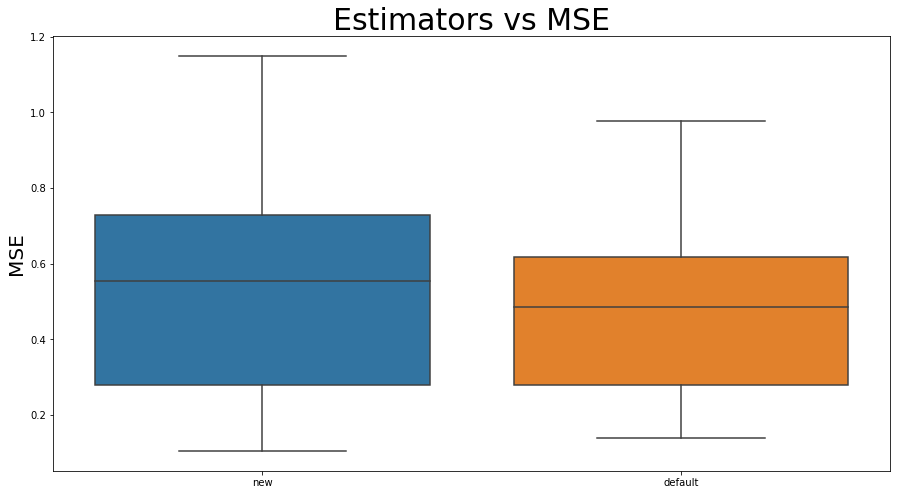

In [ ]:
RF_params = RF_res.best_params

models_RF = {}
'''models_RF['old'] = RandomForestRegressor(n_estimators = 500,
                                      max_depth = 25,
                                      min_samples_leaf = 2,
                                      min_samples_split = 2,
                                      n_jobs = -1)
'''
models_RF['new'] = RandomForestRegressor(**RF_params, n_estimators = 100)

models_RF['default'] = RandomForestRegressor()

results_RF = train_and_test_regressor(models_RF, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_RF)

In [ ]:
model = {}
for i in range(10, 201):
    model[f'{i}'] = RandomForestRegressor(**RF_params, n_estimators = i)

path = train_and_test_regressor(model, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(path)

In [ ]:
%matplotlib inline
plot_model_comparison(path)

In [ ]:
optuna.visualization.plot_param_importances(RF_res)

## Gradient Boosting

In [ ]:
GB_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'loss' : ['squared_error', 'absolute_error', 'quantile', 'huber'],
    'learning_rate' : [0.01, 0.1],
    'min_samples_leaf' : [1, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = Gradient_Boosting

GB_res = main(X = XS_train, y = YS_train, model_name = model_name, params = GB_params, n_trials = 500)

'''with open(f'GB_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(GB_res.best_params, fp)
'''
with open(f'GB_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(GB_res.best_params, fp)

[I 2022-05-13 17:53:47,547] A new study created in memory with name: no-name-4c51800e-dbbb-47d6-bba7-b85b263b5f6b


Start hyperparameter optimization
{'n_estimators': 100, 'learning_rate': 0.06398656123745806, 'loss': 'quantile', 'max_depth': 24, 'min_samples_leaf': 5}{'n_estimators': 100, 'learning_rate': 0.010927710038069168, 'loss': 'absolute_error', 'max_depth': 49, 'min_samples_leaf': 4}



/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-05-13 17:53:56,624] Trial 0 finished with value: 2.0270678775774797 and parameters: {'learning_rate': 0.06398656123745806, 'loss': 'quantile', 'max_depth': 24, 'min_samples_leaf': 5}. Best is trial 0 with value: 2.0270678775774797.


{'n_estimators': 100, 'learning_rate': 0.023480432218135075, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}


[I 2022-05-13 17:53:58,408] Trial 1 finished with value: 2.3260327839858688 and parameters: {'learning_rate': 0.010927710038069168, 'loss': 'absolute_error', 'max_depth': 49, 'min_samples_leaf': 4}. Best is trial 0 with value: 2.0270678775774797.


{'n_estimators': 100, 'learning_rate': 0.08377012060647092, 'loss': 'huber', 'max_depth': 4, 'min_samples_leaf': 7}


[I 2022-05-13 17:54:01,894] Trial 2 finished with value: 1.418575388454643 and parameters: {'learning_rate': 0.023480432218135075, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 2 with value: 1.418575388454643.


{'n_estimators': 100, 'learning_rate': 0.02244972999896341, 'loss': 'absolute_error', 'max_depth': 31, 'min_samples_leaf': 1}


[I 2022-05-13 17:54:02,156] Trial 3 finished with value: 1.7151285309903213 and parameters: {'learning_rate': 0.08377012060647092, 'loss': 'huber', 'max_depth': 4, 'min_samples_leaf': 7}. Best is trial 2 with value: 1.418575388454643.


{'n_estimators': 100, 'learning_rate': 0.08115672335569182, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 6}


[I 2022-05-13 17:54:07,495] Trial 5 finished with value: 1.313007359507063 and parameters: {'learning_rate': 0.08115672335569182, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 5 with value: 1.313007359507063.


{'n_estimators': 100, 'learning_rate': 0.0702737934566934, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 1}


[I 2022-05-13 17:54:26,528] Trial 4 finished with value: 1.4442865505928917 and parameters: {'learning_rate': 0.02244972999896341, 'loss': 'absolute_error', 'max_depth': 31, 'min_samples_leaf': 1}. Best is trial 5 with value: 1.313007359507063.


{'n_estimators': 100, 'learning_rate': 0.040513071989810794, 'loss': 'absolute_error', 'max_depth': 36, 'min_samples_leaf': 3}


[I 2022-05-13 17:54:51,512] Trial 7 finished with value: 1.4205354556511312 and parameters: {'learning_rate': 0.040513071989810794, 'loss': 'absolute_error', 'max_depth': 36, 'min_samples_leaf': 3}. Best is trial 5 with value: 1.313007359507063.


{'n_estimators': 100, 'learning_rate': 0.08171019094165212, 'loss': 'quantile', 'max_depth': 48, 'min_samples_leaf': 1}


[I 2022-05-13 17:54:58,444] Trial 6 finished with value: 0.9378194679846337 and parameters: {'learning_rate': 0.0702737934566934, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.05691044505188594, 'loss': 'squared_error', 'max_depth': 44, 'min_samples_leaf': 9}


[I 2022-05-13 17:55:02,094] Trial 9 finished with value: 1.3964233578831327 and parameters: {'learning_rate': 0.05691044505188594, 'loss': 'squared_error', 'max_depth': 44, 'min_samples_leaf': 9}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.013849347666995998, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 2}


[I 2022-05-13 17:55:05,643] Trial 8 finished with value: 1.5007598296369271 and parameters: {'learning_rate': 0.08171019094165212, 'loss': 'quantile', 'max_depth': 48, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.0985575040707841, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 10}


[I 2022-05-13 17:55:06,102] Trial 10 finished with value: 1.4328899352608246 and parameters: {'learning_rate': 0.013849347666995998, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.09182993550226201, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 7}


[I 2022-05-13 17:55:15,756] Trial 11 finished with value: 1.5918299812887846 and parameters: {'learning_rate': 0.0985575040707841, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 10}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.07278423881133711, 'loss': 'huber', 'max_depth': 16, 'min_samples_leaf': 7}


[I 2022-05-13 17:55:20,430] Trial 12 finished with value: 1.6662756955685734 and parameters: {'learning_rate': 0.09182993550226201, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.0714567085588332, 'loss': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 7}


[I 2022-05-13 17:55:25,116] Trial 14 finished with value: 1.3972188551587759 and parameters: {'learning_rate': 0.0714567085588332, 'loss': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 7}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.04465585101725503, 'loss': 'huber', 'max_depth': 18, 'min_samples_leaf': 5}


[I 2022-05-13 17:55:27,063] Trial 13 finished with value: 1.7087646376580732 and parameters: {'learning_rate': 0.07278423881133711, 'loss': 'huber', 'max_depth': 16, 'min_samples_leaf': 7}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.0497450382751181, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 5}


[I 2022-05-13 17:55:33,363] Trial 16 finished with value: 1.2878145750456969 and parameters: {'learning_rate': 0.0497450382751181, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 5}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.04328243662915431, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 5}


[I 2022-05-13 17:55:40,422] Trial 15 finished with value: 1.8077637797937716 and parameters: {'learning_rate': 0.04465585101725503, 'loss': 'huber', 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.04559188505412446, 'loss': 'quantile', 'max_depth': 32, 'min_samples_leaf': 3}


[I 2022-05-13 17:55:51,569] Trial 18 finished with value: 1.900898394865467 and parameters: {'learning_rate': 0.04559188505412446, 'loss': 'quantile', 'max_depth': 32, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.05742020323431148, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 9}


[I 2022-05-13 17:55:52,194] Trial 17 finished with value: 1.8124824143138756 and parameters: {'learning_rate': 0.04328243662915431, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 5}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.05506265069653368, 'loss': 'squared_error', 'max_depth': 39, 'min_samples_leaf': 9}


[I 2022-05-13 17:55:53,082] Trial 19 finished with value: 1.3931108713128586 and parameters: {'learning_rate': 0.05742020323431148, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.03142336423529758, 'loss': 'huber', 'max_depth': 37, 'min_samples_leaf': 2}


[I 2022-05-13 17:55:53,868] Trial 20 finished with value: 1.401070419221948 and parameters: {'learning_rate': 0.05506265069653368, 'loss': 'squared_error', 'max_depth': 39, 'min_samples_leaf': 9}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.07676729007227097, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 6}


[I 2022-05-13 17:55:59,865] Trial 22 finished with value: 1.3132008099503292 and parameters: {'learning_rate': 0.07676729007227097, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.0694947164260864, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 6}


[I 2022-05-13 17:56:05,386] Trial 23 finished with value: 1.3334398237455107 and parameters: {'learning_rate': 0.0694947164260864, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 6}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.08815969890854214, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-05-13 17:56:13,894] Trial 24 finished with value: 1.319864533634209 and parameters: {'learning_rate': 0.08815969890854214, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.06344604817215611, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 8}


[I 2022-05-13 17:56:19,852] Trial 25 finished with value: 1.3522685375619374 and parameters: {'learning_rate': 0.06344604817215611, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 8}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.0377911064858071, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 2}


[I 2022-05-13 17:56:21,745] Trial 21 finished with value: 1.3050294819143224 and parameters: {'learning_rate': 0.03142336423529758, 'loss': 'huber', 'max_depth': 37, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.03512794245533923, 'loss': 'huber', 'max_depth': 1, 'min_samples_leaf': 2}


[I 2022-05-13 17:56:26,232] Trial 27 finished with value: 2.518275701938659 and parameters: {'learning_rate': 0.03512794245533923, 'loss': 'huber', 'max_depth': 1, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.031848100353702946, 'loss': 'huber', 'max_depth': 38, 'min_samples_leaf': 2}


[I 2022-05-13 17:57:09,138] Trial 26 finished with value: 1.1912631771024773 and parameters: {'learning_rate': 0.0377911064858071, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.050770502861007885, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 17:57:17,315] Trial 28 finished with value: 1.254875668238873 and parameters: {'learning_rate': 0.031848100353702946, 'loss': 'huber', 'max_depth': 38, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.9378194679846337.


{'n_estimators': 100, 'learning_rate': 0.02720269433821217, 'loss': 'huber', 'max_depth': 43, 'min_samples_leaf': 1}


[I 2022-05-13 17:57:59,341] Trial 29 finished with value: 0.8975914978035686 and parameters: {'learning_rate': 0.050770502861007885, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 29 with value: 0.8975914978035686.


{'n_estimators': 100, 'learning_rate': 0.0499914611878788, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 17:58:38,293] Trial 30 finished with value: 1.0221487255032897 and parameters: {'learning_rate': 0.02720269433821217, 'loss': 'huber', 'max_depth': 43, 'min_samples_leaf': 1}. Best is trial 29 with value: 0.8975914978035686.


{'n_estimators': 100, 'learning_rate': 0.024408007918453718, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 1}


[I 2022-05-13 17:58:49,211] Trial 31 finished with value: 0.9541900792814365 and parameters: {'learning_rate': 0.0499914611878788, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 29 with value: 0.8975914978035686.


{'n_estimators': 100, 'learning_rate': 0.06259863734088927, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 1}


[I 2022-05-13 17:59:28,723] Trial 32 finished with value: 0.9909873196559978 and parameters: {'learning_rate': 0.024408007918453718, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 29 with value: 0.8975914978035686.


{'n_estimators': 100, 'learning_rate': 0.06534031692326683, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 17:59:46,510] Trial 33 finished with value: 0.9698199299035679 and parameters: {'learning_rate': 0.06259863734088927, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 1}. Best is trial 29 with value: 0.8975914978035686.


{'n_estimators': 100, 'learning_rate': 0.06355743812986576, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:00:19,051] Trial 34 finished with value: 0.8956517208783538 and parameters: {'learning_rate': 0.06534031692326683, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 34 with value: 0.8956517208783538.


{'n_estimators': 100, 'learning_rate': 0.05154633131142609, 'loss': 'quantile', 'max_depth': 2, 'min_samples_leaf': 4}


[I 2022-05-13 18:00:21,931] Trial 35 finished with value: 0.8977873285758069 and parameters: {'learning_rate': 0.06355743812986576, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 34 with value: 0.8956517208783538.


{'n_estimators': 100, 'learning_rate': 0.06530977347736373, 'loss': 'absolute_error', 'max_depth': 8, 'min_samples_leaf': 4}


[I 2022-05-13 18:00:23,792] Trial 36 finished with value: 2.857671028605611 and parameters: {'learning_rate': 0.05154633131142609, 'loss': 'quantile', 'max_depth': 2, 'min_samples_leaf': 4}. Best is trial 34 with value: 0.8956517208783538.


{'n_estimators': 100, 'learning_rate': 0.06698665311661701, 'loss': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 3}


[I 2022-05-13 18:00:35,942] Trial 37 finished with value: 1.4860249521954891 and parameters: {'learning_rate': 0.06530977347736373, 'loss': 'absolute_error', 'max_depth': 8, 'min_samples_leaf': 4}. Best is trial 34 with value: 0.8956517208783538.


{'n_estimators': 100, 'learning_rate': 0.05969419138811817, 'loss': 'huber', 'max_depth': 4, 'min_samples_leaf': 3}


[I 2022-05-13 18:00:38,502] Trial 38 finished with value: 1.275427108381383 and parameters: {'learning_rate': 0.06698665311661701, 'loss': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 3}. Best is trial 34 with value: 0.8956517208783538.


{'n_estimators': 100, 'learning_rate': 0.07561048828934566, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 3}


[I 2022-05-13 18:00:44,928] Trial 39 finished with value: 1.544420734274107 and parameters: {'learning_rate': 0.05969419138811817, 'loss': 'huber', 'max_depth': 4, 'min_samples_leaf': 3}. Best is trial 34 with value: 0.8956517208783538.


{'n_estimators': 100, 'learning_rate': 0.07650702541180529, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}


[I 2022-05-13 18:00:49,984] Trial 40 finished with value: 1.487123777022736 and parameters: {'learning_rate': 0.07561048828934566, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 3}. Best is trial 34 with value: 0.8956517208783538.


{'n_estimators': 100, 'learning_rate': 0.05139222691278771, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:01:26,497] Trial 41 finished with value: 1.163936429284983 and parameters: {'learning_rate': 0.07650702541180529, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 34 with value: 0.8956517208783538.


{'n_estimators': 100, 'learning_rate': 0.05228130685494255, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:01:32,840] Trial 42 finished with value: 0.8706073947332594 and parameters: {'learning_rate': 0.05139222691278771, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8706073947332594.


{'n_estimators': 100, 'learning_rate': 0.052343228083659335, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:02:05,535] Trial 43 finished with value: 0.902251336211112 and parameters: {'learning_rate': 0.05228130685494255, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8706073947332594.


{'n_estimators': 100, 'learning_rate': 0.052775108289625866, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:02:15,113] Trial 44 finished with value: 0.8980033258560912 and parameters: {'learning_rate': 0.052343228083659335, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8706073947332594.


{'n_estimators': 100, 'learning_rate': 0.059366208276766204, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:02:46,150] Trial 45 finished with value: 0.9010215525637942 and parameters: {'learning_rate': 0.052775108289625866, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8706073947332594.


{'n_estimators': 100, 'learning_rate': 0.06000976140181133, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 2}


[I 2022-05-13 18:02:53,611] Trial 46 finished with value: 0.8614968557842037 and parameters: {'learning_rate': 0.059366208276766204, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.05954885065293386, 'loss': 'quantile', 'max_depth': 3, 'min_samples_leaf': 2}


[I 2022-05-13 18:02:54,179] Trial 47 finished with value: 1.3192215984499192 and parameters: {'learning_rate': 0.06000976140181133, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.04777307354566166, 'loss': 'quantile', 'max_depth': 19, 'min_samples_leaf': 2}


[I 2022-05-13 18:02:59,293] Trial 48 finished with value: 2.2615766064692147 and parameters: {'learning_rate': 0.05954885065293386, 'loss': 'quantile', 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.04689053658936138, 'loss': 'absolute_error', 'max_depth': 18, 'min_samples_leaf': 1}


[I 2022-05-13 18:03:06,531] Trial 49 finished with value: 1.6346091340749151 and parameters: {'learning_rate': 0.04777307354566166, 'loss': 'quantile', 'max_depth': 19, 'min_samples_leaf': 2}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.06747935065131802, 'loss': 'absolute_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:03:21,544] Trial 51 finished with value: 1.514146703856358 and parameters: {'learning_rate': 0.06747935065131802, 'loss': 'absolute_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.04080623077926563, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:03:28,209] Trial 50 finished with value: 1.0535551089673516 and parameters: {'learning_rate': 0.04689053658936138, 'loss': 'absolute_error', 'max_depth': 18, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.04076311828218063, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:04:03,495] Trial 52 finished with value: 0.8624121791453128 and parameters: {'learning_rate': 0.04080623077926563, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.03852133582443749, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 1}


[I 2022-05-13 18:04:10,670] Trial 53 finished with value: 0.8903454451030554 and parameters: {'learning_rate': 0.04076311828218063, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.04032495133812608, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 2}


[I 2022-05-13 18:05:05,609] Trial 55 finished with value: 1.1867106169401458 and parameters: {'learning_rate': 0.04032495133812608, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 2}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.043200313966696414, 'loss': 'huber', 'max_depth': 16, 'min_samples_leaf': 1}


[I 2022-05-13 18:05:06,347] Trial 54 finished with value: 0.9331069727551295 and parameters: {'learning_rate': 0.03852133582443749, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.044481713860603934, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}


[I 2022-05-13 18:05:56,251] Trial 57 finished with value: 1.1456510795251087 and parameters: {'learning_rate': 0.044481713860603934, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.04260852658366604, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 1}


[I 2022-05-13 18:06:14,296] Trial 56 finished with value: 0.9454248949117222 and parameters: {'learning_rate': 0.043200313966696414, 'loss': 'huber', 'max_depth': 16, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.056621561425097555, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}


[I 2022-05-13 18:06:46,076] Trial 59 finished with value: 1.5481753615848612 and parameters: {'learning_rate': 0.056621561425097555, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.03434866816939473, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 2}


[I 2022-05-13 18:06:50,056] Trial 58 finished with value: 0.928745164158147 and parameters: {'learning_rate': 0.04260852658366604, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.034740059979873485, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 2}


[I 2022-05-13 18:07:03,409] Trial 60 finished with value: 1.1875291370555745 and parameters: {'learning_rate': 0.03434866816939473, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.06285002270074533, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:07:07,150] Trial 61 finished with value: 1.1961323705315179 and parameters: {'learning_rate': 0.034740059979873485, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.062096725366560676, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:07:48,183] Trial 62 finished with value: 0.9111519435637645 and parameters: {'learning_rate': 0.06285002270074533, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8614968557842037.


{'n_estimators': 100, 'learning_rate': 0.056764559076095886, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:07:53,370] Trial 63 finished with value: 0.8519419054193034 and parameters: {'learning_rate': 0.062096725366560676, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.05841116452938523, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:08:23,174] Trial 64 finished with value: 0.9598114988679161 and parameters: {'learning_rate': 0.056764559076095886, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.049425228973205546, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}


[I 2022-05-13 18:08:37,093] Trial 65 finished with value: 0.8681286541919006 and parameters: {'learning_rate': 0.05841116452938523, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.07091238597289519, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}


[I 2022-05-13 18:08:58,492] Trial 66 finished with value: 1.1802317438259393 and parameters: {'learning_rate': 0.049425228973205546, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.07316521370008924, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 10}


[I 2022-05-13 18:09:11,881] Trial 68 finished with value: 1.660133269497813 and parameters: {'learning_rate': 0.07316521370008924, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.05473396744656491, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 1}


[I 2022-05-13 18:09:13,372] Trial 67 finished with value: 1.1204248041124925 and parameters: {'learning_rate': 0.07091238597289519, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.05517601151300076, 'loss': 'quantile', 'max_depth': 4, 'min_samples_leaf': 1}


[I 2022-05-13 18:09:24,513] Trial 70 finished with value: 1.9699193500948193 and parameters: {'learning_rate': 0.05517601151300076, 'loss': 'quantile', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.06027821674145218, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:09:55,299] Trial 71 finished with value: 0.8658799662229886 and parameters: {'learning_rate': 0.06027821674145218, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.013714290151947015, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:10:08,153] Trial 69 finished with value: 0.9481377155013087 and parameters: {'learning_rate': 0.05473396744656491, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.01831686038250232, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:10:22,267] Trial 72 finished with value: 1.362015800608198 and parameters: {'learning_rate': 0.013714290151947015, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.06049192581168528, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:10:41,966] Trial 73 finished with value: 1.1298661166513215 and parameters: {'learning_rate': 0.01831686038250232, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.059882667809761474, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}


[I 2022-05-13 18:11:08,917] Trial 74 finished with value: 0.9119972932645423 and parameters: {'learning_rate': 0.06049192581168528, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.06712891420811481, 'loss': 'huber', 'max_depth': 1, 'min_samples_leaf': 2}


[I 2022-05-13 18:11:12,530] Trial 76 finished with value: 2.201296095227735 and parameters: {'learning_rate': 0.06712891420811481, 'loss': 'huber', 'max_depth': 1, 'min_samples_leaf': 2}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.06551922701007296, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 1}


[I 2022-05-13 18:11:15,849] Trial 75 finished with value: 1.1675183334726416 and parameters: {'learning_rate': 0.059882667809761474, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.06903737255763999, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:11:33,276] Trial 78 finished with value: 0.8834185737273611 and parameters: {'learning_rate': 0.06903737255763999, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.08010892209306902, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:11:51,013] Trial 79 finished with value: 0.9203344717928834 and parameters: {'learning_rate': 0.08010892209306902, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.029149862691225378, 'loss': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 3}


[I 2022-05-13 18:11:58,718] Trial 77 finished with value: 0.9091476111964727 and parameters: {'learning_rate': 0.06551922701007296, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.06895307646622714, 'loss': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 2}


[I 2022-05-13 18:12:07,444] Trial 80 finished with value: 1.4503013511979492 and parameters: {'learning_rate': 0.029149862691225378, 'loss': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 3}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.06950295939934198, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:12:15,532] Trial 81 finished with value: 1.3434612136411992 and parameters: {'learning_rate': 0.06895307646622714, 'loss': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 2}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.0649767157750301, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:12:46,554] Trial 82 finished with value: 0.905381978928222 and parameters: {'learning_rate': 0.06950295939934198, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.06299040475688658, 'loss': 'huber', 'max_depth': 4, 'min_samples_leaf': 1}


[I 2022-05-13 18:12:53,653] Trial 83 finished with value: 0.8847916618848719 and parameters: {'learning_rate': 0.0649767157750301, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.06255364649385298, 'loss': 'huber', 'max_depth': 4, 'min_samples_leaf': 1}


[I 2022-05-13 18:12:56,853] Trial 84 finished with value: 1.2707608657056961 and parameters: {'learning_rate': 0.06299040475688658, 'loss': 'huber', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.05808196101516832, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:13:03,050] Trial 85 finished with value: 1.2689312138391782 and parameters: {'learning_rate': 0.06255364649385298, 'loss': 'huber', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.07399009488899543, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 8}


[I 2022-05-13 18:13:09,270] Trial 86 finished with value: 0.9116319957753202 and parameters: {'learning_rate': 0.05808196101516832, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.07378024060687198, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 8}


[I 2022-05-13 18:13:12,564] Trial 87 finished with value: 1.7075945392786678 and parameters: {'learning_rate': 0.07399009488899543, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 8}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.053568309244784694, 'loss': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 2}


[I 2022-05-13 18:13:12,919] Trial 88 finished with value: 1.3295112741147759 and parameters: {'learning_rate': 0.07378024060687198, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 8}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.05439699146770453, 'loss': 'quantile', 'max_depth': 2, 'min_samples_leaf': 2}


[I 2022-05-13 18:13:13,418] Trial 89 finished with value: 1.4623654334021823 and parameters: {'learning_rate': 0.053568309244784694, 'loss': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 2}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.048231984075281065, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 2}


[I 2022-05-13 18:13:17,045] Trial 90 finished with value: 2.767160341025467 and parameters: {'learning_rate': 0.05439699146770453, 'loss': 'quantile', 'max_depth': 2, 'min_samples_leaf': 2}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.06542713585508374, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:13:36,611] Trial 91 finished with value: 1.1646459023919231 and parameters: {'learning_rate': 0.048231984075281065, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.058106730697302905, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:13:51,025] Trial 92 finished with value: 0.923226144932358 and parameters: {'learning_rate': 0.06542713585508374, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.0403521692016294, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 1}


[I 2022-05-13 18:14:23,714] Trial 93 finished with value: 0.9263710554692359 and parameters: {'learning_rate': 0.058106730697302905, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.061336172341054575, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 1}


[I 2022-05-13 18:14:42,724] Trial 94 finished with value: 0.9959817231234626 and parameters: {'learning_rate': 0.0403521692016294, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 63 with value: 0.8519419054193034.


{'n_estimators': 100, 'learning_rate': 0.061121553293079965, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:15:06,140] Trial 96 finished with value: 0.8455236436531444 and parameters: {'learning_rate': 0.061121553293079965, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 96 with value: 0.8455236436531444.


{'n_estimators': 100, 'learning_rate': 0.06183970867451847, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:15:13,202] Trial 95 finished with value: 0.9208478313882601 and parameters: {'learning_rate': 0.061336172341054575, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 96 with value: 0.8455236436531444.


{'n_estimators': 100, 'learning_rate': 0.037358753375375676, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:15:27,008] Trial 97 finished with value: 0.8247871947339871 and parameters: {'learning_rate': 0.06183970867451847, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06147180116213718, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:15:33,439] Trial 98 finished with value: 0.9142520065907102 and parameters: {'learning_rate': 0.037358753375375676, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06811657624656119, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 1}


[I 2022-05-13 18:15:40,391] Trial 100 finished with value: 1.220641675873333 and parameters: {'learning_rate': 0.06811657624656119, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.07847869949774798, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 2}


[I 2022-05-13 18:15:45,136] Trial 99 finished with value: 0.8731884965653016 and parameters: {'learning_rate': 0.06147180116213718, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06492851127770599, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:15:53,272] Trial 101 finished with value: 1.0567708622464203 and parameters: {'learning_rate': 0.07847869949774798, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 2}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.0648652734561108, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:15:59,245] Trial 102 finished with value: 0.9011596878674851 and parameters: {'learning_rate': 0.06492851127770599, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06156075036016611, 'loss': 'huber', 'max_depth': 49, 'min_samples_leaf': 1}


[I 2022-05-13 18:16:23,305] Trial 103 finished with value: 0.8704609939013128 and parameters: {'learning_rate': 0.0648652734561108, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.07141798724464289, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:16:56,427] Trial 105 finished with value: 0.8968083834891655 and parameters: {'learning_rate': 0.07141798724464289, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06165660800562231, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 1}


[I 2022-05-13 18:17:22,836] Trial 104 finished with value: 0.9477221995269227 and parameters: {'learning_rate': 0.06156075036016611, 'loss': 'huber', 'max_depth': 49, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05862979865224497, 'loss': 'huber', 'max_depth': 47, 'min_samples_leaf': 2}


[I 2022-05-13 18:18:19,510] Trial 107 finished with value: 1.1807249574034286 and parameters: {'learning_rate': 0.05862979865224497, 'loss': 'huber', 'max_depth': 47, 'min_samples_leaf': 2}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05583819427402576, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 1}


[I 2022-05-13 18:18:23,343] Trial 106 finished with value: 0.9749979165553283 and parameters: {'learning_rate': 0.06165660800562231, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05555853247066057, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:18:54,767] Trial 109 finished with value: 0.9025725614919434 and parameters: {'learning_rate': 0.05555853247066057, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.098484355114019, 'loss': 'quantile', 'max_depth': 6, 'min_samples_leaf': 2}


[I 2022-05-13 18:19:10,235] Trial 110 finished with value: 1.5475385762066936 and parameters: {'learning_rate': 0.098484355114019, 'loss': 'quantile', 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.055956449637257585, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 6}


[I 2022-05-13 18:19:27,526] Trial 111 finished with value: 1.950929338212708 and parameters: {'learning_rate': 0.055956449637257585, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 6}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06653545849171698, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:19:33,825] Trial 108 finished with value: 0.9038825212807954 and parameters: {'learning_rate': 0.05583819427402576, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.0656581776344681, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:20:12,561] Trial 112 finished with value: 0.915576704351466 and parameters: {'learning_rate': 0.06653545849171698, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06396331090377784, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 1}


[I 2022-05-13 18:20:13,356] Trial 113 finished with value: 0.9023107929737672 and parameters: {'learning_rate': 0.0656581776344681, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.064279742922304, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 1}


[I 2022-05-13 18:20:18,307] Trial 114 finished with value: 1.2782307619559456 and parameters: {'learning_rate': 0.06396331090377784, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06012989761026004, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:20:18,948] Trial 115 finished with value: 1.256623027087868 and parameters: {'learning_rate': 0.064279742922304, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05850586797380327, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 2}


[I 2022-05-13 18:20:38,532] Trial 116 finished with value: 0.872768162745904 and parameters: {'learning_rate': 0.06012989761026004, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05917803468392284, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 2}


[I 2022-05-13 18:20:39,031] Trial 117 finished with value: 1.1428033622214389 and parameters: {'learning_rate': 0.05850586797380327, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 2}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06001144048011526, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:20:55,686] Trial 118 finished with value: 1.110093088158931 and parameters: {'learning_rate': 0.05917803468392284, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06068814846986796, 'loss': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:20:57,626] Trial 119 finished with value: 0.9005592212944634 and parameters: {'learning_rate': 0.06001144048011526, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.052018191071956266, 'loss': 'huber', 'max_depth': 1, 'min_samples_leaf': 5}


[I 2022-05-13 18:21:00,530] Trial 121 finished with value: 2.2851513752079278 and parameters: {'learning_rate': 0.052018191071956266, 'loss': 'huber', 'max_depth': 1, 'min_samples_leaf': 5}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06823451496156677, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:21:07,213] Trial 120 finished with value: 1.4338885379933446 and parameters: {'learning_rate': 0.06068814846986796, 'loss': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06992598455387422, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:21:38,867] Trial 122 finished with value: 0.8880757477751032 and parameters: {'learning_rate': 0.06823451496156677, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05735745518425116, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:21:53,324] Trial 123 finished with value: 0.9042239994641272 and parameters: {'learning_rate': 0.06992598455387422, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05725109389341066, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:22:27,566] Trial 124 finished with value: 0.8982331722108301 and parameters: {'learning_rate': 0.05735745518425116, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06275784457555728, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:22:41,577] Trial 125 finished with value: 0.9021608202423452 and parameters: {'learning_rate': 0.05725109389341066, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.0632921439839431, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}


[I 2022-05-13 18:22:46,262] Trial 127 finished with value: 0.9126997225912099 and parameters: {'learning_rate': 0.0632921439839431, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06288511323897822, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:22:57,576] Trial 126 finished with value: 0.8737157437567896 and parameters: {'learning_rate': 0.06275784457555728, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.061663698433188426, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:23:18,633] Trial 128 finished with value: 0.9097032029715777 and parameters: {'learning_rate': 0.06288511323897822, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06737547154158138, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}


[I 2022-05-13 18:23:30,871] Trial 129 finished with value: 0.8882912713359964 and parameters: {'learning_rate': 0.061663698433188426, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06657581332977386, 'loss': 'huber', 'max_depth': 33, 'min_samples_leaf': 2}


[I 2022-05-13 18:23:55,821] Trial 130 finished with value: 1.1522793284979505 and parameters: {'learning_rate': 0.06737547154158138, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05359073772905717, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:24:20,132] Trial 131 finished with value: 1.1395739945875913 and parameters: {'learning_rate': 0.06657581332977386, 'loss': 'huber', 'max_depth': 33, 'min_samples_leaf': 2}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06374342696852457, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:24:24,652] Trial 132 finished with value: 0.9036585348435378 and parameters: {'learning_rate': 0.05359073772905717, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06383445897140205, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:24:48,555] Trial 133 finished with value: 0.9002819341286292 and parameters: {'learning_rate': 0.06374342696852457, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06111042537009638, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:25:01,302] Trial 134 finished with value: 0.878504556830811 and parameters: {'learning_rate': 0.06383445897140205, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.060479707221484685, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:25:17,800] Trial 136 finished with value: 0.9374040454878074 and parameters: {'learning_rate': 0.060479707221484685, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.0721892432005857, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:25:24,133] Trial 135 finished with value: 0.8612653390681366 and parameters: {'learning_rate': 0.06111042537009638, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05921163696842802, 'loss': 'quantile', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:25:42,907] Trial 138 finished with value: 1.5594547348362382 and parameters: {'learning_rate': 0.05921163696842802, 'loss': 'quantile', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.050052862106165164, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:25:53,977] Trial 137 finished with value: 0.8944157385297468 and parameters: {'learning_rate': 0.0721892432005857, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06184108872164342, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:26:29,644] Trial 139 finished with value: 0.9452558665596953 and parameters: {'learning_rate': 0.050052862106165164, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.061583948466269176, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 4}


[I 2022-05-13 18:26:38,736] Trial 140 finished with value: 0.8569200076931839 and parameters: {'learning_rate': 0.06184108872164342, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06176420831640734, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 1}


[I 2022-05-13 18:26:54,839] Trial 141 finished with value: 1.6912761457938033 and parameters: {'learning_rate': 0.061583948466269176, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05750399383420186, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:27:35,495] Trial 142 finished with value: 0.9314953989262925 and parameters: {'learning_rate': 0.06176420831640734, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.058002197932013506, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:27:41,316] Trial 143 finished with value: 0.9138904962070249 and parameters: {'learning_rate': 0.05750399383420186, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06391037257921117, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:28:08,715] Trial 144 finished with value: 0.9454752532713462 and parameters: {'learning_rate': 0.058002197932013506, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.0641058316781423, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}


[I 2022-05-13 18:28:13,841] Trial 145 finished with value: 0.9220982217588499 and parameters: {'learning_rate': 0.06391037257921117, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05407876485902569, 'loss': 'huber', 'max_depth': 41, 'min_samples_leaf': 1}


[I 2022-05-13 18:28:40,814] Trial 146 finished with value: 1.1572301732897137 and parameters: {'learning_rate': 0.0641058316781423, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05431839286684201, 'loss': 'absolute_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:29:00,215] Trial 148 finished with value: 1.4798338319561448 and parameters: {'learning_rate': 0.05431839286684201, 'loss': 'absolute_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.06002888513891014, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:29:24,554] Trial 147 finished with value: 0.9359048578638722 and parameters: {'learning_rate': 0.05407876485902569, 'loss': 'huber', 'max_depth': 41, 'min_samples_leaf': 1}. Best is trial 97 with value: 0.8247871947339871.


{'n_estimators': 100, 'learning_rate': 0.05997472951460348, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 1}


[I 2022-05-13 18:29:24,895] Trial 149 finished with value: 0.8088448593910315 and parameters: {'learning_rate': 0.06002888513891014, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.046311530338618956, 'loss': 'huber', 'max_depth': 4, 'min_samples_leaf': 1}


[I 2022-05-13 18:29:37,653] Trial 151 finished with value: 1.2802823001799397 and parameters: {'learning_rate': 0.046311530338618956, 'loss': 'huber', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.05939072776982472, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 1}


[I 2022-05-13 18:30:15,390] Trial 150 finished with value: 0.8797792903132782 and parameters: {'learning_rate': 0.05997472951460348, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.05608827141859707, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:30:39,923] Trial 153 finished with value: 0.854037738433796 and parameters: {'learning_rate': 0.05608827141859707, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.05602793749744317, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:30:56,824] Trial 152 finished with value: 0.91520822853878 and parameters: {'learning_rate': 0.05939072776982472, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.05636903318784654, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:09,106] Trial 154 finished with value: 0.8699110826400858 and parameters: {'learning_rate': 0.05602793749744317, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.051097911105199054, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:22,188] Trial 155 finished with value: 0.8982834480677836 and parameters: {'learning_rate': 0.05636903318784654, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.0511671408545597, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:26,138] Trial 156 finished with value: 0.8657960582167548 and parameters: {'learning_rate': 0.051097911105199054, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.051185901593095176, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 2}


[I 2022-05-13 18:31:26,427] Trial 157 finished with value: 0.8538431347804659 and parameters: {'learning_rate': 0.0511671408545597, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.05112897810696885, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 2}


[I 2022-05-13 18:31:27,166] Trial 158 finished with value: 0.9148046143617489 and parameters: {'learning_rate': 0.051185901593095176, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 149 with value: 0.8088448593910315.
[I 2022-05-13 18:31:27,367] Trial 159 finished with value: 0.9202102532065922 and parameters: {'learning_rate': 0.05112897810696885, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 2}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.04825233408806462, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.05557889701074492, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:28,010] Trial 160 finished with value: 0.9759705710915411 and parameters: {'learning_rate': 0.04825233408806462, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.
[I 2022-05-13 18:31:28,134] Trial 161 finished with value: 0.9758349654971475 and parameters: {'learning_rate': 0.05557889701074492, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.055684016635921645, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.053148743253175694, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:29,148] Trial 162 finished with value: 0.8554054604351281 and parameters: {'learning_rate': 0.055684016635921645, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.
[I 2022-05-13 18:31:29,253] Trial 163 finished with value: 0.837754224001707 and parameters: {'learning_rate': 0.053148743253175694, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.052885338463866775, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.05289473095527299, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:30,256] Trial 164 finished with value: 0.8489417647892793 and parameters: {'learning_rate': 0.052885338463866775, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.
[I 2022-05-13 18:31:30,352] Trial 165 finished with value: 0.881195709571187 and parameters: {'learning_rate': 0.05289473095527299, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.04920992684103783, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.049823246171150234, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:31,176] Trial 166 finished with value: 0.8613863595262364 and parameters: {'learning_rate': 0.04920992684103783, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.
[I 2022-05-13 18:31:31,260] Trial 167 finished with value: 0.868122059773597 and parameters: {'learning_rate': 0.049823246171150234, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.048983564512646925, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04994547784435649, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:32,117] Trial 168 finished with value: 0.8762817207136638 and parameters: {'learning_rate': 0.048983564512646925, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.
[I 2022-05-13 18:31:32,251] Trial 169 finished with value: 0.8533887012992933 and parameters: {'learning_rate': 0.04994547784435649, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.0469003874359286, 'loss': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 6}
{'n_estimators': 100, 'learning_rate': 0.04523503985005916, 'loss': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:32,703] Trial 170 finished with value: 1.8029705338977813 and parameters: {'learning_rate': 0.0469003874359286, 'loss': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 6}. Best is trial 149 with value: 0.8088448593910315.
[I 2022-05-13 18:31:32,836] Trial 171 finished with value: 1.4130328479159928 and parameters: {'learning_rate': 0.04523503985005916, 'loss': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.0443394912557944, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.050029205832116244, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:33,611] Trial 172 finished with value: 0.961761536727755 and parameters: {'learning_rate': 0.0443394912557944, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.
[I 2022-05-13 18:31:33,709] Trial 173 finished with value: 0.9670529228968501 and parameters: {'learning_rate': 0.050029205832116244, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.04988814627379098, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.052289702192100496, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 7}


[I 2022-05-13 18:31:34,607] Trial 174 finished with value: 0.8370230785614753 and parameters: {'learning_rate': 0.04988814627379098, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.
[I 2022-05-13 18:31:34,672] Trial 175 finished with value: 1.4230500531415533 and parameters: {'learning_rate': 0.052289702192100496, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 7}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.052468209540006076, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 7}
{'n_estimators': 100, 'learning_rate': 0.053425119927443844, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:35,606] Trial 176 finished with value: 1.4340114376807924 and parameters: {'learning_rate': 0.052468209540006076, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 7}. Best is trial 149 with value: 0.8088448593910315.
[I 2022-05-13 18:31:35,681] Trial 177 finished with value: 0.8249999696745617 and parameters: {'learning_rate': 0.053425119927443844, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.05397771226999283, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.054465588205836135, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:36,335] Trial 179 finished with value: 0.9705669530373122 and parameters: {'learning_rate': 0.054465588205836135, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.04777103339976008, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:36,911] Trial 178 finished with value: 0.814406867376071 and parameters: {'learning_rate': 0.05397771226999283, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.04794691449479061, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:37,561] Trial 180 finished with value: 0.8148932030230285 and parameters: {'learning_rate': 0.04777103339976008, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.04171769646773923, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:38,109] Trial 181 finished with value: 0.8496228516917299 and parameters: {'learning_rate': 0.04794691449479061, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.047818551205658005, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:38,784] Trial 182 finished with value: 0.829711595607933 and parameters: {'learning_rate': 0.04171769646773923, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.04779270002250075, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:39,377] Trial 183 finished with value: 0.8586970314705613 and parameters: {'learning_rate': 0.047818551205658005, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 149 with value: 0.8088448593910315.


{'n_estimators': 100, 'learning_rate': 0.04729740680455083, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:40,050] Trial 184 finished with value: 0.7886605263985039 and parameters: {'learning_rate': 0.04779270002250075, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0426755370877064, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:40,610] Trial 185 finished with value: 0.8280169902289949 and parameters: {'learning_rate': 0.04729740680455083, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.042618899287443494, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:41,256] Trial 186 finished with value: 0.8393595081101971 and parameters: {'learning_rate': 0.0426755370877064, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04314539964942378, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:41,798] Trial 187 finished with value: 0.8252572178034928 and parameters: {'learning_rate': 0.042618899287443494, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.041916437488436264, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:42,462] Trial 188 finished with value: 0.7961059045244909 and parameters: {'learning_rate': 0.04314539964942378, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04216337280203093, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:43,002] Trial 189 finished with value: 0.81552598799412 and parameters: {'learning_rate': 0.041916437488436264, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.043286111273617936, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:43,662] Trial 190 finished with value: 0.8718180878266771 and parameters: {'learning_rate': 0.04216337280203093, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0380566085384596, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:44,190] Trial 191 finished with value: 0.8659962980585888 and parameters: {'learning_rate': 0.043286111273617936, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03847475332692125, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:44,843] Trial 192 finished with value: 0.8212447003809811 and parameters: {'learning_rate': 0.0380566085384596, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03693559993767318, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:45,378] Trial 193 finished with value: 0.8397118420118771 and parameters: {'learning_rate': 0.03847475332692125, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03791441384179056, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:46,036] Trial 194 finished with value: 0.8279750027771285 and parameters: {'learning_rate': 0.03693559993767318, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03829873044129853, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:46,596] Trial 195 finished with value: 0.8219698365213285 and parameters: {'learning_rate': 0.03791441384179056, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03709474002579454, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:47,274] Trial 196 finished with value: 0.8337758894122661 and parameters: {'learning_rate': 0.03829873044129853, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03668369307974772, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:47,832] Trial 197 finished with value: 0.8438478446773499 and parameters: {'learning_rate': 0.03709474002579454, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0379765747895038, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:48,537] Trial 198 finished with value: 0.8395672372879268 and parameters: {'learning_rate': 0.03668369307974772, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03899447239719406, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:49,135] Trial 199 finished with value: 0.8148517134209543 and parameters: {'learning_rate': 0.0379765747895038, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03998706495582085, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:49,818] Trial 200 finished with value: 0.8584921085566071 and parameters: {'learning_rate': 0.03899447239719406, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03326786632215448, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:50,374] Trial 201 finished with value: 0.8336845564295112 and parameters: {'learning_rate': 0.03998706495582085, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.033022358261027, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:51,072] Trial 202 finished with value: 0.8289382466951898 and parameters: {'learning_rate': 0.03326786632215448, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03362566180594652, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:51,647] Trial 203 finished with value: 0.8442311111097862 and parameters: {'learning_rate': 0.033022358261027, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.041170672811791195, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:52,318] Trial 204 finished with value: 0.8398605708865883 and parameters: {'learning_rate': 0.03362566180594652, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.041957645812707244, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:52,871] Trial 205 finished with value: 0.8044579284762634 and parameters: {'learning_rate': 0.041170672811791195, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.041027079292733803, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:53,668] Trial 206 finished with value: 0.86227419513072 and parameters: {'learning_rate': 0.041957645812707244, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03544774737933039, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 10}


[I 2022-05-13 18:31:54,217] Trial 207 finished with value: 0.8083187365933414 and parameters: {'learning_rate': 0.041027079292733803, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0406223011541841, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:54,684] Trial 208 finished with value: 1.5595400292293742 and parameters: {'learning_rate': 0.03544774737933039, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 10}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03973140522536422, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:55,614] Trial 209 finished with value: 0.8440587035974252 and parameters: {'learning_rate': 0.0406223011541841, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03955766172086883, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:55,950] Trial 210 finished with value: 0.8513156076738178 and parameters: {'learning_rate': 0.03973140522536422, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03093577211714771, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:56,912] Trial 211 finished with value: 0.8508626436298268 and parameters: {'learning_rate': 0.03955766172086883, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:31:57,055] Trial 212 finished with value: 0.8805832457986085 and parameters: {'learning_rate': 0.03093577211714771, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03583953710872688, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.03598797043465528, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:58,021] Trial 213 finished with value: 0.852772683914214 and parameters: {'learning_rate': 0.03583953710872688, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:31:58,177] Trial 214 finished with value: 0.8529299387312415 and parameters: {'learning_rate': 0.03598797043465528, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.044278820459496056, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04488470571758173, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:31:59,228] Trial 215 finished with value: 0.8505541241663858 and parameters: {'learning_rate': 0.044278820459496056, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:31:59,388] Trial 216 finished with value: 0.8370715348534329 and parameters: {'learning_rate': 0.04488470571758173, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04097989070771399, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.041378154073253647, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:00,605] Trial 217 finished with value: 0.8919582469029971 and parameters: {'learning_rate': 0.04097989070771399, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:32:00,785] Trial 218 finished with value: 0.848647374623202 and parameters: {'learning_rate': 0.041378154073253647, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04525726190800499, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04595213009777043, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2}


[I 2022-05-13 18:32:01,850] Trial 219 finished with value: 0.8335450325706649 and parameters: {'learning_rate': 0.04525726190800499, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:32:02,037] Trial 220 finished with value: 0.9326144654170836 and parameters: {'learning_rate': 0.04595213009777043, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.037489762914183766, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.03806047614782836, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:03,138] Trial 221 finished with value: 0.8520400907814631 and parameters: {'learning_rate': 0.037489762914183766, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:32:03,325] Trial 222 finished with value: 0.8847367359321476 and parameters: {'learning_rate': 0.03806047614782836, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04373366666662179, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04396051921058567, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:04,362] Trial 223 finished with value: 0.8226705009983253 and parameters: {'learning_rate': 0.04373366666662179, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:32:04,542] Trial 224 finished with value: 0.8377736787122334 and parameters: {'learning_rate': 0.04396051921058567, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04325674488368633, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.041992198429305565, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:05,475] Trial 225 finished with value: 0.8588110508602942 and parameters: {'learning_rate': 0.04325674488368633, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:32:05,651] Trial 226 finished with value: 0.8178915869483998 and parameters: {'learning_rate': 0.041992198429305565, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03911724107023234, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.039436963906276774, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:06,744] Trial 227 finished with value: 1.4381522122848605 and parameters: {'learning_rate': 0.03911724107023234, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04167164109393685, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:07,019] Trial 228 finished with value: 0.8433942431402333 and parameters: {'learning_rate': 0.039436963906276774, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04165534946752828, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:07,862] Trial 229 finished with value: 0.8225501200790338 and parameters: {'learning_rate': 0.04167164109393685, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04164945212151571, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:08,146] Trial 230 finished with value: 0.8839822789644971 and parameters: {'learning_rate': 0.04165534946752828, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04225857651080365, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:09,016] Trial 231 finished with value: 0.8931243872456603 and parameters: {'learning_rate': 0.04164945212151571, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04563857253699958, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:09,318] Trial 232 finished with value: 0.8159642793702535 and parameters: {'learning_rate': 0.04225857651080365, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0450436604538271, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:10,290] Trial 233 finished with value: 0.8547065587974512 and parameters: {'learning_rate': 0.04563857253699958, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04340275761854946, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 9}


[I 2022-05-13 18:32:10,593] Trial 234 finished with value: 0.8344213599876127 and parameters: {'learning_rate': 0.0450436604538271, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.043058493383137116, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:11,263] Trial 235 finished with value: 1.4819612779570037 and parameters: {'learning_rate': 0.04340275761854946, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 9}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04218104041735305, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:11,827] Trial 236 finished with value: 0.83044881954831 and parameters: {'learning_rate': 0.043058493383137116, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04666893257715904, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:12,312] Trial 237 finished with value: 0.8709543222262927 and parameters: {'learning_rate': 0.04218104041735305, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04581166110873209, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:12,914] Trial 238 finished with value: 0.8462157006906381 and parameters: {'learning_rate': 0.04666893257715904, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04326903559657206, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:13,405] Trial 239 finished with value: 0.8455185353296614 and parameters: {'learning_rate': 0.04581166110873209, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.043654711380135214, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:14,029] Trial 240 finished with value: 0.8180351893932073 and parameters: {'learning_rate': 0.04326903559657206, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0431617918126469, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:14,525] Trial 241 finished with value: 0.8362094786578422 and parameters: {'learning_rate': 0.043654711380135214, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04061663244091496, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:15,160] Trial 242 finished with value: 0.8379095430094108 and parameters: {'learning_rate': 0.0431617918126469, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.040665690684668736, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:15,700] Trial 243 finished with value: 0.8227734068037531 and parameters: {'learning_rate': 0.04061663244091496, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04049714813903707, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:16,350] Trial 244 finished with value: 0.8205545395912365 and parameters: {'learning_rate': 0.040665690684668736, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04074065078256067, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:16,893] Trial 245 finished with value: 0.8595008292454125 and parameters: {'learning_rate': 0.04049714813903707, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04056561431171787, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:17,388] Trial 246 finished with value: 0.867432914540547 and parameters: {'learning_rate': 0.04074065078256067, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03433852996519699, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:17,946] Trial 247 finished with value: 0.8864005444119407 and parameters: {'learning_rate': 0.04056561431171787, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03798167073141481, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:18,475] Trial 248 finished with value: 0.8468927242787757 and parameters: {'learning_rate': 0.03433852996519699, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03739488131417379, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:19,227] Trial 249 finished with value: 0.8542385309540327 and parameters: {'learning_rate': 0.03798167073141481, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04206042568577247, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:19,713] Trial 250 finished with value: 0.8653603802494203 and parameters: {'learning_rate': 0.03739488131417379, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03242473372906917, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:20,514] Trial 251 finished with value: 0.875465196648264 and parameters: {'learning_rate': 0.04206042568577247, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.029195933086226165, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:21,028] Trial 252 finished with value: 0.8451182670000368 and parameters: {'learning_rate': 0.03242473372906917, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03935976617878316, 'loss': 'quantile', 'max_depth': 21, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:23,675] Trial 253 finished with value: 0.8503080181068725 and parameters: {'learning_rate': 0.029195933086226165, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03972856536328463, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:27,714] Trial 255 finished with value: 0.8561339093850879 and parameters: {'learning_rate': 0.03972856536328463, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:32:27,753] Trial 254 finished with value: 1.8399929196737848 and parameters: {'learning_rate': 0.03935976617878316, 'loss': 'quantile', 'max_depth': 21, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03598831732625092, 'loss': 'quantile', 'max_depth': 5, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.03602631222784413, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:30,520] Trial 257 finished with value: 0.8821302201117515 and parameters: {'learning_rate': 0.03602631222784413, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.042074408357092793, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:31,743] Trial 256 finished with value: 2.1068152238708477 and parameters: {'learning_rate': 0.03598831732625092, 'loss': 'quantile', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04194322676465138, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:32,549] Trial 258 finished with value: 0.8445504433549088 and parameters: {'learning_rate': 0.042074408357092793, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04392594690695447, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 2}


[I 2022-05-13 18:32:32,928] Trial 259 finished with value: 0.8688536543003635 and parameters: {'learning_rate': 0.04194322676465138, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.038526747970923717, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 2}


[I 2022-05-13 18:32:33,668] Trial 260 finished with value: 0.9241102365862158 and parameters: {'learning_rate': 0.04392594690695447, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.047205047792770634, 'loss': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:34,966] Trial 261 finished with value: 0.949027987602628 and parameters: {'learning_rate': 0.038526747970923717, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04041421733040146, 'loss': 'absolute_error', 'max_depth': 36, 'min_samples_leaf': 1}


[I 2022-05-13 18:32:58,925] Trial 262 finished with value: 1.138516442543969 and parameters: {'learning_rate': 0.047205047792770634, 'loss': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.040793152526316316, 'loss': 'squared_error', 'max_depth': 36, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:01,698] Trial 263 finished with value: 1.1141652732129823 and parameters: {'learning_rate': 0.04041421733040146, 'loss': 'absolute_error', 'max_depth': 36, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04420816045700289, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:02,879] Trial 264 finished with value: 0.8850968378863792 and parameters: {'learning_rate': 0.040793152526316316, 'loss': 'squared_error', 'max_depth': 36, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:02,927] Trial 265 finished with value: 0.8126287120410037 and parameters: {'learning_rate': 0.04420816045700289, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.044945903722828306, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04508437107182156, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:04,165] Trial 266 finished with value: 0.8627602097765721 and parameters: {'learning_rate': 0.044945903722828306, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:04,177] Trial 267 finished with value: 0.8776135325564928 and parameters: {'learning_rate': 0.04508437107182156, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.034571988024701884, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.03762825631161117, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:05,166] Trial 268 finished with value: 0.9007981625042814 and parameters: {'learning_rate': 0.034571988024701884, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0471171691125578, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:05,652] Trial 269 finished with value: 0.8704592275300179 and parameters: {'learning_rate': 0.03762825631161117, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.047269514834799284, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:06,668] Trial 270 finished with value: 0.807018219176085 and parameters: {'learning_rate': 0.0471171691125578, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:06,726] Trial 271 finished with value: 0.8420040253883325 and parameters: {'learning_rate': 0.047269514834799284, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.047279467956628685, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04635757556161773, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:08,018] Trial 272 finished with value: 0.8201243265502424 and parameters: {'learning_rate': 0.047279467956628685, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:08,079] Trial 273 finished with value: 0.8304407098141754 and parameters: {'learning_rate': 0.04635757556161773, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04353275684493744, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04364175112554099, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:09,509] Trial 274 finished with value: 0.8344632438411917 and parameters: {'learning_rate': 0.04353275684493744, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:09,580] Trial 275 finished with value: 0.8284463663177342 and parameters: {'learning_rate': 0.04364175112554099, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04332611908035121, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.042294140630270496, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:10,903] Trial 277 finished with value: 0.8573872118329653 and parameters: {'learning_rate': 0.042294140630270496, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:10,962] Trial 276 finished with value: 0.8205959669856753 and parameters: {'learning_rate': 0.04332611908035121, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04847725583864154, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04862384626882439, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 5}


[I 2022-05-13 18:33:12,203] Trial 279 finished with value: 1.2906573961147285 and parameters: {'learning_rate': 0.04862384626882439, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:12,237] Trial 278 finished with value: 0.8515074330482992 and parameters: {'learning_rate': 0.04847725583864154, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04499334155381276, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.045655911731733785, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:13,523] Trial 280 finished with value: 0.8240850279972289 and parameters: {'learning_rate': 0.04499334155381276, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:13,553] Trial 281 finished with value: 0.8113805972122407 and parameters: {'learning_rate': 0.045655911731733785, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04591077811305267, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 2}
{'n_estimators': 100, 'learning_rate': 0.046214153077273806, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 2}


[I 2022-05-13 18:33:14,932] Trial 283 finished with value: 0.9293121460290112 and parameters: {'learning_rate': 0.046214153077273806, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:14,985] Trial 282 finished with value: 0.9360637878542606 and parameters: {'learning_rate': 0.04591077811305267, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04488076325933066, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04466368969691695, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:16,303] Trial 285 finished with value: 0.8582703030079522 and parameters: {'learning_rate': 0.04466368969691695, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:16,378] Trial 284 finished with value: 0.8299922853139041 and parameters: {'learning_rate': 0.04488076325933066, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04408803679934581, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04336563933626617, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:17,574] Trial 286 finished with value: 0.8220404513045508 and parameters: {'learning_rate': 0.04408803679934581, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.044027621773084426, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:17,993] Trial 287 finished with value: 0.8551145505612219 and parameters: {'learning_rate': 0.04336563933626617, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.046947832790689495, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:18,890] Trial 288 finished with value: 0.8419305494922984 and parameters: {'learning_rate': 0.044027621773084426, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.046666473848099, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:19,340] Trial 289 finished with value: 0.8329139396528437 and parameters: {'learning_rate': 0.046947832790689495, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04038484079377522, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:20,300] Trial 290 finished with value: 0.8380897869971691 and parameters: {'learning_rate': 0.046666473848099, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04063047270554346, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:20,723] Trial 291 finished with value: 0.8176628842141911 and parameters: {'learning_rate': 0.04038484079377522, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03942517726208865, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:21,586] Trial 292 finished with value: 0.8534528363337701 and parameters: {'learning_rate': 0.04063047270554346, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.038889884162409, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:22,110] Trial 293 finished with value: 0.8332902192257732 and parameters: {'learning_rate': 0.03942517726208865, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03902747838911502, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:23,116] Trial 294 finished with value: 0.8551462747229864 and parameters: {'learning_rate': 0.038889884162409, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:23,327] Trial 295 finished with value: 0.8617120570230579 and parameters: {'learning_rate': 0.03902747838911502, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.08429320898587626, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.041521867706209824, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 2}


[I 2022-05-13 18:33:24,608] Trial 296 finished with value: 0.8388645592845382 and parameters: {'learning_rate': 0.08429320898587626, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:24,753] Trial 297 finished with value: 0.9602146727698543 and parameters: {'learning_rate': 0.041521867706209824, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04222297629995964, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.042025179464529154, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:25,860] Trial 298 finished with value: 0.8505873702012454 and parameters: {'learning_rate': 0.04222297629995964, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:26,001] Trial 299 finished with value: 0.8457142667152953 and parameters: {'learning_rate': 0.042025179464529154, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04138037452399105, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 3}
{'n_estimators': 100, 'learning_rate': 0.040535108638932095, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:27,062] Trial 300 finished with value: 1.305239397913693 and parameters: {'learning_rate': 0.04138037452399105, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.043321382240477366, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:27,834] Trial 301 finished with value: 0.8601472208267447 and parameters: {'learning_rate': 0.040535108638932095, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.043682523965075694, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:28,463] Trial 302 finished with value: 0.8364041353438978 and parameters: {'learning_rate': 0.043321382240477366, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.047717449625497836, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:29,661] Trial 303 finished with value: 0.8548586190739236 and parameters: {'learning_rate': 0.043682523965075694, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:33:29,696] Trial 304 finished with value: 0.8508465938914117 and parameters: {'learning_rate': 0.047717449625497836, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04773878641381155, 'loss': 'quantile', 'max_depth': 10, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.03850408725782935, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:36,159] Trial 306 finished with value: 0.8501227870738151 and parameters: {'learning_rate': 0.03850408725782935, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04541849748527914, 'loss': 'quantile', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:36,794] Trial 305 finished with value: 1.6326568279986688 and parameters: {'learning_rate': 0.04773878641381155, 'loss': 'quantile', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04497212233845882, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:50,988] Trial 307 finished with value: 1.689056221622339 and parameters: {'learning_rate': 0.04541849748527914, 'loss': 'quantile', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.037100433232593336, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:33:57,460] Trial 308 finished with value: 1.1351651434797956 and parameters: {'learning_rate': 0.04497212233845882, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03701268002945719, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:02,792] Trial 310 finished with value: 0.8122677660372917 and parameters: {'learning_rate': 0.03701268002945719, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.037472847252085176, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 2}


[I 2022-05-13 18:34:05,799] Trial 309 finished with value: 1.2730660370750768 and parameters: {'learning_rate': 0.037100433232593336, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03683380120121146, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 4}


[I 2022-05-13 18:34:06,248] Trial 311 finished with value: 0.9895093402516293 and parameters: {'learning_rate': 0.037472847252085176, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04268976451956716, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 8}


[I 2022-05-13 18:34:07,148] Trial 312 finished with value: 1.4644963461966198 and parameters: {'learning_rate': 0.03683380120121146, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:34:07,234] Trial 313 finished with value: 1.4486130308842253 and parameters: {'learning_rate': 0.04268976451956716, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0426634467610122, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.03996034884208455, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:08,304] Trial 314 finished with value: 0.8323117048803912 and parameters: {'learning_rate': 0.0426634467610122, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03950274571019137, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:08,848] Trial 315 finished with value: 0.8396917671210119 and parameters: {'learning_rate': 0.03996034884208455, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.01994842065185584, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:09,421] Trial 316 finished with value: 0.8492713752837414 and parameters: {'learning_rate': 0.03950274571019137, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.048968271019781635, 'loss': 'squared_error', 'max_depth': 45, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:10,135] Trial 317 finished with value: 0.9873178467396342 and parameters: {'learning_rate': 0.01994842065185584, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04905797880856451, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:11,336] Trial 318 finished with value: 0.8716078162125122 and parameters: {'learning_rate': 0.048968271019781635, 'loss': 'squared_error', 'max_depth': 45, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03547999199198794, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 6}


[I 2022-05-13 18:34:11,599] Trial 319 finished with value: 0.8713327188552717 and parameters: {'learning_rate': 0.04905797880856451, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04587305108071202, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2}


[I 2022-05-13 18:34:12,497] Trial 320 finished with value: 1.5365764463650948 and parameters: {'learning_rate': 0.03547999199198794, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 6}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04428770569480806, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 2}


[I 2022-05-13 18:34:12,963] Trial 321 finished with value: 0.9422707579421074 and parameters: {'learning_rate': 0.04587305108071202, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0439942346671438, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:13,598] Trial 322 finished with value: 0.9240288668738778 and parameters: {'learning_rate': 0.04428770569480806, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.041160702117488145, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:14,116] Trial 323 finished with value: 0.8760059812550012 and parameters: {'learning_rate': 0.0439942346671438, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04137722076167722, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:14,827] Trial 324 finished with value: 0.8526392726344962 and parameters: {'learning_rate': 0.041160702117488145, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03800985051959872, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:15,346] Trial 325 finished with value: 0.8422182910457765 and parameters: {'learning_rate': 0.04137722076167722, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03871350468873588, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:16,088] Trial 326 finished with value: 0.8260069535782483 and parameters: {'learning_rate': 0.03800985051959872, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04659464326096703, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:16,590] Trial 327 finished with value: 0.8575229734657908 and parameters: {'learning_rate': 0.03871350468873588, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.046441058491429675, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:17,408] Trial 329 finished with value: 0.8553840162513584 and parameters: {'learning_rate': 0.046441058491429675, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.042482519806095825, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:17,769] Trial 328 finished with value: 0.8925125861956588 and parameters: {'learning_rate': 0.04659464326096703, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.043365144115730746, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:18,890] Trial 330 finished with value: 0.8514313598583237 and parameters: {'learning_rate': 0.042482519806095825, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.039899562681242715, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:19,246] Trial 331 finished with value: 0.8747340047401695 and parameters: {'learning_rate': 0.043365144115730746, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03499254947058752, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:19,865] Trial 332 finished with value: 0.8872408304098951 and parameters: {'learning_rate': 0.039899562681242715, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.035556536366528745, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:20,711] Trial 333 finished with value: 0.876404102954568 and parameters: {'learning_rate': 0.03499254947058752, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:34:20,881] Trial 334 finished with value: 0.8768419552155216 and parameters: {'learning_rate': 0.035556536366528745, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04468810001653848, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.044734153465086496, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:21,840] Trial 335 finished with value: 0.8444521786901543 and parameters: {'learning_rate': 0.04468810001653848, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.09641340145191396, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:22,135] Trial 336 finished with value: 0.8234684986184344 and parameters: {'learning_rate': 0.044734153465086496, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.040518907394193455, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:23,134] Trial 337 finished with value: 0.8494880543445771 and parameters: {'learning_rate': 0.09641340145191396, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04063963289109205, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:23,442] Trial 338 finished with value: 0.8229166721096345 and parameters: {'learning_rate': 0.040518907394193455, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04175782244271484, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:24,432] Trial 339 finished with value: 0.8044048846070581 and parameters: {'learning_rate': 0.04063963289109205, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:34:24,655] Trial 340 finished with value: 0.8546800235836145 and parameters: {'learning_rate': 0.04175782244271484, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03876758875604603, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.03859062913824204, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 2}


[I 2022-05-13 18:34:25,803] Trial 341 finished with value: 0.8712990507789181 and parameters: {'learning_rate': 0.03876758875604603, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:34:26,025] Trial 342 finished with value: 0.9495631735954658 and parameters: {'learning_rate': 0.03859062913824204, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03754511702088736, 'loss': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 2}
{'n_estimators': 100, 'learning_rate': 0.04817015873573326, 'loss': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:27,375] Trial 343 finished with value: 0.9908219787543378 and parameters: {'learning_rate': 0.03754511702088736, 'loss': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.050823112420966515, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:27,651] Trial 344 finished with value: 0.8378789432286682 and parameters: {'learning_rate': 0.04817015873573326, 'loss': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04058999901488179, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:28,706] Trial 345 finished with value: 0.8161699341848587 and parameters: {'learning_rate': 0.050823112420966515, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.050604437696777964, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 9}


[I 2022-05-13 18:34:28,988] Trial 346 finished with value: 0.8456854629588119 and parameters: {'learning_rate': 0.04058999901488179, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05106430304122837, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:29,711] Trial 347 finished with value: 1.4288745686321984 and parameters: {'learning_rate': 0.050604437696777964, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 9}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05033498767930901, 'loss': 'quantile', 'max_depth': 12, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:32,706] Trial 348 finished with value: 0.8333009244380285 and parameters: {'learning_rate': 0.05106430304122837, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.048749664186590935, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:37,322] Trial 349 finished with value: 1.6360366941062447 and parameters: {'learning_rate': 0.05033498767930901, 'loss': 'quantile', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:34:37,445] Trial 350 finished with value: 0.8625043306447056 and parameters: {'learning_rate': 0.048749664186590935, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.048494357732114336, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04615867197726112, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:38,675] Trial 351 finished with value: 0.8226176591454506 and parameters: {'learning_rate': 0.048494357732114336, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:34:38,829] Trial 352 finished with value: 0.8480201524640318 and parameters: {'learning_rate': 0.04615867197726112, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04651884903015449, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.047316652701284455, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:44,099] Trial 353 finished with value: 0.863965056438769 and parameters: {'learning_rate': 0.04651884903015449, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.050969292992079904, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:34:56,507] Trial 354 finished with value: 1.286063493621012 and parameters: {'learning_rate': 0.047316652701284455, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.042598428145684826, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:02,095] Trial 356 finished with value: 0.8594093672172708 and parameters: {'learning_rate': 0.042598428145684826, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05069912616892616, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:02,472] Trial 355 finished with value: 1.0953200660136533 and parameters: {'learning_rate': 0.050969292992079904, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03666653092299256, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:03,630] Trial 358 finished with value: 0.8772409493705394 and parameters: {'learning_rate': 0.03666653092299256, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0399632067126106, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 2}


[I 2022-05-13 18:35:03,877] Trial 357 finished with value: 0.8240831205337061 and parameters: {'learning_rate': 0.05069912616892616, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03958575700705521, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2}


[I 2022-05-13 18:35:04,989] Trial 360 finished with value: 0.9372325900650832 and parameters: {'learning_rate': 0.03958575700705521, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:35:05,009] Trial 359 finished with value: 0.966913581166142 and parameters: {'learning_rate': 0.0399632067126106, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.030924462810581914, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04353469081299282, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:06,320] Trial 362 finished with value: 0.8239296638343712 and parameters: {'learning_rate': 0.04353469081299282, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:35:06,375] Trial 361 finished with value: 0.8549017166399757 and parameters: {'learning_rate': 0.030924462810581914, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05269460203593106, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.05296389390644454, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:07,319] Trial 364 finished with value: 0.8623389010816375 and parameters: {'learning_rate': 0.05296389390644454, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04506050704291811, 'loss': 'squared_error', 'max_depth': 40, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:08,175] Trial 363 finished with value: 0.8585015622931644 and parameters: {'learning_rate': 0.05269460203593106, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03397485863351943, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:09,097] Trial 365 finished with value: 0.877590181188828 and parameters: {'learning_rate': 0.04506050704291811, 'loss': 'squared_error', 'max_depth': 40, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03455250136034734, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:09,656] Trial 366 finished with value: 0.8375059198326003 and parameters: {'learning_rate': 0.03397485863351943, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04257583705640632, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:10,267] Trial 367 finished with value: 0.8474129828633592 and parameters: {'learning_rate': 0.03455250136034734, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.01055610719192919, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:10,876] Trial 368 finished with value: 0.8246690285237672 and parameters: {'learning_rate': 0.04257583705640632, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04123767650711318, 'loss': 'quantile', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:13,082] Trial 369 finished with value: 1.510926964678725 and parameters: {'learning_rate': 0.01055610719192919, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.048656228211605514, 'loss': 'quantile', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:20,518] Trial 370 finished with value: 1.8176302524025538 and parameters: {'learning_rate': 0.04123767650711318, 'loss': 'quantile', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04863908830664722, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:22,285] Trial 371 finished with value: 1.635013060586224 and parameters: {'learning_rate': 0.048656228211605514, 'loss': 'quantile', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03696603410334629, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:22,708] Trial 372 finished with value: 0.874449640064802 and parameters: {'learning_rate': 0.04863908830664722, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03715144141232636, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:23,206] Trial 373 finished with value: 0.8801320689791883 and parameters: {'learning_rate': 0.03696603410334629, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.045332882723062067, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:24,152] Trial 374 finished with value: 0.8357239675551906 and parameters: {'learning_rate': 0.03715144141232636, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.044615594244903564, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 3}


[I 2022-05-13 18:35:24,652] Trial 375 finished with value: 0.8553315880264204 and parameters: {'learning_rate': 0.045332882723062067, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04346694439728633, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:25,170] Trial 376 finished with value: 1.332011559659055 and parameters: {'learning_rate': 0.044615594244903564, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 3}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03925938908961747, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:25,692] Trial 377 finished with value: 0.8497234417794429 and parameters: {'learning_rate': 0.04346694439728633, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03876914382634248, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:26,363] Trial 378 finished with value: 0.8563277706821614 and parameters: {'learning_rate': 0.03925938908961747, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04135094594221513, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:26,912] Trial 379 finished with value: 0.8513385001218211 and parameters: {'learning_rate': 0.03876914382634248, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04695976671424377, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:27,483] Trial 380 finished with value: 0.8307630278607657 and parameters: {'learning_rate': 0.04135094594221513, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04246745876866541, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:28,041] Trial 381 finished with value: 0.8550058931389322 and parameters: {'learning_rate': 0.04695976671424377, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.042609735230432724, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 2}


[I 2022-05-13 18:35:28,751] Trial 382 finished with value: 0.8692094061390888 and parameters: {'learning_rate': 0.04246745876866541, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04091011350953528, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 2}


[I 2022-05-13 18:35:29,293] Trial 383 finished with value: 0.9462468223988605 and parameters: {'learning_rate': 0.042609735230432724, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.046781099352359384, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:30,215] Trial 384 finished with value: 0.9469778245358903 and parameters: {'learning_rate': 0.04091011350953528, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04663620941071479, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:30,742] Trial 385 finished with value: 0.8333389790524512 and parameters: {'learning_rate': 0.046781099352359384, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04520688504142708, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:31,554] Trial 386 finished with value: 0.817492586965493 and parameters: {'learning_rate': 0.04663620941071479, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04988826734810638, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:32,114] Trial 387 finished with value: 0.8648554395405406 and parameters: {'learning_rate': 0.04520688504142708, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04777832778694463, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:32,980] Trial 388 finished with value: 0.8363866033052718 and parameters: {'learning_rate': 0.04988826734810638, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04782492735144824, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:33,306] Trial 389 finished with value: 0.8640736895353527 and parameters: {'learning_rate': 0.04777832778694463, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05176929529600006, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:34,161] Trial 390 finished with value: 0.8250287487569838 and parameters: {'learning_rate': 0.04782492735144824, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.051732772983290445, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:34,949] Trial 391 finished with value: 0.8592307832045826 and parameters: {'learning_rate': 0.05176929529600006, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03629889454481656, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:35,382] Trial 392 finished with value: 0.8602221273369486 and parameters: {'learning_rate': 0.051732772983290445, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.03835752556485973, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:36,391] Trial 394 finished with value: 0.8830792915712327 and parameters: {'learning_rate': 0.03835752556485973, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04060671737825466, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 5}


[I 2022-05-13 18:35:36,953] Trial 393 finished with value: 0.8750797960304382 and parameters: {'learning_rate': 0.03629889454481656, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.046107872929694746, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:37,587] Trial 395 finished with value: 1.35699839134511 and parameters: {'learning_rate': 0.04060671737825466, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.054427673582456634, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 2}


[I 2022-05-13 18:35:38,365] Trial 396 finished with value: 0.8111417217621154 and parameters: {'learning_rate': 0.046107872929694746, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04943621470524617, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 2}


[I 2022-05-13 18:35:38,652] Trial 397 finished with value: 0.9012365967457168 and parameters: {'learning_rate': 0.054427673582456634, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04613611712662336, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:35:43,515] Trial 398 finished with value: 0.9198245688298939 and parameters: {'learning_rate': 0.04943621470524617, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04609846697814391, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:01,938] Trial 399 finished with value: 1.1657672821558653 and parameters: {'learning_rate': 0.04613611712662336, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04571384554347355, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:06,771] Trial 400 finished with value: 1.1227938386998289 and parameters: {'learning_rate': 0.04609846697814391, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.043928233084027386, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:07,373] Trial 401 finished with value: 0.8595048825990288 and parameters: {'learning_rate': 0.04571384554347355, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.043108273856691214, 'loss': 'squared_error', 'max_depth': 18, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:07,987] Trial 402 finished with value: 0.8320456258016591 and parameters: {'learning_rate': 0.043928233084027386, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04730936785736385, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:08,718] Trial 404 finished with value: 0.9496868925681721 and parameters: {'learning_rate': 0.04730936785736385, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04998842912988384, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:09,241] Trial 403 finished with value: 0.8508711337991818 and parameters: {'learning_rate': 0.043108273856691214, 'loss': 'squared_error', 'max_depth': 18, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0494557149524443, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:10,088] Trial 405 finished with value: 0.8421627333776757 and parameters: {'learning_rate': 0.04998842912988384, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:36:10,238] Trial 406 finished with value: 0.8145600508415898 and parameters: {'learning_rate': 0.0494557149524443, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04466410305598539, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.04926868380778166, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:11,114] Trial 407 finished with value: 0.8583119272674997 and parameters: {'learning_rate': 0.04466410305598539, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:36:11,259] Trial 408 finished with value: 0.8788682315760298 and parameters: {'learning_rate': 0.04926868380778166, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0480628455764774, 'loss': 'squared_error', 'max_depth': 50, 'min_samples_leaf': 8}
{'n_estimators': 100, 'learning_rate': 0.04813905128318105, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:12,266] Trial 409 finished with value: 1.4326996564942465 and parameters: {'learning_rate': 0.0480628455764774, 'loss': 'squared_error', 'max_depth': 50, 'min_samples_leaf': 8}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:36:12,282] Trial 410 finished with value: 0.8820855672264829 and parameters: {'learning_rate': 0.04813905128318105, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04946756544442621, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.05157174885369138, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:13,092] Trial 412 finished with value: 0.9840979098169644 and parameters: {'learning_rate': 0.05157174885369138, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05024359123995815, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:13,500] Trial 411 finished with value: 0.8985508536994816 and parameters: {'learning_rate': 0.04946756544442621, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.054165670931511006, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:14,231] Trial 413 finished with value: 0.8395164913846707 and parameters: {'learning_rate': 0.05024359123995815, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04617180621205142, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:14,801] Trial 414 finished with value: 0.8169156327496546 and parameters: {'learning_rate': 0.054165670931511006, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.054950483921519654, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:15,641] Trial 415 finished with value: 0.8274291395663763 and parameters: {'learning_rate': 0.04617180621205142, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05330265617558644, 'loss': 'quantile', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:17,223] Trial 416 finished with value: 0.8444889936483341 and parameters: {'learning_rate': 0.054950483921519654, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.052992685658741864, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:21,305] Trial 418 finished with value: 0.8252897231476407 and parameters: {'learning_rate': 0.052992685658741864, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05735205352640643, 'loss': 'quantile', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:22,800] Trial 417 finished with value: 1.6555828863963196 and parameters: {'learning_rate': 0.05330265617558644, 'loss': 'quantile', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05545765528177846, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:26,076] Trial 420 finished with value: 0.8366786546796003 and parameters: {'learning_rate': 0.05545765528177846, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05719678904360095, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 2}


[I 2022-05-13 18:36:27,149] Trial 419 finished with value: 1.643242729046269 and parameters: {'learning_rate': 0.05735205352640643, 'loss': 'quantile', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.051397559964885646, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2}


[I 2022-05-13 18:36:28,380] Trial 422 finished with value: 0.9326691368003734 and parameters: {'learning_rate': 0.051397559964885646, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.04796575744492414, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:28,622] Trial 421 finished with value: 0.9297937886485771 and parameters: {'learning_rate': 0.05719678904360095, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0544428109358559, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:29,646] Trial 423 finished with value: 0.8354418198055804 and parameters: {'learning_rate': 0.04796575744492414, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05338364792564807, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 7}


[I 2022-05-13 18:36:29,929] Trial 424 finished with value: 0.8170422346814862 and parameters: {'learning_rate': 0.0544428109358559, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05673927750918182, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 7}


[I 2022-05-13 18:36:30,734] Trial 425 finished with value: 1.4302846094625115 and parameters: {'learning_rate': 0.05338364792564807, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 7}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05366582601556893, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10}


[I 2022-05-13 18:36:31,035] Trial 426 finished with value: 1.4016691897630211 and parameters: {'learning_rate': 0.05673927750918182, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05171008657141191, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:31,744] Trial 427 finished with value: 1.4190490507927702 and parameters: {'learning_rate': 0.05366582601556893, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0554069689466984, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:32,302] Trial 428 finished with value: 0.8322969677833012 and parameters: {'learning_rate': 0.05171008657141191, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.054166234857166616, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:33,049] Trial 429 finished with value: 0.8278575747575976 and parameters: {'learning_rate': 0.0554069689466984, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0547397461869687, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:33,614] Trial 430 finished with value: 0.8026495657556278 and parameters: {'learning_rate': 0.054166234857166616, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05501949469511437, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:34,380] Trial 431 finished with value: 0.8031685664493166 and parameters: {'learning_rate': 0.0547397461869687, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:36:34,511] Trial 432 finished with value: 0.8497187822014853 and parameters: {'learning_rate': 0.05501949469511437, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.055343719053546216, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.05798576618915311, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:35,679] Trial 433 finished with value: 0.8173419476573832 and parameters: {'learning_rate': 0.055343719053546216, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:36:35,869] Trial 434 finished with value: 0.8436564088667386 and parameters: {'learning_rate': 0.05798576618915311, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05823995360367255, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.05456426356627737, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:37,092] Trial 435 finished with value: 0.838342157608092 and parameters: {'learning_rate': 0.05823995360367255, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:36:37,160] Trial 436 finished with value: 0.7999491730622802 and parameters: {'learning_rate': 0.05456426356627737, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05628491221442397, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.05510616491827953, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:38,399] Trial 437 finished with value: 0.8233629227528232 and parameters: {'learning_rate': 0.05628491221442397, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:36:38,460] Trial 438 finished with value: 0.8075508043092968 and parameters: {'learning_rate': 0.05510616491827953, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.054535601728700506, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.05464409215247249, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 2}


[I 2022-05-13 18:36:39,667] Trial 439 finished with value: 0.8612299562822165 and parameters: {'learning_rate': 0.054535601728700506, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.
[I 2022-05-13 18:36:39,714] Trial 440 finished with value: 0.9315010415805451 and parameters: {'learning_rate': 0.05464409215247249, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05420117966169435, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.056089724216679, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:40,843] Trial 442 finished with value: 0.8210273587672401 and parameters: {'learning_rate': 0.056089724216679, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.053544503725504906, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:41,556] Trial 441 finished with value: 0.8466643397921011 and parameters: {'learning_rate': 0.05420117966169435, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05287854710151941, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:36:43,772] Trial 443 finished with value: 0.7987134154557719 and parameters: {'learning_rate': 0.053544503725504906, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.052716588312887266, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:03,326] Trial 444 finished with value: 1.0762259506433516 and parameters: {'learning_rate': 0.05287854710151941, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05214804776385718, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:05,524] Trial 445 finished with value: 1.195499755775899 and parameters: {'learning_rate': 0.052716588312887266, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05706379144421228, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:06,434] Trial 446 finished with value: 0.8421496940085831 and parameters: {'learning_rate': 0.05214804776385718, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.057736545720934826, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:06,854] Trial 447 finished with value: 0.7903744185272765 and parameters: {'learning_rate': 0.05706379144421228, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05925629164366977, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:07,675] Trial 448 finished with value: 0.8671038570380467 and parameters: {'learning_rate': 0.057736545720934826, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.056789491989208095, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:08,039] Trial 449 finished with value: 0.8584269234746301 and parameters: {'learning_rate': 0.05925629164366977, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05829024093360414, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 4}


[I 2022-05-13 18:37:08,856] Trial 450 finished with value: 0.8434551844742639 and parameters: {'learning_rate': 0.056789491989208095, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.059871142354099065, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2}


[I 2022-05-13 18:37:09,222] Trial 451 finished with value: 1.355761070931681 and parameters: {'learning_rate': 0.05829024093360414, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 4}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05372684443072095, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:10,103] Trial 452 finished with value: 0.9006805381702556 and parameters: {'learning_rate': 0.059871142354099065, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.0534051291863226, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:10,600] Trial 453 finished with value: 0.849154589526685 and parameters: {'learning_rate': 0.05372684443072095, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.056477925939767366, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:11,508] Trial 454 finished with value: 0.8300847301604872 and parameters: {'learning_rate': 0.0534051291863226, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 184 with value: 0.7886605263985039.


{'n_estimators': 100, 'learning_rate': 0.05664442006713139, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:11,988] Trial 455 finished with value: 0.7866321912040914 and parameters: {'learning_rate': 0.056477925939767366, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.058772761883312936, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:12,756] Trial 456 finished with value: 0.8183796812401539 and parameters: {'learning_rate': 0.05664442006713139, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05667747410543284, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2}


[I 2022-05-13 18:37:13,403] Trial 457 finished with value: 0.8237483615541021 and parameters: {'learning_rate': 0.058772761883312936, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05081664136232387, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:14,128] Trial 458 finished with value: 0.9280988420897586 and parameters: {'learning_rate': 0.05667747410543284, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05142500701693368, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:14,751] Trial 459 finished with value: 0.8327912291510868 and parameters: {'learning_rate': 0.05081664136232387, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05957536051077438, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:15,369] Trial 460 finished with value: 0.8757233734119769 and parameters: {'learning_rate': 0.05142500701693368, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05524559975724134, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:15,861] Trial 461 finished with value: 0.8073111247377248 and parameters: {'learning_rate': 0.05957536051077438, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05969966452905684, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:16,518] Trial 463 finished with value: 0.9881189790728513 and parameters: {'learning_rate': 0.05969966452905684, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:16,580] Trial 462 finished with value: 0.8436049126709049 and parameters: {'learning_rate': 0.05524559975724134, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.06071457440924688, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.060260877863943414, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:17,470] Trial 465 finished with value: 0.9464132584560883 and parameters: {'learning_rate': 0.060260877863943414, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:17,514] Trial 464 finished with value: 0.8699537616379901 and parameters: {'learning_rate': 0.06071457440924688, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.058065739866227324, 'loss': 'quantile', 'max_depth': 5, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.058132481086691404, 'loss': 'quantile', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:25,035] Trial 466 finished with value: 1.740799619137017 and parameters: {'learning_rate': 0.058065739866227324, 'loss': 'quantile', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.02528615491193307, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:25,644] Trial 467 finished with value: 1.6934064269877394 and parameters: {'learning_rate': 0.058132481086691404, 'loss': 'quantile', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05693111126125695, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 3}


[I 2022-05-13 18:37:26,529] Trial 468 finished with value: 0.97130457536308 and parameters: {'learning_rate': 0.02528615491193307, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:26,739] Trial 469 finished with value: 1.261676831900223 and parameters: {'learning_rate': 0.05693111126125695, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 3}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05680019177061114, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.055812899877350934, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:27,683] Trial 470 finished with value: 0.7996972583598773 and parameters: {'learning_rate': 0.05680019177061114, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:27,873] Trial 471 finished with value: 0.8612505465049172 and parameters: {'learning_rate': 0.055812899877350934, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05626508820106887, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.05948920689269445, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:28,839] Trial 472 finished with value: 0.8663735111571809 and parameters: {'learning_rate': 0.05626508820106887, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:28,984] Trial 473 finished with value: 0.85580545897468 and parameters: {'learning_rate': 0.05948920689269445, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.06172102218197509, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 2}
{'n_estimators': 100, 'learning_rate': 0.06147558600786159, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:29,834] Trial 475 finished with value: 0.9575596297366676 and parameters: {'learning_rate': 0.06147558600786159, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:29,946] Trial 474 finished with value: 0.918469634996508 and parameters: {'learning_rate': 0.06172102218197509, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.0573299992362159, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2}
{'n_estimators': 100, 'learning_rate': 0.05861048514015649, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:31,077] Trial 476 finished with value: 0.9355256666957068 and parameters: {'learning_rate': 0.0573299992362159, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:31,183] Trial 477 finished with value: 0.8385534253023715 and parameters: {'learning_rate': 0.05861048514015649, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.0585743121618141, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.05665736977366312, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:32,305] Trial 478 finished with value: 0.8286537865971703 and parameters: {'learning_rate': 0.0585743121618141, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:32,404] Trial 479 finished with value: 0.8067445416629979 and parameters: {'learning_rate': 0.05665736977366312, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.053842313311819684, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 6}
{'n_estimators': 100, 'learning_rate': 0.055757962167070484, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:33,371] Trial 480 finished with value: 1.3794332514951502 and parameters: {'learning_rate': 0.053842313311819684, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 6}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:33,395] Trial 481 finished with value: 0.8681745563861887 and parameters: {'learning_rate': 0.055757962167070484, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.0557491545509242, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.055488514155429186, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:34,307] Trial 483 finished with value: 0.8692604572652984 and parameters: {'learning_rate': 0.055488514155429186, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05725473770818203, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:35,294] Trial 484 finished with value: 0.8598135871535206 and parameters: {'learning_rate': 0.05725473770818203, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:35,356] Trial 482 finished with value: 0.9123892514286585 and parameters: {'learning_rate': 0.0557491545509242, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.054918218649603674, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.06036873893125189, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:36,509] Trial 486 finished with value: 0.8651213589854722 and parameters: {'learning_rate': 0.06036873893125189, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:36,615] Trial 485 finished with value: 0.8629208203395115 and parameters: {'learning_rate': 0.054918218649603674, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05265218959405738, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.052550556043867054, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:37,827] Trial 487 finished with value: 0.8602543776693985 and parameters: {'learning_rate': 0.05265218959405738, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:37,927] Trial 488 finished with value: 0.8689231426506424 and parameters: {'learning_rate': 0.052550556043867054, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05889021419697252, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}
{'n_estimators': 100, 'learning_rate': 0.056799792960729706, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:39,017] Trial 489 finished with value: 0.8761075316934811 and parameters: {'learning_rate': 0.05889021419697252, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05739957001981404, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:39,381] Trial 490 finished with value: 0.8131128306497301 and parameters: {'learning_rate': 0.056799792960729706, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05707474812193186, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:42,418] Trial 492 finished with value: 0.9834911054184552 and parameters: {'learning_rate': 0.05707474812193186, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05933805386480637, 'loss': 'absolute_error', 'max_depth': 4, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:51,627] Trial 493 finished with value: 1.6503469593605455 and parameters: {'learning_rate': 0.05933805386480637, 'loss': 'absolute_error', 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05433589707440968, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:57,006] Trial 494 finished with value: 0.8335196821263235 and parameters: {'learning_rate': 0.05433589707440968, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.058087566598162284, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:57,494] Trial 491 finished with value: 1.113481475642693 and parameters: {'learning_rate': 0.05739957001981404, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.06274715878014103, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 2}


[I 2022-05-13 18:37:58,331] Trial 495 finished with value: 0.8739984845486892 and parameters: {'learning_rate': 0.058087566598162284, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:58,464] Trial 496 finished with value: 0.9139871577682536 and parameters: {'learning_rate': 0.06274715878014103, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 2}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.061966528134252706, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 2}
{'n_estimators': 100, 'learning_rate': 0.05596040835378076, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:37:59,463] Trial 497 finished with value: 0.8924694967101499 and parameters: {'learning_rate': 0.061966528134252706, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 2}. Best is trial 455 with value: 0.7866321912040914.
[I 2022-05-13 18:37:59,591] Trial 498 finished with value: 0.7993862606399336 and parameters: {'learning_rate': 0.05596040835378076, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


{'n_estimators': 100, 'learning_rate': 0.05592668888569828, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}


[I 2022-05-13 18:38:00,191] Trial 499 finished with value: 0.8578533319642941 and parameters: {'learning_rate': 0.05592668888569828, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 455 with value: 0.7866321912040914.


Best parameters: {'learning_rate': 0.056477925939767366, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1}


Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


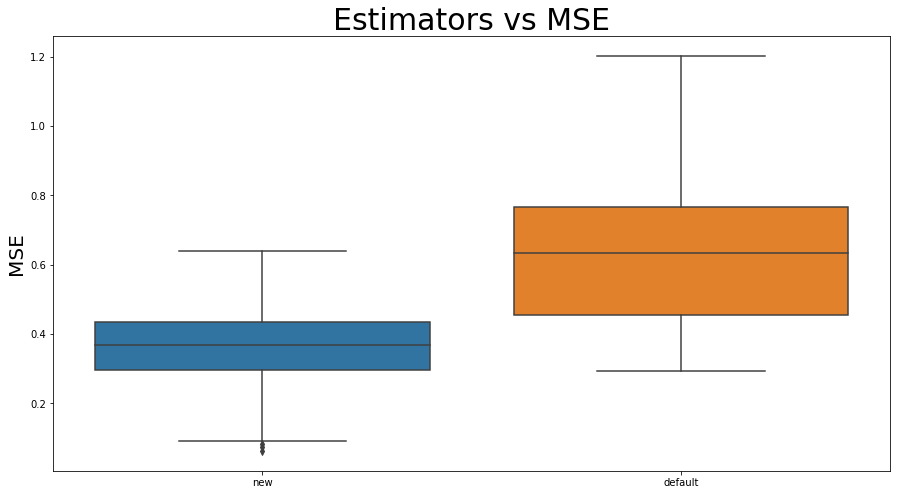

In [ ]:
GB_params = GB_res.best_params

models_GB = {}
'''models_GB['old'] = GradientBoostingRegressor(n_estimators = 200,
                                      learning_rate = 0.5,
                                      max_depth = 15,
                                      min_samples_leaf = 1,
                                      min_samples_split = 3)
'''
models_GB['new'] = GradientBoostingRegressor(**GB_params, n_estimators = 500)

models_GB['default'] = GradientBoostingRegressor()

results_GB = train_and_test_regressor(models_GB, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_GB)

In [ ]:
optuna.visualization.plot_param_importances(GB_res)

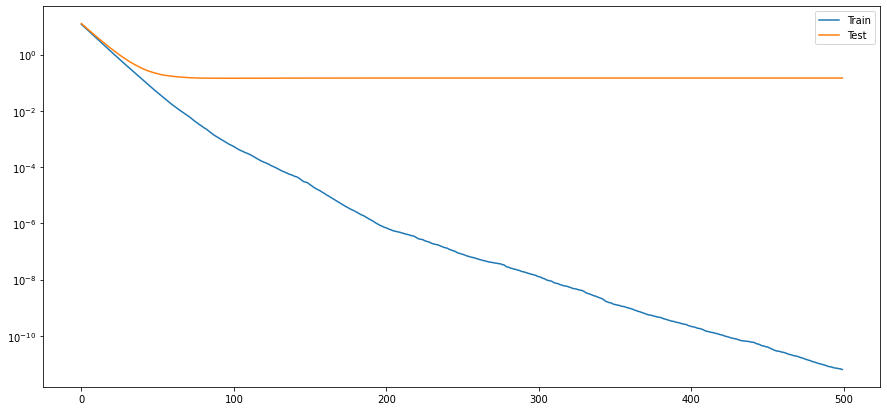

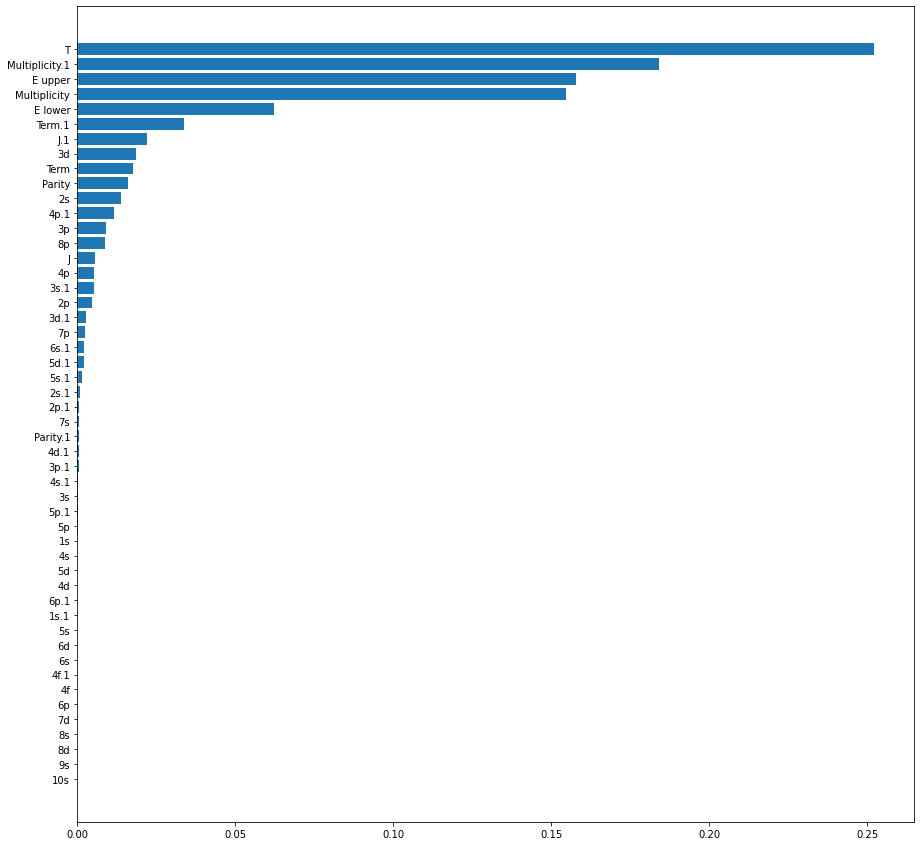

In [ ]:
test_score = np.zeros((500))
for i, y_pred in enumerate(models_GB['new'].staged_predict(XS_test)):
    test_score[i] = models_GB['new'].loss_(YS_test, y_pred)
plt.figure(figsize = (15, 7))
plt.plot(models_GB['new'].train_score_, label = 'Train')
plt.plot(test_score, label = 'Test')
plt.semilogy()
plt.legend()
plt.show()

feature_importance = models_GB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XS_train.columns)[sorted])
plt.show()

## XGBoost

In [ ]:
XGB_params = {
    'n_estimators' : 500,
    'learning_rate' : [0.01, 0.5],
    'max_depth' : [1, 15],
    'min_child_weight' : [1, 15],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = XGBoost

XGB_res = main(X = XS_train, y = YS_train, model_name = model_name, params = XGB_params, n_trials = 500)

'''with open(f'XGB_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)
'''
with open(f'XGB_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(XGB_res.best_params, fp)

[I 2022-05-13 19:54:19,115] A new study created in memory with name: no-name-9cde6fa4-6c8e-4f8d-b419-0d3afbafc065


Start hyperparameter optimization
{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.48810179588552977, 'min_child_weight': 10, 'reg_alpha': 0.0027314860464635886, 'reg_lambda': 7.5575114031012645e-06}
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.18631481460057434, 'min_child_weight': 10, 'reg_alpha': 1.0968661103952042, 'reg_lambda': 0.0001490025848057158}


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-05-13 19:54:21,851] Trial 1 finished with value: 1.1193479161261286 and parameters: {'max_depth': 5, 'learning_rate': 0.18631481460057434, 'min_child_weight': 10, 'reg_alpha': 1.0968661103952042, 'reg_lambda': 0.0001490025848057158}. Best is trial 1 with value: 1.1193479161261286.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.3224899222168096, 'min_child_weight': 1, 'reg_alpha': 1.0498643689754571e-05, 'reg_lambda': 0.6638236468295681}


[I 2022-05-13 19:54:23,563] Trial 2 finished with value: 1.058269810357819 and parameters: {'max_depth': 11, 'learning_rate': 0.3224899222168096, 'min_child_weight': 1, 'reg_alpha': 1.0498643689754571e-05, 'reg_lambda': 0.6638236468295681}. Best is trial 2 with value: 1.058269810357819.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.07544411751733753, 'min_child_weight': 5, 'reg_alpha': 0.3530303716512795, 'reg_lambda': 9.71968638666302e-05}


[I 2022-05-13 19:54:24,891] Trial 0 finished with value: 1.182554456168194 and parameters: {'max_depth': 15, 'learning_rate': 0.48810179588552977, 'min_child_weight': 10, 'reg_alpha': 0.0027314860464635886, 'reg_lambda': 7.5575114031012645e-06}. Best is trial 2 with value: 1.058269810357819.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.12112510935228862, 'min_child_weight': 2, 'reg_alpha': 4.399414085815424e-07, 'reg_lambda': 1.7149611317639757e-06}


[I 2022-05-13 19:54:28,050] Trial 4 finished with value: 0.8415769055591072 and parameters: {'max_depth': 4, 'learning_rate': 0.12112510935228862, 'min_child_weight': 2, 'reg_alpha': 4.399414085815424e-07, 'reg_lambda': 1.7149611317639757e-06}. Best is trial 4 with value: 0.8415769055591072.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1427238800882572, 'min_child_weight': 8, 'reg_alpha': 2.911028345373335e-05, 'reg_lambda': 0.08782397309407902}


[I 2022-05-13 19:54:28,332] Trial 3 finished with value: 1.0647360653071423 and parameters: {'max_depth': 7, 'learning_rate': 0.07544411751733753, 'min_child_weight': 5, 'reg_alpha': 0.3530303716512795, 'reg_lambda': 9.71968638666302e-05}. Best is trial 4 with value: 0.8415769055591072.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.03642641995345395, 'min_child_weight': 13, 'reg_alpha': 9.375044596068276e-06, 'reg_lambda': 0.0020655503487972482}


[I 2022-05-13 19:54:30,443] Trial 5 finished with value: 1.0623906353742862 and parameters: {'max_depth': 2, 'learning_rate': 0.1427238800882572, 'min_child_weight': 8, 'reg_alpha': 2.911028345373335e-05, 'reg_lambda': 0.08782397309407902}. Best is trial 4 with value: 0.8415769055591072.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.23326621021737445, 'min_child_weight': 1, 'reg_alpha': 0.00032777198062949355, 'reg_lambda': 6.786848285020343e-05}


[I 2022-05-13 19:54:32,659] Trial 7 finished with value: 1.0211859572721294 and parameters: {'max_depth': 2, 'learning_rate': 0.23326621021737445, 'min_child_weight': 1, 'reg_alpha': 0.00032777198062949355, 'reg_lambda': 6.786848285020343e-05}. Best is trial 4 with value: 0.8415769055591072.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.4395865779661682, 'min_child_weight': 8, 'reg_alpha': 2.3597785920465282e-08, 'reg_lambda': 0.004558442545024534}


[I 2022-05-13 19:54:34,981] Trial 8 finished with value: 0.928150252592528 and parameters: {'max_depth': 3, 'learning_rate': 0.4395865779661682, 'min_child_weight': 8, 'reg_alpha': 2.3597785920465282e-08, 'reg_lambda': 0.004558442545024534}. Best is trial 4 with value: 0.8415769055591072.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2534291241753091, 'min_child_weight': 10, 'reg_alpha': 3.7567433266009955e-06, 'reg_lambda': 0.7261383778522649}


[I 2022-05-13 19:54:35,671] Trial 6 finished with value: 1.1767216793563862 and parameters: {'max_depth': 12, 'learning_rate': 0.03642641995345395, 'min_child_weight': 13, 'reg_alpha': 9.375044596068276e-06, 'reg_lambda': 0.0020655503487972482}. Best is trial 4 with value: 0.8415769055591072.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3238694680618215, 'min_child_weight': 2, 'reg_alpha': 2.470497104407308e-07, 'reg_lambda': 0.021928230458879476}


[I 2022-05-13 19:54:38,023] Trial 9 finished with value: 1.0066810973951104 and parameters: {'max_depth': 4, 'learning_rate': 0.2534291241753091, 'min_child_weight': 10, 'reg_alpha': 3.7567433266009955e-06, 'reg_lambda': 0.7261383778522649}. Best is trial 4 with value: 0.8415769055591072.
[I 2022-05-13 19:54:38,231] Trial 10 finished with value: 0.8268483629059347 and parameters: {'max_depth': 4, 'learning_rate': 0.3238694680618215, 'min_child_weight': 2, 'reg_alpha': 2.470497104407308e-07, 'reg_lambda': 0.021928230458879476}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.36348694089078026, 'min_child_weight': 4, 'reg_alpha': 1.2338966632471569e-08, 'reg_lambda': 2.8858826287828004e-08}
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.3301973324802613, 'min_child_weight': 4, 'reg_alpha': 1.6553274019665492e-08, 'reg_lambda': 5.575603681113203e-08}


[I 2022-05-13 19:54:41,569] Trial 11 finished with value: 1.2395972016862413 and parameters: {'max_depth': 8, 'learning_rate': 0.36348694089078026, 'min_child_weight': 4, 'reg_alpha': 1.2338966632471569e-08, 'reg_lambda': 2.8858826287828004e-08}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3202604468448294, 'min_child_weight': 4, 'reg_alpha': 2.78447856555162e-07, 'reg_lambda': 5.55299629648212e-07}


[I 2022-05-13 19:54:41,829] Trial 12 finished with value: 1.1435758515983385 and parameters: {'max_depth': 7, 'learning_rate': 0.3301973324802613, 'min_child_weight': 4, 'reg_alpha': 1.6553274019665492e-08, 'reg_lambda': 5.575603681113203e-08}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.12089257571690433, 'min_child_weight': 2, 'reg_alpha': 5.146083271551419e-07, 'reg_lambda': 1.668593103072119e-06}


[I 2022-05-13 19:54:45,053] Trial 13 finished with value: 1.2297077757347052 and parameters: {'max_depth': 6, 'learning_rate': 0.3202604468448294, 'min_child_weight': 4, 'reg_alpha': 2.78447856555162e-07, 'reg_lambda': 5.55299629648212e-07}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.12856030025656126, 'min_child_weight': 2, 'reg_alpha': 4.553306873665932e-07, 'reg_lambda': 3.302060330711042e-06}


[I 2022-05-13 19:54:45,788] Trial 14 finished with value: 0.8636312973419576 and parameters: {'max_depth': 5, 'learning_rate': 0.12089257571690433, 'min_child_weight': 2, 'reg_alpha': 5.146083271551419e-07, 'reg_lambda': 1.668593103072119e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.1961706501676868, 'min_child_weight': 15, 'reg_alpha': 0.022760118807762922, 'reg_lambda': 0.016904890805290406}


[I 2022-05-13 19:54:46,270] Trial 15 finished with value: 1.8306109622402236 and parameters: {'max_depth': 1, 'learning_rate': 0.12856030025656126, 'min_child_weight': 2, 'reg_alpha': 4.553306873665932e-07, 'reg_lambda': 3.302060330711042e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.014887510937750564, 'min_child_weight': 6, 'reg_alpha': 0.0023237642560337366, 'reg_lambda': 0.01593364237040068}


[I 2022-05-13 19:54:46,975] Trial 16 finished with value: 1.53523297752067 and parameters: {'max_depth': 1, 'learning_rate': 0.1961706501676868, 'min_child_weight': 15, 'reg_alpha': 0.022760118807762922, 'reg_lambda': 0.016904890805290406}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.3947207971037955, 'min_child_weight': 6, 'reg_alpha': 0.00014292159820364163, 'reg_lambda': 6.153919547167211}


[I 2022-05-13 19:54:52,546] Trial 18 finished with value: 1.193921347940275 and parameters: {'max_depth': 10, 'learning_rate': 0.3947207971037955, 'min_child_weight': 6, 'reg_alpha': 0.00014292159820364163, 'reg_lambda': 6.153919547167211}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.2809320371987557, 'min_child_weight': 3, 'reg_alpha': 1.5019155093242065e-07, 'reg_lambda': 0.001443577186963774}


[I 2022-05-13 19:54:52,822] Trial 17 finished with value: 1.3069310390682887 and parameters: {'max_depth': 9, 'learning_rate': 0.014887510937750564, 'min_child_weight': 6, 'reg_alpha': 0.0023237642560337366, 'reg_lambda': 0.01593364237040068}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2852923009303153, 'min_child_weight': 3, 'reg_alpha': 1.6474609213002035e-07, 'reg_lambda': 0.0009728270984461057}


[I 2022-05-13 19:54:55,895] Trial 20 finished with value: 1.0196119859480122 and parameters: {'max_depth': 4, 'learning_rate': 0.2852923009303153, 'min_child_weight': 3, 'reg_alpha': 1.6474609213002035e-07, 'reg_lambda': 0.0009728270984461057}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.20738018994367013, 'min_child_weight': 6, 'reg_alpha': 3.172715816973398e-06, 'reg_lambda': 2.7234991623726434e-07}


[I 2022-05-13 19:54:56,288] Trial 19 finished with value: 1.1356489443653106 and parameters: {'max_depth': 9, 'learning_rate': 0.2809320371987557, 'min_child_weight': 3, 'reg_alpha': 1.5019155093242065e-07, 'reg_lambda': 0.001443577186963774}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.11562853971312331, 'min_child_weight': 1, 'reg_alpha': 1.2833591379039938e-06, 'reg_lambda': 6.102543656679595e-07}


[I 2022-05-13 19:54:58,283] Trial 21 finished with value: 1.0050013480045965 and parameters: {'max_depth': 3, 'learning_rate': 0.20738018994367013, 'min_child_weight': 6, 'reg_alpha': 3.172715816973398e-06, 'reg_lambda': 2.7234991623726434e-07}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.12596861207433552, 'min_child_weight': 1, 'reg_alpha': 1.1536079039861016e-06, 'reg_lambda': 9.908878939554179e-06}


[I 2022-05-13 19:54:58,927] Trial 22 finished with value: 0.8802248658483773 and parameters: {'max_depth': 5, 'learning_rate': 0.11562853971312331, 'min_child_weight': 1, 'reg_alpha': 1.2833591379039938e-06, 'reg_lambda': 6.102543656679595e-07}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.07673293891479477, 'min_child_weight': 2, 'reg_alpha': 9.017159452087532e-08, 'reg_lambda': 2.1881855804362648e-05}


[I 2022-05-13 19:55:00,637] Trial 23 finished with value: 0.8856322672879784 and parameters: {'max_depth': 5, 'learning_rate': 0.12596861207433552, 'min_child_weight': 1, 'reg_alpha': 1.1536079039861016e-06, 'reg_lambda': 9.908878939554179e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.07760199743216012, 'min_child_weight': 3, 'reg_alpha': 6.243864914413292e-08, 'reg_lambda': 1.8157735395288362e-05}


[I 2022-05-13 19:55:02,614] Trial 24 finished with value: 0.8718392289192838 and parameters: {'max_depth': 5, 'learning_rate': 0.07673293891479477, 'min_child_weight': 2, 'reg_alpha': 9.017159452087532e-08, 'reg_lambda': 2.1881855804362648e-05}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.16564760409353152, 'min_child_weight': 3, 'reg_alpha': 4.582233421216345e-05, 'reg_lambda': 1.8981208491316749e-06}


[I 2022-05-13 19:55:05,033] Trial 25 finished with value: 1.1211135980017317 and parameters: {'max_depth': 6, 'learning_rate': 0.07760199743216012, 'min_child_weight': 3, 'reg_alpha': 6.243864914413292e-08, 'reg_lambda': 1.8157735395288362e-05}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16897653533334728, 'min_child_weight': 5, 'reg_alpha': 2.728652236285466e-05, 'reg_lambda': 1.1595293102672978e-08}


[I 2022-05-13 19:55:07,113] Trial 26 finished with value: 1.1248794931805064 and parameters: {'max_depth': 7, 'learning_rate': 0.16564760409353152, 'min_child_weight': 3, 'reg_alpha': 4.582233421216345e-05, 'reg_lambda': 1.8981208491316749e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.4067725039177807, 'min_child_weight': 5, 'reg_alpha': 1.2701259629324705e-06, 'reg_lambda': 0.1605009255146556}


[I 2022-05-13 19:55:07,485] Trial 27 finished with value: 0.9942202367999192 and parameters: {'max_depth': 3, 'learning_rate': 0.16897653533334728, 'min_child_weight': 5, 'reg_alpha': 2.728652236285466e-05, 'reg_lambda': 1.1595293102672978e-08}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.37810052288498686, 'min_child_weight': 2, 'reg_alpha': 7.134199482057983e-07, 'reg_lambda': 0.0004023247115404958}


[I 2022-05-13 19:55:09,532] Trial 28 finished with value: 0.9913018902622861 and parameters: {'max_depth': 3, 'learning_rate': 0.4067725039177807, 'min_child_weight': 5, 'reg_alpha': 1.2701259629324705e-06, 'reg_lambda': 0.1605009255146556}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.46913788629672326, 'min_child_weight': 7, 'reg_alpha': 0.001066448914712938, 'reg_lambda': 1.8915489572198501e-07}


[I 2022-05-13 19:55:09,753] Trial 29 finished with value: 0.8524842566659581 and parameters: {'max_depth': 4, 'learning_rate': 0.37810052288498686, 'min_child_weight': 2, 'reg_alpha': 7.134199482057983e-07, 'reg_lambda': 0.0004023247115404958}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.48609603882941677, 'min_child_weight': 7, 'reg_alpha': 0.001406183676298029, 'reg_lambda': 0.0004243275613354001}


[I 2022-05-13 19:55:13,711] Trial 30 finished with value: 1.190135321989305 and parameters: {'max_depth': 15, 'learning_rate': 0.46913788629672326, 'min_child_weight': 7, 'reg_alpha': 0.001066448914712938, 'reg_lambda': 1.8915489572198501e-07}. Best is trial 10 with value: 0.8268483629059347.
[I 2022-05-13 19:55:13,775] Trial 31 finished with value: 1.2965964656375166 and parameters: {'max_depth': 13, 'learning_rate': 0.48609603882941677, 'min_child_weight': 7, 'reg_alpha': 0.001406183676298029, 'reg_lambda': 0.0004243275613354001}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.37242115800309716, 'min_child_weight': 2, 'reg_alpha': 4.9201193982833435e-08, 'reg_lambda': 2.0345605036828093e-06}
{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.4333394171512672, 'min_child_weight': 2, 'reg_alpha': 6.193242941658867e-07, 'reg_lambda': 4.215859429504867e-06}


[I 2022-05-13 19:55:15,787] Trial 33 finished with value: 0.8374669764104044 and parameters: {'max_depth': 4, 'learning_rate': 0.4333394171512672, 'min_child_weight': 2, 'reg_alpha': 6.193242941658867e-07, 'reg_lambda': 4.215859429504867e-06}. Best is trial 10 with value: 0.8268483629059347.
[I 2022-05-13 19:55:15,832] Trial 32 finished with value: 0.8709064063084961 and parameters: {'max_depth': 4, 'learning_rate': 0.37242115800309716, 'min_child_weight': 2, 'reg_alpha': 4.9201193982833435e-08, 'reg_lambda': 2.0345605036828093e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.36705310425321114, 'min_child_weight': 2, 'reg_alpha': 6.092206387273873e-08, 'reg_lambda': 0.0002872937708724811}
{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.43236439732623755, 'min_child_weight': 1, 'reg_alpha': 5.82478775863363e-06, 'reg_lambda': 5.695198631781947e-05}


[I 2022-05-13 19:55:17,527] Trial 35 finished with value: 1.07914639753213 and parameters: {'max_depth': 2, 'learning_rate': 0.43236439732623755, 'min_child_weight': 1, 'reg_alpha': 5.82478775863363e-06, 'reg_lambda': 5.695198631781947e-05}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.349894273712497, 'min_child_weight': 4, 'reg_alpha': 0.013609947781362774, 'reg_lambda': 0.0003269985454872034}


[I 2022-05-13 19:55:18,050] Trial 34 finished with value: 0.8744717826771918 and parameters: {'max_depth': 4, 'learning_rate': 0.36705310425321114, 'min_child_weight': 2, 'reg_alpha': 6.092206387273873e-08, 'reg_lambda': 0.0002872937708724811}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.32984912523537546, 'min_child_weight': 11, 'reg_alpha': 1.0129413577360509, 'reg_lambda': 0.012970081841290676}


[I 2022-05-13 19:55:19,831] Trial 37 finished with value: 1.1072876279745791 and parameters: {'max_depth': 6, 'learning_rate': 0.32984912523537546, 'min_child_weight': 11, 'reg_alpha': 1.0129413577360509, 'reg_lambda': 0.012970081841290676}. Best is trial 10 with value: 0.8268483629059347.
[I 2022-05-13 19:55:19,999] Trial 36 finished with value: 1.1835412619754093 and parameters: {'max_depth': 6, 'learning_rate': 0.349894273712497, 'min_child_weight': 4, 'reg_alpha': 0.013609947781362774, 'reg_lambda': 0.0003269985454872034}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.44306759619195113, 'min_child_weight': 4, 'reg_alpha': 9.025198648965702, 'reg_lambda': 0.08410531129099585}
{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.4431282470970305, 'min_child_weight': 9, 'reg_alpha': 1.7336218974674583e-05, 'reg_lambda': 0.07511257567351187}


[I 2022-05-13 19:55:20,961] Trial 38 finished with value: 1.606260127434176 and parameters: {'max_depth': 2, 'learning_rate': 0.44306759619195113, 'min_child_weight': 4, 'reg_alpha': 9.025198648965702, 'reg_lambda': 0.08410531129099585}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.40194197235327683, 'min_child_weight': 9, 'reg_alpha': 2.514279727530922e-05, 'reg_lambda': 3.706011822897525e-05}


[I 2022-05-13 19:55:21,691] Trial 39 finished with value: 1.0233041134127023 and parameters: {'max_depth': 2, 'learning_rate': 0.4431282470970305, 'min_child_weight': 9, 'reg_alpha': 1.7336218974674583e-05, 'reg_lambda': 0.07511257567351187}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.3012253994521355, 'min_child_weight': 1, 'reg_alpha': 2.315632620195499e-06, 'reg_lambda': 9.859352957362941e-05}


[I 2022-05-13 19:55:22,149] Trial 40 finished with value: 1.409589600337598 and parameters: {'max_depth': 1, 'learning_rate': 0.40194197235327683, 'min_child_weight': 9, 'reg_alpha': 2.514279727530922e-05, 'reg_lambda': 3.706011822897525e-05}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2987711320560844, 'min_child_weight': 2, 'reg_alpha': 7.478114011992839e-07, 'reg_lambda': 3.886096473662858e-06}


[I 2022-05-13 19:55:23,238] Trial 41 finished with value: 0.869644199329727 and parameters: {'max_depth': 8, 'learning_rate': 0.3012253994521355, 'min_child_weight': 1, 'reg_alpha': 2.315632620195499e-06, 'reg_lambda': 9.859352957362941e-05}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.10225231320701038, 'min_child_weight': 2, 'reg_alpha': 4.484470247622675e-07, 'reg_lambda': 4.687408241271145e-06}


[I 2022-05-13 19:55:24,641] Trial 42 finished with value: 0.8743999496221828 and parameters: {'max_depth': 4, 'learning_rate': 0.2987711320560844, 'min_child_weight': 2, 'reg_alpha': 7.478114011992839e-07, 'reg_lambda': 3.886096473662858e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.23671822689242028, 'min_child_weight': 3, 'reg_alpha': 3.568283202908422e-07, 'reg_lambda': 6.985105424287652e-06}


[I 2022-05-13 19:55:26,107] Trial 43 finished with value: 0.8656475370413588 and parameters: {'max_depth': 4, 'learning_rate': 0.10225231320701038, 'min_child_weight': 2, 'reg_alpha': 4.484470247622675e-07, 'reg_lambda': 4.687408241271145e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.24047025247987555, 'min_child_weight': 3, 'reg_alpha': 2.82514099040083e-07, 'reg_lambda': 5.916473234138573e-07}


[I 2022-05-13 19:55:27,801] Trial 44 finished with value: 1.0193219997580603 and parameters: {'max_depth': 5, 'learning_rate': 0.23671822689242028, 'min_child_weight': 3, 'reg_alpha': 3.568283202908422e-07, 'reg_lambda': 6.985105424287652e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.21734495226878225, 'min_child_weight': 1, 'reg_alpha': 3.3067685107423965e-08, 'reg_lambda': 1.0215454578079133e-06}


[I 2022-05-13 19:55:29,713] Trial 45 finished with value: 1.0685191799466494 and parameters: {'max_depth': 5, 'learning_rate': 0.24047025247987555, 'min_child_weight': 3, 'reg_alpha': 2.82514099040083e-07, 'reg_lambda': 5.916473234138573e-07}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15927454911483294, 'min_child_weight': 2, 'reg_alpha': 3.0725414434405306e-08, 'reg_lambda': 7.590150565218242e-08}


[I 2022-05-13 19:55:30,884] Trial 46 finished with value: 0.8819282283759801 and parameters: {'max_depth': 3, 'learning_rate': 0.21734495226878225, 'min_child_weight': 1, 'reg_alpha': 3.3067685107423965e-08, 'reg_lambda': 1.0215454578079133e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.26706793178283605, 'min_child_weight': 12, 'reg_alpha': 5.104382678009404e-06, 'reg_lambda': 7.749266719965263e-08}


[I 2022-05-13 19:55:32,328] Trial 47 finished with value: 0.8668687356541014 and parameters: {'max_depth': 3, 'learning_rate': 0.15927454911483294, 'min_child_weight': 2, 'reg_alpha': 3.0725414434405306e-08, 'reg_lambda': 7.590150565218242e-08}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.02989951600941884, 'min_child_weight': 13, 'reg_alpha': 7.747679274257762e-05, 'reg_lambda': 0.004819356895129956}


[I 2022-05-13 19:55:35,524] Trial 48 finished with value: 1.0211470266759795 and parameters: {'max_depth': 7, 'learning_rate': 0.26706793178283605, 'min_child_weight': 12, 'reg_alpha': 5.104382678009404e-06, 'reg_lambda': 7.749266719965263e-08}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.043484222038568957, 'min_child_weight': 4, 'reg_alpha': 0.00010798817108472303, 'reg_lambda': 0.28626002907252374}


[I 2022-05-13 19:55:37,071] Trial 49 finished with value: 1.2466510206265042 and parameters: {'max_depth': 7, 'learning_rate': 0.02989951600941884, 'min_child_weight': 13, 'reg_alpha': 7.747679274257762e-05, 'reg_lambda': 0.004819356895129956}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3840260476960918, 'min_child_weight': 4, 'reg_alpha': 1.0286935576742891e-08, 'reg_lambda': 3.3335824905634164}


[I 2022-05-13 19:55:39,872] Trial 50 finished with value: 1.2304909783687377 and parameters: {'max_depth': 6, 'learning_rate': 0.043484222038568957, 'min_child_weight': 4, 'reg_alpha': 0.00010798817108472303, 'reg_lambda': 0.28626002907252374}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1041685473872033, 'min_child_weight': 2, 'reg_alpha': 1.1333766479699147e-08, 'reg_lambda': 9.990608282367929e-06}


[I 2022-05-13 19:55:40,689] Trial 51 finished with value: 1.207993665334075 and parameters: {'max_depth': 6, 'learning_rate': 0.3840260476960918, 'min_child_weight': 4, 'reg_alpha': 1.0286935576742891e-08, 'reg_lambda': 3.3335824905634164}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.10192511777302758, 'min_child_weight': 2, 'reg_alpha': 5.254009400207838e-07, 'reg_lambda': 6.979276484511826e-06}


[I 2022-05-13 19:55:42,911] Trial 52 finished with value: 0.852812657611603 and parameters: {'max_depth': 4, 'learning_rate': 0.1041685473872033, 'min_child_weight': 2, 'reg_alpha': 1.1333766479699147e-08, 'reg_lambda': 9.990608282367929e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.09186497180743039, 'min_child_weight': 5, 'reg_alpha': 1.6597473578712855e-07, 'reg_lambda': 1.3237906312534196e-05}


[I 2022-05-13 19:55:43,764] Trial 53 finished with value: 0.8647086758135023 and parameters: {'max_depth': 4, 'learning_rate': 0.10192511777302758, 'min_child_weight': 2, 'reg_alpha': 5.254009400207838e-07, 'reg_lambda': 6.979276484511826e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05708151380873416, 'min_child_weight': 1, 'reg_alpha': 1.5617844232852776e-07, 'reg_lambda': 1.9977416979948878e-07}


[I 2022-05-13 19:55:46,619] Trial 54 finished with value: 1.0402245508851875 and parameters: {'max_depth': 5, 'learning_rate': 0.09186497180743039, 'min_child_weight': 5, 'reg_alpha': 1.6597473578712855e-07, 'reg_lambda': 1.3237906312534196e-05}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.05608763171557199, 'min_child_weight': 3, 'reg_alpha': 1.328769730841311e-07, 'reg_lambda': 2.3872466590967087e-07}


[I 2022-05-13 19:55:47,899] Trial 55 finished with value: 0.875577897839233 and parameters: {'max_depth': 5, 'learning_rate': 0.05708151380873416, 'min_child_weight': 1, 'reg_alpha': 1.5617844232852776e-07, 'reg_lambda': 1.9977416979948878e-07}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.14704598815317893, 'min_child_weight': 3, 'reg_alpha': 8.018619296678716e-06, 'reg_lambda': 1.740367612455554e-06}


[I 2022-05-13 19:55:49,013] Trial 56 finished with value: 1.0155309743261833 and parameters: {'max_depth': 3, 'learning_rate': 0.05608763171557199, 'min_child_weight': 3, 'reg_alpha': 1.328769730841311e-07, 'reg_lambda': 2.3872466590967087e-07}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.42009038928918185, 'min_child_weight': 3, 'reg_alpha': 1.1764526836701712e-05, 'reg_lambda': 1.5445562561029983e-06}


[I 2022-05-13 19:55:49,675] Trial 57 finished with value: 1.136725627088067 and parameters: {'max_depth': 2, 'learning_rate': 0.14704598815317893, 'min_child_weight': 3, 'reg_alpha': 8.018619296678716e-06, 'reg_lambda': 1.740367612455554e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.35144900082830705, 'min_child_weight': 1, 'reg_alpha': 2.111866813875107e-06, 'reg_lambda': 2.5556533179042587e-05}


[I 2022-05-13 19:55:50,832] Trial 58 finished with value: 1.023889972948154 and parameters: {'max_depth': 2, 'learning_rate': 0.42009038928918185, 'min_child_weight': 3, 'reg_alpha': 1.1764526836701712e-05, 'reg_lambda': 1.5445562561029983e-06}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.34965547104833944, 'min_child_weight': 1, 'reg_alpha': 1.9357398849190293e-06, 'reg_lambda': 0.00014282128191658533}


[I 2022-05-13 19:55:51,374] Trial 59 finished with value: 0.8686870195506339 and parameters: {'max_depth': 4, 'learning_rate': 0.35144900082830705, 'min_child_weight': 1, 'reg_alpha': 2.111866813875107e-06, 'reg_lambda': 2.5556533179042587e-05}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19137419635666894, 'min_child_weight': 2, 'reg_alpha': 1.943442859013367e-08, 'reg_lambda': 0.00579261169264214}


[I 2022-05-13 19:55:52,488] Trial 60 finished with value: 0.8951354073705133 and parameters: {'max_depth': 4, 'learning_rate': 0.34965547104833944, 'min_child_weight': 1, 'reg_alpha': 1.9357398849190293e-06, 'reg_lambda': 0.00014282128191658533}. Best is trial 10 with value: 0.8268483629059347.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.11365355519459032, 'min_child_weight': 2, 'reg_alpha': 1.9935870039038014e-08, 'reg_lambda': 8.759015689327508e-06}


[I 2022-05-13 19:55:53,589] Trial 61 finished with value: 0.8092807051759967 and parameters: {'max_depth': 3, 'learning_rate': 0.19137419635666894, 'min_child_weight': 2, 'reg_alpha': 1.943442859013367e-08, 'reg_lambda': 0.00579261169264214}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.12726359872584325, 'min_child_weight': 2, 'reg_alpha': 1.8605060913867132e-08, 'reg_lambda': 0.0035583400421878}


[I 2022-05-13 19:55:54,840] Trial 62 finished with value: 0.8620878393964502 and parameters: {'max_depth': 3, 'learning_rate': 0.11365355519459032, 'min_child_weight': 2, 'reg_alpha': 1.9935870039038014e-08, 'reg_lambda': 8.759015689327508e-06}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18816748406009154, 'min_child_weight': 2, 'reg_alpha': 2.0213999936044805e-08, 'reg_lambda': 0.0038259202435754363}


[I 2022-05-13 19:55:55,862] Trial 63 finished with value: 0.8722121711057182 and parameters: {'max_depth': 3, 'learning_rate': 0.12726359872584325, 'min_child_weight': 2, 'reg_alpha': 1.8605060913867132e-08, 'reg_lambda': 0.0035583400421878}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.14614410334788458, 'min_child_weight': 2, 'reg_alpha': 1.7124024380331706e-08, 'reg_lambda': 0.031612066927142767}


[I 2022-05-13 19:55:56,981] Trial 65 finished with value: 1.8206311626719198 and parameters: {'max_depth': 1, 'learning_rate': 0.14614410334788458, 'min_child_weight': 2, 'reg_alpha': 1.7124024380331706e-08, 'reg_lambda': 0.031612066927142767}. Best is trial 61 with value: 0.8092807051759967.
[I 2022-05-13 19:55:57,081] Trial 64 finished with value: 0.8581190778970094 and parameters: {'max_depth': 3, 'learning_rate': 0.18816748406009154, 'min_child_weight': 2, 'reg_alpha': 2.0213999936044805e-08, 'reg_lambda': 0.0038259202435754363}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18252250881887305, 'min_child_weight': 3, 'reg_alpha': 4.880938270968305e-08, 'reg_lambda': 0.007732779508472258}
{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.18866454389508677, 'min_child_weight': 3, 'reg_alpha': 7.233722706742026e-08, 'reg_lambda': 0.0006593919299213864}


[I 2022-05-13 19:55:58,676] Trial 67 finished with value: 1.105357752910436 and parameters: {'max_depth': 2, 'learning_rate': 0.18866454389508677, 'min_child_weight': 3, 'reg_alpha': 7.233722706742026e-08, 'reg_lambda': 0.0006593919299213864}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.21464523464464363, 'min_child_weight': 1, 'reg_alpha': 3.911140427481089e-08, 'reg_lambda': 0.007523252867277233}


[I 2022-05-13 19:55:59,073] Trial 66 finished with value: 0.9378569023353183 and parameters: {'max_depth': 3, 'learning_rate': 0.18252250881887305, 'min_child_weight': 3, 'reg_alpha': 4.880938270968305e-08, 'reg_lambda': 0.007732779508472258}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.456615005219097, 'min_child_weight': 5, 'reg_alpha': 9.003719905268872e-07, 'reg_lambda': 0.002079605793424739}


[I 2022-05-13 19:56:00,665] Trial 68 finished with value: 0.872515480133855 and parameters: {'max_depth': 4, 'learning_rate': 0.21464523464464363, 'min_child_weight': 1, 'reg_alpha': 3.911140427481089e-08, 'reg_lambda': 0.007523252867277233}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.4631649368500862, 'min_child_weight': 4, 'reg_alpha': 1.098492378638087e-08, 'reg_lambda': 0.0017582513659876679}


[I 2022-05-13 19:56:01,996] Trial 69 finished with value: 0.9981079483168946 and parameters: {'max_depth': 5, 'learning_rate': 0.456615005219097, 'min_child_weight': 5, 'reg_alpha': 9.003719905268872e-07, 'reg_lambda': 0.002079605793424739}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.4981812424651621, 'min_child_weight': 4, 'reg_alpha': 1.1148002443126119e-08, 'reg_lambda': 0.0013793622706526228}


[I 2022-05-13 19:56:03,938] Trial 70 finished with value: 1.2658481671178048 and parameters: {'max_depth': 11, 'learning_rate': 0.4631649368500862, 'min_child_weight': 4, 'reg_alpha': 1.098492378638087e-08, 'reg_lambda': 0.0017582513659876679}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1104057241241031, 'min_child_weight': 2, 'reg_alpha': 1.0370452248961188e-07, 'reg_lambda': 0.05349037126705386}


[I 2022-05-13 19:56:04,884] Trial 71 finished with value: 1.0087136927601672 and parameters: {'max_depth': 4, 'learning_rate': 0.4981812424651621, 'min_child_weight': 4, 'reg_alpha': 1.1148002443126119e-08, 'reg_lambda': 0.0013793622706526228}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.08375752811882282, 'min_child_weight': 2, 'reg_alpha': 7.962915835863319e-08, 'reg_lambda': 0.028157092877849187}


[I 2022-05-13 19:56:06,495] Trial 72 finished with value: 0.8750442848578756 and parameters: {'max_depth': 3, 'learning_rate': 0.1104057241241031, 'min_child_weight': 2, 'reg_alpha': 1.0370452248961188e-07, 'reg_lambda': 0.05349037126705386}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.08785855275316079, 'min_child_weight': 2, 'reg_alpha': 2.4458231709754083e-08, 'reg_lambda': 6.244053561727638e-05}


[I 2022-05-13 19:56:07,199] Trial 73 finished with value: 0.8613964397071652 and parameters: {'max_depth': 3, 'learning_rate': 0.08375752811882282, 'min_child_weight': 2, 'reg_alpha': 7.962915835863319e-08, 'reg_lambda': 0.028157092877849187}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.07880851379128137, 'min_child_weight': 1, 'reg_alpha': 1.7292343077652809e-07, 'reg_lambda': 0.04273673717396422}


[I 2022-05-13 19:56:08,080] Trial 74 finished with value: 1.0599108876429966 and parameters: {'max_depth': 2, 'learning_rate': 0.08785855275316079, 'min_child_weight': 2, 'reg_alpha': 2.4458231709754083e-08, 'reg_lambda': 6.244053561727638e-05}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.2573330298205425, 'min_child_weight': 1, 'reg_alpha': 2.3456380818229496e-07, 'reg_lambda': 0.018285412081650756}


[I 2022-05-13 19:56:08,882] Trial 75 finished with value: 1.0167511959742832 and parameters: {'max_depth': 2, 'learning_rate': 0.07880851379128137, 'min_child_weight': 1, 'reg_alpha': 1.7292343077652809e-07, 'reg_lambda': 0.04273673717396422}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.1377310269053097, 'min_child_weight': 15, 'reg_alpha': 6.674931570159535e-08, 'reg_lambda': 0.02654686330089632}


[I 2022-05-13 19:56:09,318] Trial 76 finished with value: 1.732727009667047 and parameters: {'max_depth': 1, 'learning_rate': 0.2573330298205425, 'min_child_weight': 1, 'reg_alpha': 2.3456380818229496e-07, 'reg_lambda': 0.018285412081650756}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.13600475548534346, 'min_child_weight': 2, 'reg_alpha': 8.791291365690607e-08, 'reg_lambda': 0.0006049489603925981}


[I 2022-05-13 19:56:10,042] Trial 77 finished with value: 1.6418574582507586 and parameters: {'max_depth': 1, 'learning_rate': 0.1377310269053097, 'min_child_weight': 15, 'reg_alpha': 6.674931570159535e-08, 'reg_lambda': 0.02654686330089632}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.4238992169827011, 'min_child_weight': 3, 'reg_alpha': 9.63147939041011e-08, 'reg_lambda': 0.0006939181056930749}


[I 2022-05-13 19:56:11,649] Trial 78 finished with value: 0.8182291091096214 and parameters: {'max_depth': 3, 'learning_rate': 0.13600475548534346, 'min_child_weight': 2, 'reg_alpha': 8.791291365690607e-08, 'reg_lambda': 0.0006049489603925981}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.17930014356565865, 'min_child_weight': 3, 'reg_alpha': 6.188333455252125e-07, 'reg_lambda': 0.0008090738983606029}


[I 2022-05-13 19:56:12,471] Trial 79 finished with value: 0.9470892792985941 and parameters: {'max_depth': 4, 'learning_rate': 0.4238992169827011, 'min_child_weight': 3, 'reg_alpha': 9.63147939041011e-08, 'reg_lambda': 0.0006939181056930749}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.17527547647563727, 'min_child_weight': 3, 'reg_alpha': 6.819710523498079e-07, 'reg_lambda': 0.00017409725357421215}


[I 2022-05-13 19:56:14,621] Trial 80 finished with value: 1.00551400033099 and parameters: {'max_depth': 4, 'learning_rate': 0.17930014356565865, 'min_child_weight': 3, 'reg_alpha': 6.188333455252125e-07, 'reg_lambda': 0.0008090738983606029}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.20460552744492347, 'min_child_weight': 2, 'reg_alpha': 3.215571568704048e-07, 'reg_lambda': 0.0002228352248440206}


[I 2022-05-13 19:56:16,003] Trial 81 finished with value: 1.046684773053071 and parameters: {'max_depth': 5, 'learning_rate': 0.17527547647563727, 'min_child_weight': 3, 'reg_alpha': 6.819710523498079e-07, 'reg_lambda': 0.00017409725357421215}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.200513577751268, 'min_child_weight': 2, 'reg_alpha': 2.7356499836633047e-07, 'reg_lambda': 0.24000720349133228}


[I 2022-05-13 19:56:16,878] Trial 82 finished with value: 0.914583237272853 and parameters: {'max_depth': 3, 'learning_rate': 0.20460552744492347, 'min_child_weight': 2, 'reg_alpha': 3.215571568704048e-07, 'reg_lambda': 0.0002228352248440206}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15850603086050802, 'min_child_weight': 2, 'reg_alpha': 3.063841944703622e-08, 'reg_lambda': 0.009218980033054039}


[I 2022-05-13 19:56:18,469] Trial 83 finished with value: 0.8258001883125627 and parameters: {'max_depth': 3, 'learning_rate': 0.200513577751268, 'min_child_weight': 2, 'reg_alpha': 2.7356499836633047e-07, 'reg_lambda': 0.24000720349133228}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.15486930631922, 'min_child_weight': 2, 'reg_alpha': 2.5585246952577203e-08, 'reg_lambda': 0.9647806123590643}


[I 2022-05-13 19:56:19,240] Trial 84 finished with value: 0.8592230349726911 and parameters: {'max_depth': 3, 'learning_rate': 0.15850603086050802, 'min_child_weight': 2, 'reg_alpha': 3.063841944703622e-08, 'reg_lambda': 0.009218980033054039}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.13681887575446514, 'min_child_weight': 1, 'reg_alpha': 2.5048710981220603e-07, 'reg_lambda': 1.7985836361706777}


[I 2022-05-13 19:56:21,390] Trial 85 finished with value: 0.9022076355907676 and parameters: {'max_depth': 4, 'learning_rate': 0.15486930631922, 'min_child_weight': 2, 'reg_alpha': 2.5585246952577203e-08, 'reg_lambda': 0.9647806123590643}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1932114722422976, 'min_child_weight': 1, 'reg_alpha': 0.00781995143698978, 'reg_lambda': 0.1349760183465192}


[I 2022-05-13 19:56:22,272] Trial 86 finished with value: 0.8914874384815482 and parameters: {'max_depth': 4, 'learning_rate': 0.13681887575446514, 'min_child_weight': 1, 'reg_alpha': 2.5048710981220603e-07, 'reg_lambda': 1.7985836361706777}. Best is trial 61 with value: 0.8092807051759967.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19714614293697802, 'min_child_weight': 1, 'reg_alpha': 0.07452666495388362, 'reg_lambda': 0.00349821642431043}


[I 2022-05-13 19:56:23,807] Trial 87 finished with value: 0.8017694028519984 and parameters: {'max_depth': 3, 'learning_rate': 0.1932114722422976, 'min_child_weight': 1, 'reg_alpha': 0.00781995143698978, 'reg_lambda': 0.1349760183465192}. Best is trial 87 with value: 0.8017694028519984.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.20220767404996684, 'min_child_weight': 1, 'reg_alpha': 0.24076299954761765, 'reg_lambda': 0.7950380884123486}


[I 2022-05-13 19:56:24,044] Trial 88 finished with value: 0.8908929209406843 and parameters: {'max_depth': 3, 'learning_rate': 0.19714614293697802, 'min_child_weight': 1, 'reg_alpha': 0.07452666495388362, 'reg_lambda': 0.00349821642431043}. Best is trial 87 with value: 0.8017694028519984.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2310065991975566, 'min_child_weight': 1, 'reg_alpha': 0.0202309421948752, 'reg_lambda': 0.20639692809052126}


[I 2022-05-13 19:56:25,637] Trial 89 finished with value: 0.9291748904627024 and parameters: {'max_depth': 2, 'learning_rate': 0.20220767404996684, 'min_child_weight': 1, 'reg_alpha': 0.24076299954761765, 'reg_lambda': 0.7950380884123486}. Best is trial 87 with value: 0.8017694028519984.
[I 2022-05-13 19:56:25,782] Trial 90 finished with value: 0.8456242840939223 and parameters: {'max_depth': 5, 'learning_rate': 0.2310065991975566, 'min_child_weight': 1, 'reg_alpha': 0.0202309421948752, 'reg_lambda': 0.20639692809052126}. Best is trial 87 with value: 0.8017694028519984.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3875991500343855, 'min_child_weight': 1, 'reg_alpha': 0.040807000091224704, 'reg_lambda': 0.17714382072631485}
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.22406684806712573, 'min_child_weight': 1, 'reg_alpha': 0.01649015984072242, 'reg_lambda': 0.18789313509900893}


[I 2022-05-13 19:56:27,010] Trial 91 finished with value: 0.9283772217400991 and parameters: {'max_depth': 6, 'learning_rate': 0.3875991500343855, 'min_child_weight': 1, 'reg_alpha': 0.040807000091224704, 'reg_lambda': 0.17714382072631485}. Best is trial 87 with value: 0.8017694028519984.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2275396522858139, 'min_child_weight': 1, 'reg_alpha': 0.004745273883675772, 'reg_lambda': 0.32568749761818105}


[I 2022-05-13 19:56:27,521] Trial 92 finished with value: 0.8766071844972357 and parameters: {'max_depth': 5, 'learning_rate': 0.22406684806712573, 'min_child_weight': 1, 'reg_alpha': 0.01649015984072242, 'reg_lambda': 0.18789313509900893}. Best is trial 87 with value: 0.8017694028519984.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.27722518412638636, 'min_child_weight': 2, 'reg_alpha': 0.0005793916454448547, 'reg_lambda': 0.3516208714956193}


[I 2022-05-13 19:56:28,903] Trial 93 finished with value: 0.8887138440363334 and parameters: {'max_depth': 5, 'learning_rate': 0.2275396522858139, 'min_child_weight': 1, 'reg_alpha': 0.004745273883675772, 'reg_lambda': 0.32568749761818105}. Best is trial 87 with value: 0.8017694028519984.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24590676306525075, 'min_child_weight': 3, 'reg_alpha': 0.006382933688162503, 'reg_lambda': 0.35013825290528666}


[I 2022-05-13 19:56:30,146] Trial 94 finished with value: 0.8324197764795926 and parameters: {'max_depth': 4, 'learning_rate': 0.27722518412638636, 'min_child_weight': 2, 'reg_alpha': 0.0005793916454448547, 'reg_lambda': 0.3516208714956193}. Best is trial 87 with value: 0.8017694028519984.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3079557428075661, 'min_child_weight': 3, 'reg_alpha': 0.00769864492917008, 'reg_lambda': 0.10430720859508816}


[I 2022-05-13 19:56:31,500] Trial 95 finished with value: 0.9997232750065124 and parameters: {'max_depth': 4, 'learning_rate': 0.24590676306525075, 'min_child_weight': 3, 'reg_alpha': 0.006382933688162503, 'reg_lambda': 0.35013825290528666}. Best is trial 87 with value: 0.8017694028519984.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.26968180682120163, 'min_child_weight': 7, 'reg_alpha': 0.05149213764847126, 'reg_lambda': 0.10968672214885837}


[I 2022-05-13 19:56:32,650] Trial 96 finished with value: 0.9772029715115309 and parameters: {'max_depth': 4, 'learning_rate': 0.3079557428075661, 'min_child_weight': 3, 'reg_alpha': 0.00769864492917008, 'reg_lambda': 0.10430720859508816}. Best is trial 87 with value: 0.8017694028519984.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2716164698050654, 'min_child_weight': 2, 'reg_alpha': 0.00040237378378481416, 'reg_lambda': 0.4421999532247444}


[I 2022-05-13 19:56:33,296] Trial 97 finished with value: 0.9884967575526243 and parameters: {'max_depth': 2, 'learning_rate': 0.26968180682120163, 'min_child_weight': 7, 'reg_alpha': 0.05149213764847126, 'reg_lambda': 0.10968672214885837}. Best is trial 87 with value: 0.8017694028519984.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2889453358844444, 'min_child_weight': 2, 'reg_alpha': 0.00017334520149780427, 'reg_lambda': 0.5714459841177494}


[I 2022-05-13 19:56:35,283] Trial 98 finished with value: 0.8823882227018419 and parameters: {'max_depth': 5, 'learning_rate': 0.2716164698050654, 'min_child_weight': 2, 'reg_alpha': 0.00040237378378481416, 'reg_lambda': 0.4421999532247444}. Best is trial 87 with value: 0.8017694028519984.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.333075728627264, 'min_child_weight': 2, 'reg_alpha': 0.0008862310516570015, 'reg_lambda': 1.9951498330645903}


[I 2022-05-13 19:56:35,677] Trial 99 finished with value: 0.7865782868621111 and parameters: {'max_depth': 3, 'learning_rate': 0.2889453358844444, 'min_child_weight': 2, 'reg_alpha': 0.00017334520149780427, 'reg_lambda': 0.5714459841177494}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.280504807837055, 'min_child_weight': 14, 'reg_alpha': 0.00022376309440495651, 'reg_lambda': 5.072635196757994}


[I 2022-05-13 19:56:37,793] Trial 100 finished with value: 0.9317952372310121 and parameters: {'max_depth': 3, 'learning_rate': 0.333075728627264, 'min_child_weight': 2, 'reg_alpha': 0.0008862310516570015, 'reg_lambda': 1.9951498330645903}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.29047482713526296, 'min_child_weight': 14, 'reg_alpha': 0.12485720209625403, 'reg_lambda': 7.354361497361082}


[I 2022-05-13 19:56:38,159] Trial 101 finished with value: 1.0332593800258016 and parameters: {'max_depth': 3, 'learning_rate': 0.280504807837055, 'min_child_weight': 14, 'reg_alpha': 0.00022376309440495651, 'reg_lambda': 5.072635196757994}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3213689396136993, 'min_child_weight': 2, 'reg_alpha': 0.0019478520269681984, 'reg_lambda': 0.5075949002033701}


[I 2022-05-13 19:56:40,209] Trial 102 finished with value: 1.028341751331059 and parameters: {'max_depth': 3, 'learning_rate': 0.29047482713526296, 'min_child_weight': 14, 'reg_alpha': 0.12485720209625403, 'reg_lambda': 7.354361497361082}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.320768313005647, 'min_child_weight': 1, 'reg_alpha': 0.002696627731731595, 'reg_lambda': 0.5650279560231115}


[I 2022-05-13 19:56:40,500] Trial 103 finished with value: 0.8642223780932928 and parameters: {'max_depth': 4, 'learning_rate': 0.3213689396136993, 'min_child_weight': 2, 'reg_alpha': 0.0019478520269681984, 'reg_lambda': 0.5075949002033701}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2530100488091362, 'min_child_weight': 1, 'reg_alpha': 0.0028577717630617738, 'reg_lambda': 0.23263485816898477}


[I 2022-05-13 19:56:42,054] Trial 104 finished with value: 1.0327744309895428 and parameters: {'max_depth': 14, 'learning_rate': 0.320768313005647, 'min_child_weight': 1, 'reg_alpha': 0.002696627731731595, 'reg_lambda': 0.5650279560231115}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.25016345038240273, 'min_child_weight': 2, 'reg_alpha': 0.0007840388233677708, 'reg_lambda': 1.2848857670247766}


[I 2022-05-13 19:56:42,499] Trial 105 finished with value: 0.9710193136877306 and parameters: {'max_depth': 14, 'learning_rate': 0.2530100488091362, 'min_child_weight': 1, 'reg_alpha': 0.0028577717630617738, 'reg_lambda': 0.23263485816898477}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.33573012975508937, 'min_child_weight': 3, 'reg_alpha': 1.4064502816854146e-06, 'reg_lambda': 1.0939414777253316}


[I 2022-05-13 19:56:43,835] Trial 106 finished with value: 1.0009277839563355 and parameters: {'max_depth': 2, 'learning_rate': 0.25016345038240273, 'min_child_weight': 2, 'reg_alpha': 0.0007840388233677708, 'reg_lambda': 1.2848857670247766}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.3066128972363836, 'min_child_weight': 3, 'reg_alpha': 5.167521983125091e-05, 'reg_lambda': 0.05103595084091461}


[I 2022-05-13 19:56:44,299] Trial 107 finished with value: 1.0564727795942386 and parameters: {'max_depth': 2, 'learning_rate': 0.33573012975508937, 'min_child_weight': 3, 'reg_alpha': 1.4064502816854146e-06, 'reg_lambda': 1.0939414777253316}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2146822816474196, 'min_child_weight': 2, 'reg_alpha': 4.074238435544192e-06, 'reg_lambda': 0.08542341155506446}


[I 2022-05-13 19:56:46,190] Trial 108 finished with value: 0.9753862990030004 and parameters: {'max_depth': 3, 'learning_rate': 0.3066128972363836, 'min_child_weight': 3, 'reg_alpha': 5.167521983125091e-05, 'reg_lambda': 0.05103595084091461}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1697103238194233, 'min_child_weight': 2, 'reg_alpha': 2.7873491632978516e-06, 'reg_lambda': 0.15079841200941083}


[I 2022-05-13 19:56:47,048] Trial 109 finished with value: 0.8761219409263337 and parameters: {'max_depth': 5, 'learning_rate': 0.2146822816474196, 'min_child_weight': 2, 'reg_alpha': 4.074238435544192e-06, 'reg_lambda': 0.08542341155506446}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.23197363409506327, 'min_child_weight': 1, 'reg_alpha': 0.027362112351473237, 'reg_lambda': 0.12692110254384217}


[I 2022-05-13 19:56:48,721] Trial 111 finished with value: 0.8871222577668348 and parameters: {'max_depth': 4, 'learning_rate': 0.23197363409506327, 'min_child_weight': 1, 'reg_alpha': 0.027362112351473237, 'reg_lambda': 0.12692110254384217}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.06824214455954006, 'min_child_weight': 2, 'reg_alpha': 4.282561281381345e-07, 'reg_lambda': 2.5390309559670722e-06}


[I 2022-05-13 19:56:49,802] Trial 110 finished with value: 0.9173196041147215 and parameters: {'max_depth': 9, 'learning_rate': 0.1697103238194233, 'min_child_weight': 2, 'reg_alpha': 2.7873491632978516e-06, 'reg_lambda': 0.15079841200941083}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.09678696213700688, 'min_child_weight': 2, 'reg_alpha': 0.000442476945218093, 'reg_lambda': 2.8566375422265126e-06}


[I 2022-05-13 19:56:51,585] Trial 112 finished with value: 0.8724485020809617 and parameters: {'max_depth': 4, 'learning_rate': 0.06824214455954006, 'min_child_weight': 2, 'reg_alpha': 4.282561281381345e-07, 'reg_lambda': 2.5390309559670722e-06}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1231428321146898, 'min_child_weight': 2, 'reg_alpha': 4.4319147619289516e-08, 'reg_lambda': 4.0767668698669474e-05}


[I 2022-05-13 19:56:52,630] Trial 113 finished with value: 0.8610890868194849 and parameters: {'max_depth': 4, 'learning_rate': 0.09678696213700688, 'min_child_weight': 2, 'reg_alpha': 0.000442476945218093, 'reg_lambda': 2.8566375422265126e-06}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.4106790890266143, 'min_child_weight': 1, 'reg_alpha': 0.011996845224585313, 'reg_lambda': 9.05580328515289e-07}


[I 2022-05-13 19:56:54,314] Trial 115 finished with value: 0.8960973472609851 and parameters: {'max_depth': 3, 'learning_rate': 0.4106790890266143, 'min_child_weight': 1, 'reg_alpha': 0.011996845224585313, 'reg_lambda': 9.05580328515289e-07}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2930414897329769, 'min_child_weight': 2, 'reg_alpha': 1.1395271610749523e-06, 'reg_lambda': 0.0003802296483899988}


[I 2022-05-13 19:56:54,623] Trial 114 finished with value: 0.8655203505154304 and parameters: {'max_depth': 4, 'learning_rate': 0.1231428321146898, 'min_child_weight': 2, 'reg_alpha': 4.4319147619289516e-08, 'reg_lambda': 4.0767668698669474e-05}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2946106373984144, 'min_child_weight': 10, 'reg_alpha': 9.396011082982165e-07, 'reg_lambda': 0.00041996787494149993}


[I 2022-05-13 19:56:56,847] Trial 116 finished with value: 0.8740463157443908 and parameters: {'max_depth': 4, 'learning_rate': 0.2930414897329769, 'min_child_weight': 2, 'reg_alpha': 1.1395271610749523e-06, 'reg_lambda': 0.0003802296483899988}. Best is trial 99 with value: 0.7865782868621111.
[I 2022-05-13 19:56:56,915] Trial 117 finished with value: 0.9150709082008033 and parameters: {'max_depth': 3, 'learning_rate': 0.2946106373984144, 'min_child_weight': 10, 'reg_alpha': 9.396011082982165e-07, 'reg_lambda': 0.00041996787494149993}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.3736322196143679, 'min_child_weight': 10, 'reg_alpha': 1.3417822899757148, 'reg_lambda': 4.016784243335076e-07}
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.3762239027029148, 'min_child_weight': 3, 'reg_alpha': 1.3306300743248645e-07, 'reg_lambda': 9.60008190457249e-05}


[I 2022-05-13 19:56:58,230] Trial 118 finished with value: 1.0609319824764694 and parameters: {'max_depth': 3, 'learning_rate': 0.3736322196143679, 'min_child_weight': 10, 'reg_alpha': 1.3417822899757148, 'reg_lambda': 4.016784243335076e-07}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.3424070867625334, 'min_child_weight': 3, 'reg_alpha': 0.0002039950918185046, 'reg_lambda': 4.818245600507565e-06}


[I 2022-05-13 19:56:59,396] Trial 119 finished with value: 1.1020195004724016 and parameters: {'max_depth': 5, 'learning_rate': 0.3762239027029148, 'min_child_weight': 3, 'reg_alpha': 1.3306300743248645e-07, 'reg_lambda': 9.60008190457249e-05}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3584177083721837, 'min_child_weight': 1, 'reg_alpha': 1.9732757443211796e-07, 'reg_lambda': 1.593768487972432e-05}


[I 2022-05-13 19:57:00,991] Trial 120 finished with value: 0.9815306096908392 and parameters: {'max_depth': 5, 'learning_rate': 0.3424070867625334, 'min_child_weight': 3, 'reg_alpha': 0.0002039950918185046, 'reg_lambda': 4.818245600507565e-06}. Best is trial 99 with value: 0.7865782868621111.
[I 2022-05-13 19:57:01,140] Trial 121 finished with value: 0.8626357009005625 and parameters: {'max_depth': 4, 'learning_rate': 0.3584177083721837, 'min_child_weight': 1, 'reg_alpha': 1.9732757443211796e-07, 'reg_lambda': 1.593768487972432e-05}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.21090400758612202, 'min_child_weight': 2, 'reg_alpha': 1.4166789330260925e-08, 'reg_lambda': 0.004589018132704759}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19050621775380175, 'min_child_weight': 2, 'reg_alpha': 2.0301664165888204e-08, 'reg_lambda': 0.0027323075485119835}


[I 2022-05-13 19:57:03,333] Trial 122 finished with value: 0.7995320246398023 and parameters: {'max_depth': 3, 'learning_rate': 0.21090400758612202, 'min_child_weight': 2, 'reg_alpha': 1.4166789330260925e-08, 'reg_lambda': 0.004589018132704759}. Best is trial 99 with value: 0.7865782868621111.
[I 2022-05-13 19:57:03,491] Trial 123 finished with value: 0.8113318231755194 and parameters: {'max_depth': 3, 'learning_rate': 0.19050621775380175, 'min_child_weight': 2, 'reg_alpha': 2.0301664165888204e-08, 'reg_lambda': 0.0027323075485119835}. Best is trial 99 with value: 0.7865782868621111.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.21932589297550123, 'min_child_weight': 2, 'reg_alpha': 5.305177280884828e-08, 'reg_lambda': 0.0029483926332657087}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19244821784993385, 'min_child_weight': 2, 'reg_alpha': 5.571700123188163e-08, 'reg_lambda': 0.002398311062437859}


[I 2022-05-13 19:57:05,670] Trial 124 finished with value: 0.7829189511683471 and parameters: {'max_depth': 3, 'learning_rate': 0.21932589297550123, 'min_child_weight': 2, 'reg_alpha': 5.305177280884828e-08, 'reg_lambda': 0.0029483926332657087}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:57:05,866] Trial 125 finished with value: 0.8261251374466324 and parameters: {'max_depth': 3, 'learning_rate': 0.19244821784993385, 'min_child_weight': 2, 'reg_alpha': 5.571700123188163e-08, 'reg_lambda': 0.002398311062437859}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.21125083450936916, 'min_child_weight': 2, 'reg_alpha': 5.1517565103467095e-08, 'reg_lambda': 0.005439406586446665}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.194061945446962, 'min_child_weight': 2, 'reg_alpha': 4.8702072791772794e-08, 'reg_lambda': 0.002722634830485473}


[I 2022-05-13 19:57:07,452] Trial 126 finished with value: 1.0292676237238498 and parameters: {'max_depth': 2, 'learning_rate': 0.21125083450936916, 'min_child_weight': 2, 'reg_alpha': 5.1517565103467095e-08, 'reg_lambda': 0.005439406586446665}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2017978128265418, 'min_child_weight': 9, 'reg_alpha': 1.93649467859227e-08, 'reg_lambda': 0.0025770982966972816}


[I 2022-05-13 19:57:08,146] Trial 127 finished with value: 0.8622623246365023 and parameters: {'max_depth': 3, 'learning_rate': 0.194061945446962, 'min_child_weight': 2, 'reg_alpha': 4.8702072791772794e-08, 'reg_lambda': 0.002722634830485473}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.18320944999137284, 'min_child_weight': 3, 'reg_alpha': 1.4612783603761806e-08, 'reg_lambda': 0.0010994085247201203}


[I 2022-05-13 19:57:09,683] Trial 128 finished with value: 1.0073158462584004 and parameters: {'max_depth': 3, 'learning_rate': 0.2017978128265418, 'min_child_weight': 9, 'reg_alpha': 1.93649467859227e-08, 'reg_lambda': 0.0025770982966972816}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:57:09,883] Trial 129 finished with value: 1.1195582362687613 and parameters: {'max_depth': 2, 'learning_rate': 0.18320944999137284, 'min_child_weight': 3, 'reg_alpha': 1.4612783603761806e-08, 'reg_lambda': 0.0010994085247201203}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.18817273383451671, 'min_child_weight': 4, 'reg_alpha': 1.1770005919817325e-07, 'reg_lambda': 0.0010222481234439963}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.22255414668656415, 'min_child_weight': 4, 'reg_alpha': 9.348213788303045e-08, 'reg_lambda': 0.012278807832538602}


[I 2022-05-13 19:57:11,391] Trial 130 finished with value: 1.2082288551575164 and parameters: {'max_depth': 2, 'learning_rate': 0.18817273383451671, 'min_child_weight': 4, 'reg_alpha': 1.1770005919817325e-07, 'reg_lambda': 0.0010222481234439963}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2410622552389331, 'min_child_weight': 1, 'reg_alpha': 3.4403457665780196e-08, 'reg_lambda': 0.011982256268617764}


[I 2022-05-13 19:57:12,179] Trial 131 finished with value: 1.05603793692903 and parameters: {'max_depth': 3, 'learning_rate': 0.22255414668656415, 'min_child_weight': 4, 'reg_alpha': 9.348213788303045e-08, 'reg_lambda': 0.012278807832538602}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.24027630142139028, 'min_child_weight': 1, 'reg_alpha': 3.06133993063228e-08, 'reg_lambda': 0.019330850504105768}


[I 2022-05-13 19:57:13,616] Trial 132 finished with value: 0.856546232903502 and parameters: {'max_depth': 3, 'learning_rate': 0.2410622552389331, 'min_child_weight': 1, 'reg_alpha': 3.4403457665780196e-08, 'reg_lambda': 0.011982256268617764}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2630842852489688, 'min_child_weight': 2, 'reg_alpha': 6.539265163361836e-08, 'reg_lambda': 0.0060567072470418285}


[I 2022-05-13 19:57:14,395] Trial 133 finished with value: 0.8797128906340033 and parameters: {'max_depth': 3, 'learning_rate': 0.24027630142139028, 'min_child_weight': 1, 'reg_alpha': 3.06133993063228e-08, 'reg_lambda': 0.019330850504105768}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2596566406229046, 'min_child_weight': 2, 'reg_alpha': 7.051942756725729e-08, 'reg_lambda': 0.007350890497648544}


[I 2022-05-13 19:57:16,019] Trial 134 finished with value: 0.8202744872960167 and parameters: {'max_depth': 3, 'learning_rate': 0.2630842852489688, 'min_child_weight': 2, 'reg_alpha': 6.539265163361836e-08, 'reg_lambda': 0.0060567072470418285}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.26425387071562684, 'min_child_weight': 2, 'reg_alpha': 6.713375936322058e-08, 'reg_lambda': 0.005706189962906273}


[I 2022-05-13 19:57:17,509] Trial 135 finished with value: 0.822950943209789 and parameters: {'max_depth': 3, 'learning_rate': 0.2596566406229046, 'min_child_weight': 2, 'reg_alpha': 7.051942756725729e-08, 'reg_lambda': 0.007350890497648544}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.2590318812261385, 'min_child_weight': 2, 'reg_alpha': 7.006042055787324e-08, 'reg_lambda': 0.008057334343753352}


[I 2022-05-13 19:57:19,165] Trial 136 finished with value: 0.8286644716031523 and parameters: {'max_depth': 3, 'learning_rate': 0.26425387071562684, 'min_child_weight': 2, 'reg_alpha': 6.713375936322058e-08, 'reg_lambda': 0.005706189962906273}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:57:19,328] Trial 137 finished with value: 1.060630562834484 and parameters: {'max_depth': 2, 'learning_rate': 0.2590318812261385, 'min_child_weight': 2, 'reg_alpha': 7.006042055787324e-08, 'reg_lambda': 0.008057334343753352}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.25786843170534646, 'min_child_weight': 3, 'reg_alpha': 6.27507219971515e-08, 'reg_lambda': 0.00570121396991699}
{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.27854078021130196, 'min_child_weight': 3, 'reg_alpha': 1.596373011336732e-08, 'reg_lambda': 0.005007269433116834}


[I 2022-05-13 19:57:20,953] Trial 138 finished with value: 1.1369496610624226 and parameters: {'max_depth': 2, 'learning_rate': 0.25786843170534646, 'min_child_weight': 3, 'reg_alpha': 6.27507219971515e-08, 'reg_lambda': 0.00570121396991699}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:57:21,112] Trial 139 finished with value: 1.1113851979059786 and parameters: {'max_depth': 2, 'learning_rate': 0.27854078021130196, 'min_child_weight': 3, 'reg_alpha': 1.596373011336732e-08, 'reg_lambda': 0.005007269433116834}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.28065685471918556, 'min_child_weight': 2, 'reg_alpha': 1.4615242331711089e-08, 'reg_lambda': 0.0016996548027843445}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.26510679897074796, 'min_child_weight': 2, 'reg_alpha': 2.6893388494380497e-08, 'reg_lambda': 0.0018143316008936209}


[I 2022-05-13 19:57:23,253] Trial 140 finished with value: 0.7869493498734823 and parameters: {'max_depth': 3, 'learning_rate': 0.28065685471918556, 'min_child_weight': 2, 'reg_alpha': 1.4615242331711089e-08, 'reg_lambda': 0.0016996548027843445}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:57:23,348] Trial 141 finished with value: 0.810096401829357 and parameters: {'max_depth': 3, 'learning_rate': 0.26510679897074796, 'min_child_weight': 2, 'reg_alpha': 2.6893388494380497e-08, 'reg_lambda': 0.0018143316008936209}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.3049732478012111, 'min_child_weight': 2, 'reg_alpha': 2.4331102406395662e-08, 'reg_lambda': 0.0017728153462262398}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2699809190592312, 'min_child_weight': 2, 'reg_alpha': 2.2784495018416753e-08, 'reg_lambda': 0.006597655735987391}


[I 2022-05-13 19:57:25,574] Trial 142 finished with value: 0.8767573536288683 and parameters: {'max_depth': 3, 'learning_rate': 0.3049732478012111, 'min_child_weight': 2, 'reg_alpha': 2.4331102406395662e-08, 'reg_lambda': 0.0017728153462262398}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:57:25,651] Trial 143 finished with value: 0.8608071552330614 and parameters: {'max_depth': 3, 'learning_rate': 0.2699809190592312, 'min_child_weight': 2, 'reg_alpha': 2.2784495018416753e-08, 'reg_lambda': 0.006597655735987391}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1713113685023544, 'min_child_weight': 2, 'reg_alpha': 1.0436096351482253e-08, 'reg_lambda': 0.0029409172737393623}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2636166657127256, 'min_child_weight': 2, 'reg_alpha': 1.1562020143025511e-08, 'reg_lambda': 0.002968832222635861}


[I 2022-05-13 19:57:27,781] Trial 144 finished with value: 0.814594189308998 and parameters: {'max_depth': 3, 'learning_rate': 0.1713113685023544, 'min_child_weight': 2, 'reg_alpha': 1.0436096351482253e-08, 'reg_lambda': 0.0029409172737393623}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:57:27,782] Trial 145 finished with value: 0.8260702312285464 and parameters: {'max_depth': 3, 'learning_rate': 0.2636166657127256, 'min_child_weight': 2, 'reg_alpha': 1.1562020143025511e-08, 'reg_lambda': 0.002968832222635861}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16833781214622484, 'min_child_weight': 11, 'reg_alpha': 1.321568746275371e-08, 'reg_lambda': 0.0006259028783249869}{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17707220499348753, 'min_child_weight': 3, 'reg_alpha': 1.497143855127639e-08, 'reg_lambda': 0.0026421175264682204}



[I 2022-05-13 19:57:30,077] Trial 146 finished with value: 0.9755069250626114 and parameters: {'max_depth': 3, 'learning_rate': 0.16833781214622484, 'min_child_weight': 11, 'reg_alpha': 1.321568746275371e-08, 'reg_lambda': 0.0006259028783249869}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:57:30,157] Trial 147 finished with value: 0.9307125256493908 and parameters: {'max_depth': 3, 'learning_rate': 0.17707220499348753, 'min_child_weight': 3, 'reg_alpha': 1.497143855127639e-08, 'reg_lambda': 0.0026421175264682204}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.20849422387826724, 'min_child_weight': 3, 'reg_alpha': 3.873969724662724e-08, 'reg_lambda': 0.0028842520480008723}
{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.2068984040289323, 'min_child_weight': 2, 'reg_alpha': 4.0202994795433054e-08, 'reg_lambda': 0.0014109366317481189}


[I 2022-05-13 19:57:31,845] Trial 149 finished with value: 1.0451805863978136 and parameters: {'max_depth': 2, 'learning_rate': 0.2068984040289323, 'min_child_weight': 2, 'reg_alpha': 4.0202994795433054e-08, 'reg_lambda': 0.0014109366317481189}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.153927675640226, 'min_child_weight': 1, 'reg_alpha': 1.0363962931370862e-08, 'reg_lambda': 0.0033894061398714952}


[I 2022-05-13 19:57:32,412] Trial 148 finished with value: 0.9296103129663151 and parameters: {'max_depth': 3, 'learning_rate': 0.20849422387826724, 'min_child_weight': 3, 'reg_alpha': 3.873969724662724e-08, 'reg_lambda': 0.0028842520480008723}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.15486790708018677, 'min_child_weight': 2, 'reg_alpha': 1.0397158589383408e-08, 'reg_lambda': 0.0018620817335037254}


[I 2022-05-13 19:57:33,119] Trial 150 finished with value: 1.7967430862999276 and parameters: {'max_depth': 1, 'learning_rate': 0.153927675640226, 'min_child_weight': 1, 'reg_alpha': 1.0363962931370862e-08, 'reg_lambda': 0.0033894061398714952}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1974493635524971, 'min_child_weight': 2, 'reg_alpha': 2.5110754193621978e-08, 'reg_lambda': 0.009373254397860856}


[I 2022-05-13 19:57:34,244] Trial 151 finished with value: 1.0061742643920435 and parameters: {'max_depth': 2, 'learning_rate': 0.15486790708018677, 'min_child_weight': 2, 'reg_alpha': 1.0397158589383408e-08, 'reg_lambda': 0.0018620817335037254}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.28558140206478405, 'min_child_weight': 2, 'reg_alpha': 2.7565983903490312e-08, 'reg_lambda': 0.010034051224873698}


[I 2022-05-13 19:57:35,351] Trial 152 finished with value: 0.8362940475163196 and parameters: {'max_depth': 3, 'learning_rate': 0.1974493635524971, 'min_child_weight': 2, 'reg_alpha': 2.5110754193621978e-08, 'reg_lambda': 0.009373254397860856}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.28520519975019176, 'min_child_weight': 2, 'reg_alpha': 1.8044975183005593e-08, 'reg_lambda': 0.0012434819484661715}


[I 2022-05-13 19:57:36,554] Trial 153 finished with value: 0.9233018243737703 and parameters: {'max_depth': 3, 'learning_rate': 0.28558140206478405, 'min_child_weight': 2, 'reg_alpha': 2.7565983903490312e-08, 'reg_lambda': 0.010034051224873698}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.21625699281017496, 'min_child_weight': 2, 'reg_alpha': 4.534121783330751e-08, 'reg_lambda': 0.0010553799031217562}


[I 2022-05-13 19:57:37,686] Trial 154 finished with value: 0.8889951647839347 and parameters: {'max_depth': 3, 'learning_rate': 0.28520519975019176, 'min_child_weight': 2, 'reg_alpha': 1.8044975183005593e-08, 'reg_lambda': 0.0012434819484661715}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.21880994181203864, 'min_child_weight': 1, 'reg_alpha': 3.9905596841704955e-08, 'reg_lambda': 0.017571270596944282}


[I 2022-05-13 19:57:38,915] Trial 155 finished with value: 0.8613518985846513 and parameters: {'max_depth': 3, 'learning_rate': 0.21625699281017496, 'min_child_weight': 2, 'reg_alpha': 4.534121783330751e-08, 'reg_lambda': 0.0010553799031217562}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.19002346910239853, 'min_child_weight': 1, 'reg_alpha': 9.616687769386368e-08, 'reg_lambda': 0.003961360398794467}


[I 2022-05-13 19:57:39,537] Trial 156 finished with value: 1.0477516524985682 and parameters: {'max_depth': 2, 'learning_rate': 0.21880994181203864, 'min_child_weight': 1, 'reg_alpha': 3.9905596841704955e-08, 'reg_lambda': 0.017571270596944282}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2465427871364468, 'min_child_weight': 3, 'reg_alpha': 1.0802123986222065e-07, 'reg_lambda': 0.0035431533055671808}


[I 2022-05-13 19:57:40,704] Trial 157 finished with value: 0.9387111557459882 and parameters: {'max_depth': 2, 'learning_rate': 0.19002346910239853, 'min_child_weight': 1, 'reg_alpha': 9.616687769386368e-08, 'reg_lambda': 0.003961360398794467}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.24593757354033113, 'min_child_weight': 3, 'reg_alpha': 2.2153719896329673e-07, 'reg_lambda': 0.0005848899891677807}


[I 2022-05-13 19:57:41,763] Trial 158 finished with value: 0.9342472096798335 and parameters: {'max_depth': 3, 'learning_rate': 0.2465427871364468, 'min_child_weight': 3, 'reg_alpha': 1.0802123986222065e-07, 'reg_lambda': 0.0035431533055671808}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2356213551188137, 'min_child_weight': 2, 'reg_alpha': 1.954301497086871e-07, 'reg_lambda': 0.0006318886865897833}


[I 2022-05-13 19:57:43,160] Trial 159 finished with value: 0.943820870747097 and parameters: {'max_depth': 3, 'learning_rate': 0.24593757354033113, 'min_child_weight': 3, 'reg_alpha': 2.2153719896329673e-07, 'reg_lambda': 0.0005848899891677807}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.22951544051436246, 'min_child_weight': 2, 'reg_alpha': 1.6028228789712788e-08, 'reg_lambda': 0.00210017472583114}


[I 2022-05-13 19:57:44,232] Trial 160 finished with value: 0.8282376025621481 and parameters: {'max_depth': 3, 'learning_rate': 0.2356213551188137, 'min_child_weight': 2, 'reg_alpha': 1.954301497086871e-07, 'reg_lambda': 0.0006318886865897833}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.23009769331466093, 'min_child_weight': 2, 'reg_alpha': 1.5839205066057948e-07, 'reg_lambda': 0.0017743799392439445}


[I 2022-05-13 19:57:45,968] Trial 161 finished with value: 0.8689177281050963 and parameters: {'max_depth': 4, 'learning_rate': 0.22951544051436246, 'min_child_weight': 2, 'reg_alpha': 1.6028228789712788e-08, 'reg_lambda': 0.00210017472583114}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2622765246146147, 'min_child_weight': 2, 'reg_alpha': 3.217869129949797e-07, 'reg_lambda': 0.0016251932262631456}


[I 2022-05-13 19:57:46,582] Trial 162 finished with value: 0.8156689916124901 and parameters: {'max_depth': 3, 'learning_rate': 0.23009769331466093, 'min_child_weight': 2, 'reg_alpha': 1.5839205066057948e-07, 'reg_lambda': 0.0017743799392439445}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.261641936717747, 'min_child_weight': 2, 'reg_alpha': 3.540866622742273e-07, 'reg_lambda': 0.002061732894869872}


[I 2022-05-13 19:57:48,312] Trial 163 finished with value: 0.8202466645211945 and parameters: {'max_depth': 3, 'learning_rate': 0.2622765246146147, 'min_child_weight': 2, 'reg_alpha': 3.217869129949797e-07, 'reg_lambda': 0.0016251932262631456}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.271644370069349, 'min_child_weight': 2, 'reg_alpha': 3.4142309232422673e-07, 'reg_lambda': 0.0019273495631529874}


[I 2022-05-13 19:57:49,034] Trial 164 finished with value: 0.8366894826743048 and parameters: {'max_depth': 3, 'learning_rate': 0.261641936717747, 'min_child_weight': 2, 'reg_alpha': 3.540866622742273e-07, 'reg_lambda': 0.002061732894869872}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2516235623708035, 'min_child_weight': 2, 'reg_alpha': 7.732463964536694e-08, 'reg_lambda': 0.001336483947514939}


[I 2022-05-13 19:57:50,730] Trial 165 finished with value: 0.8618431096390008 and parameters: {'max_depth': 3, 'learning_rate': 0.271644370069349, 'min_child_weight': 2, 'reg_alpha': 3.4142309232422673e-07, 'reg_lambda': 0.0019273495631529874}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17129336189064448, 'min_child_weight': 1, 'reg_alpha': 7.56050520936905e-08, 'reg_lambda': 0.004502736551560923}


[I 2022-05-13 19:57:51,515] Trial 166 finished with value: 0.8228270182473875 and parameters: {'max_depth': 3, 'learning_rate': 0.2516235623708035, 'min_child_weight': 2, 'reg_alpha': 7.732463964536694e-08, 'reg_lambda': 0.001336483947514939}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2590348182302186, 'min_child_weight': 1, 'reg_alpha': 2.8107314371349146e-08, 'reg_lambda': 0.0009478091938431975}


[I 2022-05-13 19:57:53,016] Trial 167 finished with value: 0.8272004320194751 and parameters: {'max_depth': 3, 'learning_rate': 0.17129336189064448, 'min_child_weight': 1, 'reg_alpha': 7.56050520936905e-08, 'reg_lambda': 0.004502736551560923}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.25879969516511925, 'min_child_weight': 2, 'reg_alpha': 2.0894936324405402e-08, 'reg_lambda': 0.0011592495079395836}


[I 2022-05-13 19:57:53,797] Trial 168 finished with value: 0.8393549014502296 and parameters: {'max_depth': 3, 'learning_rate': 0.2590348182302186, 'min_child_weight': 1, 'reg_alpha': 2.8107314371349146e-08, 'reg_lambda': 0.0009478091938431975}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.2506678299069697, 'min_child_weight': 3, 'reg_alpha': 1.9041019107109494e-08, 'reg_lambda': 0.0013175228858144249}


[I 2022-05-13 19:57:54,841] Trial 169 finished with value: 1.0645225187918819 and parameters: {'max_depth': 2, 'learning_rate': 0.25879969516511925, 'min_child_weight': 2, 'reg_alpha': 2.0894936324405402e-08, 'reg_lambda': 0.0011592495079395836}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.22404089319663417, 'min_child_weight': 3, 'reg_alpha': 1.3734181150215844e-07, 'reg_lambda': 0.0013433038602710674}


[I 2022-05-13 19:57:55,594] Trial 170 finished with value: 1.1129564030129726 and parameters: {'max_depth': 2, 'learning_rate': 0.2506678299069697, 'min_child_weight': 3, 'reg_alpha': 1.9041019107109494e-08, 'reg_lambda': 0.0013175228858144249}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.22409148806018925, 'min_child_weight': 2, 'reg_alpha': 1.422975722916133e-07, 'reg_lambda': 0.0025325211030372873}


[I 2022-05-13 19:57:57,824] Trial 171 finished with value: 0.9920277461030688 and parameters: {'max_depth': 4, 'learning_rate': 0.22404089319663417, 'min_child_weight': 3, 'reg_alpha': 1.3734181150215844e-07, 'reg_lambda': 0.0013433038602710674}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:57:57,896] Trial 172 finished with value: 0.8335053228948374 and parameters: {'max_depth': 3, 'learning_rate': 0.22409148806018925, 'min_child_weight': 2, 'reg_alpha': 1.422975722916133e-07, 'reg_lambda': 0.0025325211030372873}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19423122477156754, 'min_child_weight': 2, 'reg_alpha': 5.031372968709331e-08, 'reg_lambda': 0.002637080111465913}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2741418181986628, 'min_child_weight': 2, 'reg_alpha': 6.069308790996674e-08, 'reg_lambda': 0.003925998792954517}


[I 2022-05-13 19:58:00,169] Trial 173 finished with value: 0.8474288764838382 and parameters: {'max_depth': 3, 'learning_rate': 0.19423122477156754, 'min_child_weight': 2, 'reg_alpha': 5.031372968709331e-08, 'reg_lambda': 0.002637080111465913}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:58:00,319] Trial 174 finished with value: 0.8564451434453716 and parameters: {'max_depth': 3, 'learning_rate': 0.2741418181986628, 'min_child_weight': 2, 'reg_alpha': 6.069308790996674e-08, 'reg_lambda': 0.003925998792954517}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2765765253318472, 'min_child_weight': 2, 'reg_alpha': 1.037761079026007e-08, 'reg_lambda': 0.004775002730311276}
{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.18249952140850292, 'min_child_weight': 2, 'reg_alpha': 1.1059979437097392e-08, 'reg_lambda': 0.0002562632367811149}


[I 2022-05-13 19:58:02,368] Trial 175 finished with value: 0.8376925170609979 and parameters: {'max_depth': 3, 'learning_rate': 0.2765765253318472, 'min_child_weight': 2, 'reg_alpha': 1.037761079026007e-08, 'reg_lambda': 0.004775002730311276}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.20475260175932272, 'min_child_weight': 2, 'reg_alpha': 3.617638094059025e-08, 'reg_lambda': 0.00045357006427747715}


[I 2022-05-13 19:58:03,197] Trial 176 finished with value: 0.8608735018990779 and parameters: {'max_depth': 4, 'learning_rate': 0.18249952140850292, 'min_child_weight': 2, 'reg_alpha': 1.1059979437097392e-08, 'reg_lambda': 0.0002562632367811149}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2366526242529154, 'min_child_weight': 1, 'reg_alpha': 3.3897248915962856e-08, 'reg_lambda': 0.0007592871939843112}


[I 2022-05-13 19:58:04,050] Trial 177 finished with value: 1.0292467418373377 and parameters: {'max_depth': 2, 'learning_rate': 0.20475260175932272, 'min_child_weight': 2, 'reg_alpha': 3.617638094059025e-08, 'reg_lambda': 0.00045357006427747715}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.24205156176144704, 'min_child_weight': 1, 'reg_alpha': 9.921459188719557e-08, 'reg_lambda': 0.0008578626281393293}


[I 2022-05-13 19:58:05,166] Trial 178 finished with value: 0.9644386842946918 and parameters: {'max_depth': 4, 'learning_rate': 0.2366526242529154, 'min_child_weight': 1, 'reg_alpha': 3.3897248915962856e-08, 'reg_lambda': 0.0007592871939843112}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.16270976778096646, 'min_child_weight': 3, 'reg_alpha': 5.4638563448978926e-08, 'reg_lambda': 0.006583908241414955}


[I 2022-05-13 19:58:06,322] Trial 179 finished with value: 0.909592646026443 and parameters: {'max_depth': 3, 'learning_rate': 0.24205156176144704, 'min_child_weight': 1, 'reg_alpha': 9.921459188719557e-08, 'reg_lambda': 0.0008578626281393293}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16337911721231846, 'min_child_weight': 2, 'reg_alpha': 1.7203287132540394e-08, 'reg_lambda': 0.007247114517073069}


[I 2022-05-13 19:58:08,663] Trial 181 finished with value: 0.8466954779044704 and parameters: {'max_depth': 3, 'learning_rate': 0.16337911721231846, 'min_child_weight': 2, 'reg_alpha': 1.7203287132540394e-08, 'reg_lambda': 0.007247114517073069}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.21246680920971966, 'min_child_weight': 2, 'reg_alpha': 2.433154035976525e-07, 'reg_lambda': 0.0016956011479837625}


[I 2022-05-13 19:58:11,115] Trial 182 finished with value: 0.8751495313004867 and parameters: {'max_depth': 3, 'learning_rate': 0.21246680920971966, 'min_child_weight': 2, 'reg_alpha': 2.433154035976525e-07, 'reg_lambda': 0.0016956011479837625}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:58:11,311] Trial 180 finished with value: 1.124213762711675 and parameters: {'max_depth': 11, 'learning_rate': 0.16270976778096646, 'min_child_weight': 3, 'reg_alpha': 5.4638563448978926e-08, 'reg_lambda': 0.006583908241414955}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.31048388028584234, 'min_child_weight': 3, 'reg_alpha': 7.276912314244066e-08, 'reg_lambda': 0.032600289601966544}
{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.29753093147687665, 'min_child_weight': 2, 'reg_alpha': 7.825367836204884e-08, 'reg_lambda': 0.014091014907804357}


[I 2022-05-13 19:58:13,945] Trial 184 finished with value: 0.8415888132261262 and parameters: {'max_depth': 4, 'learning_rate': 0.29753093147687665, 'min_child_weight': 2, 'reg_alpha': 7.825367836204884e-08, 'reg_lambda': 0.014091014907804357}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:58:14,141] Trial 183 finished with value: 0.9807475541707318 and parameters: {'max_depth': 4, 'learning_rate': 0.31048388028584234, 'min_child_weight': 3, 'reg_alpha': 7.276912314244066e-08, 'reg_lambda': 0.032600289601966544}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.20072182423498736, 'min_child_weight': 2, 'reg_alpha': 1.3095313438500568e-07, 'reg_lambda': 0.02676005760383565}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.26671731752093636, 'min_child_weight': 2, 'reg_alpha': 1.6546776812455465e-07, 'reg_lambda': 0.0033518965780726245}


[I 2022-05-13 19:58:16,302] Trial 185 finished with value: 0.8814798404943444 and parameters: {'max_depth': 3, 'learning_rate': 0.20072182423498736, 'min_child_weight': 2, 'reg_alpha': 1.3095313438500568e-07, 'reg_lambda': 0.02676005760383565}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.25160068606644415, 'min_child_weight': 6, 'reg_alpha': 0.8560906694970298, 'reg_lambda': 0.002818599950382592}


[I 2022-05-13 19:58:16,548] Trial 186 finished with value: 0.8327748969515927 and parameters: {'max_depth': 3, 'learning_rate': 0.26671731752093636, 'min_child_weight': 2, 'reg_alpha': 1.6546776812455465e-07, 'reg_lambda': 0.0033518965780726245}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.25041305848348616, 'min_child_weight': 2, 'reg_alpha': 4.944692358445615e-07, 'reg_lambda': 0.0017439188827979425}


[I 2022-05-13 19:58:17,867] Trial 187 finished with value: 1.0296652222069191 and parameters: {'max_depth': 3, 'learning_rate': 0.25160068606644415, 'min_child_weight': 6, 'reg_alpha': 0.8560906694970298, 'reg_lambda': 0.002818599950382592}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.17780175446143998, 'min_child_weight': 1, 'reg_alpha': 2.457436842606531e-08, 'reg_lambda': 0.0019518826031593348}


[I 2022-05-13 19:58:18,401] Trial 188 finished with value: 0.9251145583198606 and parameters: {'max_depth': 2, 'learning_rate': 0.25041305848348616, 'min_child_weight': 2, 'reg_alpha': 4.944692358445615e-07, 'reg_lambda': 0.0017439188827979425}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.2886087087038245, 'min_child_weight': 1, 'reg_alpha': 2.0675999899021863e-08, 'reg_lambda': 0.00982649883348405}


[I 2022-05-13 19:58:19,737] Trial 189 finished with value: 1.0607255793665733 and parameters: {'max_depth': 2, 'learning_rate': 0.17780175446143998, 'min_child_weight': 1, 'reg_alpha': 2.457436842606531e-08, 'reg_lambda': 0.0019518826031593348}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.28513342862594165, 'min_child_weight': 2, 'reg_alpha': 3.06125414846389e-08, 'reg_lambda': 0.009376245877329124}


[I 2022-05-13 19:58:20,223] Trial 190 finished with value: 1.0542070555535847 and parameters: {'max_depth': 2, 'learning_rate': 0.2886087087038245, 'min_child_weight': 1, 'reg_alpha': 2.0675999899021863e-08, 'reg_lambda': 0.00982649883348405}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18799298186054342, 'min_child_weight': 1, 'reg_alpha': 8.251524453357015e-08, 'reg_lambda': 0.005972903948394308}


[I 2022-05-13 19:58:22,089] Trial 191 finished with value: 0.8844211681921699 and parameters: {'max_depth': 3, 'learning_rate': 0.28513342862594165, 'min_child_weight': 2, 'reg_alpha': 3.06125414846389e-08, 'reg_lambda': 0.009376245877329124}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1383777490850142, 'min_child_weight': 1, 'reg_alpha': 8.926543845414299e-08, 'reg_lambda': 0.004831659734860892}


[I 2022-05-13 19:58:22,621] Trial 192 finished with value: 0.8402170217799192 and parameters: {'max_depth': 3, 'learning_rate': 0.18799298186054342, 'min_child_weight': 1, 'reg_alpha': 8.251524453357015e-08, 'reg_lambda': 0.005972903948394308}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17449013716593062, 'min_child_weight': 1, 'reg_alpha': 4.795450948425004e-08, 'reg_lambda': 0.005138622747371092}


[I 2022-05-13 19:58:24,479] Trial 193 finished with value: 0.8806914727374087 and parameters: {'max_depth': 3, 'learning_rate': 0.1383777490850142, 'min_child_weight': 1, 'reg_alpha': 8.926543845414299e-08, 'reg_lambda': 0.004831659734860892}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1723583730302635, 'min_child_weight': 2, 'reg_alpha': 4.4851696177323726e-08, 'reg_lambda': 0.0037935394764035753}


[I 2022-05-13 19:58:25,051] Trial 194 finished with value: 0.8467350137570662 and parameters: {'max_depth': 3, 'learning_rate': 0.17449013716593062, 'min_child_weight': 1, 'reg_alpha': 4.795450948425004e-08, 'reg_lambda': 0.005138622747371092}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1947897796851519, 'min_child_weight': 2, 'reg_alpha': 1.4397154758946874e-08, 'reg_lambda': 0.004029760148278837}


[I 2022-05-13 19:58:26,722] Trial 195 finished with value: 0.827963882126868 and parameters: {'max_depth': 3, 'learning_rate': 0.1723583730302635, 'min_child_weight': 2, 'reg_alpha': 4.4851696177323726e-08, 'reg_lambda': 0.0037935394764035753}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.19023596665244363, 'min_child_weight': 2, 'reg_alpha': 1.9934281007097452e-07, 'reg_lambda': 0.0013134274984943324}


[I 2022-05-13 19:58:27,268] Trial 196 finished with value: 0.887638380042867 and parameters: {'max_depth': 3, 'learning_rate': 0.1947897796851519, 'min_child_weight': 2, 'reg_alpha': 1.4397154758946874e-08, 'reg_lambda': 0.004029760148278837}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.23436955955627034, 'min_child_weight': 1, 'reg_alpha': 2.5269547379406953e-07, 'reg_lambda': 0.0013222907008118955}


[I 2022-05-13 19:58:29,606] Trial 198 finished with value: 0.8443688960746887 and parameters: {'max_depth': 3, 'learning_rate': 0.23436955955627034, 'min_child_weight': 1, 'reg_alpha': 2.5269547379406953e-07, 'reg_lambda': 0.0013222907008118955}. Best is trial 124 with value: 0.7829189511683471.
[I 2022-05-13 19:58:29,682] Trial 197 finished with value: 0.8622236054125221 and parameters: {'max_depth': 4, 'learning_rate': 0.19023596665244363, 'min_child_weight': 2, 'reg_alpha': 1.9934281007097452e-07, 'reg_lambda': 0.0013134274984943324}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.21278346318721958, 'min_child_weight': 2, 'reg_alpha': 6.813027449398873, 'reg_lambda': 0.0024800752050693617}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2131300337934512, 'min_child_weight': 3, 'reg_alpha': 6.851649029913397e-08, 'reg_lambda': 0.0031763332850207084}


[I 2022-05-13 19:58:30,842] Trial 199 finished with value: 1.3252767699333066 and parameters: {'max_depth': 4, 'learning_rate': 0.21278346318721958, 'min_child_weight': 2, 'reg_alpha': 6.813027449398873, 'reg_lambda': 0.0024800752050693617}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2668059303910136, 'min_child_weight': 3, 'reg_alpha': 1.005988845503369e-08, 'reg_lambda': 0.014351820710547906}


[I 2022-05-13 19:58:31,910] Trial 200 finished with value: 0.8775696772565809 and parameters: {'max_depth': 3, 'learning_rate': 0.2131300337934512, 'min_child_weight': 3, 'reg_alpha': 6.851649029913397e-08, 'reg_lambda': 0.0031763332850207084}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1840356965846075, 'min_child_weight': 2, 'reg_alpha': 3.695113339610039e-08, 'reg_lambda': 0.004578491399082453}


[I 2022-05-13 19:58:33,007] Trial 201 finished with value: 0.9463663462500904 and parameters: {'max_depth': 3, 'learning_rate': 0.2668059303910136, 'min_child_weight': 3, 'reg_alpha': 1.005988845503369e-08, 'reg_lambda': 0.014351820710547906}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18261443840567348, 'min_child_weight': 2, 'reg_alpha': 3.052318508003831e-08, 'reg_lambda': 0.6652173656981343}


[I 2022-05-13 19:58:34,266] Trial 202 finished with value: 0.8269809582445319 and parameters: {'max_depth': 3, 'learning_rate': 0.1840356965846075, 'min_child_weight': 2, 'reg_alpha': 3.695113339610039e-08, 'reg_lambda': 0.004578491399082453}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1500810578939229, 'min_child_weight': 2, 'reg_alpha': 2.9651017344356878e-08, 'reg_lambda': 0.06348757952831957}


[I 2022-05-13 19:58:35,311] Trial 203 finished with value: 0.8466448654045322 and parameters: {'max_depth': 3, 'learning_rate': 0.18261443840567348, 'min_child_weight': 2, 'reg_alpha': 3.052318508003831e-08, 'reg_lambda': 0.6652173656981343}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.20043659060551045, 'min_child_weight': 2, 'reg_alpha': 1.1758197212712681e-07, 'reg_lambda': 0.006557902072654095}


[I 2022-05-13 19:58:36,534] Trial 204 finished with value: 0.8508052572015655 and parameters: {'max_depth': 3, 'learning_rate': 0.1500810578939229, 'min_child_weight': 2, 'reg_alpha': 2.9651017344356878e-08, 'reg_lambda': 0.06348757952831957}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.20611930083547794, 'min_child_weight': 2, 'reg_alpha': 1.2727401299744098e-07, 'reg_lambda': 0.0022251598275471116}


[I 2022-05-13 19:58:37,572] Trial 205 finished with value: 0.8736731293252896 and parameters: {'max_depth': 3, 'learning_rate': 0.20043659060551045, 'min_child_weight': 2, 'reg_alpha': 1.1758197212712681e-07, 'reg_lambda': 0.006557902072654095}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.22238194886880014, 'min_child_weight': 2, 'reg_alpha': 1.7210933617902412e-08, 'reg_lambda': 0.002090228967348982}


[I 2022-05-13 19:58:38,861] Trial 206 finished with value: 0.8951815293522895 and parameters: {'max_depth': 3, 'learning_rate': 0.20611930083547794, 'min_child_weight': 2, 'reg_alpha': 1.2727401299744098e-07, 'reg_lambda': 0.0022251598275471116}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.16476056536642225, 'min_child_weight': 1, 'reg_alpha': 1.669385111791868e-08, 'reg_lambda': 0.004692169260532058}


[I 2022-05-13 19:58:39,363] Trial 207 finished with value: 0.9796034635245757 and parameters: {'max_depth': 2, 'learning_rate': 0.22238194886880014, 'min_child_weight': 2, 'reg_alpha': 1.7210933617902412e-08, 'reg_lambda': 0.002090228967348982}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16834631126129052, 'min_child_weight': 1, 'reg_alpha': 5.14810618304197e-08, 'reg_lambda': 0.004400344868039618}


[I 2022-05-13 19:58:40,574] Trial 208 finished with value: 1.0347520762596965 and parameters: {'max_depth': 2, 'learning_rate': 0.16476056536642225, 'min_child_weight': 1, 'reg_alpha': 1.669385111791868e-08, 'reg_lambda': 0.004692169260532058}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1821489090719562, 'min_child_weight': 1, 'reg_alpha': 6.011427326145546e-08, 'reg_lambda': 0.0009062108749096855}


[I 2022-05-13 19:58:41,696] Trial 209 finished with value: 0.8191017454371933 and parameters: {'max_depth': 3, 'learning_rate': 0.16834631126129052, 'min_child_weight': 1, 'reg_alpha': 5.14810618304197e-08, 'reg_lambda': 0.004400344868039618}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2634282381917823, 'min_child_weight': 8, 'reg_alpha': 5.266526896111755e-08, 'reg_lambda': 0.0008520702181080948}


[I 2022-05-13 19:58:42,799] Trial 210 finished with value: 0.7923037664222242 and parameters: {'max_depth': 3, 'learning_rate': 0.1821489090719562, 'min_child_weight': 1, 'reg_alpha': 6.011427326145546e-08, 'reg_lambda': 0.0009062108749096855}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18102332493139286, 'min_child_weight': 1, 'reg_alpha': 4.964652375458391e-08, 'reg_lambda': 0.0005449003371527535}


[I 2022-05-13 19:58:44,500] Trial 211 finished with value: 1.0438814006268486 and parameters: {'max_depth': 4, 'learning_rate': 0.2634282381917823, 'min_child_weight': 8, 'reg_alpha': 5.266526896111755e-08, 'reg_lambda': 0.0008520702181080948}. Best is trial 124 with value: 0.7829189511683471.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1865476231588051, 'min_child_weight': 1, 'reg_alpha': 2.4248285066964275e-08, 'reg_lambda': 0.0014992221818671567}


[I 2022-05-13 19:58:45,261] Trial 212 finished with value: 0.7622079865061793 and parameters: {'max_depth': 3, 'learning_rate': 0.18102332493139286, 'min_child_weight': 1, 'reg_alpha': 4.964652375458391e-08, 'reg_lambda': 0.0005449003371527535}. Best is trial 212 with value: 0.7622079865061793.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19618412170414576, 'min_child_weight': 1, 'reg_alpha': 5.3070786952591785e-08, 'reg_lambda': 0.0004686274789963861}


[I 2022-05-13 19:58:46,828] Trial 213 finished with value: 0.837867724731493 and parameters: {'max_depth': 3, 'learning_rate': 0.1865476231588051, 'min_child_weight': 1, 'reg_alpha': 2.4248285066964275e-08, 'reg_lambda': 0.0014992221818671567}. Best is trial 212 with value: 0.7622079865061793.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19940331269301925, 'min_child_weight': 1, 'reg_alpha': 6.149050401211651e-08, 'reg_lambda': 0.0004708127104981955}


[I 2022-05-13 19:58:47,471] Trial 214 finished with value: 0.8172401292304181 and parameters: {'max_depth': 3, 'learning_rate': 0.19618412170414576, 'min_child_weight': 1, 'reg_alpha': 5.3070786952591785e-08, 'reg_lambda': 0.0004686274789963861}. Best is trial 212 with value: 0.7622079865061793.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19508625425667162, 'min_child_weight': 1, 'reg_alpha': 5.5419011580416405e-08, 'reg_lambda': 0.0004303024586431624}


[I 2022-05-13 19:58:49,147] Trial 215 finished with value: 0.8530777622403096 and parameters: {'max_depth': 3, 'learning_rate': 0.19940331269301925, 'min_child_weight': 1, 'reg_alpha': 6.149050401211651e-08, 'reg_lambda': 0.0004708127104981955}. Best is trial 212 with value: 0.7622079865061793.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1765028087807925, 'min_child_weight': 1, 'reg_alpha': 4.2590705353573095e-08, 'reg_lambda': 0.0003669839390542366}


[I 2022-05-13 19:58:49,802] Trial 216 finished with value: 0.8705244704845718 and parameters: {'max_depth': 3, 'learning_rate': 0.19508625425667162, 'min_child_weight': 1, 'reg_alpha': 5.5419011580416405e-08, 'reg_lambda': 0.0004303024586431624}. Best is trial 212 with value: 0.7622079865061793.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17608275143635913, 'min_child_weight': 1, 'reg_alpha': 3.713635121725005e-08, 'reg_lambda': 0.0002177350232457301}


[I 2022-05-13 19:58:51,392] Trial 217 finished with value: 0.8464013514829158 and parameters: {'max_depth': 3, 'learning_rate': 0.1765028087807925, 'min_child_weight': 1, 'reg_alpha': 4.2590705353573095e-08, 'reg_lambda': 0.0003669839390542366}. Best is trial 212 with value: 0.7622079865061793.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.20452463660508877, 'min_child_weight': 1, 'reg_alpha': 1.3415908497794827e-05, 'reg_lambda': 0.0006040503460711038}


[I 2022-05-13 19:58:52,054] Trial 218 finished with value: 0.7946928572464641 and parameters: {'max_depth': 3, 'learning_rate': 0.17608275143635913, 'min_child_weight': 1, 'reg_alpha': 3.713635121725005e-08, 'reg_lambda': 0.0002177350232457301}. Best is trial 212 with value: 0.7622079865061793.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16554546233635034, 'min_child_weight': 1, 'reg_alpha': 2.5270266594552734e-08, 'reg_lambda': 0.00014279257150810016}


[I 2022-05-13 19:58:53,695] Trial 219 finished with value: 0.9006174854139253 and parameters: {'max_depth': 3, 'learning_rate': 0.20452463660508877, 'min_child_weight': 1, 'reg_alpha': 1.3415908497794827e-05, 'reg_lambda': 0.0006040503460711038}. Best is trial 212 with value: 0.7622079865061793.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.16493755918009315, 'min_child_weight': 1, 'reg_alpha': 2.8163605510279398e-08, 'reg_lambda': 0.00024969724346047927}


[I 2022-05-13 19:58:54,243] Trial 220 finished with value: 0.8488598920386771 and parameters: {'max_depth': 3, 'learning_rate': 0.16554546233635034, 'min_child_weight': 1, 'reg_alpha': 2.5270266594552734e-08, 'reg_lambda': 0.00014279257150810016}. Best is trial 212 with value: 0.7622079865061793.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1803634907599565, 'min_child_weight': 1, 'reg_alpha': 9.130580440554717e-08, 'reg_lambda': 0.0002479663501330399}


[I 2022-05-13 19:58:55,425] Trial 221 finished with value: 1.047762992771143 and parameters: {'max_depth': 2, 'learning_rate': 0.16493755918009315, 'min_child_weight': 1, 'reg_alpha': 2.8163605510279398e-08, 'reg_lambda': 0.00024969724346047927}. Best is trial 212 with value: 0.7622079865061793.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.1779598851992558, 'min_child_weight': 1, 'reg_alpha': 8.871624299596628e-08, 'reg_lambda': 0.00020783682548665254}


[I 2022-05-13 19:58:56,712] Trial 222 finished with value: 0.7422146261237133 and parameters: {'max_depth': 3, 'learning_rate': 0.1803634907599565, 'min_child_weight': 1, 'reg_alpha': 9.130580440554717e-08, 'reg_lambda': 0.0002479663501330399}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17827558107271735, 'min_child_weight': 1, 'reg_alpha': 9.707055755150972e-08, 'reg_lambda': 0.00016841565461258337}


[I 2022-05-13 19:58:57,469] Trial 223 finished with value: 0.886832033054565 and parameters: {'max_depth': 12, 'learning_rate': 0.1779598851992558, 'min_child_weight': 1, 'reg_alpha': 8.871624299596628e-08, 'reg_lambda': 0.00020783682548665254}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1461256328954878, 'min_child_weight': 1, 'reg_alpha': 1.0438688916412195e-07, 'reg_lambda': 0.00011039813221833954}


[I 2022-05-13 19:58:59,070] Trial 224 finished with value: 0.789071381232887 and parameters: {'max_depth': 3, 'learning_rate': 0.17827558107271735, 'min_child_weight': 1, 'reg_alpha': 9.707055755150972e-08, 'reg_lambda': 0.00016841565461258337}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1459175656180797, 'min_child_weight': 1, 'reg_alpha': 1.1053891985570104e-07, 'reg_lambda': 0.00010869138406083608}


[I 2022-05-13 19:58:59,736] Trial 225 finished with value: 0.7620560558866579 and parameters: {'max_depth': 3, 'learning_rate': 0.1461256328954878, 'min_child_weight': 1, 'reg_alpha': 1.0438688916412195e-07, 'reg_lambda': 0.00011039813221833954}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15096824314513843, 'min_child_weight': 1, 'reg_alpha': 8.839624421435331e-08, 'reg_lambda': 0.00011822334996149279}


[I 2022-05-13 19:59:01,211] Trial 226 finished with value: 0.7612334792121714 and parameters: {'max_depth': 3, 'learning_rate': 0.1459175656180797, 'min_child_weight': 1, 'reg_alpha': 1.1053891985570104e-07, 'reg_lambda': 0.00010869138406083608}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.13184724424731625, 'min_child_weight': 1, 'reg_alpha': 9.853951390388985e-08, 'reg_lambda': 8.43680481880337e-05}


[I 2022-05-13 19:59:02,024] Trial 227 finished with value: 0.8572016759249219 and parameters: {'max_depth': 3, 'learning_rate': 0.15096824314513843, 'min_child_weight': 1, 'reg_alpha': 8.839624421435331e-08, 'reg_lambda': 0.00011822334996149279}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.13450259745435816, 'min_child_weight': 1, 'reg_alpha': 1.575236393285603e-07, 'reg_lambda': 4.577532751287116e-05}


[I 2022-05-13 19:59:04,448] Trial 228 finished with value: 0.8027209316050407 and parameters: {'max_depth': 3, 'learning_rate': 0.13184724424731625, 'min_child_weight': 1, 'reg_alpha': 9.853951390388985e-08, 'reg_lambda': 8.43680481880337e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.13648810592852637, 'min_child_weight': 1, 'reg_alpha': 1.3494121531627427e-07, 'reg_lambda': 7.791433428051233e-05}


[I 2022-05-13 19:59:05,424] Trial 229 finished with value: 0.9412075141853347 and parameters: {'max_depth': 4, 'learning_rate': 0.13450259745435816, 'min_child_weight': 1, 'reg_alpha': 1.575236393285603e-07, 'reg_lambda': 4.577532751287116e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.11735734077973785, 'min_child_weight': 1, 'reg_alpha': 1.2657629573442515e-07, 'reg_lambda': 7.519414276545512e-05}


[I 2022-05-13 19:59:07,062] Trial 230 finished with value: 0.9641669356222022 and parameters: {'max_depth': 4, 'learning_rate': 0.13648810592852637, 'min_child_weight': 1, 'reg_alpha': 1.3494121531627427e-07, 'reg_lambda': 7.791433428051233e-05}. Best is trial 222 with value: 0.7422146261237133.
[I 2022-05-13 19:59:07,145] Trial 231 finished with value: 1.0326656069122795 and parameters: {'max_depth': 2, 'learning_rate': 0.11735734077973785, 'min_child_weight': 1, 'reg_alpha': 1.2657629573442515e-07, 'reg_lambda': 7.519414276545512e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.11972149758824047, 'min_child_weight': 1, 'reg_alpha': 9.544760956348552e-08, 'reg_lambda': 0.0001657926033125962}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15183677169316787, 'min_child_weight': 1, 'reg_alpha': 9.21985234838194e-08, 'reg_lambda': 0.00019067565323167536}


[I 2022-05-13 19:59:09,358] Trial 232 finished with value: 0.8450360578876552 and parameters: {'max_depth': 3, 'learning_rate': 0.11972149758824047, 'min_child_weight': 1, 'reg_alpha': 9.544760956348552e-08, 'reg_lambda': 0.0001657926033125962}. Best is trial 222 with value: 0.7422146261237133.
[I 2022-05-13 19:59:09,540] Trial 233 finished with value: 0.7956582840364377 and parameters: {'max_depth': 3, 'learning_rate': 0.15183677169316787, 'min_child_weight': 1, 'reg_alpha': 9.21985234838194e-08, 'reg_lambda': 0.00019067565323167536}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14740098103045185, 'min_child_weight': 1, 'reg_alpha': 5.445547982258459e-08, 'reg_lambda': 0.00010576513884692095}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1538084389446475, 'min_child_weight': 1, 'reg_alpha': 4.110196237917686e-08, 'reg_lambda': 0.00010208043085365194}


[I 2022-05-13 19:59:11,722] Trial 234 finished with value: 0.7977566323387016 and parameters: {'max_depth': 3, 'learning_rate': 0.14740098103045185, 'min_child_weight': 1, 'reg_alpha': 5.445547982258459e-08, 'reg_lambda': 0.00010576513884692095}. Best is trial 222 with value: 0.7422146261237133.
[I 2022-05-13 19:59:11,850] Trial 235 finished with value: 0.8088926201622616 and parameters: {'max_depth': 3, 'learning_rate': 0.1538084389446475, 'min_child_weight': 1, 'reg_alpha': 4.110196237917686e-08, 'reg_lambda': 0.00010208043085365194}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14377534763695213, 'min_child_weight': 1, 'reg_alpha': 4.122051592062915e-08, 'reg_lambda': 0.00015641536800236678}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14809950709258035, 'min_child_weight': 1, 'reg_alpha': 3.97538677359663e-08, 'reg_lambda': 0.00010900266593695506}


[I 2022-05-13 19:59:13,967] Trial 236 finished with value: 0.8078815506660371 and parameters: {'max_depth': 3, 'learning_rate': 0.14377534763695213, 'min_child_weight': 1, 'reg_alpha': 4.122051592062915e-08, 'reg_lambda': 0.00015641536800236678}. Best is trial 222 with value: 0.7422146261237133.
[I 2022-05-13 19:59:14,094] Trial 237 finished with value: 0.8033701019747477 and parameters: {'max_depth': 3, 'learning_rate': 0.14809950709258035, 'min_child_weight': 1, 'reg_alpha': 3.97538677359663e-08, 'reg_lambda': 0.00010900266593695506}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14170530457814445, 'min_child_weight': 1, 'reg_alpha': 3.763553554724606e-08, 'reg_lambda': 8.986158762456343e-05}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1439173763408046, 'min_child_weight': 1, 'reg_alpha': 3.104430507179189e-08, 'reg_lambda': 0.00010726718755564125}


[I 2022-05-13 19:59:16,209] Trial 238 finished with value: 0.8257620093775205 and parameters: {'max_depth': 3, 'learning_rate': 0.14170530457814445, 'min_child_weight': 1, 'reg_alpha': 3.763553554724606e-08, 'reg_lambda': 8.986158762456343e-05}. Best is trial 222 with value: 0.7422146261237133.
[I 2022-05-13 19:59:16,337] Trial 239 finished with value: 0.8053008682555122 and parameters: {'max_depth': 3, 'learning_rate': 0.1439173763408046, 'min_child_weight': 1, 'reg_alpha': 3.104430507179189e-08, 'reg_lambda': 0.00010726718755564125}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1278139775321302, 'min_child_weight': 1, 'reg_alpha': 3.903174626118801e-08, 'reg_lambda': 2.8312944997681614e-05}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14810329971377484, 'min_child_weight': 1, 'reg_alpha': 2.086156850968353e-08, 'reg_lambda': 2.7808530178641663e-05}


[I 2022-05-13 19:59:18,482] Trial 240 finished with value: 0.7990522872769281 and parameters: {'max_depth': 3, 'learning_rate': 0.1278139775321302, 'min_child_weight': 1, 'reg_alpha': 3.903174626118801e-08, 'reg_lambda': 2.8312944997681614e-05}. Best is trial 222 with value: 0.7422146261237133.
[I 2022-05-13 19:59:18,704] Trial 241 finished with value: 0.8029008142152592 and parameters: {'max_depth': 3, 'learning_rate': 0.14810329971377484, 'min_child_weight': 1, 'reg_alpha': 2.086156850968353e-08, 'reg_lambda': 2.7808530178641663e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15682933381960915, 'min_child_weight': 1, 'reg_alpha': 3.5134247242466e-08, 'reg_lambda': 0.000146035209266081}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14969429472307105, 'min_child_weight': 1, 'reg_alpha': 2.0201412211547057e-08, 'reg_lambda': 5.746443998200732e-05}


[I 2022-05-13 19:59:20,766] Trial 242 finished with value: 0.797154595138145 and parameters: {'max_depth': 3, 'learning_rate': 0.15682933381960915, 'min_child_weight': 1, 'reg_alpha': 3.5134247242466e-08, 'reg_lambda': 0.000146035209266081}. Best is trial 222 with value: 0.7422146261237133.
[I 2022-05-13 19:59:20,999] Trial 243 finished with value: 0.8956833168218253 and parameters: {'max_depth': 3, 'learning_rate': 0.14969429472307105, 'min_child_weight': 1, 'reg_alpha': 2.0201412211547057e-08, 'reg_lambda': 5.746443998200732e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.131965467638765, 'min_child_weight': 1, 'reg_alpha': 3.3668707253424824e-08, 'reg_lambda': 3.610179400157355e-05}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1437361147774695, 'min_child_weight': 1, 'reg_alpha': 3.568140155482872e-08, 'reg_lambda': 2.546505351058247e-05}


[I 2022-05-13 19:59:22,990] Trial 244 finished with value: 0.8236562537185715 and parameters: {'max_depth': 3, 'learning_rate': 0.131965467638765, 'min_child_weight': 1, 'reg_alpha': 3.3668707253424824e-08, 'reg_lambda': 3.610179400157355e-05}. Best is trial 222 with value: 0.7422146261237133.
[I 2022-05-13 19:59:23,156] Trial 245 finished with value: 0.8029748751428338 and parameters: {'max_depth': 3, 'learning_rate': 0.1437361147774695, 'min_child_weight': 1, 'reg_alpha': 3.568140155482872e-08, 'reg_lambda': 2.546505351058247e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1463027245222993, 'min_child_weight': 1, 'reg_alpha': 3.354648909156651e-08, 'reg_lambda': 2.4619406479290222e-05}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14445987983169514, 'min_child_weight': 1, 'reg_alpha': 3.800157695916555e-08, 'reg_lambda': 2.559599358322251e-05}


[I 2022-05-13 19:59:25,179] Trial 246 finished with value: 0.7663543916542996 and parameters: {'max_depth': 3, 'learning_rate': 0.1463027245222993, 'min_child_weight': 1, 'reg_alpha': 3.354648909156651e-08, 'reg_lambda': 2.4619406479290222e-05}. Best is trial 222 with value: 0.7422146261237133.
[I 2022-05-13 19:59:25,326] Trial 247 finished with value: 0.8619501041007556 and parameters: {'max_depth': 3, 'learning_rate': 0.14445987983169514, 'min_child_weight': 1, 'reg_alpha': 3.800157695916555e-08, 'reg_lambda': 2.559599358322251e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14453486087364312, 'min_child_weight': 1, 'reg_alpha': 4.146202590509556e-08, 'reg_lambda': 0.00011990630655970218}
{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.12368701721112843, 'min_child_weight': 1, 'reg_alpha': 4.1693796015322056e-08, 'reg_lambda': 0.00012435340806572605}


[I 2022-05-13 19:59:26,907] Trial 249 finished with value: 1.069958761245565 and parameters: {'max_depth': 2, 'learning_rate': 0.12368701721112843, 'min_child_weight': 1, 'reg_alpha': 4.1693796015322056e-08, 'reg_lambda': 0.00012435340806572605}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14466156626290783, 'min_child_weight': 1, 'reg_alpha': 3.613826154535479e-08, 'reg_lambda': 0.0001803644057228124}


[I 2022-05-13 19:59:27,407] Trial 248 finished with value: 0.8235987063698955 and parameters: {'max_depth': 3, 'learning_rate': 0.14453486087364312, 'min_child_weight': 1, 'reg_alpha': 4.146202590509556e-08, 'reg_lambda': 0.00011990630655970218}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1516555662782563, 'min_child_weight': 1, 'reg_alpha': 3.095701767723742e-08, 'reg_lambda': 2.440685018389174e-05}


[I 2022-05-13 19:59:29,290] Trial 250 finished with value: 0.7586077639392782 and parameters: {'max_depth': 3, 'learning_rate': 0.14466156626290783, 'min_child_weight': 1, 'reg_alpha': 3.613826154535479e-08, 'reg_lambda': 0.0001803644057228124}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.12768880391542162, 'min_child_weight': 1, 'reg_alpha': 6.184253370199188e-08, 'reg_lambda': 2.9643675158492587e-05}


[I 2022-05-13 19:59:29,990] Trial 251 finished with value: 0.9229702695832378 and parameters: {'max_depth': 4, 'learning_rate': 0.1516555662782563, 'min_child_weight': 1, 'reg_alpha': 3.095701767723742e-08, 'reg_lambda': 2.440685018389174e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15573902010052587, 'min_child_weight': 1, 'reg_alpha': 6.352242872246604e-08, 'reg_lambda': 0.00018141902160436244}


[I 2022-05-13 19:59:32,185] Trial 252 finished with value: 0.909657536406675 and parameters: {'max_depth': 4, 'learning_rate': 0.12768880391542162, 'min_child_weight': 1, 'reg_alpha': 6.184253370199188e-08, 'reg_lambda': 2.9643675158492587e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15889063870444262, 'min_child_weight': 1, 'reg_alpha': 5.773725722735426e-08, 'reg_lambda': 0.00024707704368363793}


[I 2022-05-13 19:59:32,470] Trial 253 finished with value: 0.801764979168099 and parameters: {'max_depth': 3, 'learning_rate': 0.15573902010052587, 'min_child_weight': 1, 'reg_alpha': 6.352242872246604e-08, 'reg_lambda': 0.00018141902160436244}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1419358376321638, 'min_child_weight': 1, 'reg_alpha': 5.811018115102082e-08, 'reg_lambda': 1.3483259303640559e-05}


[I 2022-05-13 19:59:34,350] Trial 255 finished with value: 0.8542623819787802 and parameters: {'max_depth': 8, 'learning_rate': 0.1419358376321638, 'min_child_weight': 1, 'reg_alpha': 5.811018115102082e-08, 'reg_lambda': 1.3483259303640559e-05}. Best is trial 222 with value: 0.7422146261237133.
[I 2022-05-13 19:59:34,384] Trial 254 finished with value: 0.8656296064601399 and parameters: {'max_depth': 3, 'learning_rate': 0.15889063870444262, 'min_child_weight': 1, 'reg_alpha': 5.773725722735426e-08, 'reg_lambda': 0.00024707704368363793}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15636311111371665, 'min_child_weight': 1, 'reg_alpha': 1.0310729713022712e-07, 'reg_lambda': 0.00018477132605347992}
{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.13047364384504234, 'min_child_weight': 1, 'reg_alpha': 9.024449032355461e-08, 'reg_lambda': 0.00018776990851143764}


[I 2022-05-13 19:59:36,068] Trial 257 finished with value: 1.093316380666326 and parameters: {'max_depth': 2, 'learning_rate': 0.13047364384504234, 'min_child_weight': 1, 'reg_alpha': 9.024449032355461e-08, 'reg_lambda': 0.00018776990851143764}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14410816593881576, 'min_child_weight': 1, 'reg_alpha': 2.5003957427721353e-08, 'reg_lambda': 5.867222776258141e-05}


[I 2022-05-13 19:59:36,652] Trial 256 finished with value: 0.7958183638639358 and parameters: {'max_depth': 3, 'learning_rate': 0.15636311111371665, 'min_child_weight': 1, 'reg_alpha': 1.0310729713022712e-07, 'reg_lambda': 0.00018477132605347992}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16024250461177053, 'min_child_weight': 1, 'reg_alpha': 8.651032655931337e-08, 'reg_lambda': 6.661428240461638e-05}


[I 2022-05-13 19:59:38,238] Trial 258 finished with value: 0.8116950331109445 and parameters: {'max_depth': 3, 'learning_rate': 0.14410816593881576, 'min_child_weight': 1, 'reg_alpha': 2.5003957427721353e-08, 'reg_lambda': 5.867222776258141e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1551792995035268, 'min_child_weight': 1, 'reg_alpha': 3.7357478246538835e-05, 'reg_lambda': 0.0002778555868143731}


[I 2022-05-13 19:59:38,895] Trial 259 finished with value: 0.8582346656137115 and parameters: {'max_depth': 3, 'learning_rate': 0.16024250461177053, 'min_child_weight': 1, 'reg_alpha': 8.651032655931337e-08, 'reg_lambda': 6.661428240461638e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.15859280056933447, 'min_child_weight': 1, 'reg_alpha': 1.0692131970967533e-07, 'reg_lambda': 0.00030472928221208877}


[I 2022-05-13 19:59:40,515] Trial 260 finished with value: 0.8346983665638966 and parameters: {'max_depth': 3, 'learning_rate': 0.1551792995035268, 'min_child_weight': 1, 'reg_alpha': 3.7357478246538835e-05, 'reg_lambda': 0.0002778555868143731}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.11207976580781173, 'min_child_weight': 1, 'reg_alpha': 0.00012007954077286739, 'reg_lambda': 0.00016596802897744998}


[I 2022-05-13 19:59:41,195] Trial 261 finished with value: 0.9383897487460366 and parameters: {'max_depth': 4, 'learning_rate': 0.15859280056933447, 'min_child_weight': 1, 'reg_alpha': 1.0692131970967533e-07, 'reg_lambda': 0.00030472928221208877}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.10780286649311852, 'min_child_weight': 1, 'reg_alpha': 6.645708235289562e-08, 'reg_lambda': 1.8560792216269116e-05}


[I 2022-05-13 19:59:42,805] Trial 262 finished with value: 0.790705684139783 and parameters: {'max_depth': 3, 'learning_rate': 0.11207976580781173, 'min_child_weight': 1, 'reg_alpha': 0.00012007954077286739, 'reg_lambda': 0.00016596802897744998}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.10868623227134948, 'min_child_weight': 1, 'reg_alpha': 7.979773198963372e-05, 'reg_lambda': 0.0001760250652034035}


[I 2022-05-13 19:59:43,428] Trial 263 finished with value: 0.8479372997999374 and parameters: {'max_depth': 3, 'learning_rate': 0.10780286649311852, 'min_child_weight': 1, 'reg_alpha': 6.645708235289562e-08, 'reg_lambda': 1.8560792216269116e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1295973205275541, 'min_child_weight': 1, 'reg_alpha': 1.7130043962002328e-07, 'reg_lambda': 0.00019480287750141392}


[I 2022-05-13 19:59:44,467] Trial 264 finished with value: 1.0214663938186395 and parameters: {'max_depth': 2, 'learning_rate': 0.10868623227134948, 'min_child_weight': 1, 'reg_alpha': 7.979773198963372e-05, 'reg_lambda': 0.0001760250652034035}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1285639692764895, 'min_child_weight': 1, 'reg_alpha': 0.00033319174877551223, 'reg_lambda': 0.00019174094279424304}


[I 2022-05-13 19:59:45,065] Trial 265 finished with value: 1.076866303680179 and parameters: {'max_depth': 2, 'learning_rate': 0.1295973205275541, 'min_child_weight': 1, 'reg_alpha': 1.7130043962002328e-07, 'reg_lambda': 0.00019480287750141392}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.13292515218443218, 'min_child_weight': 1, 'reg_alpha': 0.00010642385065646166, 'reg_lambda': 3.623317431207621e-05}


[I 2022-05-13 19:59:46,670] Trial 266 finished with value: 0.8039320603782458 and parameters: {'max_depth': 3, 'learning_rate': 0.1285639692764895, 'min_child_weight': 1, 'reg_alpha': 0.00033319174877551223, 'reg_lambda': 0.00019174094279424304}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.11590207765905275, 'min_child_weight': 1, 'reg_alpha': 7.284593097348102e-05, 'reg_lambda': 8.238358398022255e-05}


[I 2022-05-13 19:59:47,255] Trial 267 finished with value: 0.8243297037410577 and parameters: {'max_depth': 3, 'learning_rate': 0.13292515218443218, 'min_child_weight': 1, 'reg_alpha': 0.00010642385065646166, 'reg_lambda': 3.623317431207621e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.11690286858906535, 'min_child_weight': 1, 'reg_alpha': 7.637424407802222e-08, 'reg_lambda': 4.6860600005719285e-05}


[I 2022-05-13 19:59:48,934] Trial 268 finished with value: 0.8785096237259692 and parameters: {'max_depth': 3, 'learning_rate': 0.11590207765905275, 'min_child_weight': 1, 'reg_alpha': 7.284593097348102e-05, 'reg_lambda': 8.238358398022255e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1524256532459476, 'min_child_weight': 1, 'reg_alpha': 7.387384566702436e-08, 'reg_lambda': 4.5269513786406875e-05}


[I 2022-05-13 19:59:50,060] Trial 269 finished with value: 0.925437331088841 and parameters: {'max_depth': 4, 'learning_rate': 0.11690286858906535, 'min_child_weight': 1, 'reg_alpha': 7.637424407802222e-08, 'reg_lambda': 4.6860600005719285e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15923371408583498, 'min_child_weight': 1, 'reg_alpha': 0.00019709976021634417, 'reg_lambda': 0.00013427664818255314}


[I 2022-05-13 19:59:51,291] Trial 270 finished with value: 0.9121087206271797 and parameters: {'max_depth': 4, 'learning_rate': 0.1524256532459476, 'min_child_weight': 1, 'reg_alpha': 7.387384566702436e-08, 'reg_lambda': 4.5269513786406875e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1585885224301748, 'min_child_weight': 1, 'reg_alpha': 0.00024016323507145132, 'reg_lambda': 9.642424068186957e-06}


[I 2022-05-13 19:59:52,355] Trial 271 finished with value: 0.8787089653213638 and parameters: {'max_depth': 3, 'learning_rate': 0.15923371408583498, 'min_child_weight': 1, 'reg_alpha': 0.00019709976021634417, 'reg_lambda': 0.00013427664818255314}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.17024017444130693, 'min_child_weight': 1, 'reg_alpha': 0.00017019054503246146, 'reg_lambda': 9.193233211990167e-06}


[I 2022-05-13 19:59:53,717] Trial 272 finished with value: 0.8642176740280769 and parameters: {'max_depth': 3, 'learning_rate': 0.1585885224301748, 'min_child_weight': 1, 'reg_alpha': 0.00024016323507145132, 'reg_lambda': 9.642424068186957e-06}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.13899278573061988, 'min_child_weight': 1, 'reg_alpha': 0.00015301244875534913, 'reg_lambda': 0.0002443353783156358}


[I 2022-05-13 19:59:54,162] Trial 273 finished with value: 1.0058394357307106 and parameters: {'max_depth': 2, 'learning_rate': 0.17024017444130693, 'min_child_weight': 1, 'reg_alpha': 0.00017019054503246146, 'reg_lambda': 9.193233211990167e-06}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1414036463063074, 'min_child_weight': 1, 'reg_alpha': 0.001259164487949141, 'reg_lambda': 0.00030618777194179285}


[I 2022-05-13 19:59:56,211] Trial 274 finished with value: 0.8583920853569765 and parameters: {'max_depth': 3, 'learning_rate': 0.13899278573061988, 'min_child_weight': 1, 'reg_alpha': 0.00015301244875534913, 'reg_lambda': 0.0002443353783156358}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.14634901334424694, 'min_child_weight': 1, 'reg_alpha': 1.1483902422148455e-07, 'reg_lambda': 9.312195887495304e-05}


[I 2022-05-13 19:59:56,665] Trial 275 finished with value: 0.8275016990198862 and parameters: {'max_depth': 3, 'learning_rate': 0.1414036463063074, 'min_child_weight': 1, 'reg_alpha': 0.001259164487949141, 'reg_lambda': 0.00030618777194179285}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.14987873801993085, 'min_child_weight': 1, 'reg_alpha': 1.660091780796906e-08, 'reg_lambda': 8.520277475173565e-05}


[I 2022-05-13 19:59:58,193] Trial 276 finished with value: 0.8862952454005791 and parameters: {'max_depth': 7, 'learning_rate': 0.14634901334424694, 'min_child_weight': 1, 'reg_alpha': 1.1483902422148455e-07, 'reg_lambda': 9.312195887495304e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16972117805954623, 'min_child_weight': 1, 'reg_alpha': 1.6771479221875945e-08, 'reg_lambda': 0.000139301534933603}


[I 2022-05-13 19:59:58,492] Trial 277 finished with value: 0.8617133511176152 and parameters: {'max_depth': 9, 'learning_rate': 0.14987873801993085, 'min_child_weight': 1, 'reg_alpha': 1.660091780796906e-08, 'reg_lambda': 8.520277475173565e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.09757169077066072, 'min_child_weight': 1, 'reg_alpha': 4.9997700899263565e-08, 'reg_lambda': 0.00012442373340871974}


[I 2022-05-13 20:00:00,386] Trial 278 finished with value: 0.8207252494740847 and parameters: {'max_depth': 3, 'learning_rate': 0.16972117805954623, 'min_child_weight': 1, 'reg_alpha': 1.6771479221875945e-08, 'reg_lambda': 0.000139301534933603}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.13697815907095445, 'min_child_weight': 1, 'reg_alpha': 4.5206608884464686e-08, 'reg_lambda': 5.8091589717692095e-05}


[I 2022-05-13 20:00:00,728] Trial 279 finished with value: 0.8375513555626204 and parameters: {'max_depth': 3, 'learning_rate': 0.09757169077066072, 'min_child_weight': 1, 'reg_alpha': 4.9997700899263565e-08, 'reg_lambda': 0.00012442373340871974}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.12325508643458581, 'min_child_weight': 1, 'reg_alpha': 3.157984302329595e-08, 'reg_lambda': 2.1839131552999548e-05}


[I 2022-05-13 20:00:02,151] Trial 280 finished with value: 1.0156719081589838 and parameters: {'max_depth': 2, 'learning_rate': 0.13697815907095445, 'min_child_weight': 1, 'reg_alpha': 4.5206608884464686e-08, 'reg_lambda': 5.8091589717692095e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.12584215328832857, 'min_child_weight': 1, 'reg_alpha': 2.4481389369299887e-08, 'reg_lambda': 0.0002597177683027379}


[I 2022-05-13 20:00:02,456] Trial 281 finished with value: 1.0877638453759144 and parameters: {'max_depth': 2, 'learning_rate': 0.12325508643458581, 'min_child_weight': 1, 'reg_alpha': 3.157984302329595e-08, 'reg_lambda': 2.1839131552999548e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1609313889340464, 'min_child_weight': 1, 'reg_alpha': 0.28893890784626497, 'reg_lambda': 0.0002903845945748132}


[I 2022-05-13 20:00:03,985] Trial 283 finished with value: 0.9181918715536993 and parameters: {'max_depth': 4, 'learning_rate': 0.1609313889340464, 'min_child_weight': 1, 'reg_alpha': 0.28893890784626497, 'reg_lambda': 0.0002903845945748132}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1772469914816857, 'min_child_weight': 1, 'reg_alpha': 2.177174540822813e-08, 'reg_lambda': 0.00019064702360932023}


[I 2022-05-13 20:00:04,834] Trial 282 finished with value: 0.9431683323566263 and parameters: {'max_depth': 4, 'learning_rate': 0.12584215328832857, 'min_child_weight': 1, 'reg_alpha': 2.4481389369299887e-08, 'reg_lambda': 0.0002597177683027379}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17647639669132925, 'min_child_weight': 1, 'reg_alpha': 1.0793223482822539e-07, 'reg_lambda': 0.00017701011877224794}


[I 2022-05-13 20:00:06,240] Trial 284 finished with value: 0.8459401268455693 and parameters: {'max_depth': 3, 'learning_rate': 0.1772469914816857, 'min_child_weight': 1, 'reg_alpha': 2.177174540822813e-08, 'reg_lambda': 0.00019064702360932023}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15203508296851032, 'min_child_weight': 1, 'reg_alpha': 1.9329061906988887e-07, 'reg_lambda': 6.900324858524709e-05}


[I 2022-05-13 20:00:07,270] Trial 285 finished with value: 0.8339237548696289 and parameters: {'max_depth': 3, 'learning_rate': 0.17647639669132925, 'min_child_weight': 1, 'reg_alpha': 1.0793223482822539e-07, 'reg_lambda': 0.00017701011877224794}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1489480179740984, 'min_child_weight': 1, 'reg_alpha': 0.1589536080624313, 'reg_lambda': 0.00012755565975306631}


[I 2022-05-13 20:00:08,658] Trial 286 finished with value: 0.8011852507879265 and parameters: {'max_depth': 3, 'learning_rate': 0.15203508296851032, 'min_child_weight': 1, 'reg_alpha': 1.9329061906988887e-07, 'reg_lambda': 6.900324858524709e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1591655584169692, 'min_child_weight': 1, 'reg_alpha': 2.1217509880568767e-07, 'reg_lambda': 2.9636491805966112e-05}


[I 2022-05-13 20:00:08,994] Trial 287 finished with value: 0.8109764308126666 and parameters: {'max_depth': 3, 'learning_rate': 0.1489480179740984, 'min_child_weight': 1, 'reg_alpha': 0.1589536080624313, 'reg_lambda': 0.00012755565975306631}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16237839142588975, 'min_child_weight': 1, 'reg_alpha': 1.7068271599402145e-07, 'reg_lambda': 3.165364379405058e-05}


[I 2022-05-13 20:00:10,964] Trial 288 finished with value: 0.862640860878049 and parameters: {'max_depth': 3, 'learning_rate': 0.1591655584169692, 'min_child_weight': 1, 'reg_alpha': 2.1217509880568767e-07, 'reg_lambda': 2.9636491805966112e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16412739184507158, 'min_child_weight': 1, 'reg_alpha': 1.5253400466880117e-07, 'reg_lambda': 5.469702775624383e-05}


[I 2022-05-13 20:00:11,308] Trial 289 finished with value: 0.8420282537588758 and parameters: {'max_depth': 3, 'learning_rate': 0.16237839142588975, 'min_child_weight': 1, 'reg_alpha': 1.7068271599402145e-07, 'reg_lambda': 3.165364379405058e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.135920218070071, 'min_child_weight': 1, 'reg_alpha': 0.0037392009648261498, 'reg_lambda': 6.295723422303829e-05}


[I 2022-05-13 20:00:13,174] Trial 290 finished with value: 0.7993696380789054 and parameters: {'max_depth': 3, 'learning_rate': 0.16412739184507158, 'min_child_weight': 1, 'reg_alpha': 1.5253400466880117e-07, 'reg_lambda': 5.469702775624383e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.18161718750805045, 'min_child_weight': 1, 'reg_alpha': 1.2818397526481156e-07, 'reg_lambda': 6.11606621860101e-05}


[I 2022-05-13 20:00:13,577] Trial 291 finished with value: 0.8391887221001244 and parameters: {'max_depth': 3, 'learning_rate': 0.135920218070071, 'min_child_weight': 1, 'reg_alpha': 0.0037392009648261498, 'reg_lambda': 6.295723422303829e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.16576938013263226, 'min_child_weight': 1, 'reg_alpha': 1.3194860837483537e-07, 'reg_lambda': 2.805274998308034}


[I 2022-05-13 20:00:14,939] Trial 292 finished with value: 0.8727697248539389 and parameters: {'max_depth': 10, 'learning_rate': 0.18161718750805045, 'min_child_weight': 1, 'reg_alpha': 1.2818397526481156e-07, 'reg_lambda': 6.11606621860101e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.16938817430865674, 'min_child_weight': 1, 'reg_alpha': 1.5695222235239347e-07, 'reg_lambda': 0.00035184097823266633}


[I 2022-05-13 20:00:16,377] Trial 293 finished with value: 0.9504564246734718 and parameters: {'max_depth': 4, 'learning_rate': 0.16576938013263226, 'min_child_weight': 1, 'reg_alpha': 1.3194860837483537e-07, 'reg_lambda': 2.805274998308034}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.16811538641147325, 'min_child_weight': 1, 'reg_alpha': 8.269101663927476e-08, 'reg_lambda': 8.526506423737585e-05}


[I 2022-05-13 20:00:17,273] Trial 294 finished with value: 0.9050581856644586 and parameters: {'max_depth': 4, 'learning_rate': 0.16938817430865674, 'min_child_weight': 1, 'reg_alpha': 1.5695222235239347e-07, 'reg_lambda': 0.00035184097823266633}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.15420754278040336, 'min_child_weight': 1, 'reg_alpha': 3.3854179785493134e-07, 'reg_lambda': 7.195866957393249e-05}


[I 2022-05-13 20:00:18,200] Trial 295 finished with value: 1.0532744284407696 and parameters: {'max_depth': 2, 'learning_rate': 0.16811538641147325, 'min_child_weight': 1, 'reg_alpha': 8.269101663927476e-08, 'reg_lambda': 8.526506423737585e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15268315432934454, 'min_child_weight': 1, 'reg_alpha': 2.3581971639567477e-07, 'reg_lambda': 4.354974762787449e-05}


[I 2022-05-13 20:00:18,984] Trial 296 finished with value: 1.0297413573679062 and parameters: {'max_depth': 2, 'learning_rate': 0.15420754278040336, 'min_child_weight': 1, 'reg_alpha': 3.3854179785493134e-07, 'reg_lambda': 7.195866957393249e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18435739124909292, 'min_child_weight': 1, 'reg_alpha': 1.9679100229428785e-07, 'reg_lambda': 1.5804318785375308e-05}


[I 2022-05-13 20:00:20,399] Trial 297 finished with value: 0.8223970818250779 and parameters: {'max_depth': 3, 'learning_rate': 0.15268315432934454, 'min_child_weight': 1, 'reg_alpha': 2.3581971639567477e-07, 'reg_lambda': 4.354974762787449e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17790726887766253, 'min_child_weight': 1, 'reg_alpha': 6.801201330305797e-06, 'reg_lambda': 1.6212454714654158e-05}


[I 2022-05-13 20:00:21,137] Trial 298 finished with value: 0.8152867188643984 and parameters: {'max_depth': 3, 'learning_rate': 0.18435739124909292, 'min_child_weight': 1, 'reg_alpha': 1.9679100229428785e-07, 'reg_lambda': 1.5804318785375308e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1330729324874351, 'min_child_weight': 1, 'reg_alpha': 0.011711532803963778, 'reg_lambda': 0.00043845127022696}


[I 2022-05-13 20:00:22,674] Trial 299 finished with value: 0.7745828591645519 and parameters: {'max_depth': 3, 'learning_rate': 0.17790726887766253, 'min_child_weight': 1, 'reg_alpha': 6.801201330305797e-06, 'reg_lambda': 1.6212454714654158e-05}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17481708210253033, 'min_child_weight': 1, 'reg_alpha': 1.0562546511976151e-07, 'reg_lambda': 0.00015768847851469712}


[I 2022-05-13 20:00:23,397] Trial 300 finished with value: 0.8247553480498471 and parameters: {'max_depth': 3, 'learning_rate': 0.1330729324874351, 'min_child_weight': 1, 'reg_alpha': 0.011711532803963778, 'reg_lambda': 0.00043845127022696}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17996322298885814, 'min_child_weight': 1, 'reg_alpha': 9.96275586707757e-08, 'reg_lambda': 0.0001685214095477679}


[I 2022-05-13 20:00:24,990] Trial 301 finished with value: 0.8278416258654266 and parameters: {'max_depth': 3, 'learning_rate': 0.17481708210253033, 'min_child_weight': 1, 'reg_alpha': 1.0562546511976151e-07, 'reg_lambda': 0.00015768847851469712}. Best is trial 222 with value: 0.7422146261237133.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.1846183250033706, 'min_child_weight': 1, 'reg_alpha': 2.3591942382150713e-05, 'reg_lambda': 0.00021952624062599282}


[I 2022-05-13 20:00:25,743] Trial 302 finished with value: 0.7408979228070294 and parameters: {'max_depth': 3, 'learning_rate': 0.17996322298885814, 'min_child_weight': 1, 'reg_alpha': 9.96275586707757e-08, 'reg_lambda': 0.0001685214095477679}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.18442316426969593, 'min_child_weight': 6, 'reg_alpha': 6.797178598557529e-08, 'reg_lambda': 0.00021435215701362382}


[I 2022-05-13 20:00:27,139] Trial 303 finished with value: 0.8912721741611346 and parameters: {'max_depth': 15, 'learning_rate': 0.1846183250033706, 'min_child_weight': 1, 'reg_alpha': 2.3591942382150713e-05, 'reg_lambda': 0.00021952624062599282}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1772049224959146, 'min_child_weight': 1, 'reg_alpha': 6.610307283571685e-08, 'reg_lambda': 0.0003644269800680766}


[I 2022-05-13 20:00:28,648] Trial 304 finished with value: 1.0469911266891379 and parameters: {'max_depth': 4, 'learning_rate': 0.18442316426969593, 'min_child_weight': 6, 'reg_alpha': 6.797178598557529e-08, 'reg_lambda': 0.00021435215701362382}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.17387139646464725, 'min_child_weight': 12, 'reg_alpha': 7.721353721414737e-06, 'reg_lambda': 0.000343165004146764}


[I 2022-05-13 20:00:29,326] Trial 305 finished with value: 0.9138171070691403 and parameters: {'max_depth': 4, 'learning_rate': 0.1772049224959146, 'min_child_weight': 1, 'reg_alpha': 6.610307283571685e-08, 'reg_lambda': 0.0003644269800680766}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16583334222686105, 'min_child_weight': 7, 'reg_alpha': 6.035036925153657e-06, 'reg_lambda': 0.000130639928017724}


[I 2022-05-13 20:00:30,347] Trial 306 finished with value: 1.0998197780776966 and parameters: {'max_depth': 2, 'learning_rate': 0.17387139646464725, 'min_child_weight': 12, 'reg_alpha': 7.721353721414737e-06, 'reg_lambda': 0.000343165004146764}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1626270256131109, 'min_child_weight': 7, 'reg_alpha': 2.5880227400525463e-07, 'reg_lambda': 0.0001409602836671929}


[I 2022-05-13 20:00:31,561] Trial 307 finished with value: 0.9604621721748486 and parameters: {'max_depth': 3, 'learning_rate': 0.16583334222686105, 'min_child_weight': 7, 'reg_alpha': 6.035036925153657e-06, 'reg_lambda': 0.000130639928017724}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18837979866485505, 'min_child_weight': 1, 'reg_alpha': 6.62943745780951e-08, 'reg_lambda': 0.0005765437126462815}


[I 2022-05-13 20:00:32,601] Trial 308 finished with value: 0.9550269521994496 and parameters: {'max_depth': 3, 'learning_rate': 0.1626270256131109, 'min_child_weight': 7, 'reg_alpha': 2.5880227400525463e-07, 'reg_lambda': 0.0001409602836671929}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.18659580757801136, 'min_child_weight': 1, 'reg_alpha': 1.0341026478726404e-07, 'reg_lambda': 6.159889414605221e-06}


[I 2022-05-13 20:00:34,113] Trial 309 finished with value: 0.8342492901944132 and parameters: {'max_depth': 3, 'learning_rate': 0.18837979866485505, 'min_child_weight': 1, 'reg_alpha': 6.62943745780951e-08, 'reg_lambda': 0.0005765437126462815}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17384389613906887, 'min_child_weight': 1, 'reg_alpha': 1.1485247119973045e-07, 'reg_lambda': 0.0001934403606829239}


[I 2022-05-13 20:00:34,397] Trial 310 finished with value: 1.0563275310479354 and parameters: {'max_depth': 2, 'learning_rate': 0.18659580757801136, 'min_child_weight': 1, 'reg_alpha': 1.0341026478726404e-07, 'reg_lambda': 6.159889414605221e-06}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17117625989663246, 'min_child_weight': 1, 'reg_alpha': 5.121115278855839e-08, 'reg_lambda': 0.00020256607330033883}


[I 2022-05-13 20:00:36,385] Trial 311 finished with value: 0.7810982501633397 and parameters: {'max_depth': 3, 'learning_rate': 0.17384389613906887, 'min_child_weight': 1, 'reg_alpha': 1.1485247119973045e-07, 'reg_lambda': 0.0001934403606829239}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16134494675924813, 'min_child_weight': 1, 'reg_alpha': 4.915221263394972e-07, 'reg_lambda': 1.7086882230926127e-08}


[I 2022-05-13 20:00:36,662] Trial 312 finished with value: 0.8203750827022315 and parameters: {'max_depth': 3, 'learning_rate': 0.17117625989663246, 'min_child_weight': 1, 'reg_alpha': 5.121115278855839e-08, 'reg_lambda': 0.00020256607330033883}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15614607521959822, 'min_child_weight': 1, 'reg_alpha': 2.024282328461592e-06, 'reg_lambda': 0.0001015974236739507}


[I 2022-05-13 20:00:38,851] Trial 313 finished with value: 0.844636654306855 and parameters: {'max_depth': 3, 'learning_rate': 0.16134494675924813, 'min_child_weight': 1, 'reg_alpha': 4.915221263394972e-07, 'reg_lambda': 1.7086882230926127e-08}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15513499893969457, 'min_child_weight': 5, 'reg_alpha': 1.624572955055548e-07, 'reg_lambda': 0.0001028069727371886}


[I 2022-05-13 20:00:39,113] Trial 314 finished with value: 0.7992343096234062 and parameters: {'max_depth': 3, 'learning_rate': 0.15614607521959822, 'min_child_weight': 1, 'reg_alpha': 2.024282328461592e-06, 'reg_lambda': 0.0001015974236739507}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.17100335293737517, 'min_child_weight': 1, 'reg_alpha': 1.7739382651807793e-05, 'reg_lambda': 0.00010658368465195128}


[I 2022-05-13 20:00:40,985] Trial 315 finished with value: 1.0209720658695123 and parameters: {'max_depth': 3, 'learning_rate': 0.15513499893969457, 'min_child_weight': 5, 'reg_alpha': 1.624572955055548e-07, 'reg_lambda': 0.0001028069727371886}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.17202460753000964, 'min_child_weight': 1, 'reg_alpha': 1.957541745104087e-06, 'reg_lambda': 5.298016444824445e-05}


[I 2022-05-13 20:00:41,314] Trial 316 finished with value: 0.9270761718389954 and parameters: {'max_depth': 4, 'learning_rate': 0.17100335293737517, 'min_child_weight': 1, 'reg_alpha': 1.7739382651807793e-05, 'reg_lambda': 0.00010658368465195128}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1768102587575041, 'min_child_weight': 1, 'reg_alpha': 0.00047802808196426244, 'reg_lambda': 5.6536855015056865e-05}


[I 2022-05-13 20:00:42,989] Trial 318 finished with value: 1.0408976713100067 and parameters: {'max_depth': 2, 'learning_rate': 0.1768102587575041, 'min_child_weight': 1, 'reg_alpha': 0.00047802808196426244, 'reg_lambda': 5.6536855015056865e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1632513821151816, 'min_child_weight': 1, 'reg_alpha': 1.2120537302896506e-06, 'reg_lambda': 4.872732615434973e-05}


[I 2022-05-13 20:00:43,520] Trial 317 finished with value: 0.9265612581774789 and parameters: {'max_depth': 4, 'learning_rate': 0.17202460753000964, 'min_child_weight': 1, 'reg_alpha': 1.957541745104087e-06, 'reg_lambda': 5.298016444824445e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14770468265838663, 'min_child_weight': 1, 'reg_alpha': 3.568632063926267e-06, 'reg_lambda': 1.4005809899920204e-05}


[I 2022-05-13 20:00:45,292] Trial 319 finished with value: 0.8089520364919605 and parameters: {'max_depth': 3, 'learning_rate': 0.1632513821151816, 'min_child_weight': 1, 'reg_alpha': 1.2120537302896506e-06, 'reg_lambda': 4.872732615434973e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14194084564401227, 'min_child_weight': 1, 'reg_alpha': 3.192225587383927e-07, 'reg_lambda': 0.0002609403246066849}


[I 2022-05-13 20:00:45,728] Trial 320 finished with value: 0.8011957391341371 and parameters: {'max_depth': 3, 'learning_rate': 0.14770468265838663, 'min_child_weight': 1, 'reg_alpha': 3.568632063926267e-06, 'reg_lambda': 1.4005809899920204e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14072843246746333, 'min_child_weight': 1, 'reg_alpha': 2.9068995685905596e-07, 'reg_lambda': 8.854944593569394e-05}


[I 2022-05-13 20:00:47,700] Trial 321 finished with value: 0.8230082831044641 and parameters: {'max_depth': 3, 'learning_rate': 0.14194084564401227, 'min_child_weight': 1, 'reg_alpha': 3.192225587383927e-07, 'reg_lambda': 0.0002609403246066849}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.15700383803017454, 'min_child_weight': 1, 'reg_alpha': 5.208558398426345e-05, 'reg_lambda': 9.663152024579272e-05}


[I 2022-05-13 20:00:48,178] Trial 322 finished with value: 0.8441994578149054 and parameters: {'max_depth': 3, 'learning_rate': 0.14072843246746333, 'min_child_weight': 1, 'reg_alpha': 2.9068995685905596e-07, 'reg_lambda': 8.854944593569394e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.15728262061518913, 'min_child_weight': 1, 'reg_alpha': 1.398545691958161e-07, 'reg_lambda': 0.00014704658366454886}


[I 2022-05-13 20:00:49,517] Trial 323 finished with value: 1.0289914243880358 and parameters: {'max_depth': 2, 'learning_rate': 0.15700383803017454, 'min_child_weight': 1, 'reg_alpha': 5.208558398426345e-05, 'reg_lambda': 9.663152024579272e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.10911248156653153, 'min_child_weight': 1, 'reg_alpha': 1.304183024518125e-07, 'reg_lambda': 0.0003427091204717259}


[I 2022-05-13 20:00:49,936] Trial 324 finished with value: 1.01811830334695 and parameters: {'max_depth': 2, 'learning_rate': 0.15728262061518913, 'min_child_weight': 1, 'reg_alpha': 1.398545691958161e-07, 'reg_lambda': 0.00014704658366454886}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1766580012863243, 'min_child_weight': 1, 'reg_alpha': 1.1461857741088716e-07, 'reg_lambda': 0.0003843848664450108}


[I 2022-05-13 20:00:52,155] Trial 326 finished with value: 0.8497563999601392 and parameters: {'max_depth': 3, 'learning_rate': 0.1766580012863243, 'min_child_weight': 1, 'reg_alpha': 1.1461857741088716e-07, 'reg_lambda': 0.0003843848664450108}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19102187860535594, 'min_child_weight': 1, 'reg_alpha': 5.925916988252897e-07, 'reg_lambda': 0.0006899069807332751}


[I 2022-05-13 20:00:52,467] Trial 325 finished with value: 0.9350182307713304 and parameters: {'max_depth': 4, 'learning_rate': 0.10911248156653153, 'min_child_weight': 1, 'reg_alpha': 1.304183024518125e-07, 'reg_lambda': 0.0003427091204717259}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.12319990888410493, 'min_child_weight': 1, 'reg_alpha': 1.9722114145973176e-07, 'reg_lambda': 0.0006217146544363957}


[I 2022-05-13 20:00:54,550] Trial 327 finished with value: 0.823155869928696 and parameters: {'max_depth': 3, 'learning_rate': 0.19102187860535594, 'min_child_weight': 1, 'reg_alpha': 5.925916988252897e-07, 'reg_lambda': 0.0006899069807332751}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16412434588961056, 'min_child_weight': 2, 'reg_alpha': 2.0522824317233184e-07, 'reg_lambda': 0.00017455677935920586}


[I 2022-05-13 20:00:54,837] Trial 328 finished with value: 0.8582476685096939 and parameters: {'max_depth': 3, 'learning_rate': 0.12319990888410493, 'min_child_weight': 1, 'reg_alpha': 1.9722114145973176e-07, 'reg_lambda': 0.0006217146544363957}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.3113556554971, 'min_child_weight': 2, 'reg_alpha': 5.0051078887564765e-08, 'reg_lambda': 0.00017629030638799216}


[I 2022-05-13 20:00:56,674] Trial 329 finished with value: 0.8336455795314386 and parameters: {'max_depth': 3, 'learning_rate': 0.16412434588961056, 'min_child_weight': 2, 'reg_alpha': 2.0522824317233184e-07, 'reg_lambda': 0.00017455677935920586}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.18147029783187413, 'min_child_weight': 2, 'reg_alpha': 8.291144081864144e-08, 'reg_lambda': 0.00024447558959204377}


[I 2022-05-13 20:00:56,958] Trial 330 finished with value: 0.8423113149460267 and parameters: {'max_depth': 3, 'learning_rate': 0.3113556554971, 'min_child_weight': 2, 'reg_alpha': 5.0051078887564765e-08, 'reg_lambda': 0.00017629030638799216}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.18155991911812402, 'min_child_weight': 1, 'reg_alpha': 8.652540247730335e-08, 'reg_lambda': 3.799556101658704e-05}


[I 2022-05-13 20:00:59,256] Trial 332 finished with value: 0.9176594165694715 and parameters: {'max_depth': 4, 'learning_rate': 0.18155991911812402, 'min_child_weight': 1, 'reg_alpha': 8.652540247730335e-08, 'reg_lambda': 3.799556101658704e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14792871233648525, 'min_child_weight': 1, 'reg_alpha': 0.00011840643999493201, 'reg_lambda': 7.684146696247736e-05}


[I 2022-05-13 20:00:59,718] Trial 331 finished with value: 0.8373329419975963 and parameters: {'max_depth': 4, 'learning_rate': 0.18147029783187413, 'min_child_weight': 2, 'reg_alpha': 8.291144081864144e-08, 'reg_lambda': 0.00024447558959204377}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.15361650798612309, 'min_child_weight': 1, 'reg_alpha': 0.00011785630861865574, 'reg_lambda': 8.026673916119785e-05}


[I 2022-05-13 20:01:01,437] Trial 334 finished with value: 1.0416291995260678 and parameters: {'max_depth': 2, 'learning_rate': 0.15361650798612309, 'min_child_weight': 1, 'reg_alpha': 0.00011785630861865574, 'reg_lambda': 8.026673916119785e-05}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:01:01,532] Trial 333 finished with value: 0.795973304448737 and parameters: {'max_depth': 3, 'learning_rate': 0.14792871233648525, 'min_child_weight': 1, 'reg_alpha': 0.00011840643999493201, 'reg_lambda': 7.684146696247736e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14713321394978407, 'min_child_weight': 1, 'reg_alpha': 0.0002716201235699551, 'reg_lambda': 0.00013089138212927893}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.13404413626155234, 'min_child_weight': 9, 'reg_alpha': 8.620545850072262e-05, 'reg_lambda': 0.00013454879455481592}


[I 2022-05-13 20:01:03,946] Trial 336 finished with value: 1.0845709741349747 and parameters: {'max_depth': 3, 'learning_rate': 0.13404413626155234, 'min_child_weight': 9, 'reg_alpha': 8.620545850072262e-05, 'reg_lambda': 0.00013454879455481592}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:01:03,996] Trial 335 finished with value: 0.7498815548511655 and parameters: {'max_depth': 3, 'learning_rate': 0.14713321394978407, 'min_child_weight': 1, 'reg_alpha': 0.0002716201235699551, 'reg_lambda': 0.00013089138212927893}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16818934967885504, 'min_child_weight': 1, 'reg_alpha': 0.0001287087956133049, 'reg_lambda': 0.0002526992505078501}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1443583596744692, 'min_child_weight': 1, 'reg_alpha': 0.0005301017613726576, 'reg_lambda': 0.0002635920242823527}


[I 2022-05-13 20:01:06,198] Trial 337 finished with value: 0.8104138884970327 and parameters: {'max_depth': 3, 'learning_rate': 0.16818934967885504, 'min_child_weight': 1, 'reg_alpha': 0.0001287087956133049, 'reg_lambda': 0.0002526992505078501}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:01:06,322] Trial 338 finished with value: 0.8072227466241788 and parameters: {'max_depth': 3, 'learning_rate': 0.1443583596744692, 'min_child_weight': 1, 'reg_alpha': 0.0005301017613726576, 'reg_lambda': 0.0002635920242823527}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.14145890364158809, 'min_child_weight': 1, 'reg_alpha': 0.00016147979241048856, 'reg_lambda': 0.00011412533279979224}
{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.11786411878974826, 'min_child_weight': 1, 'reg_alpha': 0.0003734451625862959, 'reg_lambda': 2.0414723801628934e-05}


[I 2022-05-13 20:01:07,931] Trial 339 finished with value: 1.1035560446684287 and parameters: {'max_depth': 2, 'learning_rate': 0.14145890364158809, 'min_child_weight': 1, 'reg_alpha': 0.00016147979241048856, 'reg_lambda': 0.00011412533279979224}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:01:08,020] Trial 340 finished with value: 1.0600735938648915 and parameters: {'max_depth': 2, 'learning_rate': 0.11786411878974826, 'min_child_weight': 1, 'reg_alpha': 0.0003734451625862959, 'reg_lambda': 2.0414723801628934e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.11911266449641253, 'min_child_weight': 1, 'reg_alpha': 0.0003746818821120972, 'reg_lambda': 0.00014423657138399376}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.13317498696008961, 'min_child_weight': 1, 'reg_alpha': 0.00029472882021216887, 'reg_lambda': 0.000118710881295254}


[I 2022-05-13 20:01:10,378] Trial 341 finished with value: 0.8167182743894077 and parameters: {'max_depth': 3, 'learning_rate': 0.11911266449641253, 'min_child_weight': 1, 'reg_alpha': 0.0003746818821120972, 'reg_lambda': 0.00014423657138399376}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:01:10,486] Trial 342 finished with value: 0.8272088207314647 and parameters: {'max_depth': 3, 'learning_rate': 0.13317498696008961, 'min_child_weight': 1, 'reg_alpha': 0.00029472882021216887, 'reg_lambda': 0.000118710881295254}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.13474640699041265, 'min_child_weight': 1, 'reg_alpha': 4.522944679147093e-05, 'reg_lambda': 8.504338264940074e-05}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14614457242546328, 'min_child_weight': 1, 'reg_alpha': 3.42006937303076e-05, 'reg_lambda': 0.0004745194706204673}


[I 2022-05-13 20:01:12,694] Trial 343 finished with value: 0.8498866175744697 and parameters: {'max_depth': 3, 'learning_rate': 0.13474640699041265, 'min_child_weight': 1, 'reg_alpha': 4.522944679147093e-05, 'reg_lambda': 8.504338264940074e-05}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:01:12,854] Trial 344 finished with value: 0.7501151790235167 and parameters: {'max_depth': 3, 'learning_rate': 0.14614457242546328, 'min_child_weight': 1, 'reg_alpha': 3.42006937303076e-05, 'reg_lambda': 0.0004745194706204673}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.09243012053707213, 'min_child_weight': 1, 'reg_alpha': 0.00018971555349079798, 'reg_lambda': 0.0005362946128766906}
{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1483835604444514, 'min_child_weight': 1, 'reg_alpha': 6.792017916387304e-05, 'reg_lambda': 0.0004363107357646432}


[I 2022-05-13 20:01:15,281] Trial 346 finished with value: 0.9712440219345225 and parameters: {'max_depth': 4, 'learning_rate': 0.1483835604444514, 'min_child_weight': 1, 'reg_alpha': 6.792017916387304e-05, 'reg_lambda': 0.0004363107357646432}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1407474792622958, 'min_child_weight': 1, 'reg_alpha': 2.5628377751179095e-05, 'reg_lambda': 0.0004831324968509328}


[I 2022-05-13 20:01:15,629] Trial 345 finished with value: 0.9281450742354528 and parameters: {'max_depth': 4, 'learning_rate': 0.09243012053707213, 'min_child_weight': 1, 'reg_alpha': 0.00018971555349079798, 'reg_lambda': 0.0005362946128766906}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.1496824774994367, 'min_child_weight': 1, 'reg_alpha': 0.0002037470340740256, 'reg_lambda': 0.0008860280984768709}


[I 2022-05-13 20:01:16,802] Trial 348 finished with value: 1.8015500061056329 and parameters: {'max_depth': 1, 'learning_rate': 0.1496824774994367, 'min_child_weight': 1, 'reg_alpha': 0.0002037470340740256, 'reg_lambda': 0.0008860280984768709}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1256493745471466, 'min_child_weight': 1, 'reg_alpha': 0.0007932068975256597, 'reg_lambda': 0.00034761373207174554}


[I 2022-05-13 20:01:17,664] Trial 347 finished with value: 0.8439340156303334 and parameters: {'max_depth': 3, 'learning_rate': 0.1407474792622958, 'min_child_weight': 1, 'reg_alpha': 2.5628377751179095e-05, 'reg_lambda': 0.0004831324968509328}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.12956923823607008, 'min_child_weight': 1, 'reg_alpha': 1.1300893310186851e-05, 'reg_lambda': 8.990387578638146}


[I 2022-05-13 20:01:19,082] Trial 349 finished with value: 0.8627121478045362 and parameters: {'max_depth': 3, 'learning_rate': 0.1256493745471466, 'min_child_weight': 1, 'reg_alpha': 0.0007932068975256597, 'reg_lambda': 0.00034761373207174554}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.29411349207830445, 'min_child_weight': 1, 'reg_alpha': 1.0569252529115506e-05, 'reg_lambda': 0.0001904202192188058}


[I 2022-05-13 20:01:19,358] Trial 350 finished with value: 1.1486648530253787 and parameters: {'max_depth': 2, 'learning_rate': 0.12956923823607008, 'min_child_weight': 1, 'reg_alpha': 1.1300893310186851e-05, 'reg_lambda': 8.990387578638146}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.29563184731173286, 'min_child_weight': 2, 'reg_alpha': 9.372655771372216e-05, 'reg_lambda': 0.00020217948314213383}


[I 2022-05-13 20:01:21,248] Trial 351 finished with value: 1.0412240145010165 and parameters: {'max_depth': 3, 'learning_rate': 0.29411349207830445, 'min_child_weight': 1, 'reg_alpha': 1.0569252529115506e-05, 'reg_lambda': 0.0001904202192188058}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1603747970984642, 'min_child_weight': 2, 'reg_alpha': 0.00011553895961163106, 'reg_lambda': 0.00028426805410418056}


[I 2022-05-13 20:01:21,659] Trial 352 finished with value: 0.8038668168437944 and parameters: {'max_depth': 3, 'learning_rate': 0.29563184731173286, 'min_child_weight': 2, 'reg_alpha': 9.372655771372216e-05, 'reg_lambda': 0.00020217948314213383}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1548836273504546, 'min_child_weight': 1, 'reg_alpha': 0.00024349816200055816, 'reg_lambda': 0.00023234472284201457}


[I 2022-05-13 20:01:23,575] Trial 354 finished with value: 0.8657944886697594 and parameters: {'max_depth': 7, 'learning_rate': 0.1548836273504546, 'min_child_weight': 1, 'reg_alpha': 0.00024349816200055816, 'reg_lambda': 0.00023234472284201457}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:01:23,671] Trial 353 finished with value: 0.8491624513481906 and parameters: {'max_depth': 3, 'learning_rate': 0.1603747970984642, 'min_child_weight': 2, 'reg_alpha': 0.00011553895961163106, 'reg_lambda': 0.00028426805410418056}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1037893390618031, 'min_child_weight': 2, 'reg_alpha': 6.579387688280022e-05, 'reg_lambda': 0.0003435796341540596}
{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.02468958742376587, 'min_child_weight': 1, 'reg_alpha': 5.7398324584800276e-05, 'reg_lambda': 0.00013362976871375784}


[I 2022-05-13 20:01:25,845] Trial 355 finished with value: 0.88399731948485 and parameters: {'max_depth': 3, 'learning_rate': 0.1037893390618031, 'min_child_weight': 2, 'reg_alpha': 6.579387688280022e-05, 'reg_lambda': 0.0003435796341540596}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.14568104312100436, 'min_child_weight': 1, 'reg_alpha': 6.919688536680815e-06, 'reg_lambda': 0.00013937571308943842}


[I 2022-05-13 20:01:26,611] Trial 356 finished with value: 0.9189012998934014 and parameters: {'max_depth': 4, 'learning_rate': 0.02468958742376587, 'min_child_weight': 1, 'reg_alpha': 5.7398324584800276e-05, 'reg_lambda': 0.00013362976871375784}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.143749556698146, 'min_child_weight': 1, 'reg_alpha': 0.00013654859747841907, 'reg_lambda': 0.0008323576448245174}


[I 2022-05-13 20:01:27,555] Trial 357 finished with value: 1.1246991838652831 and parameters: {'max_depth': 2, 'learning_rate': 0.14568104312100436, 'min_child_weight': 1, 'reg_alpha': 6.919688536680815e-06, 'reg_lambda': 0.00013937571308943842}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1681486588945709, 'min_child_weight': 1, 'reg_alpha': 3.0947102228996895e-05, 'reg_lambda': 0.0006952828191225459}


[I 2022-05-13 20:01:28,301] Trial 358 finished with value: 1.1385948913482764 and parameters: {'max_depth': 2, 'learning_rate': 0.143749556698146, 'min_child_weight': 1, 'reg_alpha': 0.00013654859747841907, 'reg_lambda': 0.0008323576448245174}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17109326358399196, 'min_child_weight': 11, 'reg_alpha': 0.00026817248756159223, 'reg_lambda': 1.2084761823040104e-05}


[I 2022-05-13 20:01:29,888] Trial 359 finished with value: 0.8205905193957627 and parameters: {'max_depth': 3, 'learning_rate': 0.1681486588945709, 'min_child_weight': 1, 'reg_alpha': 3.0947102228996895e-05, 'reg_lambda': 0.0006952828191225459}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15577329295585304, 'min_child_weight': 1, 'reg_alpha': 2.5653462017276483e-06, 'reg_lambda': 1.0623176866140203e-05}


[I 2022-05-13 20:01:30,670] Trial 360 finished with value: 0.9984549396476586 and parameters: {'max_depth': 3, 'learning_rate': 0.17109326358399196, 'min_child_weight': 11, 'reg_alpha': 0.00026817248756159223, 'reg_lambda': 1.2084761823040104e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19559641279709677, 'min_child_weight': 1, 'reg_alpha': 4.067134897971235e-06, 'reg_lambda': 8.544030236169636e-05}


[I 2022-05-13 20:01:32,202] Trial 361 finished with value: 0.8070188587493312 and parameters: {'max_depth': 3, 'learning_rate': 0.15577329295585304, 'min_child_weight': 1, 'reg_alpha': 2.5653462017276483e-06, 'reg_lambda': 1.0623176866140203e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.135050785872014, 'min_child_weight': 1, 'reg_alpha': 4.2763506153171866e-08, 'reg_lambda': 7.840665967593188e-05}


[I 2022-05-13 20:01:32,995] Trial 362 finished with value: 0.8665547991183196 and parameters: {'max_depth': 3, 'learning_rate': 0.19559641279709677, 'min_child_weight': 1, 'reg_alpha': 4.067134897971235e-06, 'reg_lambda': 8.544030236169636e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.13368309087255587, 'min_child_weight': 2, 'reg_alpha': 2.014071854839564e-05, 'reg_lambda': 0.00048249575963097064}


[I 2022-05-13 20:01:34,745] Trial 363 finished with value: 0.945953454322338 and parameters: {'max_depth': 4, 'learning_rate': 0.135050785872014, 'min_child_weight': 1, 'reg_alpha': 4.2763506153171866e-08, 'reg_lambda': 7.840665967593188e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.18403855965496513, 'min_child_weight': 2, 'reg_alpha': 3.274564805740558e-08, 'reg_lambda': 0.00018018773345913262}


[I 2022-05-13 20:01:35,749] Trial 364 finished with value: 0.8677420407805656 and parameters: {'max_depth': 4, 'learning_rate': 0.13368309087255587, 'min_child_weight': 2, 'reg_alpha': 2.014071854839564e-05, 'reg_lambda': 0.00048249575963097064}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17883709074689286, 'min_child_weight': 15, 'reg_alpha': 6.04182867914946e-08, 'reg_lambda': 0.00018277941711409537}


[I 2022-05-13 20:01:37,650] Trial 365 finished with value: 0.8536895609200277 and parameters: {'max_depth': 4, 'learning_rate': 0.18403855965496513, 'min_child_weight': 2, 'reg_alpha': 3.274564805740558e-08, 'reg_lambda': 0.00018018773345913262}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16293709920587157, 'min_child_weight': 1, 'reg_alpha': 5.357400134601617e-08, 'reg_lambda': 0.00032840885696207767}


[I 2022-05-13 20:01:38,137] Trial 366 finished with value: 1.0833187583053288 and parameters: {'max_depth': 3, 'learning_rate': 0.17883709074689286, 'min_child_weight': 15, 'reg_alpha': 6.04182867914946e-08, 'reg_lambda': 0.00018277941711409537}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.11296954396223603, 'min_child_weight': 1, 'reg_alpha': 3.842725451844382e-05, 'reg_lambda': 3.5478910990153344e-05}


[I 2022-05-13 20:01:40,124] Trial 367 finished with value: 0.8295045858340945 and parameters: {'max_depth': 3, 'learning_rate': 0.16293709920587157, 'min_child_weight': 1, 'reg_alpha': 5.357400134601617e-08, 'reg_lambda': 0.00032840885696207767}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15038523282012584, 'min_child_weight': 1, 'reg_alpha': 3.127027691629676e-08, 'reg_lambda': 0.00011250115805365624}


[I 2022-05-13 20:01:40,691] Trial 368 finished with value: 0.8322825270945817 and parameters: {'max_depth': 3, 'learning_rate': 0.11296954396223603, 'min_child_weight': 1, 'reg_alpha': 3.842725451844382e-05, 'reg_lambda': 3.5478910990153344e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1512857178726723, 'min_child_weight': 1, 'reg_alpha': 2.8362054066108672e-08, 'reg_lambda': 0.00011248403811408749}


[I 2022-05-13 20:01:42,629] Trial 369 finished with value: 0.8601992021687401 and parameters: {'max_depth': 3, 'learning_rate': 0.15038523282012584, 'min_child_weight': 1, 'reg_alpha': 3.127027691629676e-08, 'reg_lambda': 0.00011250115805365624}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1233835187933856, 'min_child_weight': 1, 'reg_alpha': 8.943569933438625e-08, 'reg_lambda': 0.00026371187790531124}


[I 2022-05-13 20:01:43,134] Trial 370 finished with value: 0.8670418478895471 and parameters: {'max_depth': 3, 'learning_rate': 0.1512857178726723, 'min_child_weight': 1, 'reg_alpha': 2.8362054066108672e-08, 'reg_lambda': 0.00011248403811408749}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.17155738991947517, 'min_child_weight': 2, 'reg_alpha': 8.365652415140885e-08, 'reg_lambda': 6.178903117012425e-06}


[I 2022-05-13 20:01:44,409] Trial 371 finished with value: 1.0901261421387285 and parameters: {'max_depth': 2, 'learning_rate': 0.1233835187933856, 'min_child_weight': 1, 'reg_alpha': 8.943569933438625e-08, 'reg_lambda': 0.00026371187790531124}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1705195561778069, 'min_child_weight': 2, 'reg_alpha': 4.23614397446965e-08, 'reg_lambda': 5.1115029157135264e-05}


[I 2022-05-13 20:01:44,887] Trial 372 finished with value: 1.022572315174566 and parameters: {'max_depth': 2, 'learning_rate': 0.17155738991947517, 'min_child_weight': 2, 'reg_alpha': 8.365652415140885e-08, 'reg_lambda': 6.178903117012425e-06}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1600682297564803, 'min_child_weight': 1, 'reg_alpha': 4.436744248370457e-08, 'reg_lambda': 6.311123612003017e-05}


[I 2022-05-13 20:01:46,201] Trial 373 finished with value: 1.0066029182801326 and parameters: {'max_depth': 2, 'learning_rate': 0.1705195561778069, 'min_child_weight': 2, 'reg_alpha': 4.23614397446965e-08, 'reg_lambda': 5.1115029157135264e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14047623804472548, 'min_child_weight': 1, 'reg_alpha': 6.215319479659081e-08, 'reg_lambda': 0.000494689426819867}


[I 2022-05-13 20:01:47,270] Trial 374 finished with value: 0.876505821686284 and parameters: {'max_depth': 3, 'learning_rate': 0.1600682297564803, 'min_child_weight': 1, 'reg_alpha': 4.436744248370457e-08, 'reg_lambda': 6.311123612003017e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1396834398061813, 'min_child_weight': 1, 'reg_alpha': 0.0006344990052406212, 'reg_lambda': 1.7465006719426806e-05}


[I 2022-05-13 20:01:48,469] Trial 375 finished with value: 0.8592008801091936 and parameters: {'max_depth': 3, 'learning_rate': 0.14047623804472548, 'min_child_weight': 1, 'reg_alpha': 6.215319479659081e-08, 'reg_lambda': 0.000494689426819867}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19197721457176703, 'min_child_weight': 1, 'reg_alpha': 0.00013976066844271736, 'reg_lambda': 0.00017363402674450566}


[I 2022-05-13 20:01:49,639] Trial 376 finished with value: 0.81198951618506 and parameters: {'max_depth': 3, 'learning_rate': 0.1396834398061813, 'min_child_weight': 1, 'reg_alpha': 0.0006344990052406212, 'reg_lambda': 1.7465006719426806e-05}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1878393468893011, 'min_child_weight': 1, 'reg_alpha': 2.466682300386774e-08, 'reg_lambda': 0.0001748812360430267}


[I 2022-05-13 20:01:50,744] Trial 377 finished with value: 0.7930808787885173 and parameters: {'max_depth': 3, 'learning_rate': 0.19197721457176703, 'min_child_weight': 1, 'reg_alpha': 0.00013976066844271736, 'reg_lambda': 0.00017363402674450566}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19834202760242486, 'min_child_weight': 2, 'reg_alpha': 0.00012946368036390136, 'reg_lambda': 0.0002486404537231874}


[I 2022-05-13 20:01:51,838] Trial 378 finished with value: 0.8991331319086804 and parameters: {'max_depth': 4, 'learning_rate': 0.1878393468893011, 'min_child_weight': 1, 'reg_alpha': 2.466682300386774e-08, 'reg_lambda': 0.0001748812360430267}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2001524749981467, 'min_child_weight': 8, 'reg_alpha': 0.00016659747820088388, 'reg_lambda': 0.0002543095990834037}


[I 2022-05-13 20:01:53,219] Trial 379 finished with value: 0.8315421250528796 and parameters: {'max_depth': 3, 'learning_rate': 0.19834202760242486, 'min_child_weight': 2, 'reg_alpha': 0.00012946368036390136, 'reg_lambda': 0.0002486404537231874}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1806526125830222, 'min_child_weight': 1, 'reg_alpha': 9.337694389497936e-05, 'reg_lambda': 0.00031069207209709067}


[I 2022-05-13 20:01:54,121] Trial 380 finished with value: 0.9662369512967448 and parameters: {'max_depth': 3, 'learning_rate': 0.2001524749981467, 'min_child_weight': 8, 'reg_alpha': 0.00016659747820088388, 'reg_lambda': 0.0002543095990834037}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.17767549869653518, 'min_child_weight': 1, 'reg_alpha': 0.00028748520213705246, 'reg_lambda': 0.00038274396866460383}


[I 2022-05-13 20:01:55,131] Trial 381 finished with value: 0.8743885103122772 and parameters: {'max_depth': 10, 'learning_rate': 0.1806526125830222, 'min_child_weight': 1, 'reg_alpha': 9.337694389497936e-05, 'reg_lambda': 0.00031069207209709067}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.19207456858566452, 'min_child_weight': 1, 'reg_alpha': 0.00023045716877621497, 'reg_lambda': 0.0008804314559919865}


[I 2022-05-13 20:01:55,978] Trial 382 finished with value: 1.063804111392185 and parameters: {'max_depth': 2, 'learning_rate': 0.17767549869653518, 'min_child_weight': 1, 'reg_alpha': 0.00028748520213705246, 'reg_lambda': 0.00038274396866460383}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19155229789974018, 'min_child_weight': 2, 'reg_alpha': 0.00016755817236636367, 'reg_lambda': 0.00015967129323693033}


[I 2022-05-13 20:01:57,102] Trial 383 finished with value: 0.8736373732320917 and parameters: {'max_depth': 6, 'learning_rate': 0.19207456858566452, 'min_child_weight': 1, 'reg_alpha': 0.00023045716877621497, 'reg_lambda': 0.0008804314559919865}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.16555367101239876, 'min_child_weight': 2, 'reg_alpha': 0.00036088840693771813, 'reg_lambda': 0.00013626201455935942}


[I 2022-05-13 20:01:58,514] Trial 384 finished with value: 0.8394448635349601 and parameters: {'max_depth': 3, 'learning_rate': 0.19155229789974018, 'min_child_weight': 2, 'reg_alpha': 0.00016755817236636367, 'reg_lambda': 0.00015967129323693033}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.16719840955821966, 'min_child_weight': 1, 'reg_alpha': 8.755676231568802e-05, 'reg_lambda': 0.0005699453654679105}


[I 2022-05-13 20:02:00,285] Trial 385 finished with value: 0.8493407043505193 and parameters: {'max_depth': 4, 'learning_rate': 0.16555367101239876, 'min_child_weight': 2, 'reg_alpha': 0.00036088840693771813, 'reg_lambda': 0.00013626201455935942}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17830880479421363, 'min_child_weight': 1, 'reg_alpha': 6.939255098315348e-08, 'reg_lambda': 0.000592090089730478}


[I 2022-05-13 20:02:00,694] Trial 386 finished with value: 0.8861435437889884 and parameters: {'max_depth': 13, 'learning_rate': 0.16719840955821966, 'min_child_weight': 1, 'reg_alpha': 8.755676231568802e-05, 'reg_lambda': 0.0005699453654679105}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2786705520295824, 'min_child_weight': 1, 'reg_alpha': 1.1288040318527274e-07, 'reg_lambda': 0.00020216345596661965}


[I 2022-05-13 20:02:02,861] Trial 387 finished with value: 0.789466479817458 and parameters: {'max_depth': 3, 'learning_rate': 0.17830880479421363, 'min_child_weight': 1, 'reg_alpha': 6.939255098315348e-08, 'reg_lambda': 0.000592090089730478}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:02:03,065] Trial 388 finished with value: 0.8839469815625964 and parameters: {'max_depth': 3, 'learning_rate': 0.2786705520295824, 'min_child_weight': 1, 'reg_alpha': 1.1288040318527274e-07, 'reg_lambda': 0.00020216345596661965}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18252983866121825, 'min_child_weight': 5, 'reg_alpha': 1.0109249113002274e-07, 'reg_lambda': 0.00035781900712321445}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18779900946949665, 'min_child_weight': 1, 'reg_alpha': 7.223393611865074e-08, 'reg_lambda': 0.0004943281637283755}


[I 2022-05-13 20:02:05,250] Trial 389 finished with value: 1.0523376059492393 and parameters: {'max_depth': 3, 'learning_rate': 0.18252983866121825, 'min_child_weight': 5, 'reg_alpha': 1.0109249113002274e-07, 'reg_lambda': 0.00035781900712321445}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:02:05,423] Trial 390 finished with value: 0.8498979944001086 and parameters: {'max_depth': 3, 'learning_rate': 0.18779900946949665, 'min_child_weight': 1, 'reg_alpha': 7.223393611865074e-08, 'reg_lambda': 0.0004943281637283755}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.18938280500585072, 'min_child_weight': 14, 'reg_alpha': 6.421103820664475e-08, 'reg_lambda': 0.0006562152688711604}
{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.17694969790559606, 'min_child_weight': 1, 'reg_alpha': 7.204045378406779e-08, 'reg_lambda': 0.0010565461307507531}


[I 2022-05-13 20:02:07,686] Trial 392 finished with value: 0.9177097644292115 and parameters: {'max_depth': 4, 'learning_rate': 0.17694969790559606, 'min_child_weight': 1, 'reg_alpha': 7.204045378406779e-08, 'reg_lambda': 0.0010565461307507531}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.07238081976831506, 'min_child_weight': 2, 'reg_alpha': 1.3041333008567839e-07, 'reg_lambda': 0.00025773646954242523}


[I 2022-05-13 20:02:08,202] Trial 391 finished with value: 1.017002633549924 and parameters: {'max_depth': 4, 'learning_rate': 0.18938280500585072, 'min_child_weight': 14, 'reg_alpha': 6.421103820664475e-08, 'reg_lambda': 0.0006562152688711604}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.2096329029466065, 'min_child_weight': 2, 'reg_alpha': 1.2054372157050958e-07, 'reg_lambda': 0.0002361510866123901}


[I 2022-05-13 20:02:09,515] Trial 393 finished with value: 1.0732486229956408 and parameters: {'max_depth': 2, 'learning_rate': 0.07238081976831506, 'min_child_weight': 2, 'reg_alpha': 1.3041333008567839e-07, 'reg_lambda': 0.00025773646954242523}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19913225487164612, 'min_child_weight': 1, 'reg_alpha': 5.018213075669753e-08, 'reg_lambda': 4.8456645789253665}


[I 2022-05-13 20:02:10,008] Trial 394 finished with value: 1.0304442076378268 and parameters: {'max_depth': 2, 'learning_rate': 0.2096329029466065, 'min_child_weight': 2, 'reg_alpha': 1.2054372157050958e-07, 'reg_lambda': 0.0002361510866123901}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17338785337480025, 'min_child_weight': 1, 'reg_alpha': 5.689859267302504e-05, 'reg_lambda': 0.00044607239353064865}


[I 2022-05-13 20:02:11,839] Trial 395 finished with value: 1.0914011374835486 and parameters: {'max_depth': 3, 'learning_rate': 0.19913225487164612, 'min_child_weight': 1, 'reg_alpha': 5.018213075669753e-08, 'reg_lambda': 4.8456645789253665}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.06180370013613337, 'min_child_weight': 1, 'reg_alpha': 5.081023729765804e-05, 'reg_lambda': 0.0008464244181192863}


[I 2022-05-13 20:02:12,247] Trial 396 finished with value: 0.7824612772927418 and parameters: {'max_depth': 3, 'learning_rate': 0.17338785337480025, 'min_child_weight': 1, 'reg_alpha': 5.689859267302504e-05, 'reg_lambda': 0.00044607239353064865}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1762483504512983, 'min_child_weight': 1, 'reg_alpha': 4.815188290711884e-05, 'reg_lambda': 0.0007384153427505472}


[I 2022-05-13 20:02:14,091] Trial 397 finished with value: 0.798135757179349 and parameters: {'max_depth': 3, 'learning_rate': 0.06180370013613337, 'min_child_weight': 1, 'reg_alpha': 5.081023729765804e-05, 'reg_lambda': 0.0008464244181192863}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17579839154579266, 'min_child_weight': 1, 'reg_alpha': 0.00010018065134304076, 'reg_lambda': 0.0004461779485993813}


[I 2022-05-13 20:02:14,523] Trial 398 finished with value: 0.8422819848978926 and parameters: {'max_depth': 3, 'learning_rate': 0.1762483504512983, 'min_child_weight': 1, 'reg_alpha': 4.815188290711884e-05, 'reg_lambda': 0.0007384153427505472}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1781679997046542, 'min_child_weight': 1, 'reg_alpha': 8.262662065536321e-05, 'reg_lambda': 0.00043645560299095614}


[I 2022-05-13 20:02:16,474] Trial 399 finished with value: 0.7884052323658757 and parameters: {'max_depth': 3, 'learning_rate': 0.17579839154579266, 'min_child_weight': 1, 'reg_alpha': 0.00010018065134304076, 'reg_lambda': 0.0004461779485993813}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17918797670769276, 'min_child_weight': 1, 'reg_alpha': 9.571711764100794e-05, 'reg_lambda': 0.0004679970549522893}


[I 2022-05-13 20:02:16,925] Trial 400 finished with value: 0.7822094268066676 and parameters: {'max_depth': 3, 'learning_rate': 0.1781679997046542, 'min_child_weight': 1, 'reg_alpha': 8.262662065536321e-05, 'reg_lambda': 0.00043645560299095614}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.18398329040291478, 'min_child_weight': 2, 'reg_alpha': 0.00011838726039091463, 'reg_lambda': 0.0004860318054634507}


[I 2022-05-13 20:02:18,796] Trial 401 finished with value: 0.7601782789763478 and parameters: {'max_depth': 3, 'learning_rate': 0.17918797670769276, 'min_child_weight': 1, 'reg_alpha': 9.571711764100794e-05, 'reg_lambda': 0.0004679970549522893}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.20414588405217057, 'min_child_weight': 2, 'reg_alpha': 6.113530125189443e-05, 'reg_lambda': 0.0005404715088280134}


[I 2022-05-13 20:02:19,941] Trial 402 finished with value: 0.8463157057145008 and parameters: {'max_depth': 4, 'learning_rate': 0.18398329040291478, 'min_child_weight': 2, 'reg_alpha': 0.00011838726039091463, 'reg_lambda': 0.0004860318054634507}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.19640425165846337, 'min_child_weight': 1, 'reg_alpha': 4.988544259117748e-05, 'reg_lambda': 0.0011762147406087194}


[I 2022-05-13 20:02:21,738] Trial 404 finished with value: 1.0599484418998664 and parameters: {'max_depth': 2, 'learning_rate': 0.19640425165846337, 'min_child_weight': 1, 'reg_alpha': 4.988544259117748e-05, 'reg_lambda': 0.0011762147406087194}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:02:21,888] Trial 403 finished with value: 0.8612116091219002 and parameters: {'max_depth': 4, 'learning_rate': 0.20414588405217057, 'min_child_weight': 2, 'reg_alpha': 6.113530125189443e-05, 'reg_lambda': 0.0005404715088280134}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2055291886492907, 'min_child_weight': 1, 'reg_alpha': 7.835617586408064e-05, 'reg_lambda': 0.0006023359525301504}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18820493792993673, 'min_child_weight': 1, 'reg_alpha': 2.8442424189246757e-05, 'reg_lambda': 0.0008066392711651062}


[I 2022-05-13 20:02:23,917] Trial 405 finished with value: 0.9170408966320167 and parameters: {'max_depth': 3, 'learning_rate': 0.2055291886492907, 'min_child_weight': 1, 'reg_alpha': 7.835617586408064e-05, 'reg_lambda': 0.0006023359525301504}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:02:24,124] Trial 406 finished with value: 0.8631844780066114 and parameters: {'max_depth': 3, 'learning_rate': 0.18820493792993673, 'min_child_weight': 1, 'reg_alpha': 2.8442424189246757e-05, 'reg_lambda': 0.0008066392711651062}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1878825478848693, 'min_child_weight': 1, 'reg_alpha': 8.91334350295792e-05, 'reg_lambda': 0.0009448895576103487}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17888207995662184, 'min_child_weight': 1, 'reg_alpha': 0.00010828240083284949, 'reg_lambda': 0.00036345293291610716}


[I 2022-05-13 20:02:26,355] Trial 407 finished with value: 0.8357660084092038 and parameters: {'max_depth': 3, 'learning_rate': 0.1878825478848693, 'min_child_weight': 1, 'reg_alpha': 8.91334350295792e-05, 'reg_lambda': 0.0009448895576103487}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:02:26,510] Trial 408 finished with value: 0.7652348178135069 and parameters: {'max_depth': 3, 'learning_rate': 0.17888207995662184, 'min_child_weight': 1, 'reg_alpha': 0.00010828240083284949, 'reg_lambda': 0.00036345293291610716}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17539181188470088, 'min_child_weight': 1, 'reg_alpha': 3.533818045122201e-05, 'reg_lambda': 0.0005040757318967088}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1764744324406208, 'min_child_weight': 2, 'reg_alpha': 7.978638818528287e-05, 'reg_lambda': 0.00041512153234790964}


[I 2022-05-13 20:02:28,774] Trial 409 finished with value: 0.8367123642622959 and parameters: {'max_depth': 3, 'learning_rate': 0.17539181188470088, 'min_child_weight': 1, 'reg_alpha': 3.533818045122201e-05, 'reg_lambda': 0.0005040757318967088}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:02:28,853] Trial 410 finished with value: 0.8350356184605863 and parameters: {'max_depth': 3, 'learning_rate': 0.1764744324406208, 'min_child_weight': 2, 'reg_alpha': 7.978638818528287e-05, 'reg_lambda': 0.00041512153234790964}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.19408695553567917, 'min_child_weight': 2, 'reg_alpha': 0.00014389649142905995, 'reg_lambda': 0.00037592782822593973}
{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.19546920001890686, 'min_child_weight': 1, 'reg_alpha': 0.0001436411780973688, 'reg_lambda': 0.0003738931020928783}


[I 2022-05-13 20:02:30,558] Trial 412 finished with value: 1.1430805341236332 and parameters: {'max_depth': 2, 'learning_rate': 0.19546920001890686, 'min_child_weight': 1, 'reg_alpha': 0.0001436411780973688, 'reg_lambda': 0.0003738931020928783}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:02:30,616] Trial 411 finished with value: 1.0044626447234708 and parameters: {'max_depth': 2, 'learning_rate': 0.19408695553567917, 'min_child_weight': 2, 'reg_alpha': 0.00014389649142905995, 'reg_lambda': 0.00037592782822593973}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18176178307215857, 'min_child_weight': 2, 'reg_alpha': 0.00011638620961182373, 'reg_lambda': 0.0003675598020456004}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18196923083512465, 'min_child_weight': 1, 'reg_alpha': 7.489992177060958e-05, 'reg_lambda': 0.0007157354219396325}


[I 2022-05-13 20:02:32,929] Trial 413 finished with value: 0.8017020565810713 and parameters: {'max_depth': 3, 'learning_rate': 0.18176178307215857, 'min_child_weight': 2, 'reg_alpha': 0.00011638620961182373, 'reg_lambda': 0.0003675598020456004}. Best is trial 302 with value: 0.7408979228070294.
[I 2022-05-13 20:02:33,058] Trial 414 finished with value: 0.7788252797227428 and parameters: {'max_depth': 3, 'learning_rate': 0.18196923083512465, 'min_child_weight': 1, 'reg_alpha': 7.489992177060958e-05, 'reg_lambda': 0.0007157354219396325}. Best is trial 302 with value: 0.7408979228070294.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1804499513898679, 'min_child_weight': 1, 'reg_alpha': 0.00018928943519000644, 'reg_lambda': 0.0006616392120704494}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18606953427013714, 'min_child_weight': 1, 'reg_alpha': 6.391232853862493e-05, 'reg_lambda': 0.0011000244038306094}


[I 2022-05-13 20:02:35,328] Trial 415 finished with value: 0.7318670869702952 and parameters: {'max_depth': 3, 'learning_rate': 0.1804499513898679, 'min_child_weight': 1, 'reg_alpha': 0.00018928943519000644, 'reg_lambda': 0.0006616392120704494}. Best is trial 415 with value: 0.7318670869702952.
[I 2022-05-13 20:02:35,428] Trial 416 finished with value: 0.7622910063147001 and parameters: {'max_depth': 3, 'learning_rate': 0.18606953427013714, 'min_child_weight': 1, 'reg_alpha': 6.391232853862493e-05, 'reg_lambda': 0.0011000244038306094}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18200408362657158, 'min_child_weight': 1, 'reg_alpha': 7.359536963379551e-05, 'reg_lambda': 0.000992644379415891}
{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.21240691703258044, 'min_child_weight': 1, 'reg_alpha': 5.775963529225484e-05, 'reg_lambda': 0.0010631811513041717}


[I 2022-05-13 20:02:37,497] Trial 418 finished with value: 0.9246503717346879 and parameters: {'max_depth': 4, 'learning_rate': 0.21240691703258044, 'min_child_weight': 1, 'reg_alpha': 5.775963529225484e-05, 'reg_lambda': 0.0010631811513041717}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1742319476533218, 'min_child_weight': 1, 'reg_alpha': 3.8555440394562004e-05, 'reg_lambda': 3.753388523730269e-06}


[I 2022-05-13 20:02:37,762] Trial 417 finished with value: 0.7772289904877916 and parameters: {'max_depth': 3, 'learning_rate': 0.18200408362657158, 'min_child_weight': 1, 'reg_alpha': 7.359536963379551e-05, 'reg_lambda': 0.000992644379415891}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17154834789438708, 'min_child_weight': 1, 'reg_alpha': 4.403085363020873e-05, 'reg_lambda': 0.001094863537025318}


[I 2022-05-13 20:02:39,928] Trial 419 finished with value: 0.7858184749316267 and parameters: {'max_depth': 3, 'learning_rate': 0.1742319476533218, 'min_child_weight': 1, 'reg_alpha': 3.8555440394562004e-05, 'reg_lambda': 3.753388523730269e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1709166978346438, 'min_child_weight': 1, 'reg_alpha': 3.827062292592111e-05, 'reg_lambda': 1.1354936344521116e-06}


[I 2022-05-13 20:02:40,257] Trial 420 finished with value: 0.8517018998185015 and parameters: {'max_depth': 3, 'learning_rate': 0.17154834789438708, 'min_child_weight': 1, 'reg_alpha': 4.403085363020873e-05, 'reg_lambda': 0.001094863537025318}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.18513410270511163, 'min_child_weight': 2, 'reg_alpha': 2.9749670586857208e-05, 'reg_lambda': 2.7959342683527198e-06}


[I 2022-05-13 20:02:41,993] Trial 422 finished with value: 0.9946272139545386 and parameters: {'max_depth': 2, 'learning_rate': 0.18513410270511163, 'min_child_weight': 2, 'reg_alpha': 2.9749670586857208e-05, 'reg_lambda': 2.7959342683527198e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.170775044484373, 'min_child_weight': 1, 'reg_alpha': 1.7632209112488654e-05, 'reg_lambda': 3.9639060482101203e-07}


[I 2022-05-13 20:02:42,281] Trial 421 finished with value: 0.8270481352779058 and parameters: {'max_depth': 3, 'learning_rate': 0.1709166978346438, 'min_child_weight': 1, 'reg_alpha': 3.827062292592111e-05, 'reg_lambda': 1.1354936344521116e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.19932644433477065, 'min_child_weight': 2, 'reg_alpha': 7.601644858829461e-05, 'reg_lambda': 0.001201440591080532}


[I 2022-05-13 20:02:44,501] Trial 423 finished with value: 0.8368781364295345 and parameters: {'max_depth': 3, 'learning_rate': 0.170775044484373, 'min_child_weight': 1, 'reg_alpha': 1.7632209112488654e-05, 'reg_lambda': 3.9639060482101203e-07}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.20185622642716486, 'min_child_weight': 2, 'reg_alpha': 4.766413646917891e-05, 'reg_lambda': 0.0016415626782778174}


[I 2022-05-13 20:02:45,449] Trial 424 finished with value: 0.8235410325755218 and parameters: {'max_depth': 4, 'learning_rate': 0.19932644433477065, 'min_child_weight': 2, 'reg_alpha': 7.601644858829461e-05, 'reg_lambda': 0.001201440591080532}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1843587860018189, 'min_child_weight': 1, 'reg_alpha': 6.640231779164187e-05, 'reg_lambda': 3.2360771866068926e-06}


[I 2022-05-13 20:02:47,751] Trial 425 finished with value: 0.8735382896900241 and parameters: {'max_depth': 4, 'learning_rate': 0.20185622642716486, 'min_child_weight': 2, 'reg_alpha': 4.766413646917891e-05, 'reg_lambda': 0.0016415626782778174}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.18776015976332305, 'min_child_weight': 1, 'reg_alpha': 7.445996054117188e-05, 'reg_lambda': 6.633449135332558e-07}


[I 2022-05-13 20:02:48,129] Trial 426 finished with value: 0.812856509092024 and parameters: {'max_depth': 3, 'learning_rate': 0.1843587860018189, 'min_child_weight': 1, 'reg_alpha': 6.640231779164187e-05, 'reg_lambda': 3.2360771866068926e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16630282687731696, 'min_child_weight': 1, 'reg_alpha': 9.453628537178244e-05, 'reg_lambda': 4.164335130754767e-06}


[I 2022-05-13 20:02:49,097] Trial 427 finished with value: 1.774573232550837 and parameters: {'max_depth': 1, 'learning_rate': 0.18776015976332305, 'min_child_weight': 1, 'reg_alpha': 7.445996054117188e-05, 'reg_lambda': 6.633449135332558e-07}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.300865358906368, 'min_child_weight': 1, 'reg_alpha': 2.961107801722063e-05, 'reg_lambda': 1.8516036751850317e-06}


[I 2022-05-13 20:02:50,638] Trial 428 finished with value: 0.8199860280484735 and parameters: {'max_depth': 3, 'learning_rate': 0.16630282687731696, 'min_child_weight': 1, 'reg_alpha': 9.453628537178244e-05, 'reg_lambda': 4.164335130754767e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.17808327738875604, 'min_child_weight': 1, 'reg_alpha': 2.7233108030976185e-05, 'reg_lambda': 0.0007621906485828918}


[I 2022-05-13 20:02:51,369] Trial 429 finished with value: 0.9359818168477686 and parameters: {'max_depth': 3, 'learning_rate': 0.300865358906368, 'min_child_weight': 1, 'reg_alpha': 2.961107801722063e-05, 'reg_lambda': 1.8516036751850317e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.17972912839589078, 'min_child_weight': 1, 'reg_alpha': 0.00026862031770378734, 'reg_lambda': 0.0007168910075955319}


[I 2022-05-13 20:02:52,448] Trial 430 finished with value: 1.0025097590335228 and parameters: {'max_depth': 2, 'learning_rate': 0.17808327738875604, 'min_child_weight': 1, 'reg_alpha': 2.7233108030976185e-05, 'reg_lambda': 0.0007621906485828918}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16812856232992857, 'min_child_weight': 4, 'reg_alpha': 5.9503592077209136e-05, 'reg_lambda': 0.0006679015490146438}


[I 2022-05-13 20:02:53,182] Trial 431 finished with value: 0.9970315314467355 and parameters: {'max_depth': 2, 'learning_rate': 0.17972912839589078, 'min_child_weight': 1, 'reg_alpha': 0.00026862031770378734, 'reg_lambda': 0.0007168910075955319}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16525438117319635, 'min_child_weight': 1, 'reg_alpha': 0.00023458212783540358, 'reg_lambda': 0.0015254276907416648}


[I 2022-05-13 20:02:54,808] Trial 432 finished with value: 1.0527423366177122 and parameters: {'max_depth': 3, 'learning_rate': 0.16812856232992857, 'min_child_weight': 4, 'reg_alpha': 5.9503592077209136e-05, 'reg_lambda': 0.0006679015490146438}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.19289400496933845, 'min_child_weight': 1, 'reg_alpha': 8.851520785632505e-05, 'reg_lambda': 0.0014474037333084024}


[I 2022-05-13 20:02:55,530] Trial 433 finished with value: 0.8291434059358191 and parameters: {'max_depth': 3, 'learning_rate': 0.16525438117319635, 'min_child_weight': 1, 'reg_alpha': 0.00023458212783540358, 'reg_lambda': 0.0015254276907416648}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2873830312920762, 'min_child_weight': 2, 'reg_alpha': 1.6685641997651076e-05, 'reg_lambda': 0.0009801329375515417}


[I 2022-05-13 20:02:56,901] Trial 434 finished with value: 0.9293207478579599 and parameters: {'max_depth': 4, 'learning_rate': 0.19289400496933845, 'min_child_weight': 1, 'reg_alpha': 8.851520785632505e-05, 'reg_lambda': 0.0014474037333084024}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.21521645581676802, 'min_child_weight': 2, 'reg_alpha': 1.3886812118362251e-05, 'reg_lambda': 8.375164493447495e-08}


[I 2022-05-13 20:02:58,106] Trial 435 finished with value: 0.8228477317605654 and parameters: {'max_depth': 4, 'learning_rate': 0.2873830312920762, 'min_child_weight': 2, 'reg_alpha': 1.6685641997651076e-05, 'reg_lambda': 0.0009801329375515417}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.20534777560543144, 'min_child_weight': 2, 'reg_alpha': 4.255596876204631e-05, 'reg_lambda': 0.0005119763714529322}


[I 2022-05-13 20:02:59,190] Trial 436 finished with value: 0.8492927683465563 and parameters: {'max_depth': 3, 'learning_rate': 0.21521645581676802, 'min_child_weight': 2, 'reg_alpha': 1.3886812118362251e-05, 'reg_lambda': 8.375164493447495e-08}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.3180447824349988, 'min_child_weight': 1, 'reg_alpha': 0.0001977056529372164, 'reg_lambda': 0.0005065333935741646}


[I 2022-05-13 20:03:00,467] Trial 437 finished with value: 0.9105605594512365 and parameters: {'max_depth': 3, 'learning_rate': 0.20534777560543144, 'min_child_weight': 2, 'reg_alpha': 4.255596876204631e-05, 'reg_lambda': 0.0005119763714529322}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3144400740276285, 'min_child_weight': 1, 'reg_alpha': 0.00019117696764918407, 'reg_lambda': 0.0006885759332268968}


[I 2022-05-13 20:03:01,405] Trial 438 finished with value: 0.7997348898611738 and parameters: {'max_depth': 3, 'learning_rate': 0.3180447824349988, 'min_child_weight': 1, 'reg_alpha': 0.0001977056529372164, 'reg_lambda': 0.0005065333935741646}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.18246634669631956, 'min_child_weight': 1, 'reg_alpha': 0.00010598530412970481, 'reg_lambda': 7.624548579847808e-06}


[I 2022-05-13 20:03:02,151] Trial 439 finished with value: 0.889679722616264 and parameters: {'max_depth': 14, 'learning_rate': 0.3144400740276285, 'min_child_weight': 1, 'reg_alpha': 0.00019117696764918407, 'reg_lambda': 0.0006885759332268968}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.4835475644810724, 'min_child_weight': 1, 'reg_alpha': 6.589131189454255e-05, 'reg_lambda': 0.00035076983730674023}


[I 2022-05-13 20:03:03,492] Trial 440 finished with value: 0.8908224295407233 and parameters: {'max_depth': 14, 'learning_rate': 0.18246634669631956, 'min_child_weight': 1, 'reg_alpha': 0.00010598530412970481, 'reg_lambda': 7.624548579847808e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.19112800802319485, 'min_child_weight': 12, 'reg_alpha': 7.040692877977323e-05, 'reg_lambda': 0.00031168124064475826}


[I 2022-05-13 20:03:03,803] Trial 441 finished with value: 0.9185623568292488 and parameters: {'max_depth': 3, 'learning_rate': 0.4835475644810724, 'min_child_weight': 1, 'reg_alpha': 6.589131189454255e-05, 'reg_lambda': 0.00035076983730674023}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.17351931743938628, 'min_child_weight': 1, 'reg_alpha': 4.624717411081174e-05, 'reg_lambda': 0.0012145507077819019}


[I 2022-05-13 20:03:05,241] Trial 442 finished with value: 1.0877471066271434 and parameters: {'max_depth': 2, 'learning_rate': 0.19112800802319485, 'min_child_weight': 12, 'reg_alpha': 7.040692877977323e-05, 'reg_lambda': 0.00031168124064475826}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1735356430616405, 'min_child_weight': 1, 'reg_alpha': 3.7975908994909625e-05, 'reg_lambda': 0.0009715909595243202}


[I 2022-05-13 20:03:05,656] Trial 443 finished with value: 0.8622391166134996 and parameters: {'max_depth': 8, 'learning_rate': 0.17351931743938628, 'min_child_weight': 1, 'reg_alpha': 4.624717411081174e-05, 'reg_lambda': 0.0012145507077819019}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1642915057558811, 'min_child_weight': 1, 'reg_alpha': 0.00012623838846617213, 'reg_lambda': 0.0007767818114770143}


[I 2022-05-13 20:03:07,442] Trial 444 finished with value: 0.7777539536663415 and parameters: {'max_depth': 3, 'learning_rate': 0.1735356430616405, 'min_child_weight': 1, 'reg_alpha': 3.7975908994909625e-05, 'reg_lambda': 0.0009715909595243202}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16276606362194787, 'min_child_weight': 1, 'reg_alpha': 3.3643529949655166e-05, 'reg_lambda': 0.0010596535033858625}


[I 2022-05-13 20:03:07,815] Trial 445 finished with value: 0.8163078806640888 and parameters: {'max_depth': 3, 'learning_rate': 0.1642915057558811, 'min_child_weight': 1, 'reg_alpha': 0.00012623838846617213, 'reg_lambda': 0.0007767818114770143}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.16164258916203245, 'min_child_weight': 2, 'reg_alpha': 2.6223661730490136e-05, 'reg_lambda': 1.4386783675775772}


[I 2022-05-13 20:03:09,706] Trial 446 finished with value: 0.815973015944979 and parameters: {'max_depth': 3, 'learning_rate': 0.16276606362194787, 'min_child_weight': 1, 'reg_alpha': 3.3643529949655166e-05, 'reg_lambda': 0.0010596535033858625}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.17405573018339465, 'min_child_weight': 2, 'reg_alpha': 0.00046144312820147485, 'reg_lambda': 0.0014199202262654912}


[I 2022-05-13 20:03:10,659] Trial 447 finished with value: 0.9108719975196387 and parameters: {'max_depth': 4, 'learning_rate': 0.16164258916203245, 'min_child_weight': 2, 'reg_alpha': 2.6223661730490136e-05, 'reg_lambda': 1.4386783675775772}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.18628606277876866, 'min_child_weight': 1, 'reg_alpha': 1.8811801389350916e-05, 'reg_lambda': 0.0015196427048770876}


[I 2022-05-13 20:03:12,382] Trial 449 finished with value: 1.0605170461038014 and parameters: {'max_depth': 2, 'learning_rate': 0.18628606277876866, 'min_child_weight': 1, 'reg_alpha': 1.8811801389350916e-05, 'reg_lambda': 0.0015196427048770876}. Best is trial 415 with value: 0.7318670869702952.
[I 2022-05-13 20:03:12,631] Trial 448 finished with value: 0.8539836494262876 and parameters: {'max_depth': 4, 'learning_rate': 0.17405573018339465, 'min_child_weight': 2, 'reg_alpha': 0.00046144312820147485, 'reg_lambda': 0.0014199202262654912}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.1735094668659708, 'min_child_weight': 1, 'reg_alpha': 4.1967008150784606e-05, 'reg_lambda': 0.000551496722491679}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19781167822291673, 'min_child_weight': 1, 'reg_alpha': 4.361733295091427e-05, 'reg_lambda': 0.0005779055515032395}


[I 2022-05-13 20:03:14,285] Trial 450 finished with value: 0.8864438163542843 and parameters: {'max_depth': 12, 'learning_rate': 0.1735094668659708, 'min_child_weight': 1, 'reg_alpha': 4.1967008150784606e-05, 'reg_lambda': 0.000551496722491679}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19478851352183774, 'min_child_weight': 1, 'reg_alpha': 0.00010738350951738962, 'reg_lambda': 0.0008312679392043107}


[I 2022-05-13 20:03:14,990] Trial 451 finished with value: 0.856819162042117 and parameters: {'max_depth': 3, 'learning_rate': 0.19781167822291673, 'min_child_weight': 1, 'reg_alpha': 4.361733295091427e-05, 'reg_lambda': 0.0005779055515032395}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1829885878800987, 'min_child_weight': 1, 'reg_alpha': 0.00010546209043421565, 'reg_lambda': 0.0008064410265883368}


[I 2022-05-13 20:03:16,719] Trial 452 finished with value: 0.8475950508975705 and parameters: {'max_depth': 3, 'learning_rate': 0.19478851352183774, 'min_child_weight': 1, 'reg_alpha': 0.00010738350951738962, 'reg_lambda': 0.0008312679392043107}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1803890789157369, 'min_child_weight': 2, 'reg_alpha': 6.12531368380343e-05, 'reg_lambda': 1.3643615131808187e-06}


[I 2022-05-13 20:03:17,321] Trial 453 finished with value: 0.8394415514462654 and parameters: {'max_depth': 3, 'learning_rate': 0.1829885878800987, 'min_child_weight': 1, 'reg_alpha': 0.00010546209043421565, 'reg_lambda': 0.0008064410265883368}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1622270486802486, 'min_child_weight': 2, 'reg_alpha': 0.00017294570484995426, 'reg_lambda': 0.0004663923621285346}


[I 2022-05-13 20:03:18,973] Trial 454 finished with value: 0.8541195536595263 and parameters: {'max_depth': 3, 'learning_rate': 0.1803890789157369, 'min_child_weight': 2, 'reg_alpha': 6.12531368380343e-05, 'reg_lambda': 1.3643615131808187e-06}. Best is trial 415 with value: 0.7318670869702952.
[I 2022-05-13 20:03:19,014] Trial 455 finished with value: 1.0017030880650681 and parameters: {'max_depth': 2, 'learning_rate': 0.1622270486802486, 'min_child_weight': 2, 'reg_alpha': 0.00017294570484995426, 'reg_lambda': 0.0004663923621285346}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.16636930960816554, 'min_child_weight': 1, 'reg_alpha': 0.00031766248193656116, 'reg_lambda': 4.985403522460814e-06}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1704237131632609, 'min_child_weight': 1, 'reg_alpha': 0.0002747061560357144, 'reg_lambda': 0.0003361540633846838}


[I 2022-05-13 20:03:20,659] Trial 456 finished with value: 1.03073556614074 and parameters: {'max_depth': 2, 'learning_rate': 0.16636930960816554, 'min_child_weight': 1, 'reg_alpha': 0.00031766248193656116, 'reg_lambda': 4.985403522460814e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1747846602144153, 'min_child_weight': 1, 'reg_alpha': 7.078147456029522e-05, 'reg_lambda': 0.00037515188733395143}


[I 2022-05-13 20:03:21,346] Trial 457 finished with value: 0.8600018184012782 and parameters: {'max_depth': 3, 'learning_rate': 0.1704237131632609, 'min_child_weight': 1, 'reg_alpha': 0.0002747061560357144, 'reg_lambda': 0.0003361540633846838}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2200756979380558, 'min_child_weight': 13, 'reg_alpha': 8.737173530205607e-05, 'reg_lambda': 0.0022385515728112365}


[I 2022-05-13 20:03:23,163] Trial 458 finished with value: 0.8226147268077286 and parameters: {'max_depth': 3, 'learning_rate': 0.1747846602144153, 'min_child_weight': 1, 'reg_alpha': 7.078147456029522e-05, 'reg_lambda': 0.00037515188733395143}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.18940408301636244, 'min_child_weight': 1, 'reg_alpha': 2.4118789888123288e-05, 'reg_lambda': 0.002068669779341576}


[I 2022-05-13 20:03:23,715] Trial 459 finished with value: 1.0231096069549006 and parameters: {'max_depth': 3, 'learning_rate': 0.2200756979380558, 'min_child_weight': 13, 'reg_alpha': 8.737173530205607e-05, 'reg_lambda': 0.0022385515728112365}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2086607961682024, 'min_child_weight': 1, 'reg_alpha': 2.22446834264596e-05, 'reg_lambda': 0.0010119940907297794}


[I 2022-05-13 20:03:25,334] Trial 460 finished with value: 0.8722185644153921 and parameters: {'max_depth': 4, 'learning_rate': 0.18940408301636244, 'min_child_weight': 1, 'reg_alpha': 2.4118789888123288e-05, 'reg_lambda': 0.002068669779341576}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.28011791870391084, 'min_child_weight': 1, 'reg_alpha': 0.00016344033951724686, 'reg_lambda': 0.0008679564764705989}


[I 2022-05-13 20:03:25,718] Trial 461 finished with value: 0.9412655285100117 and parameters: {'max_depth': 4, 'learning_rate': 0.2086607961682024, 'min_child_weight': 1, 'reg_alpha': 2.22446834264596e-05, 'reg_lambda': 0.0010119940907297794}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2762093991590971, 'min_child_weight': 2, 'reg_alpha': 0.00014841910572475003, 'reg_lambda': 0.0005025384790844058}


[I 2022-05-13 20:03:27,512] Trial 462 finished with value: 0.8961927828385651 and parameters: {'max_depth': 3, 'learning_rate': 0.28011791870391084, 'min_child_weight': 1, 'reg_alpha': 0.00016344033951724686, 'reg_lambda': 0.0008679564764705989}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1557634939134283, 'min_child_weight': 9, 'reg_alpha': 3.972311795173181e-05, 'reg_lambda': 0.0005184882886222695}


[I 2022-05-13 20:03:28,044] Trial 463 finished with value: 0.8420882288298767 and parameters: {'max_depth': 3, 'learning_rate': 0.2762093991590971, 'min_child_weight': 2, 'reg_alpha': 0.00014841910572475003, 'reg_lambda': 0.0005025384790844058}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15746755866292056, 'min_child_weight': 1, 'reg_alpha': 3.5069412026599165e-05, 'reg_lambda': 0.00030395026133941624}


[I 2022-05-13 20:03:29,835] Trial 464 finished with value: 1.0289848130035346 and parameters: {'max_depth': 3, 'learning_rate': 0.1557634939134283, 'min_child_weight': 9, 'reg_alpha': 3.972311795173181e-05, 'reg_lambda': 0.0005184882886222695}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1836446389018887, 'min_child_weight': 1, 'reg_alpha': 5.819595521333059e-05, 'reg_lambda': 0.0012427765114812765}


[I 2022-05-13 20:03:30,452] Trial 465 finished with value: 0.8180804783043808 and parameters: {'max_depth': 3, 'learning_rate': 0.15746755866292056, 'min_child_weight': 1, 'reg_alpha': 3.5069412026599165e-05, 'reg_lambda': 0.00030395026133941624}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.20189455064679523, 'min_child_weight': 1, 'reg_alpha': 6.307346586988025e-05, 'reg_lambda': 0.0012020468577642}


[I 2022-05-13 20:03:32,057] Trial 466 finished with value: 0.7853646125222106 and parameters: {'max_depth': 3, 'learning_rate': 0.1836446389018887, 'min_child_weight': 1, 'reg_alpha': 5.819595521333059e-05, 'reg_lambda': 0.0012427765114812765}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.20336144317906651, 'min_child_weight': 1, 'reg_alpha': 5.601819621234635e-05, 'reg_lambda': 0.0015346017862085575}


[I 2022-05-13 20:03:32,702] Trial 467 finished with value: 0.9043428256756666 and parameters: {'max_depth': 3, 'learning_rate': 0.20189455064679523, 'min_child_weight': 1, 'reg_alpha': 6.307346586988025e-05, 'reg_lambda': 0.0012020468577642}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.18918461771930567, 'min_child_weight': 2, 'reg_alpha': 5.0973771877639816e-05, 'reg_lambda': 2.1311190162341794e-06}


[I 2022-05-13 20:03:33,858] Trial 468 finished with value: 1.024260322413388 and parameters: {'max_depth': 2, 'learning_rate': 0.20336144317906651, 'min_child_weight': 1, 'reg_alpha': 5.601819621234635e-05, 'reg_lambda': 0.0015346017862085575}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1893537423324167, 'min_child_weight': 2, 'reg_alpha': 4.2175859759667325e-05, 'reg_lambda': 0.0006498961582026915}


[I 2022-05-13 20:03:34,505] Trial 469 finished with value: 0.9294583430129565 and parameters: {'max_depth': 2, 'learning_rate': 0.18918461771930567, 'min_child_weight': 2, 'reg_alpha': 5.0973771877639816e-05, 'reg_lambda': 2.1311190162341794e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1820074119053042, 'min_child_weight': 6, 'reg_alpha': 9.939102489047067e-06, 'reg_lambda': 0.0011046671810505688}


[I 2022-05-13 20:03:36,056] Trial 470 finished with value: 0.864433846110219 and parameters: {'max_depth': 3, 'learning_rate': 0.1893537423324167, 'min_child_weight': 2, 'reg_alpha': 4.2175859759667325e-05, 'reg_lambda': 0.0006498961582026915}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1826421296614559, 'min_child_weight': 1, 'reg_alpha': 7.933687197586906e-05, 'reg_lambda': 0.0018994022216721612}


[I 2022-05-13 20:03:37,154] Trial 471 finished with value: 1.0624981713380997 and parameters: {'max_depth': 4, 'learning_rate': 0.1820074119053042, 'min_child_weight': 6, 'reg_alpha': 9.939102489047067e-06, 'reg_lambda': 0.0011046671810505688}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16849665886613416, 'min_child_weight': 1, 'reg_alpha': 8.960042243049e-05, 'reg_lambda': 0.0022225955488996375}


[I 2022-05-13 20:03:38,348] Trial 472 finished with value: 0.9404375839853254 and parameters: {'max_depth': 4, 'learning_rate': 0.1826421296614559, 'min_child_weight': 1, 'reg_alpha': 7.933687197586906e-05, 'reg_lambda': 0.0018994022216721612}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19660069633300764, 'min_child_weight': 1, 'reg_alpha': 2.7672362233834432e-05, 'reg_lambda': 0.0008285266092470784}


[I 2022-05-13 20:03:39,492] Trial 473 finished with value: 0.8378107713446763 and parameters: {'max_depth': 3, 'learning_rate': 0.16849665886613416, 'min_child_weight': 1, 'reg_alpha': 8.960042243049e-05, 'reg_lambda': 0.0022225955488996375}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.19264622848583415, 'min_child_weight': 1, 'reg_alpha': 0.0002080162388838983, 'reg_lambda': 0.0008587118460129699}


[I 2022-05-13 20:03:40,630] Trial 474 finished with value: 0.8382676002784398 and parameters: {'max_depth': 3, 'learning_rate': 0.19660069633300764, 'min_child_weight': 1, 'reg_alpha': 2.7672362233834432e-05, 'reg_lambda': 0.0008285266092470784}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.302668831876132, 'min_child_weight': 2, 'reg_alpha': 0.00018912488095965336, 'reg_lambda': 0.0012474496506262207}


[I 2022-05-13 20:03:41,705] Trial 475 finished with value: 0.8678629847825817 and parameters: {'max_depth': 3, 'learning_rate': 0.19264622848583415, 'min_child_weight': 1, 'reg_alpha': 0.0002080162388838983, 'reg_lambda': 0.0008587118460129699}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16126907272435925, 'min_child_weight': 2, 'reg_alpha': 0.0009746767339387844, 'reg_lambda': 0.0013106003211752464}


[I 2022-05-13 20:03:42,799] Trial 476 finished with value: 0.9094002725897145 and parameters: {'max_depth': 11, 'learning_rate': 0.302668831876132, 'min_child_weight': 2, 'reg_alpha': 0.00018912488095965336, 'reg_lambda': 0.0012474496506262207}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.16186109818008448, 'min_child_weight': 1, 'reg_alpha': 0.0007742449783659865, 'reg_lambda': 0.0003511985880735316}


[I 2022-05-13 20:03:44,024] Trial 477 finished with value: 0.8637151616199713 and parameters: {'max_depth': 3, 'learning_rate': 0.16126907272435925, 'min_child_weight': 2, 'reg_alpha': 0.0009746767339387844, 'reg_lambda': 0.0013106003211752464}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1723444450428329, 'min_child_weight': 10, 'reg_alpha': 0.0004137044666929865, 'reg_lambda': 0.0002916128453143855}


[I 2022-05-13 20:03:44,513] Trial 478 finished with value: 1.095313449679025 and parameters: {'max_depth': 2, 'learning_rate': 0.16186109818008448, 'min_child_weight': 1, 'reg_alpha': 0.0007742449783659865, 'reg_lambda': 0.0003511985880735316}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.17498045353068115, 'min_child_weight': 1, 'reg_alpha': 1.7732810270722763e-05, 'reg_lambda': 0.0006604937129117867}


[I 2022-05-13 20:03:45,821] Trial 479 finished with value: 1.059171541867195 and parameters: {'max_depth': 2, 'learning_rate': 0.1723444450428329, 'min_child_weight': 10, 'reg_alpha': 0.0004137044666929865, 'reg_lambda': 0.0002916128453143855}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1806608278514213, 'min_child_weight': 1, 'reg_alpha': 0.00012697088005945043, 'reg_lambda': 0.0006106790276350506}


[I 2022-05-13 20:03:46,492] Trial 480 finished with value: 0.8653005715331122 and parameters: {'max_depth': 9, 'learning_rate': 0.17498045353068115, 'min_child_weight': 1, 'reg_alpha': 1.7732810270722763e-05, 'reg_lambda': 0.0006604937129117867}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1837884386654153, 'min_child_weight': 1, 'reg_alpha': 0.0016404581258695127, 'reg_lambda': 0.00040513529564201796}


[I 2022-05-13 20:03:48,238] Trial 481 finished with value: 0.7481530838202026 and parameters: {'max_depth': 3, 'learning_rate': 0.1806608278514213, 'min_child_weight': 1, 'reg_alpha': 0.00012697088005945043, 'reg_lambda': 0.0006106790276350506}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.3272850581027059, 'min_child_weight': 1, 'reg_alpha': 0.0016428269239734717, 'reg_lambda': 0.00045225552547642565}


[I 2022-05-13 20:03:48,905] Trial 482 finished with value: 0.8014595815596012 and parameters: {'max_depth': 3, 'learning_rate': 0.1837884386654153, 'min_child_weight': 1, 'reg_alpha': 0.0016404581258695127, 'reg_lambda': 0.00040513529564201796}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.18009149363207527, 'min_child_weight': 1, 'reg_alpha': 0.00011586481648109858, 'reg_lambda': 0.0006439931921644351}


[I 2022-05-13 20:03:50,398] Trial 483 finished with value: 0.845312875561309 and parameters: {'max_depth': 3, 'learning_rate': 0.3272850581027059, 'min_child_weight': 1, 'reg_alpha': 0.0016428269239734717, 'reg_lambda': 0.00045225552547642565}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.20924305246235855, 'min_child_weight': 1, 'reg_alpha': 0.0001281273211610982, 'reg_lambda': 0.00026910208154647044}


[I 2022-05-13 20:03:51,258] Trial 484 finished with value: 0.9434898387976002 and parameters: {'max_depth': 4, 'learning_rate': 0.18009149363207527, 'min_child_weight': 1, 'reg_alpha': 0.00011586481648109858, 'reg_lambda': 0.0006439931921644351}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2109697661393559, 'min_child_weight': 1, 'reg_alpha': 0.0001316101775729321, 'reg_lambda': 0.00024688444926835673}


[I 2022-05-13 20:03:52,430] Trial 485 finished with value: 0.9062315134545381 and parameters: {'max_depth': 4, 'learning_rate': 0.20924305246235855, 'min_child_weight': 1, 'reg_alpha': 0.0001281273211610982, 'reg_lambda': 0.00026910208154647044}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1943021840864223, 'min_child_weight': 1, 'reg_alpha': 6.435349026716897e-05, 'reg_lambda': 0.0002449278091604659}


[I 2022-05-13 20:03:53,664] Trial 486 finished with value: 0.8118584369006516 and parameters: {'max_depth': 3, 'learning_rate': 0.2109697661393559, 'min_child_weight': 1, 'reg_alpha': 0.0001316101775729321, 'reg_lambda': 0.00024688444926835673}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1950982163789247, 'min_child_weight': 1, 'reg_alpha': 6.611928814410242e-05, 'reg_lambda': 0.0005453544006229011}


[I 2022-05-13 20:03:54,891] Trial 487 finished with value: 0.8422741788723427 and parameters: {'max_depth': 3, 'learning_rate': 0.1943021840864223, 'min_child_weight': 1, 'reg_alpha': 6.435349026716897e-05, 'reg_lambda': 0.0002449278091604659}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15292573975553153, 'min_child_weight': 1, 'reg_alpha': 0.0002322646242550227, 'reg_lambda': 8.140224200615843e-06}


[I 2022-05-13 20:03:56,089] Trial 488 finished with value: 0.8664932485524405 and parameters: {'max_depth': 3, 'learning_rate': 0.1950982163789247, 'min_child_weight': 1, 'reg_alpha': 6.611928814410242e-05, 'reg_lambda': 0.0005453544006229011}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.15459336153211983, 'min_child_weight': 4, 'reg_alpha': 0.0003122004985881905, 'reg_lambda': 6.67822750807446e-06}


[I 2022-05-13 20:03:57,291] Trial 489 finished with value: 0.8085250370761374 and parameters: {'max_depth': 3, 'learning_rate': 0.15292573975553153, 'min_child_weight': 1, 'reg_alpha': 0.0002322646242550227, 'reg_lambda': 8.140224200615843e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1757312154100069, 'min_child_weight': 1, 'reg_alpha': 3.5668112991525626e-05, 'reg_lambda': 0.0007663484338784036}


[I 2022-05-13 20:03:57,836] Trial 490 finished with value: 1.2200185983530285 and parameters: {'max_depth': 2, 'learning_rate': 0.15459336153211983, 'min_child_weight': 4, 'reg_alpha': 0.0003122004985881905, 'reg_lambda': 6.67822750807446e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.16878406810370006, 'min_child_weight': 1, 'reg_alpha': 4.0025178511316044e-05, 'reg_lambda': 0.037596132487719425}


[I 2022-05-13 20:03:59,057] Trial 491 finished with value: 1.0574050035121276 and parameters: {'max_depth': 2, 'learning_rate': 0.1757312154100069, 'min_child_weight': 1, 'reg_alpha': 3.5668112991525626e-05, 'reg_lambda': 0.0007663484338784036}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2260216456590547, 'min_child_weight': 1, 'reg_alpha': 9.186240248684319e-05, 'reg_lambda': 2.5268949307940374}


[I 2022-05-13 20:04:00,111] Trial 492 finished with value: 0.8317527818346588 and parameters: {'max_depth': 3, 'learning_rate': 0.16878406810370006, 'min_child_weight': 1, 'reg_alpha': 4.0025178511316044e-05, 'reg_lambda': 0.037596132487719425}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.18729170308244295, 'min_child_weight': 1, 'reg_alpha': 8.79209928953773e-05, 'reg_lambda': 0.00039065625634011214}


[I 2022-05-13 20:04:01,294] Trial 493 finished with value: 0.920777407504245 and parameters: {'max_depth': 3, 'learning_rate': 0.2260216456590547, 'min_child_weight': 1, 'reg_alpha': 9.186240248684319e-05, 'reg_lambda': 2.5268949307940374}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18526124963430443, 'min_child_weight': 1, 'reg_alpha': 0.0005229302313337377, 'reg_lambda': 0.00036635738110582137}


[I 2022-05-13 20:04:02,388] Trial 494 finished with value: 0.887012883308539 and parameters: {'max_depth': 6, 'learning_rate': 0.18729170308244295, 'min_child_weight': 1, 'reg_alpha': 8.79209928953773e-05, 'reg_lambda': 0.00039065625634011214}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18246442444174416, 'min_child_weight': 1, 'reg_alpha': 0.0001629140903194002, 'reg_lambda': 3.6493228184847806e-06}


[I 2022-05-13 20:04:03,754] Trial 495 finished with value: 0.802475767123709 and parameters: {'max_depth': 3, 'learning_rate': 0.18526124963430443, 'min_child_weight': 1, 'reg_alpha': 0.0005229302313337377, 'reg_lambda': 0.00036635738110582137}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1646756656650396, 'min_child_weight': 1, 'reg_alpha': 0.0001698167698784935, 'reg_lambda': 8.423268249614303e-07}


[I 2022-05-13 20:04:04,891] Trial 496 finished with value: 0.8236914788208572 and parameters: {'max_depth': 3, 'learning_rate': 0.18246442444174416, 'min_child_weight': 1, 'reg_alpha': 0.0001629140903194002, 'reg_lambda': 3.6493228184847806e-06}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1642453432895805, 'min_child_weight': 1, 'reg_alpha': 5.711311544985741e-05, 'reg_lambda': 0.0006165805017737998}


[I 2022-05-13 20:04:06,141] Trial 497 finished with value: 0.8390737193995136 and parameters: {'max_depth': 3, 'learning_rate': 0.1646756656650396, 'min_child_weight': 1, 'reg_alpha': 0.0001698167698784935, 'reg_lambda': 8.423268249614303e-07}. Best is trial 415 with value: 0.7318670869702952.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3417389668750826, 'min_child_weight': 1, 'reg_alpha': 6.279341618342952e-05, 'reg_lambda': 0.0009235547493986915}


[I 2022-05-13 20:04:07,167] Trial 498 finished with value: 0.9440788704917134 and parameters: {'max_depth': 4, 'learning_rate': 0.1642453432895805, 'min_child_weight': 1, 'reg_alpha': 5.711311544985741e-05, 'reg_lambda': 0.0006165805017737998}. Best is trial 415 with value: 0.7318670869702952.
[I 2022-05-13 20:04:07,476] Trial 499 finished with value: 0.9114396235688528 and parameters: {'max_depth': 4, 'learning_rate': 0.3417389668750826, 'min_child_weight': 1, 'reg_alpha': 6.279341618342952e-05, 'reg_lambda': 0.0009235547493986915}. Best is trial 415 with value: 0.7318670869702952.


Best parameters: {'max_depth': 3, 'learning_rate': 0.1804499513898679, 'min_child_weight': 1, 'reg_alpha': 0.00018928943519000644, 'reg_lambda': 0.0006616392120704494}


{'new': XGBRegressor(learning_rate=0.1804499513898679, n_estimators=500,
             reg_alpha=0.00018928943519000644,
             reg_lambda=0.0006616392120704494), 'default': XGBRegressor()}
Fitting new
[20:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting default
[20:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Calculating bootstrap score for new
Calculating bootstrap score for default


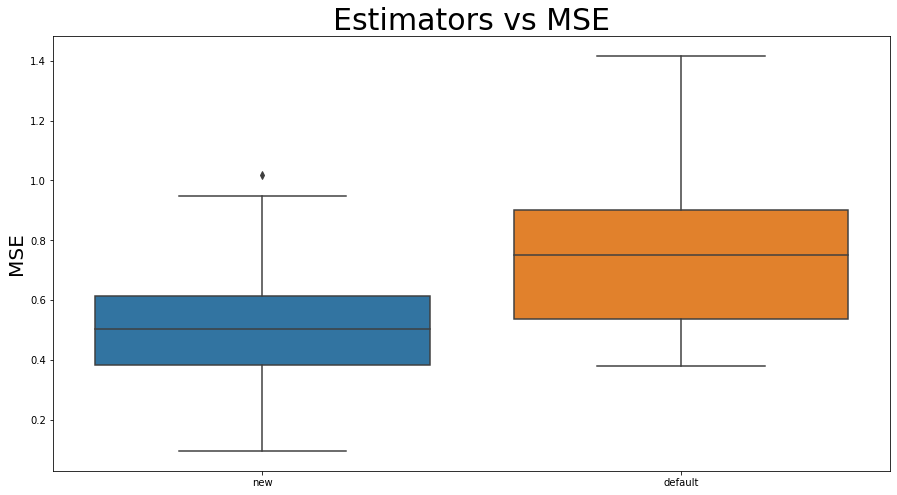

In [ ]:
XGB_params = XGB_res.best_params

models_XGB = {}
'''models_XGB['old'] = xgboost.XGBRegressor(n_estimators = 500,
                                        learning_rate = 0.1,
                                        max_depth = 5,
                                        min_child_weight = 3,
                                        n_jobs=-1)
'''
models_XGB['new'] = xgboost.XGBRegressor(**XGB_params, n_estimators = 500)

models_XGB['default'] = xgboost.XGBRegressor()

print(models_XGB)
results_XGB = train_and_test_regressor(models_XGB, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_XGB)

In [ ]:
optuna.visualization.plot_param_importances(XGB_res)

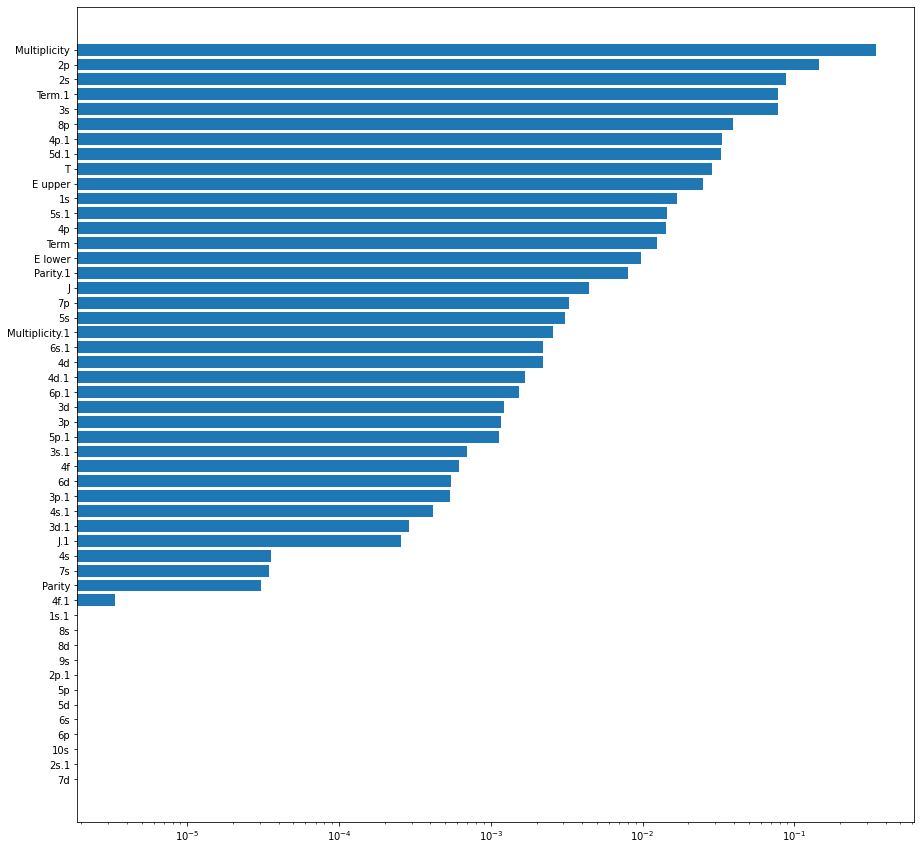

In [ ]:
'''test_score = np.zeros((500))
for i, y_pred in enumerate(models_XGB['new'].staged_predict(XW_test)):
    test_score[i] = models_XGB['new'].loss_(YW_test, y_pred)
plt.figure(figsize = (15, 7))
plt.plot(models_XGB['new'].train_score_, label = 'Train')
plt.plot(test_score, label = 'Test')
plt.semilogy()
plt.legend()
plt.show()
'''
feature_importance = models_XGB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XS_train.columns)[sorted])
plt.semilogx()
plt.show()

## TabNet

In [ ]:
print(torch.cuda.is_available())

False


In [ ]:
TabNet_params = {
    'n_d' : [1, 64],
    'n_steps' : [1, 25],
    'gamma' : [1., 2.],
    'n_independent' : [1, 20],
    'n_shared' : [1, 20],
    'momentum' : [1e-3, 0.4],
    'mask_type' : ['sparsemax', 'entmax'],
    'nfold' : 5,
    'squared_metrics' : False,
    'device_name' : 'cuda',
    'n_jobs' : -1
    }

model_name = TabNet

TabNet_res = main(X = XS_train, y = YS_train, model_name = model_name, params = TabNet_params, n_trials = 250)

'''with open(f'TabNet_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)
'''
with open(f'TabNet_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)

[I 2022-05-13 20:32:56,134] A new study created in memory with name: no-name-b8154697-a717-4361-9755-4ba0154f31d9


Start hyperparameter optimization
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 24, 'gamma': 1.13430738036484, 'n_independent': 20, 'n_shared': 20, 'momentum': 0.007243419829637966, 'mask_type': 'entmax'}
{'device_name': 'cuda', 'n_d': 64, 'n_steps': 23, 'gamma': 1.3228534791760125, 'n_independent': 19, 'n_shared': 2, 'momentum': 0.057551281818542764, 'mask_type': 'entmax'}


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 238.95984
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 136.0713
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 648215324.76502
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 116.74534
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 1301.53025
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 25084320.35686
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 278.19133
Best weights from best epoch are automatically used!


[I 2022-05-13 20:48:44,790] Trial 1 finished with value: 18.136791632657413 and parameters: {'n_d': 64, 'n_steps': 23, 'gamma': 1.3228534791760125, 'n_independent': 19, 'n_shared': 2, 'momentum': 0.057551281818542764, 'mask_type': 'entmax'}. Best is trial 1 with value: 18.136791632657413.


{'device_name': 'cuda', 'n_d': 40, 'n_steps': 25, 'gamma': 1.452524272443236, 'n_independent': 3, 'n_shared': 8, 'momentum': 0.012544854055710463, 'mask_type': 'entmax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 414.4826
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 10291609.68212
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 217.91817
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 512.79104
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 1073.43271
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 4685057882.71821
Best weights from best ep

[I 2022-05-13 21:00:15,480] Trial 2 finished with value: 20.7293345701055 and parameters: {'n_d': 40, 'n_steps': 25, 'gamma': 1.452524272443236, 'n_independent': 3, 'n_shared': 8, 'momentum': 0.012544854055710463, 'mask_type': 'entmax'}. Best is trial 1 with value: 18.136791632657413.


{'device_name': 'cuda', 'n_d': 13, 'n_steps': 14, 'gamma': 1.8723440493171122, 'n_independent': 8, 'n_shared': 17, 'momentum': 0.005599800809225098, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 3025112873.13202
Best weights from best epoch are automatically used!


[I 2022-05-13 21:03:24,672] Trial 0 finished with value: 31425.01214722566 and parameters: {'n_d': 51, 'n_steps': 24, 'gamma': 1.13430738036484, 'n_independent': 20, 'n_shared': 20, 'momentum': 0.007243419829637966, 'mask_type': 'entmax'}. Best is trial 1 with value: 18.136791632657413.


{'device_name': 'cuda', 'n_d': 62, 'n_steps': 4, 'gamma': 1.231552467749839, 'n_independent': 3, 'n_shared': 8, 'momentum': 0.0013648841980418856, 'mask_type': 'entmax'}

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 2461.25605
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 24416.26535
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 86744.48675
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 16279.48907
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 3850.69416
Best weights from best epoch are automatically used!


[I 2022-05-13 21:05:27,184] Trial 4 finished with value: 217.74580758698085 and parameters: {'n_d': 62, 'n_steps': 4, 'gamma': 1.231552467749839, 'n_independent': 3, 'n_shared': 8, 'momentum': 0.0013648841980418856, 'mask_type': 'entmax'}. Best is trial 1 with value: 18.136791632657413.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 200975.36116
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 17, 'gamma': 1.0316576094523993, 'n_independent': 7, 'n_shared': 14, 'momentum': 0.0011301725527566736, 'mask_type': 'entmax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 45574.13744
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 4261175860.13427
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 18524.25296
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 54979.13676
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 15002959304.06204
Best wei

[I 2022-05-13 21:12:14,448] Trial 3 finished with value: 185.79818120267572 and parameters: {'n_d': 13, 'n_steps': 14, 'gamma': 1.8723440493171122, 'n_independent': 8, 'n_shared': 17, 'momentum': 0.005599800809225098, 'mask_type': 'entmax'}. Best is trial 1 with value: 18.136791632657413.


{'device_name': 'cuda', 'n_d': 51, 'n_steps': 20, 'gamma': 1.5312617982376824, 'n_independent': 15, 'n_shared': 8, 'momentum': 0.0014467292584798683, 'mask_type': 'entmax'}

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 5250111625.74956
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 15903239854884.127
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 801232872.07391
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 11483399816775.977
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 2380076110.29946
Best weights from best epoch are automatically used!


[I 2022-05-13 21:20:01,363] Trial 5 finished with value: 67462.79709231546 and parameters: {'n_d': 33, 'n_steps': 17, 'gamma': 1.0316576094523993, 'n_independent': 7, 'n_shared': 14, 'momentum': 0.0011301725527566736, 'mask_type': 'entmax'}. Best is trial 1 with value: 18.136791632657413.


{'device_name': 'cuda', 'n_d': 49, 'n_steps': 15, 'gamma': 1.2203733443037805, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.003000743124173054, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 12.08187
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 8.18067
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 18.20985
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 13.22061
Best weights from best epoch are automatically used!


[I 2022-05-13 21:21:09,125] Trial 7 finished with value: 3.5869592838306894 and parameters: {'n_d': 49, 'n_steps': 15, 'gamma': 1.2203733443037805, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.003000743124173054, 'mask_type': 'sparsemax'}. Best is trial 7 with value: 3.5869592838306894.



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 13.65595
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 63, 'n_steps': 17, 'gamma': 1.69115700131605, 'n_independent': 3, 'n_shared': 19, 'momentum': 0.00802692771776797, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 394600295290.1589
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 2792333557327.093
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 114.50829
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 5139167431267.65
Best weights from best epoch are automatically used!


[I 2022-05-13 21:29:04,575] Trial 6 finished with value: 2388555.250497115 and parameters: {'n_d': 51, 'n_steps': 20, 'gamma': 1.5312617982376824, 'n_independent': 15, 'n_shared': 8, 'momentum': 0.0014467292584798683, 'mask_type': 'entmax'}. Best is trial 7 with value: 3.5869592838306894.


{'device_name': 'cuda', 'n_d': 16, 'n_steps': 3, 'gamma': 1.6930633492073741, 'n_independent': 11, 'n_shared': 13, 'momentum': 0.020699478048056188, 'mask_type': 'entmax'}

Early stopping occurred at epoch 119 with best_epoch = 99 and best_eval_mse = 961.69907
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 12.46343
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 10.93017
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 14.63984
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 8.89862
Best weights from best epoch are automatically used!


[I 2022-05-13 21:32:14,447] Trial 9 finished with value: 3.464619191884492 and parameters: {'n_d': 16, 'n_steps': 3, 'gamma': 1.6930633492073741, 'n_independent': 11, 'n_shared': 13, 'momentum': 0.020699478048056188, 'mask_type': 'entmax'}. Best is trial 9 with value: 3.464619191884492.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 13.52324
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 19, 'gamma': 1.1329539749494968, 'n_independent': 17, 'n_shared': 15, 'momentum': 0.003850915024656817, 'mask_type': 'entmax'}

Early stopping occurred at epoch 126 with best_epoch = 106 and best_eval_mse = 1344.97369
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 1852865830438.313
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 51.28238
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 117 with best_epoch = 97 and best_eval_mse = 220253014.91296
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 41.61837
Best weights fr

[I 2022-05-13 21:43:13,513] Trial 8 finished with value: 18.3996825242779 and parameters: {'n_d': 63, 'n_steps': 17, 'gamma': 1.69115700131605, 'n_independent': 3, 'n_shared': 19, 'momentum': 0.00802692771776797, 'mask_type': 'sparsemax'}. Best is trial 9 with value: 3.464619191884492.


{'device_name': 'cuda', 'n_d': 9, 'n_steps': 1, 'gamma': 1.9800491693067477, 'n_independent': 13, 'n_shared': 13, 'momentum': 0.2676737316024163, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 8.85541
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 11.12306
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 13.70656
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 3.59653
Best weights from best epoch are automatically used!


[I 2022-05-13 21:44:15,644] Trial 11 finished with value: 3.104611586394803 and parameters: {'n_d': 9, 'n_steps': 1, 'gamma': 1.9800491693067477, 'n_independent': 13, 'n_shared': 13, 'momentum': 0.2676737316024163, 'mask_type': 'sparsemax'}. Best is trial 11 with value: 3.104611586394803.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 13.05695
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 8, 'n_steps': 1, 'gamma': 1.9262069642122548, 'n_independent': 13, 'n_shared': 13, 'momentum': 0.32731588984847854, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 11.0673
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 2.75256
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 14.47073
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 6.37272
Best weights from best epoch are automatically used!


[I 2022-05-13 21:45:23,315] Trial 12 finished with value: 2.9774009980081826 and parameters: {'n_d': 8, 'n_steps': 1, 'gamma': 1.9262069642122548, 'n_independent': 13, 'n_shared': 13, 'momentum': 0.32731588984847854, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 2.9774009980081826.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 12.76418
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 1, 'n_steps': 7, 'gamma': 1.9909324623012987, 'n_independent': 14, 'n_shared': 12, 'momentum': 0.34823032946364996, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 18.60516
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 16.14688
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 17.95303
Best weights from best epoch are automatically used!


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:706: RuntimeWarning: invalid value encountered in true_divide
  self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 10.39623
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 18.36913
Best weights from best epoch are automatically used!


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:706: RuntimeWarning: invalid value encountered in true_divide
  self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)
[I 2022-05-13 21:47:56,651] Trial 13 finished with value: 4.015805992189831 and parameters: {'n_d': 1, 'n_steps': 7, 'gamma': 1.9909324623012987, 'n_independent': 14, 'n_shared': 12, 'momentum': 0.34823032946364996, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 2.9774009980081826.


{'device_name': 'cuda', 'n_d': 15, 'n_steps': 8, 'gamma': 1.9372116271740234, 'n_independent': 14, 'n_shared': 16, 'momentum': 0.3271626817315847, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 2786606683.74324
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 49.66227
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 14.07472
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 22.14835
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 66.0587
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 25.18528
Best weights from best epoch ar

[I 2022-05-13 21:53:47,686] Trial 14 finished with value: 5.730224657005497 and parameters: {'n_d': 15, 'n_steps': 8, 'gamma': 1.9372116271740234, 'n_independent': 14, 'n_shared': 16, 'momentum': 0.3271626817315847, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 2.9774009980081826.


{'device_name': 'cuda', 'n_d': 5, 'n_steps': 1, 'gamma': 1.807608145516466, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.1137626179958091, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 13.46637
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 11.53135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 14.9632
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 3.60273
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 5269736921.24605
Best weights from best epoch are automatically used!


[I 2022-05-13 21:54:40,215] Trial 15 finished with value: 3.047992588261379 and parameters: {'n_d': 5, 'n_steps': 1, 'gamma': 1.807608145516466, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.1137626179958091, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 2.9774009980081826.



Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 5.79947
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 10, 'gamma': 1.775500109735165, 'n_independent': 17, 'n_shared': 5, 'momentum': 0.11075288298264355, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 40.75574
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 11.02326
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 18.94857
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 134381235347.11787
Best weights from best epoch are automatically used!


[I 2022-05-13 21:58:27,564] Trial 10 finished with value: 373600.56052375626 and parameters: {'n_d': 57, 'n_steps': 19, 'gamma': 1.1329539749494968, 'n_independent': 17, 'n_shared': 15, 'momentum': 0.003850915024656817, 'mask_type': 'entmax'}. Best is trial 12 with value: 2.9774009980081826.


{'device_name': 'cuda', 'n_d': 25, 'n_steps': 10, 'gamma': 1.802790825301911, 'n_independent': 9, 'n_shared': 10, 'momentum': 0.12009884990854448, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 77.4737
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 32.97648
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 27.24831
Best weights from best epoch are automatically used!


[I 2022-05-13 21:59:47,501] Trial 16 finished with value: 5.615810573246773 and parameters: {'n_d': 24, 'n_steps': 10, 'gamma': 1.775500109735165, 'n_independent': 17, 'n_shared': 5, 'momentum': 0.11075288298264355, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 2.9774009980081826.


{'device_name': 'cuda', 'n_d': 2, 'n_steps': 1, 'gamma': 1.8118782600694814, 'n_independent': 10, 'n_shared': 10, 'momentum': 0.09605554681872948, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 11.60781
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 0.80949
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 10.94111
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 7.49536
Best weights from best epoch are automatically used!


[I 2022-05-13 22:01:01,573] Trial 18 finished with value: 2.7489279497061707 and parameters: {'n_d': 2, 'n_steps': 1, 'gamma': 1.8118782600694814, 'n_independent': 10, 'n_shared': 10, 'momentum': 0.09605554681872948, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 11.50837
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 23, 'n_steps': 5, 'gamma': 1.5699367125195107, 'n_independent': 8, 'n_shared': 10, 'momentum': 0.04083577911084825, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 12.42697
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 11.95118
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 9.24773
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 17.98848
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 15.87966
Best weights from best epoch are automat

[I 2022-05-13 22:03:31,528] Trial 19 finished with value: 3.7200407942889426 and parameters: {'n_d': 23, 'n_steps': 5, 'gamma': 1.5699367125195107, 'n_independent': 8, 'n_shared': 10, 'momentum': 0.04083577911084825, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 11.78253
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 11, 'gamma': 1.6348822979999849, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.1610773563864834, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 52.23799
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 13.27355
Best weights from best epoch are automatically used!


[I 2022-05-13 22:04:44,041] Trial 17 finished with value: 4.565361505062155 and parameters: {'n_d': 25, 'n_steps': 10, 'gamma': 1.802790825301911, 'n_independent': 9, 'n_shared': 10, 'momentum': 0.12009884990854448, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.


{'device_name': 'cuda', 'n_d': 1, 'n_steps': 11, 'gamma': 1.629802936076134, 'n_independent': 6, 'n_shared': 5, 'momentum': 0.1812148995947635, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 18.18674
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 11.17405
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 15.9199
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 24.81556
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 18.22638
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 10.45479
Best weights from best epoch are automatically 

[I 2022-05-13 22:06:17,783] Trial 21 finished with value: 4.01534003323255 and parameters: {'n_d': 1, 'n_steps': 11, 'gamma': 1.629802936076134, 'n_independent': 6, 'n_shared': 5, 'momentum': 0.1812148995947635, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 18.65817
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 6, 'n_steps': 1, 'gamma': 1.7997681983842502, 'n_independent': 11, 'n_shared': 11, 'momentum': 0.07093385228489583, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 12.77322
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 7.58441
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 11.50237
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 11.34749
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 8.00069
Best weights from best epoch are automati

[I 2022-05-13 22:07:36,035] Trial 20 finished with value: 4.905852540684548 and parameters: {'n_d': 24, 'n_steps': 11, 'gamma': 1.6348822979999849, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.1610773563864834, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.


{'device_name': 'cuda', 'n_d': 7, 'n_steps': 1, 'gamma': 1.8528810847274624, 'n_independent': 12, 'n_shared': 11, 'momentum': 0.057770106329087814, 'mask_type': 'sparsemax'}


[I 2022-05-13 22:07:38,370] Trial 22 finished with value: 3.212791306687458 and parameters: {'n_d': 6, 'n_steps': 1, 'gamma': 1.7997681983842502, 'n_independent': 11, 'n_shared': 11, 'momentum': 0.07093385228489583, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 13.84814
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 7, 'n_steps': 6, 'gamma': 1.8571096994822915, 'n_independent': 12, 'n_shared': 9, 'momentum': 0.028892287311480684, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 12.22238
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 5.83226
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 14.11112
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 8.0684
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 17.35862
Best weights from best epoch are automatica

[I 2022-05-13 22:08:29,772] Trial 23 finished with value: 3.007118335158108 and parameters: {'n_d': 7, 'n_steps': 1, 'gamma': 1.8528810847274624, 'n_independent': 12, 'n_shared': 11, 'momentum': 0.057770106329087814, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 6.38857
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 10, 'n_steps': 6, 'gamma': 1.886400693059923, 'n_independent': 12, 'n_shared': 7, 'momentum': 0.02922228206620593, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 13.48497
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 17.576
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 14.01631
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 8.84156
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 9.20053
Best weights from best epoch are automaticall

[I 2022-05-13 22:10:49,286] Trial 24 finished with value: 3.8482024190317987 and parameters: {'n_d': 7, 'n_steps': 6, 'gamma': 1.8571096994822915, 'n_independent': 12, 'n_shared': 9, 'momentum': 0.028892287311480684, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.


{'device_name': 'cuda', 'n_d': 17, 'n_steps': 3, 'gamma': 1.9110834064134137, 'n_independent': 16, 'n_shared': 12, 'momentum': 0.07295406027554265, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 15.16564
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 13.39971
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 8.80937
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 12.08068
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 20.6593
Best weights from best epoch are automatically used!


[I 2022-05-13 22:12:28,062] Trial 25 finished with value: 3.6369384255301425 and parameters: {'n_d': 10, 'n_steps': 6, 'gamma': 1.886400693059923, 'n_independent': 12, 'n_shared': 7, 'momentum': 0.02922228206620593, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.


{'device_name': 'cuda', 'n_d': 31, 'n_steps': 3, 'gamma': 1.4126220311739228, 'n_independent': 15, 'n_shared': 17, 'momentum': 0.07218480483145782, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 14.52596
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 12.52951
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 7.91484
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 10.04564
Best weights from best epoch are automatically used!


[I 2022-05-13 22:14:02,827] Trial 26 finished with value: 3.4749216499332882 and parameters: {'n_d': 17, 'n_steps': 3, 'gamma': 1.9110834064134137, 'n_independent': 16, 'n_shared': 12, 'momentum': 0.07295406027554265, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 13.05879
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 19, 'n_steps': 3, 'gamma': 1.4019705675303622, 'n_independent': 6, 'n_shared': 18, 'momentum': 0.224372170424016, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 14.35011
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 13.58139
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 7.05853
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 9.2727
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 13.05955
Best weights from best epoch are automatical

[I 2022-05-13 22:15:19,516] Trial 27 finished with value: 3.448234335758465 and parameters: {'n_d': 31, 'n_steps': 3, 'gamma': 1.4126220311739228, 'n_independent': 15, 'n_shared': 17, 'momentum': 0.07218480483145782, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.


{'device_name': 'cuda', 'n_d': 20, 'n_steps': 8, 'gamma': 1.7129946022136295, 'n_independent': 5, 'n_shared': 14, 'momentum': 0.2177903078045965, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 7.75163
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 22.22357
Best weights from best epoch are automatically used!


[I 2022-05-13 22:16:23,369] Trial 28 finished with value: 3.2366118582780046 and parameters: {'n_d': 19, 'n_steps': 3, 'gamma': 1.4019705675303622, 'n_independent': 6, 'n_shared': 18, 'momentum': 0.224372170424016, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 11.85427
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 11, 'n_steps': 8, 'gamma': 1.7157074014463762, 'n_independent': 9, 'n_shared': 14, 'momentum': 0.04477634589887025, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 9.74932
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 20.53477
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 19.57598
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 22.02272
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 15.23038
Best weights from best epoch are automati

[I 2022-05-13 22:18:23,971] Trial 29 finished with value: 4.116129676529981 and parameters: {'n_d': 20, 'n_steps': 8, 'gamma': 1.7129946022136295, 'n_independent': 5, 'n_shared': 14, 'momentum': 0.2177903078045965, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.


{'device_name': 'cuda', 'n_d': 12, 'n_steps': 1, 'gamma': 1.9933640400769306, 'n_independent': 20, 'n_shared': 12, 'momentum': 0.042808922955209, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 12.65151
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 26.68388
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 5.05827
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 14.25815
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 8.17649
Best weights from best epoch are automatically used!


[I 2022-05-13 22:19:42,287] Trial 31 finished with value: 3.2128612408358435 and parameters: {'n_d': 12, 'n_steps': 1, 'gamma': 1.9933640400769306, 'n_independent': 20, 'n_shared': 12, 'momentum': 0.042808922955209, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 13.12539
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 4, 'n_steps': 1, 'gamma': 1.7611873432872724, 'n_independent': 10, 'n_shared': 11, 'momentum': 0.11652118532957988, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 11.95341
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.73049
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 14.03164
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 7.84821
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 15.23724
Best weights from best epoch are automatic

[I 2022-05-13 22:20:27,284] Trial 32 finished with value: 3.176782454202452 and parameters: {'n_d': 4, 'n_steps': 1, 'gamma': 1.7611873432872724, 'n_independent': 10, 'n_shared': 11, 'momentum': 0.11652118532957988, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 13.72128
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 4, 'n_steps': 4, 'gamma': 1.848043588986252, 'n_independent': 12, 'n_shared': 6, 'momentum': 0.10265423116858363, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 10.28688
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 20.50248
Best weights from best epoch are automatically used!


[I 2022-05-13 22:21:16,781] Trial 30 finished with value: 4.384837599589479 and parameters: {'n_d': 11, 'n_steps': 8, 'gamma': 1.7157074014463762, 'n_independent': 9, 'n_shared': 14, 'momentum': 0.04477634589887025, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.


{'device_name': 'cuda', 'n_d': 4, 'n_steps': 4, 'gamma': 1.8458334831061725, 'n_independent': 12, 'n_shared': 6, 'momentum': 0.1360293938227285, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 10.66578
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 11.03465
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 14.12362
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 10.83779
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 7.65186
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 14.52813
Best weights from best epoch are automatic

[I 2022-05-13 22:23:13,813] Trial 33 finished with value: 3.298197352658618 and parameters: {'n_d': 4, 'n_steps': 4, 'gamma': 1.848043588986252, 'n_independent': 12, 'n_shared': 6, 'momentum': 0.10265423116858363, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 12.2044
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 5, 'n_steps': 2, 'gamma': 1.9248999437451637, 'n_independent': 13, 'n_shared': 9, 'momentum': 0.3801377005679549, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 7.26569
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 12.25806
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 11.45751
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 14.31354
Best weights from best epoch are automatically used!


[I 2022-05-13 22:23:51,573] Trial 34 finished with value: 3.346219523617743 and parameters: {'n_d': 4, 'n_steps': 4, 'gamma': 1.8458334831061725, 'n_independent': 12, 'n_shared': 6, 'momentum': 0.1360293938227285, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 13.03282
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 1, 'n_steps': 2, 'gamma': 1.9217956746520521, 'n_independent': 13, 'n_shared': 9, 'momentum': 0.37718119492807595, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 5.19096
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 8.00608
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 15.9199
Best weights from best epoch are automatically used!


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:706: RuntimeWarning: invalid value encountered in true_divide
  self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 17.95303
Best weights from best epoch are automatically used!


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:706: RuntimeWarning: invalid value encountered in true_divide
  self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)
[I 2022-05-13 22:24:55,185] Trial 35 finished with value: 3.028909886997698 and parameters: {'n_d': 5, 'n_steps': 2, 'gamma': 1.9248999437451637, 'n_independent': 13, 'n_shared': 9, 'momentum': 0.3801377005679549, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 138 with best_epoch = 118 and best_eval_mse = 4.82598
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 1, 'n_steps': 2, 'gamma': 1.9328172519091655, 'n_independent': 14, 'n_shared': 3, 'momentum': 0.35773029047002114, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 6.15217
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 17.99469
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 13.12884
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 17.89182
Best weights from best epoch are automatically used!


[I 2022-05-13 22:25:31,582] Trial 36 finished with value: 3.3218523930142227 and parameters: {'n_d': 1, 'n_steps': 2, 'gamma': 1.9217956746520521, 'n_independent': 13, 'n_shared': 9, 'momentum': 0.37718119492807595, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 118 with best_epoch = 98 and best_eval_mse = 9.43919
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 6, 'gamma': 1.9438385461335677, 'n_independent': 14, 'n_shared': 3, 'momentum': 0.012562595321014051, 'mask_type': 'entmax'}

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 8.87669
Best weights from best epoch are automatically used!


[I 2022-05-13 22:25:44,836] Trial 37 finished with value: 3.8721122028630797 and parameters: {'n_d': 1, 'n_steps': 2, 'gamma': 1.9328172519091655, 'n_independent': 14, 'n_shared': 3, 'momentum': 0.35773029047002114, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 18.36913
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 5, 'gamma': 1.643141706149396, 'n_independent': 18, 'n_shared': 8, 'momentum': 0.27247745515095717, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 471.53432
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 21.47839
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 32.66231
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 38.96524
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 14.40371
Best weights from best epoch are automaticall

[I 2022-05-13 22:28:16,245] Trial 39 finished with value: 4.642585704685919 and parameters: {'n_d': 44, 'n_steps': 5, 'gamma': 1.643141706149396, 'n_independent': 18, 'n_shared': 8, 'momentum': 0.27247745515095717, 'mask_type': 'entmax'}. Best is trial 18 with value: 2.7489279497061707.


{'device_name': 'cuda', 'n_d': 13, 'n_steps': 5, 'gamma': 1.7516905298001877, 'n_independent': 9, 'n_shared': 13, 'momentum': 0.011674871594639582, 'mask_type': 'entmax'}

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 53.91802
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 21.1346
Best weights from best epoch are automatically used!


[I 2022-05-13 22:29:25,835] Trial 38 finished with value: 22.57029264603737 and parameters: {'n_d': 44, 'n_steps': 6, 'gamma': 1.9438385461335677, 'n_independent': 14, 'n_shared': 3, 'momentum': 0.012562595321014051, 'mask_type': 'entmax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 276.0307
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 24, 'gamma': 1.7472377008606303, 'n_independent': 9, 'n_shared': 9, 'momentum': 0.17247464292801482, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 10.90394
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 17.01001
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 65.46528
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 51.14932
Best weights from best epoch are automatically used!


[I 2022-05-13 22:32:39,731] Trial 40 finished with value: 4.82719353300141 and parameters: {'n_d': 13, 'n_steps': 5, 'gamma': 1.7516905298001877, 'n_independent': 9, 'n_shared': 13, 'momentum': 0.011674871594639582, 'mask_type': 'entmax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 16.17035
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 7, 'n_steps': 2, 'gamma': 1.842556515424172, 'n_independent': 10, 'n_shared': 9, 'momentum': 0.18014306516061682, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 11.08755
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 10.37479
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 14.28576
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 8.93772
Best weights from best epoch are automatically used!


[I 2022-05-13 22:33:30,584] Trial 42 finished with value: 3.3541716987766295 and parameters: {'n_d': 7, 'n_steps': 2, 'gamma': 1.842556515424172, 'n_independent': 10, 'n_shared': 9, 'momentum': 0.18014306516061682, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 2.7489279497061707.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 11.90814
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 8, 'n_steps': 1, 'gamma': 1.808360893859039, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.07829271771617738, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 2.79253
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 1.89023
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 14.44
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 8.23817
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 26.94807
Best weights from best epoch are automatically

[I 2022-05-13 22:34:24,234] Trial 43 finished with value: 2.673630087776875 and parameters: {'n_d': 8, 'n_steps': 1, 'gamma': 1.808360893859039, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.07829271771617738, 'mask_type': 'sparsemax'}. Best is trial 43 with value: 2.673630087776875.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 13.33702
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 9, 'n_steps': 23, 'gamma': 1.8809594680493595, 'n_independent': 13, 'n_shared': 11, 'momentum': 0.08512850890892802, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 80.00508
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 73.80667
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 18.20412
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 134.9113
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 18.82689
Best weights from best epoch are autom

[I 2022-05-13 22:44:24,564] Trial 41 finished with value: 5.8746988142613406 and parameters: {'n_d': 31, 'n_steps': 24, 'gamma': 1.7472377008606303, 'n_independent': 9, 'n_shared': 9, 'momentum': 0.17247464292801482, 'mask_type': 'sparsemax'}. Best is trial 43 with value: 2.673630087776875.


{'device_name': 'cuda', 'n_d': 9, 'n_steps': 2, 'gamma': 1.8869457571715884, 'n_independent': 13, 'n_shared': 11, 'momentum': 0.08099782100841715, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 12.48477
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 55.04014
Best weights from best epoch are automatically used!


[I 2022-05-13 22:44:53,910] Trial 44 finished with value: 8.619599096331239 and parameters: {'n_d': 9, 'n_steps': 23, 'gamma': 1.8809594680493595, 'n_independent': 13, 'n_shared': 11, 'momentum': 0.08512850890892802, 'mask_type': 'sparsemax'}. Best is trial 43 with value: 2.673630087776875.


{'device_name': 'cuda', 'n_d': 13, 'n_steps': 3, 'gamma': 1.9645825310706773, 'n_independent': 15, 'n_shared': 7, 'momentum': 0.029126018150588108, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 11.3348
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 14.4922
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 11.51527
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 11.12807
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 7.41617
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 29.55449
Best weights from best epoch are automatic

[I 2022-05-13 22:46:09,124] Trial 45 finished with value: 3.334214828462355 and parameters: {'n_d': 9, 'n_steps': 2, 'gamma': 1.8869457571715884, 'n_independent': 13, 'n_shared': 11, 'momentum': 0.08099782100841715, 'mask_type': 'sparsemax'}. Best is trial 43 with value: 2.673630087776875.



Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 10.50311
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 14, 'n_steps': 4, 'gamma': 1.958481291269046, 'n_independent': 16, 'n_shared': 8, 'momentum': 0.05416222846929714, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 8.75727
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 21.1553
Best weights from best epoch are automatically used!


[I 2022-05-13 22:46:37,036] Trial 46 finished with value: 3.658164213723065 and parameters: {'n_d': 13, 'n_steps': 3, 'gamma': 1.9645825310706773, 'n_independent': 15, 'n_shared': 7, 'momentum': 0.029126018150588108, 'mask_type': 'sparsemax'}. Best is trial 43 with value: 2.673630087776875.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 10.02264
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 16, 'n_steps': 4, 'gamma': 1.508679388913479, 'n_independent': 8, 'n_shared': 13, 'momentum': 0.05943220033922742, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 11.34912
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 9.57398
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 11.45342
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 14.49997
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 10.32538
Best weights from best epoch are automati

[I 2022-05-13 22:49:06,021] Trial 48 finished with value: 3.4774856463743027 and parameters: {'n_d': 16, 'n_steps': 4, 'gamma': 1.508679388913479, 'n_independent': 8, 'n_shared': 13, 'momentum': 0.05943220033922742, 'mask_type': 'sparsemax'}. Best is trial 43 with value: 2.673630087776875.



Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 13.49594
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 7, 'n_steps': 1, 'gamma': 1.5874644364279415, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.28226089994633036, 'mask_type': 'entmax'}


[I 2022-05-13 22:49:08,905] Trial 47 finished with value: 3.554913556679845 and parameters: {'n_d': 14, 'n_steps': 4, 'gamma': 1.958481291269046, 'n_independent': 16, 'n_shared': 8, 'momentum': 0.05416222846929714, 'mask_type': 'sparsemax'}. Best is trial 43 with value: 2.673630087776875.



Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 14.72883
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 7, 'n_steps': 15, 'gamma': 1.8145826582459734, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.26263589314491576, 'mask_type': 'entmax'}

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 5.51668
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 2.6226
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 11.20893
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 7.8469
Best weights from best epoch are automatically used!


[I 2022-05-13 22:50:29,297] Trial 49 finished with value: 2.4717155999355667 and parameters: {'n_d': 7, 'n_steps': 1, 'gamma': 1.5874644364279415, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.28226089994633036, 'mask_type': 'entmax'}. Best is trial 49 with value: 2.4717155999355667.



Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 5.02283
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 1, 'gamma': 1.2505186954982823, 'n_independent': 11, 'n_shared': 16, 'momentum': 0.23236632243151423, 'mask_type': 'entmax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 6.34915
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 18.08391
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 2.12465
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 3.23035
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 5.51444
Best weights from best epoch are automatically

[I 2022-05-13 22:51:51,040] Trial 51 finished with value: 2.077201185931621 and parameters: {'n_d': 27, 'n_steps': 1, 'gamma': 1.2505186954982823, 'n_independent': 11, 'n_shared': 16, 'momentum': 0.23236632243151423, 'mask_type': 'entmax'}. Best is trial 51 with value: 2.077201185931621.



Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 5.12133
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 1, 'gamma': 1.2247514723899309, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.25857418090430384, 'mask_type': 'entmax'}

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 2.77604
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 7.58054
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 13.77257
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 24.47581
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 2.0286
Best weights from best epoch are automatically 

[I 2022-05-13 22:53:02,767] Trial 52 finished with value: 2.34816555741182 and parameters: {'n_d': 38, 'n_steps': 1, 'gamma': 1.2247514723899309, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.25857418090430384, 'mask_type': 'entmax'}. Best is trial 51 with value: 2.077201185931621.



Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 4.77848
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 1, 'gamma': 1.2682026468652345, 'n_independent': 11, 'n_shared': 16, 'momentum': 0.27264116206889355, 'mask_type': 'entmax'}

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 9.51418
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 2.68792
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 13.84721
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 9.64248
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 136 with best_epoch = 116 and best_eval_mse = 1.26672
Best weights from best epoch are automaticall

[I 2022-05-13 22:54:31,570] Trial 53 finished with value: 2.497942610714619 and parameters: {'n_d': 36, 'n_steps': 1, 'gamma': 1.2682026468652345, 'n_independent': 11, 'n_shared': 16, 'momentum': 0.27264116206889355, 'mask_type': 'entmax'}. Best is trial 51 with value: 2.077201185931621.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 12.49621
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 2, 'gamma': 1.27656744303272, 'n_independent': 11, 'n_shared': 20, 'momentum': 0.2538256906400106, 'mask_type': 'entmax'}

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 12.72127
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 10.3962
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 17.19606
Best weights from best epoch are automatically used!


[I 2022-05-13 22:55:08,110] Trial 50 finished with value: 4.304092385113433 and parameters: {'n_d': 7, 'n_steps': 15, 'gamma': 1.8145826582459734, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.26263589314491576, 'mask_type': 'entmax'}. Best is trial 51 with value: 2.077201185931621.


{'device_name': 'cuda', 'n_d': 36, 'n_steps': 2, 'gamma': 1.2536816983624373, 'n_independent': 8, 'n_shared': 20, 'momentum': 0.23571448891639546, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 14.2493
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 2.82862
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 1.41499
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 3.95376
Best weights from best epoch are automatically used!


[I 2022-05-13 22:56:36,204] Trial 54 finished with value: 2.9922442609401876 and parameters: {'n_d': 35, 'n_steps': 2, 'gamma': 1.27656744303272, 'n_independent': 11, 'n_shared': 20, 'momentum': 0.2538256906400106, 'mask_type': 'entmax'}. Best is trial 51 with value: 2.077201185931621.



Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 10.27756
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 37, 'n_steps': 1, 'gamma': 1.1454050752895484, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.1524561384758852, 'mask_type': 'entmax'}

Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 1.56018
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 6.40543
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 2.2229
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 3.5494
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 2.67936
Best weights from best epoch are automatically u

[I 2022-05-13 22:57:54,518] Trial 55 finished with value: 2.2977308224427437 and parameters: {'n_d': 36, 'n_steps': 2, 'gamma': 1.2536816983624373, 'n_independent': 8, 'n_shared': 20, 'momentum': 0.23571448891639546, 'mask_type': 'entmax'}. Best is trial 51 with value: 2.077201185931621.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 13.32709
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 3, 'gamma': 1.1474560639071687, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.14151304907951007, 'mask_type': 'entmax'}


[I 2022-05-13 22:58:04,589] Trial 56 finished with value: 1.7871563073254169 and parameters: {'n_d': 37, 'n_steps': 1, 'gamma': 1.1454050752895484, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.1524561384758852, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.



Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 4.69538
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 37, 'n_steps': 3, 'gamma': 1.1271048826517047, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.1384894080378456, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 15.0118
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 2.33975
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 11.99633
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 13.60997
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 2.5878
Best weights from best epoch are automatically 

[I 2022-05-13 23:00:36,701] Trial 58 finished with value: 3.09923899584502 and parameters: {'n_d': 37, 'n_steps': 3, 'gamma': 1.1271048826517047, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.1384894080378456, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 8.1699
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 5, 'gamma': 1.1850177386601395, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.20993428300126984, 'mask_type': 'entmax'}


[I 2022-05-13 23:00:57,586] Trial 57 finished with value: 2.3118572132629325 and parameters: {'n_d': 36, 'n_steps': 3, 'gamma': 1.1474560639071687, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.14151304907951007, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.



Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 4.571
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 5, 'gamma': 1.0650096487176182, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.2248930502718882, 'mask_type': 'entmax'}

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 3.11013
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 12.3732
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 13.0013
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 12.94922
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 18.99091
Best weights from best epoch are automatically use

[I 2022-05-13 23:04:45,688] Trial 59 finished with value: 2.8013253053974863 and parameters: {'n_d': 41, 'n_steps': 5, 'gamma': 1.1850177386601395, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.20993428300126984, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.


{'device_name': 'cuda', 'n_d': 28, 'n_steps': 7, 'gamma': 1.1099384049646122, 'n_independent': 5, 'n_shared': 18, 'momentum': 0.14853344746682517, 'mask_type': 'entmax'}


[I 2022-05-13 23:05:53,594] Trial 60 finished with value: 2.7536631554004 and parameters: {'n_d': 41, 'n_steps': 5, 'gamma': 1.0650096487176182, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.2248930502718882, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.



Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 3.70148
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 37, 'n_steps': 2, 'gamma': 1.3172727617757058, 'n_independent': 8, 'n_shared': 16, 'momentum': 0.30074668828676615, 'mask_type': 'entmax'}

Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 6.91501
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 2.78742
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 6.75489
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 2.52516
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 6.43635
Best weights from best epoch are automatica

[I 2022-05-13 23:08:09,272] Trial 62 finished with value: 2.307311876519001 and parameters: {'n_d': 37, 'n_steps': 2, 'gamma': 1.3172727617757058, 'n_independent': 8, 'n_shared': 16, 'momentum': 0.30074668828676615, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 8.48937
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 2, 'gamma': 1.354915470201767, 'n_independent': 7, 'n_shared': 18, 'momentum': 0.15404653667645998, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 15.07175
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 4.68909
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 8.21246
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 18.13471
Best weights from best epoch are automatically used!


[I 2022-05-13 23:09:05,512] Trial 61 finished with value: 3.2902517611142033 and parameters: {'n_d': 28, 'n_steps': 7, 'gamma': 1.1099384049646122, 'n_independent': 5, 'n_shared': 18, 'momentum': 0.14853344746682517, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.


{'device_name': 'cuda', 'n_d': 48, 'n_steps': 2, 'gamma': 1.1872727051104361, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.3133633556246176, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 12.34087
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 14.0466
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 7.91597
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 7.09654
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 6.46799
Best weights from best epoch are automatically used!


[I 2022-05-13 23:10:15,926] Trial 63 finished with value: 2.658787447192875 and parameters: {'n_d': 28, 'n_steps': 2, 'gamma': 1.354915470201767, 'n_independent': 7, 'n_shared': 18, 'momentum': 0.15404653667645998, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.



Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 2.89461
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 3, 'gamma': 1.1910513227739683, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.2969567743668429, 'mask_type': 'entmax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 7.35639
Best weights from best epoch are automatically used!


[I 2022-05-13 23:10:30,902] Trial 64 finished with value: 3.0173754021262438 and parameters: {'n_d': 48, 'n_steps': 2, 'gamma': 1.1872727051104361, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.3133633556246176, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.



Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 13.35534
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 3, 'gamma': 1.3255199346428173, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.31445930256447296, 'mask_type': 'entmax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 6.01075
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 9.96544
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 11.3227
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 12.13332
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 14.39824
Best weights from best epoch are automatically

[I 2022-05-13 23:12:41,112] Trial 65 finished with value: 2.9228177407623073 and parameters: {'n_d': 38, 'n_steps': 3, 'gamma': 1.1910513227739683, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.2969567743668429, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.



Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 4.60041
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 13, 'gamma': 1.3158191607933318, 'n_independent': 1, 'n_shared': 20, 'momentum': 0.0020007021845468995, 'mask_type': 'entmax'}


[I 2022-05-13 23:13:16,112] Trial 66 finished with value: 2.6728146597637186 and parameters: {'n_d': 38, 'n_steps': 3, 'gamma': 1.3255199346428173, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.31445930256447296, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.



Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 3.13401
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 18, 'gamma': 1.2424581284188123, 'n_independent': 9, 'n_shared': 19, 'momentum': 0.21527777933485792, 'mask_type': 'entmax'}

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 1163569245.67413
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 301.33138
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 104498.12352
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 626.69793
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 292.27468
Best weights from best e

[I 2022-05-13 23:24:40,423] Trial 68 finished with value: 17.305169369823393 and parameters: {'n_d': 34, 'n_steps': 18, 'gamma': 1.2424581284188123, 'n_independent': 9, 'n_shared': 19, 'momentum': 0.21527777933485792, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.


{'device_name': 'cuda', 'n_d': 44, 'n_steps': 4, 'gamma': 1.0349890256882135, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.0017344874712851813, 'mask_type': 'entmax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 1094458217.60837
Best weights from best epoch are automatically used!


[I 2022-05-13 23:25:16,759] Trial 67 finished with value: 14514.005451947514 and parameters: {'n_d': 32, 'n_steps': 13, 'gamma': 1.3158191607933318, 'n_independent': 1, 'n_shared': 20, 'momentum': 0.0020007021845468995, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.


{'device_name': 'cuda', 'n_d': 44, 'n_steps': 4, 'gamma': 1.0386032124309215, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.19409081883462262, 'mask_type': 'entmax'}

Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 53582.327
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 131 with best_epoch = 111 and best_eval_mse = 1.41269
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 126 with best_epoch = 106 and best_eval_mse = 603.7153
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 0.39049
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 3598.0729
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 13.25408
Best weights from best epoch are 

[I 2022-05-13 23:28:33,685] Trial 69 finished with value: 1175.440076919005 and parameters: {'n_d': 44, 'n_steps': 4, 'gamma': 1.0349890256882135, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.0017344874712851813, 'mask_type': 'entmax'}. Best is trial 56 with value: 1.7871563073254169.



Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 29725380.46822
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 21, 'gamma': 1.1641728732675762, 'n_independent': 5, 'n_shared': 14, 'momentum': 0.39180337436113183, 'mask_type': 'entmax'}


[I 2022-05-13 23:29:30,813] Trial 70 finished with value: 1.700054827707072 and parameters: {'n_d': 44, 'n_steps': 4, 'gamma': 1.0386032124309215, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.19409081883462262, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 2.17542
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.0855518446584151, 'n_independent': 4, 'n_shared': 14, 'momentum': 0.1873124987124718, 'mask_type': 'entmax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 7.48517
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 127.0487
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 5.38381
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 11.70908
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 8.42896
Best weights from best epoch are automatically

[I 2022-05-13 23:30:23,448] Trial 72 finished with value: 2.7244922359333184 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.0855518446584151, 'n_independent': 4, 'n_shared': 14, 'momentum': 0.1873124987124718, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 5.02267
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 3, 'gamma': 1.0080907021333287, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.12893235588050866, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 470.12164
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 6.83139
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 8.93584
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 462.78166
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 11.81535
Best weights from best epoch are automatica

[I 2022-05-13 23:33:50,216] Trial 73 finished with value: 2.8112509626318722 and parameters: {'n_d': 40, 'n_steps': 3, 'gamma': 1.0080907021333287, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.12893235588050866, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 8.145
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 2, 'gamma': 1.2208843500595237, 'n_independent': 2, 'n_shared': 14, 'momentum': 0.3888992724319465, 'mask_type': 'entmax'}

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 13.99246
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 12.63499
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 12.32031
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 9.01578
Best weights from best epoch are automatically used!


[I 2022-05-13 23:34:41,132] Trial 74 finished with value: 3.54345234939219 and parameters: {'n_d': 46, 'n_steps': 2, 'gamma': 1.2208843500595237, 'n_independent': 2, 'n_shared': 14, 'momentum': 0.3888992724319465, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 15.28325
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 1, 'gamma': 1.1553186303918996, 'n_independent': 6, 'n_shared': 16, 'momentum': 0.188852627281454, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 851.99202
Best weights from best epoch are automatically used!


[I 2022-05-13 23:34:54,026] Trial 71 finished with value: 19.705241996316435 and parameters: {'n_d': 60, 'n_steps': 21, 'gamma': 1.1641728732675762, 'n_independent': 5, 'n_shared': 14, 'momentum': 0.39180337436113183, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.5697333243474323, 'n_independent': 6, 'n_shared': 18, 'momentum': 0.19215140289191876, 'mask_type': 'entmax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 5.29417
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 1.86905
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 4.83985
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 11.41634
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 5.05065
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 5.92872
Best weights from best epoch are automatically u

[I 2022-05-13 23:35:40,430] Trial 75 finished with value: 2.4231901497189505 and parameters: {'n_d': 28, 'n_steps': 1, 'gamma': 1.1553186303918996, 'n_independent': 6, 'n_shared': 16, 'momentum': 0.188852627281454, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 6.93906
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 4, 'gamma': 1.1588028669456967, 'n_independent': 4, 'n_shared': 18, 'momentum': 0.1993558004093499, 'mask_type': 'entmax'}

Early stopping occurred at epoch 150 with best_epoch = 130 and best_eval_mse = 0.60156
Best weights from best epoch are automatically used!


[I 2022-05-13 23:36:09,930] Trial 76 finished with value: 2.253483217005571 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.5697333243474323, 'n_independent': 6, 'n_shared': 18, 'momentum': 0.19215140289191876, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 13.66344
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 4, 'gamma': 1.4321149953797934, 'n_independent': 7, 'n_shared': 18, 'momentum': 0.09546126449186433, 'mask_type': 'entmax'}

Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 7.1823
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 11.4405
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 2.97463
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 11.05134
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 32.38662
Best weights from best epoch are automatically

[I 2022-05-13 23:38:54,584] Trial 78 finished with value: 3.7281023708592067 and parameters: {'n_d': 51, 'n_steps': 4, 'gamma': 1.4321149953797934, 'n_independent': 7, 'n_shared': 18, 'momentum': 0.09546126449186433, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 11.68741
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 3, 'gamma': 1.479377711717047, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.23514031591548076, 'mask_type': 'entmax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 11.86468
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 10.17906
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 151 with best_epoch = 131 and best_eval_mse = 3.7127
Best weights from best epoch are automatically used!


[I 2022-05-13 23:39:35,766] Trial 77 finished with value: 2.402328144840371 and parameters: {'n_d': 27, 'n_steps': 4, 'gamma': 1.1588028669456967, 'n_independent': 4, 'n_shared': 18, 'momentum': 0.1993558004093499, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 33, 'n_steps': 7, 'gamma': 1.4725075088738315, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.2414818613315716, 'mask_type': 'entmax'}

Early stopping occurred at epoch 151 with best_epoch = 131 and best_eval_mse = 8.01527
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 17.75338
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 6.41612
Best weights from best epoch are automatically used!


[I 2022-05-13 23:41:23,123] Trial 79 finished with value: 2.866159150871554 and parameters: {'n_d': 54, 'n_steps': 3, 'gamma': 1.479377711717047, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.23514031591548076, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 5.43675
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 7, 'gamma': 1.2612927323919454, 'n_independent': 9, 'n_shared': 17, 'momentum': 0.16159588253228074, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 17.83566
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 20.55989
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 18.89073
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 19.28395
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 11.82576
Best weights from best epoch are automatica

[I 2022-05-13 23:43:32,936] Trial 80 finished with value: 4.131699794277244 and parameters: {'n_d': 33, 'n_steps': 7, 'gamma': 1.4725075088738315, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.2414818613315716, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 2, 'gamma': 1.2499431869071582, 'n_independent': 3, 'n_shared': 18, 'momentum': 0.16653882584970928, 'mask_type': 'entmax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 23.62183
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 4.48717
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 1.38195
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 14.32033
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 3.51122
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 8.71506
Best weights from best epoch are automatical

[I 2022-05-13 23:45:14,312] Trial 82 finished with value: 2.529892166587641 and parameters: {'n_d': 26, 'n_steps': 2, 'gamma': 1.2499431869071582, 'n_independent': 3, 'n_shared': 18, 'momentum': 0.16653882584970928, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 13.67193
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 6, 'gamma': 1.0971948117606585, 'n_independent': 2, 'n_shared': 17, 'momentum': 0.11852215316434235, 'mask_type': 'entmax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 15.10446
Best weights from best epoch are automatically used!


[I 2022-05-13 23:45:52,797] Trial 81 finished with value: 3.9343931868838498 and parameters: {'n_d': 30, 'n_steps': 7, 'gamma': 1.2612927323919454, 'n_independent': 9, 'n_shared': 17, 'momentum': 0.16159588253228074, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 39, 'n_steps': 4, 'gamma': 1.100628996421172, 'n_independent': 5, 'n_shared': 16, 'momentum': 0.11272484745880909, 'mask_type': 'entmax'}

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 13.1689
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 23.32248
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 18.32788
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 4.9763
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 7.9625
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 119 with best_epoch = 99 and best_eval_mse = 2.07335
Best weights from best epoch are automatically us

[I 2022-05-13 23:48:46,941] Trial 83 finished with value: 3.462669584133721 and parameters: {'n_d': 30, 'n_steps': 6, 'gamma': 1.0971948117606585, 'n_independent': 2, 'n_shared': 17, 'momentum': 0.11852215316434235, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 5, 'gamma': 1.2898694614510609, 'n_independent': 5, 'n_shared': 16, 'momentum': 0.19754569368938338, 'mask_type': 'entmax'}


[I 2022-05-13 23:48:57,916] Trial 84 finished with value: 2.3585842530530376 and parameters: {'n_d': 39, 'n_steps': 4, 'gamma': 1.100628996421172, 'n_independent': 5, 'n_shared': 16, 'momentum': 0.11272484745880909, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 6.92033
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 2, 'gamma': 1.0507410463061446, 'n_independent': 8, 'n_shared': 16, 'momentum': 0.13466023406990008, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 10.47361
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 13.39661
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 12.19316
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 10.03528
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 5.70581
Best weights from best epoch are automatical

[I 2022-05-13 23:50:08,568] Trial 86 finished with value: 3.1273350387428773 and parameters: {'n_d': 39, 'n_steps': 2, 'gamma': 1.0507410463061446, 'n_independent': 8, 'n_shared': 16, 'momentum': 0.13466023406990008, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 8.17781
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 3, 'gamma': 1.2949077031531129, 'n_independent': 5, 'n_shared': 15, 'momentum': 0.09633581757981557, 'mask_type': 'entmax'}

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 12.16962
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 11.85901
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 4.51558
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 5.29644
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 8.40548
Best weights from best epoch are automaticall

[I 2022-05-13 23:51:51,477] Trial 87 finished with value: 3.034709458108404 and parameters: {'n_d': 42, 'n_steps': 3, 'gamma': 1.2949077031531129, 'n_independent': 5, 'n_shared': 15, 'momentum': 0.09633581757981557, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 9.24608
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.2071563851634253, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.3247713066896439, 'mask_type': 'entmax'}

Early stopping occurred at epoch 126 with best_epoch = 106 and best_eval_mse = 10.18134
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 2.68014
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 12.32173
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 1.22603
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 12.46251
Best weights from best epoch are automatica

[I 2022-05-13 23:53:00,929] Trial 85 finished with value: 3.0531288694535865 and parameters: {'n_d': 22, 'n_steps': 5, 'gamma': 1.2898694614510609, 'n_independent': 5, 'n_shared': 16, 'momentum': 0.19754569368938338, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 10.70436
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.2128428142444276, 'n_independent': 7, 'n_shared': 15, 'momentum': 0.3242028182482128, 'mask_type': 'entmax'}


[I 2022-05-13 23:53:01,515] Trial 88 finished with value: 2.105940001022717 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.2071563851634253, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.3247713066896439, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 5.81465
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.5465746269302192, 'n_independent': 7, 'n_shared': 20, 'momentum': 0.3493441076734851, 'mask_type': 'entmax'}

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 4.3324
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 1.65438
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 1.5689
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 1.87916
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 7.45524
Best weights from best epoch are automatically used

[I 2022-05-13 23:54:15,123] Trial 89 finished with value: 2.0382688544469705 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.2128428142444276, 'n_independent': 7, 'n_shared': 15, 'momentum': 0.3242028182482128, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 9.67509
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.34869362224847, 'n_independent': 7, 'n_shared': 20, 'momentum': 0.31662081974282935, 'mask_type': 'entmax'}

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 1.59716
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 4.49136
Best weights from best epoch are automatically used!


[I 2022-05-13 23:54:35,853] Trial 90 finished with value: 2.0843872759736723 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.5465746269302192, 'n_independent': 7, 'n_shared': 20, 'momentum': 0.3493441076734851, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 6.84704
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.5733268437180943, 'n_independent': 7, 'n_shared': 19, 'momentum': 0.334801495121247, 'mask_type': 'entmax'}

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 2.07715
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 5.06247
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 11.49822
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 6.60564
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 10.54771
Best weights from best epoch are automatically us

[I 2022-05-13 23:55:34,342] Trial 91 finished with value: 2.2795653942018963 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.34869362224847, 'n_independent': 7, 'n_shared': 20, 'momentum': 0.31662081974282935, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 13.261
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.3678599917887286, 'n_independent': 8, 'n_shared': 20, 'momentum': 0.3494234085074765, 'mask_type': 'entmax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 1.17229
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 11.99653
Best weights from best epoch are automatically used!


[I 2022-05-13 23:56:05,882] Trial 92 finished with value: 2.352223629211042 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.5733268437180943, 'n_independent': 7, 'n_shared': 19, 'momentum': 0.334801495121247, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 128 with best_epoch = 108 and best_eval_mse = 3.2033
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 1, 'gamma': 1.37166796986845, 'n_independent': 8, 'n_shared': 20, 'momentum': 0.33352929132083725, 'mask_type': 'entmax'}

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 0.55413
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 8.86286
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 15.13433
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 8.66822
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 8.06705
Best weights from best epoch are automatically 

[I 2022-05-13 23:56:44,429] Trial 93 finished with value: 2.9216141641345352 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.3678599917887286, 'n_independent': 8, 'n_shared': 20, 'momentum': 0.3494234085074765, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 13.46543
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 2, 'gamma': 1.6108390675727495, 'n_independent': 6, 'n_shared': 20, 'momentum': 0.3139338135512948, 'mask_type': 'entmax'}

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 9.12067
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 7.96667
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 11.19071
Best weights from best epoch are automatically used!


[I 2022-05-13 23:57:10,722] Trial 94 finished with value: 3.0494112358088037 and parameters: {'n_d': 54, 'n_steps': 1, 'gamma': 1.37166796986845, 'n_independent': 8, 'n_shared': 20, 'momentum': 0.33352929132083725, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 12.13298
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 2, 'gamma': 1.5480353760154328, 'n_independent': 6, 'n_shared': 20, 'momentum': 0.2745335003078092, 'mask_type': 'entmax'}

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 2.65307
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 11.56019
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 2.44011
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 13.19771
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 155 with best_epoch = 135 and best_eval_mse = 6.53397
Best weights from best epoch are automaticall

[I 2022-05-13 23:59:01,435] Trial 96 finished with value: 2.7524995482379953 and parameters: {'n_d': 34, 'n_steps': 2, 'gamma': 1.5480353760154328, 'n_independent': 6, 'n_shared': 20, 'momentum': 0.2745335003078092, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 6.87302
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 2, 'gamma': 1.2068743404579672, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.23544216490472847, 'mask_type': 'entmax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 3.94934
Best weights from best epoch are automatically used!


[I 2022-05-13 23:59:33,664] Trial 95 finished with value: 2.257584821342353 and parameters: {'n_d': 46, 'n_steps': 2, 'gamma': 1.6108390675727495, 'n_independent': 6, 'n_shared': 20, 'momentum': 0.3139338135512948, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 121 with best_epoch = 101 and best_eval_mse = 4.16343
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.617246840875131, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.23380842841677996, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 4.5588
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 8.36226
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 15.08875
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 117 with best_epoch = 97 and best_eval_mse = 1.03627
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 121 with best_epoch = 101 and best_eval_mse = 2.21414
Best weights from best epoch are automaticall

[I 2022-05-14 00:00:50,023] Trial 97 finished with value: 2.2973924746081 and parameters: {'n_d': 49, 'n_steps': 2, 'gamma': 1.2068743404579672, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.23544216490472847, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 3.96851
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.627229412982936, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.004163727137417943, 'mask_type': 'entmax'}

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 6.2653
Best weights from best epoch are automatically used!


[I 2022-05-14 00:01:07,470] Trial 98 finished with value: 2.5953419122673878 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.617246840875131, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.23380842841677996, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 12.67
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 2, 'gamma': 1.6742001609227568, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.005324508019312265, 'mask_type': 'entmax'}

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 63.72992
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 4803.2701
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 4170.05123
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 194629.665
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 116.02515
Best weights from best epoch are aut

[I 2022-05-14 00:03:00,944] Trial 99 finished with value: 42.50519095496078 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.627229412982936, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.004163727137417943, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 11424.47686
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.520931113937499, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.29816442828390655, 'mask_type': 'entmax'}

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 20859.60501
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 8.36697
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 2.72742
Best weights from best epoch are automatically used!


[I 2022-05-14 00:03:42,621] Trial 100 finished with value: 140.22136925909936 and parameters: {'n_d': 50, 'n_steps': 2, 'gamma': 1.6742001609227568, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.005324508019312265, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 1424.3522
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 2, 'gamma': 1.5174403263706129, 'n_independent': 7, 'n_shared': 20, 'momentum': 0.3032101857393848, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 4.38129
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 6.31482
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 7.13385
Best weights from best epoch are automatically used!


[I 2022-05-14 00:04:51,712] Trial 101 finished with value: 2.4293019148450314 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.520931113937499, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.29816442828390655, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 5.84958
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 3, 'gamma': 1.5368279451632738, 'n_independent': 9, 'n_shared': 20, 'momentum': 0.249748517597265, 'mask_type': 'entmax'}

Early stopping occurred at epoch 146 with best_epoch = 126 and best_eval_mse = 0.95162
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 16.39783
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 14.83113
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 12.87053
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 7.62754
Best weights from best epoch are automatically

[I 2022-05-14 00:06:57,724] Trial 103 finished with value: 3.402240979241499 and parameters: {'n_d': 43, 'n_steps': 3, 'gamma': 1.5368279451632738, 'n_independent': 9, 'n_shared': 20, 'momentum': 0.249748517597265, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 7.574
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.2113385157951588, 'n_independent': 7, 'n_shared': 18, 'momentum': 0.3449621979316124, 'mask_type': 'entmax'}


[I 2022-05-14 00:06:58,771] Trial 102 finished with value: 2.229713788011381 and parameters: {'n_d': 46, 'n_steps': 2, 'gamma': 1.5174403263706129, 'n_independent': 7, 'n_shared': 20, 'momentum': 0.3032101857393848, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 188 with best_epoch = 168 and best_eval_mse = 2.15203
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.609859015113299, 'n_independent': 7, 'n_shared': 18, 'momentum': 0.3931108559129587, 'mask_type': 'entmax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 10.43633
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 3.73703
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 3.50891
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 2.17773
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 9.00573
Best weights from best epoch are automatically 

[I 2022-05-14 00:08:01,805] Trial 104 finished with value: 2.532568757139797 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.2113385157951588, 'n_independent': 7, 'n_shared': 18, 'momentum': 0.3449621979316124, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 8.64421
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.5931330220339794, 'n_independent': 6, 'n_shared': 18, 'momentum': 0.3954303814822558, 'mask_type': 'entmax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 5.44297
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 3.34051
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 13.12736
Best weights from best epoch are automatically used!


[I 2022-05-14 00:08:37,603] Trial 105 finished with value: 2.470114883904485 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.609859015113299, 'n_independent': 7, 'n_shared': 18, 'momentum': 0.3931108559129587, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 4.34473
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 3, 'gamma': 1.5560885170958132, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.28977704456081305, 'mask_type': 'entmax'}

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 8.3209
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 5.47802
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 4.48079
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 234 with best_epoch = 214 and best_eval_mse = 0.41648
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 10.80677
Best weights from best epoch are automatical

[I 2022-05-14 00:10:35,241] Trial 106 finished with value: 2.312939853845185 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.5931330220339794, 'n_independent': 6, 'n_shared': 18, 'momentum': 0.3954303814822558, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 6.6764
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 3, 'gamma': 1.11998811997778, 'n_independent': 10, 'n_shared': 19, 'momentum': 0.2898596838051021, 'mask_type': 'entmax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 8.05846
Best weights from best epoch are automatically used!


[I 2022-05-14 00:11:19,082] Trial 107 finished with value: 2.7651012526648278 and parameters: {'n_d': 56, 'n_steps': 3, 'gamma': 1.5560885170958132, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.28977704456081305, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 10.51117
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.6557950972415414, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.21039002444247953, 'mask_type': 'entmax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 12.88486
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 139 with best_epoch = 119 and best_eval_mse = 1.21005
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 2.552
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 8.76193
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 1.17442
Best weights from best epoch are automatically 

[I 2022-05-14 00:12:32,609] Trial 109 finished with value: 2.2548090648553822 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.6557950972415414, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.21039002444247953, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 4.17481
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.6760339793089851, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.20767228516614317, 'mask_type': 'entmax'}

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 3.95128
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 5.92211
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 2.86984
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 10.19502
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 4.92581
Best weights from best epoch are automatically u

[I 2022-05-14 00:13:47,985] Trial 110 finished with value: 2.2593791206744522 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.6760339793089851, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.20767228516614317, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 9.13466
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 11, 'gamma': 1.7203816309784636, 'n_independent': 4, 'n_shared': 20, 'momentum': 0.17824120460310225, 'mask_type': 'entmax'}


[I 2022-05-14 00:14:07,760] Trial 108 finished with value: 1.8406808754143085 and parameters: {'n_d': 56, 'n_steps': 3, 'gamma': 1.11998811997778, 'n_independent': 10, 'n_shared': 19, 'momentum': 0.2898596838051021, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 4.50519
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 3, 'gamma': 1.6576803841227221, 'n_independent': 3, 'n_shared': 20, 'momentum': 0.20888026353572736, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 14.99207
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 11.02735
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 13.96637
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 8.16872
Best weights from best epoch are automatically used!


[I 2022-05-14 00:15:41,935] Trial 112 finished with value: 3.5488639112356912 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.6576803841227221, 'n_independent': 3, 'n_shared': 20, 'momentum': 0.20888026353572736, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 15.65276
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.7076187655880823, 'n_independent': 5, 'n_shared': 19, 'momentum': 0.18100858300714584, 'mask_type': 'entmax'}

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 18.1242
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 3.19642
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 3.53334
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 8.60151
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 2.41278
Best weights from best epoch are automatically u

[I 2022-05-14 00:16:39,975] Trial 113 finished with value: 2.260033338545088 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.7076187655880823, 'n_independent': 5, 'n_shared': 19, 'momentum': 0.18100858300714584, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 9.90014
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 59, 'n_steps': 9, 'gamma': 1.6590581294150792, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.020301791228715844, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 22.99461
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 62.96926
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 13578.4846
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 32.03754
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 16.24766
Best weights from best epoch are automa

[I 2022-05-14 00:20:23,573] Trial 111 finished with value: 5.607792781699632 and parameters: {'n_d': 46, 'n_steps': 11, 'gamma': 1.7203816309784636, 'n_independent': 4, 'n_shared': 20, 'momentum': 0.17824120460310225, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 57, 'n_steps': 2, 'gamma': 1.6519358102613066, 'n_independent': 3, 'n_shared': 19, 'momentum': 0.26643179432447917, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 7.09767
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 12.23161
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 14.94327
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 299.07782
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 5.55003
Best weights from best epoch are automatically used!


[I 2022-05-14 00:21:53,346] Trial 115 finished with value: 3.2131612974650685 and parameters: {'n_d': 57, 'n_steps': 2, 'gamma': 1.6519358102613066, 'n_independent': 3, 'n_shared': 19, 'momentum': 0.26643179432447917, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 13.56291
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 58, 'n_steps': 3, 'gamma': 1.1188805778594857, 'n_independent': 10, 'n_shared': 20, 'momentum': 0.01771208683711483, 'mask_type': 'entmax'}

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 15297.94357
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 12.05399
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 1699.8588
Best weights from best epoch are automatically used!


[I 2022-05-14 00:23:29,663] Trial 114 finished with value: 60.553131998614354 and parameters: {'n_d': 59, 'n_steps': 9, 'gamma': 1.6590581294150792, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.020301791228715844, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 51, 'n_steps': 4, 'gamma': 1.000067086185949, 'n_independent': 10, 'n_shared': 19, 'momentum': 0.20798784272405133, 'mask_type': 'entmax'}

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 12.29531
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 3.45086
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 407.11651
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 10.19163
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 12.47657
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 123 with best_epoch = 103 and best_eval_mse = 15.71703
Best weights from best epoch are automa

[I 2022-05-14 00:27:02,016] Trial 116 finished with value: 7.0650185742473965 and parameters: {'n_d': 58, 'n_steps': 3, 'gamma': 1.1188805778594857, 'n_independent': 10, 'n_shared': 20, 'momentum': 0.01771208683711483, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 61, 'n_steps': 4, 'gamma': 1.0698557844370638, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.206670280335389, 'mask_type': 'entmax'}

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 14.10258
Best weights from best epoch are automatically used!


[I 2022-05-14 00:27:09,419] Trial 117 finished with value: 3.078467750273306 and parameters: {'n_d': 51, 'n_steps': 4, 'gamma': 1.000067086185949, 'n_independent': 10, 'n_shared': 19, 'momentum': 0.20798784272405133, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.5031483439209852, 'n_independent': 1, 'n_shared': 19, 'momentum': 0.1517784687136128, 'mask_type': 'entmax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 5.41121
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 9.70107
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 14.24292
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 8.71651
Best weights from best epoch are automatically used!


[I 2022-05-14 00:27:54,658] Trial 119 finished with value: 2.82801933935061 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.5031483439209852, 'n_independent': 1, 'n_shared': 19, 'momentum': 0.1517784687136128, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 3.89229
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.6814103311033808, 'n_independent': 12, 'n_shared': 18, 'momentum': 0.2850423059981829, 'mask_type': 'entmax'}

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 3.39969
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 13.68265
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 18.62087
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 1.81978
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 11.28671
Best weights from best epoch are automaticall

[I 2022-05-14 00:30:18,489] Trial 120 finished with value: 2.8286742700590173 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.6814103311033808, 'n_independent': 12, 'n_shared': 18, 'momentum': 0.2850423059981829, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 5.12003
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.0684584477148418, 'n_independent': 6, 'n_shared': 20, 'momentum': 0.35067832592711573, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 7.24246
Best weights from best epoch are automatically used!


[I 2022-05-14 00:30:27,762] Trial 118 finished with value: 3.154368478348565 and parameters: {'n_d': 61, 'n_steps': 4, 'gamma': 1.0698557844370638, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.206670280335389, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.7312903666280324, 'n_independent': 4, 'n_shared': 20, 'momentum': 0.17506465571196636, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 10.07979
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 1.18261
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 1.04671
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 1.52448
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 3.69307
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 4.65231
Best weights from best epoch are automatically u

[I 2022-05-14 00:31:46,856] Trial 121 finished with value: 2.038357891920931 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.0684584477148418, 'n_independent': 6, 'n_shared': 20, 'momentum': 0.35067832592711573, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 8.96912
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.0301771751417024, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.33726150846487796, 'mask_type': 'entmax'}


[I 2022-05-14 00:31:47,155] Trial 122 finished with value: 2.043033030388082 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.7312903666280324, 'n_independent': 4, 'n_shared': 20, 'momentum': 0.17506465571196636, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 12.12151
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.5988207632299674, 'n_independent': 4, 'n_shared': 20, 'momentum': 0.3435381398569131, 'mask_type': 'entmax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 12.79629
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 1.43902
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 1.12968
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 11.41226
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 7.16109
Best weights from best epoch are automatica

[I 2022-05-14 00:33:47,055] Trial 124 finished with value: 2.6613180927520026 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.5988207632299674, 'n_independent': 4, 'n_shared': 20, 'momentum': 0.3435381398569131, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 9.42505
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 1, 'gamma': 1.128194781128769, 'n_independent': 6, 'n_shared': 15, 'momentum': 0.25739931938398186, 'mask_type': 'entmax'}


[I 2022-05-14 00:34:01,413] Trial 123 finished with value: 2.264883578400923 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.0301771751417024, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.33726150846487796, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 3.81576
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 1, 'gamma': 1.1359723216609376, 'n_independent': 6, 'n_shared': 15, 'momentum': 0.25455664193230676, 'mask_type': 'entmax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 1.84859
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 4.74453
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 1.55585
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 9.63182
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 10.13455
Best weights from best epoch are automatically u

[I 2022-05-14 00:34:50,129] Trial 125 finished with value: 2.2817484401558654 and parameters: {'n_d': 40, 'n_steps': 1, 'gamma': 1.128194781128769, 'n_independent': 6, 'n_shared': 15, 'momentum': 0.25739931938398186, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 11.64462
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.5741727981653328, 'n_independent': 2, 'n_shared': 18, 'momentum': 0.1740973160778503, 'mask_type': 'entmax'}

Early stopping occurred at epoch 138 with best_epoch = 118 and best_eval_mse = 1.58897
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 2.30191
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 6.16037
Best weights from best epoch are automatically used!


[I 2022-05-14 00:35:26,547] Trial 126 finished with value: 2.0980721836897933 and parameters: {'n_d': 40, 'n_steps': 1, 'gamma': 1.1359723216609376, 'n_independent': 6, 'n_shared': 15, 'momentum': 0.25455664193230676, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 136 with best_epoch = 116 and best_eval_mse = 2.86024
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.1797560689870552, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.16878959885491532, 'mask_type': 'entmax'}

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 9.68432
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 12.72323
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 5.73389
Best weights from best epoch are automatically used!


[I 2022-05-14 00:35:41,503] Trial 127 finished with value: 2.847483639968382 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.5741727981653328, 'n_independent': 2, 'n_shared': 18, 'momentum': 0.1740973160778503, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 12.66846
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 37, 'n_steps': 3, 'gamma': 1.1728587396565135, 'n_independent': 7, 'n_shared': 14, 'momentum': 0.23192208790526295, 'mask_type': 'entmax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 2.89814
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 12.73176
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 10.39525
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 5.5202
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 12.84935
Best weights from best epoch are automatically

[I 2022-05-14 00:36:16,603] Trial 128 finished with value: 2.729140312034936 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.1797560689870552, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.16878959885491532, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 15.80126
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 3, 'gamma': 1.0773112636378983, 'n_independent': 7, 'n_shared': 14, 'momentum': 0.2327368489812575, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 14.36378
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 13.9781
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 9.50836
Best weights from best epoch are automatically used!


[I 2022-05-14 00:37:12,848] Trial 129 finished with value: 3.5224531295165726 and parameters: {'n_d': 37, 'n_steps': 3, 'gamma': 1.1728587396565135, 'n_independent': 7, 'n_shared': 14, 'momentum': 0.23192208790526295, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 8.5897
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.1438825740300893, 'n_independent': 6, 'n_shared': 15, 'momentum': 0.27835888602664943, 'mask_type': 'entmax'}

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 3.1132
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 118 with best_epoch = 98 and best_eval_mse = 1.74115
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.97536
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 11.38748
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 9.18416
Best weights from best epoch are automatically us

[I 2022-05-14 00:38:11,312] Trial 131 finished with value: 2.3059294687664047 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.1438825740300893, 'n_independent': 6, 'n_shared': 15, 'momentum': 0.27835888602664943, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 10.96263
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 2, 'gamma': 1.081912196862543, 'n_independent': 6, 'n_shared': 16, 'momentum': 0.31104823894561473, 'mask_type': 'entmax'}

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 1.38512
Best weights from best epoch are automatically used!


[I 2022-05-14 00:38:41,355] Trial 130 finished with value: 2.468520216369914 and parameters: {'n_d': 35, 'n_steps': 3, 'gamma': 1.0773112636378983, 'n_independent': 7, 'n_shared': 14, 'momentum': 0.2327368489812575, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 11.47899
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 2, 'gamma': 1.0485973400030535, 'n_independent': 5, 'n_shared': 19, 'momentum': 0.31668054516385696, 'mask_type': 'entmax'}

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 6.31774
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 7.19998
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 4.97229
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 2.13718
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 6.64576
Best weights from best epoch are automatically u

[I 2022-05-14 00:39:57,861] Trial 132 finished with value: 2.6789723355831763 and parameters: {'n_d': 40, 'n_steps': 2, 'gamma': 1.081912196862543, 'n_independent': 6, 'n_shared': 16, 'momentum': 0.31104823894561473, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 14.20203
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 2, 'gamma': 1.0263953407208561, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.36236954370036006, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 8.87663
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 11.72137
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 11.62387
Best weights from best epoch are automatically used!


[I 2022-05-14 00:40:30,574] Trial 133 finished with value: 2.5863697471209717 and parameters: {'n_d': 39, 'n_steps': 2, 'gamma': 1.0485973400030535, 'n_independent': 5, 'n_shared': 19, 'momentum': 0.31668054516385696, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 10.3923
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.4580079810458546, 'n_independent': 4, 'n_shared': 20, 'momentum': 0.3523165054719787, 'mask_type': 'entmax'}

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 4.22203
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 142 with best_epoch = 122 and best_eval_mse = 4.71031
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 0.4813
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 6.40198
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 8.51927
Best weights from best epoch are automatically 

[I 2022-05-14 00:41:58,538] Trial 135 finished with value: 2.182907329703484 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.4580079810458546, 'n_independent': 4, 'n_shared': 20, 'momentum': 0.3523165054719787, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 7.38224
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.478753276580793, 'n_independent': 4, 'n_shared': 20, 'momentum': 0.3508723778480213, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 6.91903
Best weights from best epoch are automatically used!


[I 2022-05-14 00:42:18,382] Trial 134 finished with value: 2.62657360766839 and parameters: {'n_d': 44, 'n_steps': 2, 'gamma': 1.0263953407208561, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.36236954370036006, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 4.80032
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.1252192422668577, 'n_independent': 3, 'n_shared': 19, 'momentum': 0.26173288847246734, 'mask_type': 'entmax'}

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 0.4692
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 11.64256
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 0.96427
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 6.65744
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 2.7696
Best weights from best epoch are automatically 

[I 2022-05-14 00:43:06,036] Trial 136 finished with value: 2.364927279353272 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.478753276580793, 'n_independent': 4, 'n_shared': 20, 'momentum': 0.3508723778480213, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 6.33492
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 64, 'n_steps': 1, 'gamma': 1.1057695382206778, 'n_independent': 3, 'n_shared': 13, 'momentum': 0.251779164063854, 'mask_type': 'entmax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 8.61787
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 5.31615
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 5.74654
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 0.59383
Best weights from best epoch are automatically used!


[I 2022-05-14 00:43:39,978] Trial 137 finished with value: 1.98372868482218 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.1252192422668577, 'n_independent': 3, 'n_shared': 19, 'momentum': 0.26173288847246734, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 3.76222
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 1, 'gamma': 1.1053528060281952, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.25527602001281813, 'mask_type': 'entmax'}

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 14.14163
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 14.54028
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 1.06958
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 3.21983
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 11.60005
Best weights from best epoch are automatically

[I 2022-05-14 00:44:14,443] Trial 138 finished with value: 1.9526639183470498 and parameters: {'n_d': 64, 'n_steps': 1, 'gamma': 1.1057695382206778, 'n_independent': 3, 'n_shared': 13, 'momentum': 0.251779164063854, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 3.58079
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 1, 'gamma': 1.1012117779199804, 'n_independent': 1, 'n_shared': 12, 'momentum': 0.25774072137101084, 'mask_type': 'entmax'}

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 3.19055
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 7.88339
Best weights from best epoch are automatically used!


[I 2022-05-14 00:44:26,342] Trial 139 finished with value: 2.859984029193778 and parameters: {'n_d': 32, 'n_steps': 1, 'gamma': 1.1053528060281952, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.25527602001281813, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 12.25183
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 3, 'gamma': 1.0551957962772223, 'n_independent': 2, 'n_shared': 13, 'momentum': 0.39068030995844144, 'mask_type': 'entmax'}

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 1.42508
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 15.25005
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 6.2825
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 7.27083
Best weights from best epoch are automatically used!


[I 2022-05-14 00:44:57,617] Trial 140 finished with value: 2.5588961706274205 and parameters: {'n_d': 32, 'n_steps': 1, 'gamma': 1.1012117779199804, 'n_independent': 1, 'n_shared': 12, 'momentum': 0.25774072137101084, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 12.88836
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 64, 'n_steps': 1, 'gamma': 1.1372079928970122, 'n_independent': 3, 'n_shared': 13, 'momentum': 0.2841056113986908, 'mask_type': 'entmax'}

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 1.60131
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 4.23149
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 2.67878
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 13.80671
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 3.00063
Best weights from best epoch are automatically u

[I 2022-05-14 00:45:29,305] Trial 142 finished with value: 2.422694079710566 and parameters: {'n_d': 64, 'n_steps': 1, 'gamma': 1.1372079928970122, 'n_independent': 3, 'n_shared': 13, 'momentum': 0.2841056113986908, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 8.83125
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 2, 'gamma': 1.0498794270682053, 'n_independent': 2, 'n_shared': 15, 'momentum': 0.3928471793997239, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 10.58389
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 7.69072
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 4.37208
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 11.40582
Best weights from best epoch are automatically used!


[I 2022-05-14 00:46:07,315] Trial 141 finished with value: 2.5893421058569777 and parameters: {'n_d': 33, 'n_steps': 3, 'gamma': 1.0551957962772223, 'n_independent': 2, 'n_shared': 13, 'momentum': 0.39068030995844144, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 8.19546
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 2, 'gamma': 1.1939601785282858, 'n_independent': 2, 'n_shared': 17, 'momentum': 0.2944469103248049, 'mask_type': 'entmax'}

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 11.8745
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 11.18034
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 1.22967
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 14.40749
Best weights from best epoch are automatically used!


[I 2022-05-14 00:46:43,996] Trial 143 finished with value: 2.8039817998020373 and parameters: {'n_d': 34, 'n_steps': 2, 'gamma': 1.0498794270682053, 'n_independent': 2, 'n_shared': 15, 'momentum': 0.3928471793997239, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 12.3008
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 62, 'n_steps': 2, 'gamma': 1.449460354356449, 'n_independent': 3, 'n_shared': 17, 'momentum': 0.18696537883738523, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 8.32042
Best weights from best epoch are automatically used!


[I 2022-05-14 00:47:00,419] Trial 144 finished with value: 3.388595021167041 and parameters: {'n_d': 38, 'n_steps': 2, 'gamma': 1.1939601785282858, 'n_independent': 2, 'n_shared': 17, 'momentum': 0.2944469103248049, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 12.06242
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 14, 'gamma': 1.4074277998498534, 'n_independent': 3, 'n_shared': 12, 'momentum': 0.19045717269758278, 'mask_type': 'entmax'}

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 3.9434
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 20.9372
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 13.94646
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 8.29151
Best weights from best epoch are automatically used!


[I 2022-05-14 00:47:50,994] Trial 145 finished with value: 3.4135388857751914 and parameters: {'n_d': 62, 'n_steps': 2, 'gamma': 1.449460354356449, 'n_independent': 3, 'n_shared': 17, 'momentum': 0.18696537883738523, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 15.14908
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.125135729156204, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.23778635464972933, 'mask_type': 'entmax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 2.95004
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 3.9081
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 8.36794
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 8.13252
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 27.78154
Best weights from best epoch are automatically us

[I 2022-05-14 00:48:51,980] Trial 147 finished with value: 2.3438861658961327 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.125135729156204, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.23778635464972933, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 1, 'gamma': 1.2359462339678506, 'n_independent': 4, 'n_shared': 16, 'momentum': 0.15592954632089087, 'mask_type': 'entmax'}

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 1.67768
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 161.44098
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 3.53304
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 11.6575
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 5.88141
Best weights from best epoch are automatically used!


[I 2022-05-14 00:49:51,399] Trial 148 finished with value: 2.4507533090788822 and parameters: {'n_d': 29, 'n_steps': 1, 'gamma': 1.2359462339678506, 'n_independent': 4, 'n_shared': 16, 'momentum': 0.15592954632089087, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 10.49375
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 3, 'gamma': 1.1673764153749857, 'n_independent': 3, 'n_shared': 18, 'momentum': 0.31519476405803143, 'mask_type': 'entmax'}

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 3.48228
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 21.8148
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 1.85793
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 908.14474
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 3.85941
Best weights from best epoch are automatical

[I 2022-05-14 00:52:35,518] Trial 149 finished with value: 2.016654258517534 and parameters: {'n_d': 41, 'n_steps': 3, 'gamma': 1.1673764153749857, 'n_independent': 3, 'n_shared': 18, 'momentum': 0.31519476405803143, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 41, 'n_steps': 3, 'gamma': 1.154531480304367, 'n_independent': 3, 'n_shared': 19, 'momentum': 0.34575596130093844, 'mask_type': 'entmax'}

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 26.46937
Best weights from best epoch are automatically used!


[I 2022-05-14 00:52:58,347] Trial 146 finished with value: 11.58553459562771 and parameters: {'n_d': 42, 'n_steps': 14, 'gamma': 1.4074277998498534, 'n_independent': 3, 'n_shared': 12, 'momentum': 0.19045717269758278, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 40, 'n_steps': 3, 'gamma': 1.156207004004894, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3362599988143463, 'mask_type': 'entmax'}

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 4.4862
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 4.49354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 3.64366
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 17.1221
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 7.78182
Best weights from best epoch are automatically used!


[I 2022-05-14 00:53:24,358] Trial 151 finished with value: 2.968434528301092 and parameters: {'n_d': 40, 'n_steps': 3, 'gamma': 1.156207004004894, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3362599988143463, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 15.11493
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 1, 'gamma': 1.1433363370658647, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.270948191094688, 'mask_type': 'entmax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 2.51467
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 9.29269
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 1.27539
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 11.91051
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 14.99154
Best weights from best epoch are automatically us

[I 2022-05-14 00:54:24,939] Trial 152 finished with value: 2.731897632223565 and parameters: {'n_d': 36, 'n_steps': 1, 'gamma': 1.1433363370658647, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.270948191094688, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 10.63555
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 2, 'gamma': 1.2103452061019842, 'n_independent': 3, 'n_shared': 18, 'momentum': 0.316918367731222, 'mask_type': 'entmax'}


[I 2022-05-14 00:54:38,321] Trial 150 finished with value: 2.426593728820782 and parameters: {'n_d': 41, 'n_steps': 3, 'gamma': 1.154531480304367, 'n_independent': 3, 'n_shared': 19, 'momentum': 0.34575596130093844, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 5.56434
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 2, 'gamma': 1.1993761264084077, 'n_independent': 2, 'n_shared': 18, 'momentum': 0.3028843863649451, 'mask_type': 'entmax'}

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 7.25415
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 6.24494
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 6.67691
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 11.73354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 11.28616
Best weights from best epoch are automatically u

[I 2022-05-14 00:56:04,358] Trial 154 finished with value: 2.8642102998704275 and parameters: {'n_d': 38, 'n_steps': 2, 'gamma': 1.1993761264084077, 'n_independent': 2, 'n_shared': 18, 'momentum': 0.3028843863649451, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 4.1622
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.5256124642147373, 'n_independent': 8, 'n_shared': 18, 'momentum': 0.2297137117603917, 'mask_type': 'entmax'}


[I 2022-05-14 00:56:10,451] Trial 153 finished with value: 2.4878183044032314 and parameters: {'n_d': 41, 'n_steps': 2, 'gamma': 1.2103452061019842, 'n_independent': 3, 'n_shared': 18, 'momentum': 0.316918367731222, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 3.81289
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 17, 'gamma': 1.0884605292093488, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.2207869096821342, 'mask_type': 'entmax'}

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 5.10446
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 3.16363
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 5.84329
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 1.52548
Best weights from best epoch are automatically used!


[I 2022-05-14 00:57:06,743] Trial 155 finished with value: 2.1558047373913958 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.5256124642147373, 'n_independent': 8, 'n_shared': 18, 'momentum': 0.2297137117603917, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 9.53986
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.5225799313528008, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.2297812603384275, 'mask_type': 'entmax'}

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 3.8372
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 8.43433
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 13.49835
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 7.48801
Best weights from best epoch are automatically used!


[I 2022-05-14 00:57:54,835] Trial 157 finished with value: 2.9448435966309208 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.5225799313528008, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.2297812603384275, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 11.90744
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 2, 'gamma': 1.1728073790464009, 'n_independent': 8, 'n_shared': 17, 'momentum': 0.25853934441504606, 'mask_type': 'entmax'}

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 83.18669
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 11.60886
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 4.93796
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 13.85156
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 3.91097
Best weights from best epoch are automatically

[I 2022-05-14 00:59:32,482] Trial 158 finished with value: 2.666875143807212 and parameters: {'n_d': 48, 'n_steps': 2, 'gamma': 1.1728073790464009, 'n_independent': 8, 'n_shared': 17, 'momentum': 0.25853934441504606, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 4.02268
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 1, 'gamma': 1.0785168385097348, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.2892917720761189, 'mask_type': 'entmax'}

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 3.27835
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 5.64841
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 39.29646
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 4.56531
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 4.95288
Best weights from best epoch are automatically us

[I 2022-05-14 01:00:56,556] Trial 159 finished with value: 2.032244193174452 and parameters: {'n_d': 43, 'n_steps': 1, 'gamma': 1.0785168385097348, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.2892917720761189, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 2.59788
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 16, 'gamma': 1.104010053723108, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.008462214407888536, 'mask_type': 'entmax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 33.75217
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 70.01166
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 7126.95468
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 47.25716
Best weights from best epoch are automatically used!


[I 2022-05-14 01:05:01,937] Trial 156 finished with value: 7.288141112780582 and parameters: {'n_d': 31, 'n_steps': 17, 'gamma': 1.0884605292093488, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.2207869096821342, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 39, 'n_steps': 1, 'gamma': 1.1136975601998573, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.03667569438453296, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 17.85487
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 2.28459
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 3.62276
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 3.26267
Best weights from best epoch are automatically used!


[I 2022-05-14 01:06:32,478] Trial 161 finished with value: 2.441110406521017 and parameters: {'n_d': 39, 'n_steps': 1, 'gamma': 1.1136975601998573, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.03667569438453296, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 7.61166
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.1301111407455524, 'n_independent': 9, 'n_shared': 17, 'momentum': 0.2832387153789799, 'mask_type': 'entmax'}

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 3.98559
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 2232.63764
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 11.3874
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 12.2258
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 4.34505
Best weights from best epoch are automatically 

[I 2022-05-14 01:08:05,454] Trial 162 finished with value: 2.713371774813092 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.1301111407455524, 'n_independent': 9, 'n_shared': 17, 'momentum': 0.2832387153789799, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 6.83781
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.0687541489073658, 'n_independent': 10, 'n_shared': 15, 'momentum': 0.3608431032801708, 'mask_type': 'entmax'}

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 2.22983
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 2.9772
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 11.39122
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 6.23008
Best weights from best epoch are automatically used!


[I 2022-05-14 01:10:07,820] Trial 163 finished with value: 2.410269897748633 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.0687541489073658, 'n_independent': 10, 'n_shared': 15, 'momentum': 0.3608431032801708, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 8.77066
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 37, 'n_steps': 1, 'gamma': 1.091561925788144, 'n_independent': 8, 'n_shared': 16, 'momentum': 0.2565548772719181, 'mask_type': 'entmax'}

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 1.38883
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 5.74629
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 13.78984
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 5.07339
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 454.09504
Best weights from best epoch are automatically 

[I 2022-05-14 01:11:31,760] Trial 164 finished with value: 2.228183580828354 and parameters: {'n_d': 37, 'n_steps': 1, 'gamma': 1.091561925788144, 'n_independent': 8, 'n_shared': 16, 'momentum': 0.2565548772719181, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 2.5581
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 1, 'gamma': 1.0914517010003502, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.2559903391842743, 'mask_type': 'entmax'}

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 3.40625
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 134 with best_epoch = 114 and best_eval_mse = 1.23223
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 9.57646
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 1.52422
Best weights from best epoch are automatically used!


[I 2022-05-14 01:13:31,796] Trial 165 finished with value: 1.9997811747147498 and parameters: {'n_d': 34, 'n_steps': 1, 'gamma': 1.0914517010003502, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.2559903391842743, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 7.36615
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.0245417764917721, 'n_independent': 9, 'n_shared': 14, 'momentum': 0.008526231684364987, 'mask_type': 'entmax'}

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 137.86878
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 12127.03084
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 10.31149
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 425.16537
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 304.24781
Best weights from best epoch are au

[I 2022-05-14 01:15:35,162] Trial 166 finished with value: 12.11138155428861 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.0245417764917721, 'n_independent': 9, 'n_shared': 14, 'momentum': 0.008526231684364987, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 56.87819
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.1163167726163352, 'n_independent': 10, 'n_shared': 16, 'momentum': 0.21861847142727903, 'mask_type': 'entmax'}

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 5.09733
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 1.47501
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 14.41514
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 1576.8354
Best weights from best epoch are automatically used!


[I 2022-05-14 01:16:32,568] Trial 160 finished with value: 60.56275590540277 and parameters: {'n_d': 30, 'n_steps': 16, 'gamma': 1.104010053723108, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.008462214407888536, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.225660957667452, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.22057516687857384, 'mask_type': 'entmax'}

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 6.26812
Best weights from best epoch are automatically used!


[I 2022-05-14 01:16:50,878] Trial 167 finished with value: 2.5628507222869357 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.1163167726163352, 'n_independent': 10, 'n_shared': 16, 'momentum': 0.21861847142727903, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 9.25181
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 2, 'gamma': 1.7789136462779827, 'n_independent': 11, 'n_shared': 17, 'momentum': 0.24647604293992703, 'mask_type': 'entmax'}

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 8.22499
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 7.06449
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 10.57411
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 132 with best_epoch = 112 and best_eval_mse = 0.75012
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 14.36994
Best weights from best epoch are automatical

[I 2022-05-14 01:19:00,168] Trial 168 finished with value: 2.127813292144592 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.225660957667452, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.22057516687857384, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 2.55449
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 3, 'gamma': 1.2439087816686505, 'n_independent': 10, 'n_shared': 15, 'momentum': 0.13358062552125974, 'mask_type': 'entmax'}


[I 2022-05-14 01:19:01,589] Trial 169 finished with value: 2.803594081898944 and parameters: {'n_d': 34, 'n_steps': 2, 'gamma': 1.7789136462779827, 'n_independent': 11, 'n_shared': 17, 'momentum': 0.24647604293992703, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 2.47395
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 12, 'gamma': 1.1643727223632874, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.13698983631386052, 'mask_type': 'entmax'}

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 2.17852
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 17.18774
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 10.09995
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 31.78659
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 9.22919
Best weights from best epoch are automatic

[I 2022-05-14 01:21:26,870] Trial 170 finished with value: 2.89017510733703 and parameters: {'n_d': 34, 'n_steps': 3, 'gamma': 1.2439087816686505, 'n_independent': 10, 'n_shared': 15, 'momentum': 0.13358062552125974, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 6.8282
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 1, 'gamma': 1.2262022791559541, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.286245848516307, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 3.83739
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 3.47967
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 6.23609
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 5.28323
Best weights from best epoch are automatically used!


[I 2022-05-14 01:22:30,254] Trial 172 finished with value: 2.223200357617237 and parameters: {'n_d': 43, 'n_steps': 1, 'gamma': 1.2262022791559541, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.286245848516307, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 6.22974
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 12, 'gamma': 1.1832686706219981, 'n_independent': 11, 'n_shared': 14, 'momentum': 0.31300270623132165, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 34.3636
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 74.83708
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 30.50063
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 25.79098
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 22.28502
Best weights from best epoch are automatica

[I 2022-05-14 01:25:02,264] Trial 171 finished with value: 6.518259407492718 and parameters: {'n_d': 40, 'n_steps': 12, 'gamma': 1.1643727223632874, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.13698983631386052, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.2789766895363215, 'n_independent': 9, 'n_shared': 14, 'momentum': 0.20243184777100526, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 38.38023
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 2.05589
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 4.33121
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 5.45022
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 4.45307
Best weights from best epoch are automatically used!


[I 2022-05-14 01:27:06,654] Trial 174 finished with value: 2.3074529731789655 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.2789766895363215, 'n_independent': 9, 'n_shared': 14, 'momentum': 0.20243184777100526, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 12.7983
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 1, 'gamma': 1.0734343874367793, 'n_independent': 10, 'n_shared': 16, 'momentum': 0.32424564506440406, 'mask_type': 'entmax'}

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 62.68133
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 2.35403
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 0.98671
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 86.21524
Best weights from best epoch are automatically used!


[I 2022-05-14 01:28:19,691] Trial 173 finished with value: 7.425374756859222 and parameters: {'n_d': 43, 'n_steps': 12, 'gamma': 1.1832686706219981, 'n_independent': 11, 'n_shared': 14, 'momentum': 0.31300270623132165, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 37, 'n_steps': 1, 'gamma': 1.0716623104916247, 'n_independent': 12, 'n_shared': 16, 'momentum': 0.353432634073725, 'mask_type': 'entmax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 9.00148
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 7.42004
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 0.85553
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 2.15018
Best weights from best epoch are automatically used!


[I 2022-05-14 01:28:59,550] Trial 175 finished with value: 1.8885377854242749 and parameters: {'n_d': 36, 'n_steps': 1, 'gamma': 1.0734343874367793, 'n_independent': 10, 'n_shared': 16, 'momentum': 0.32424564506440406, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 8.93937
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 37, 'n_steps': 2, 'gamma': 1.0737006633027695, 'n_independent': 12, 'n_shared': 16, 'momentum': 0.3997614274173461, 'mask_type': 'entmax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 8.93332
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 2.11406
Best weights from best epoch are automatically used!


[I 2022-05-14 01:29:36,570] Trial 176 finished with value: 2.3201177628150162 and parameters: {'n_d': 37, 'n_steps': 1, 'gamma': 1.0716623104916247, 'n_independent': 12, 'n_shared': 16, 'momentum': 0.353432634073725, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 8.80557
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 2, 'gamma': 1.045220991381214, 'n_independent': 10, 'n_shared': 16, 'momentum': 0.2374652436035784, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 13.07303
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 2.70391
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 12.17679
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 10.55209
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 10.10027
Best weights from best epoch are automatical

[I 2022-05-14 01:31:07,147] Trial 177 finished with value: 3.032794877660861 and parameters: {'n_d': 37, 'n_steps': 2, 'gamma': 1.0737006633027695, 'n_independent': 12, 'n_shared': 16, 'momentum': 0.3997614274173461, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 13.65041
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 20, 'gamma': 1.0153216563182248, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.24246639671836248, 'mask_type': 'entmax'}


[I 2022-05-14 01:31:22,965] Trial 178 finished with value: 3.1701652154418074 and parameters: {'n_d': 39, 'n_steps': 2, 'gamma': 1.045220991381214, 'n_independent': 10, 'n_shared': 16, 'momentum': 0.2374652436035784, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 7.94442
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 3, 'gamma': 1.0139573045264751, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.28341610150181856, 'mask_type': 'entmax'}

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 10.97049
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 12.84898
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 9.14168
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 66.78387
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 8.81464
Best weights from best epoch are automaticall

[I 2022-05-14 01:33:36,150] Trial 180 finished with value: 3.0831455643497954 and parameters: {'n_d': 36, 'n_steps': 3, 'gamma': 1.0139573045264751, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.28341610150181856, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 6.3834
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 1, 'gamma': 1.1441292417205, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.1645220607964548, 'mask_type': 'entmax'}

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 5.51052
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 5.86151
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 13.34413
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 5.01721
Best weights from best epoch are automatically used!


[I 2022-05-14 01:34:42,504] Trial 181 finished with value: 2.7680911773294783 and parameters: {'n_d': 32, 'n_steps': 1, 'gamma': 1.1441292417205, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.1645220607964548, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 10.10651
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.1009409398781542, 'n_independent': 10, 'n_shared': 15, 'momentum': 0.32098824784852964, 'mask_type': 'entmax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.8291
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 1.73397
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 14.36413
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 3.01114
Best weights from best epoch are automatically used!


[I 2022-05-14 01:35:35,946] Trial 182 finished with value: 2.3446380257737847 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.1009409398781542, 'n_independent': 10, 'n_shared': 15, 'momentum': 0.32098824784852964, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 7.20171
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 1, 'gamma': 1.1191331599114869, 'n_independent': 9, 'n_shared': 17, 'momentum': 0.2626669833273331, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 4.87301
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 4913.86277
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 1.83321
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 5.93338
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 2.67618
Best weights from best epoch are automaticall

[I 2022-05-14 01:37:10,204] Trial 183 finished with value: 2.1451792109931658 and parameters: {'n_d': 45, 'n_steps': 1, 'gamma': 1.1191331599114869, 'n_independent': 9, 'n_shared': 17, 'momentum': 0.2626669833273331, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 9.56472
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.129352372206764, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.2661175260665339, 'mask_type': 'entmax'}

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 2.94849
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 2.73817
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 7.31338
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 6.776
Best weights from best epoch are automatically used!


[I 2022-05-14 01:38:13,420] Trial 184 finished with value: 2.2793366041777445 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.129352372206764, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.2661175260665339, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 7.38439
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.0879912183340281, 'n_independent': 9, 'n_shared': 17, 'momentum': 0.21157533518201527, 'mask_type': 'entmax'}

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 12.35307
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 5.71194
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 6.56509
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 39.8614
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 2.56173
Best weights from best epoch are automatically u

[I 2022-05-14 01:39:18,298] Trial 185 finished with value: 2.7279533397707576 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.0879912183340281, 'n_independent': 9, 'n_shared': 17, 'momentum': 0.21157533518201527, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 12.76149
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 2, 'gamma': 1.1163769209627865, 'n_independent': 8, 'n_shared': 17, 'momentum': 0.24544639134009535, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 8.33708
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 1.52965
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 13.14822
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 1791.40132
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 5.47624
Best weights from best epoch are automatical

[I 2022-05-14 01:40:54,024] Trial 186 finished with value: 2.6238973049656478 and parameters: {'n_d': 33, 'n_steps': 2, 'gamma': 1.1163769209627865, 'n_independent': 8, 'n_shared': 17, 'momentum': 0.24544639134009535, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 9.17552
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.1654462808114172, 'n_independent': 8, 'n_shared': 18, 'momentum': 0.18491894612805268, 'mask_type': 'entmax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 13.565
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 1.15773
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 12.64636
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 1.61288
Best weights from best epoch are automatically used!


[I 2022-05-14 01:43:08,022] Trial 187 finished with value: 2.3556473840964927 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.1654462808114172, 'n_independent': 8, 'n_shared': 18, 'momentum': 0.18491894612805268, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 4.80934
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 64, 'n_steps': 1, 'gamma': 1.0619390742447032, 'n_independent': 7, 'n_shared': 13, 'momentum': 0.2829277426941944, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 12.89751
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 45.23738
Best weights from best epoch are automatically used!


[I 2022-05-14 01:43:25,397] Trial 179 finished with value: 26.727100179722065 and parameters: {'n_d': 39, 'n_steps': 20, 'gamma': 1.0153216563182248, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.24246639671836248, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 63, 'n_steps': 1, 'gamma': 1.0543187961288225, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.2796081794247635, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 2.54221
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 15.18819
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 6.82486
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 1.6745
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 2.83224
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 11.18781
Best weights from best epoch are automatically us

[I 2022-05-14 01:43:53,165] Trial 188 finished with value: 2.601792529252081 and parameters: {'n_d': 64, 'n_steps': 1, 'gamma': 1.0619390742447032, 'n_independent': 7, 'n_shared': 13, 'momentum': 0.2829277426941944, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 6.92739
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 3, 'gamma': 1.215965253557102, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.21965513309212137, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 12.69634
Best weights from best epoch are automatically used!


[I 2022-05-14 01:44:14,174] Trial 189 finished with value: 2.837940373496713 and parameters: {'n_d': 63, 'n_steps': 1, 'gamma': 1.0543187961288225, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.2796081794247635, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 8.91812
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 12.20328
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 2, 'gamma': 1.195530399529832, 'n_independent': 9, 'n_shared': 18, 'momentum': 0.2096890218413074, 'mask_type': 'entmax'}

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 10.67256
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 1.12924
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 11.71194
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 2.36247
Best weights from best epoch are automaticall

[I 2022-05-14 01:46:07,784] Trial 190 finished with value: 3.8837556210359194 and parameters: {'n_d': 60, 'n_steps': 3, 'gamma': 1.215965253557102, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.21965513309212137, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 45, 'n_steps': 1, 'gamma': 1.1419991672494423, 'n_independent': 9, 'n_shared': 19, 'momentum': 0.34484630663337645, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 7.82509
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 5.13964
Best weights from best epoch are automatically used!


[I 2022-05-14 01:46:34,828] Trial 191 finished with value: 2.5798483555802085 and parameters: {'n_d': 27, 'n_steps': 2, 'gamma': 1.195530399529832, 'n_independent': 9, 'n_shared': 18, 'momentum': 0.2096890218413074, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 13.12856
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.134617629016634, 'n_independent': 1, 'n_shared': 19, 'momentum': 0.34932911272937517, 'mask_type': 'entmax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 2.45687
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 3.31523
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 8.12195
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 2.21019
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 5.33406
Best weights from best epoch are automatically us

[I 2022-05-14 01:47:18,868] Trial 192 finished with value: 2.440810080642237 and parameters: {'n_d': 45, 'n_steps': 1, 'gamma': 1.1419991672494423, 'n_independent': 9, 'n_shared': 19, 'momentum': 0.34484630663337645, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.091512489002825, 'n_independent': 2, 'n_shared': 15, 'momentum': 0.31515728192945025, 'mask_type': 'entmax'}

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 8.50821
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 2.3984
Best weights from best epoch are automatically used!


[I 2022-05-14 01:47:41,905] Trial 193 finished with value: 2.2163731300203193 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.134617629016634, 'n_independent': 1, 'n_shared': 19, 'momentum': 0.34932911272937517, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 4.7757
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 2, 'gamma': 1.0960541730203854, 'n_independent': 2, 'n_shared': 17, 'momentum': 0.3126435609440524, 'mask_type': 'entmax'}

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 1.25901
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 19.65516
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 4.82664
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 5.52477
Best weights from best epoch are automatically used!


[I 2022-05-14 01:48:14,377] Trial 194 finished with value: 2.1383184182465236 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.091512489002825, 'n_independent': 2, 'n_shared': 15, 'momentum': 0.31515728192945025, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 1.93344
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 2, 'gamma': 1.0882716601363864, 'n_independent': 1, 'n_shared': 15, 'momentum': 0.31221446846575984, 'mask_type': 'entmax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 10.29489
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 8.46336
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 1.92006
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 9.1666
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 5.02944
Best weights from best epoch are automatically

[I 2022-05-14 01:49:03,219] Trial 195 finished with value: 2.792821069108561 and parameters: {'n_d': 42, 'n_steps': 2, 'gamma': 1.0960541730203854, 'n_independent': 2, 'n_shared': 17, 'momentum': 0.3126435609440524, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 10.5835
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.0773980825037868, 'n_independent': 2, 'n_shared': 15, 'momentum': 0.25865835094345, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 5.34286
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 5.43873
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 12.09806
Best weights from best epoch are automatically used!


[I 2022-05-14 01:49:30,255] Trial 196 finished with value: 2.380440875671025 and parameters: {'n_d': 42, 'n_steps': 2, 'gamma': 1.0882716601363864, 'n_independent': 1, 'n_shared': 15, 'momentum': 0.31221446846575984, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 4.15117
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 1, 'gamma': 1.037266748293109, 'n_independent': 8, 'n_shared': 16, 'momentum': 0.2590821673549068, 'mask_type': 'entmax'}

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 6.49115
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 4.88842
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 5.2359
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 1.14725
Best weights from best epoch are automatically used!


[I 2022-05-14 01:50:01,470] Trial 197 finished with value: 2.6495751538063725 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.0773980825037868, 'n_independent': 2, 'n_shared': 15, 'momentum': 0.25865835094345, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 6.76812
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 1, 'gamma': 1.1172809921631457, 'n_independent': 11, 'n_shared': 16, 'momentum': 0.1907647615958073, 'mask_type': 'entmax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 6.85256
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 3.69171
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 6.93656
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 11.15606
Best weights from best epoch are automatically used!


[I 2022-05-14 01:50:33,836] Trial 198 finished with value: 2.221317719850528 and parameters: {'n_d': 40, 'n_steps': 1, 'gamma': 1.037266748293109, 'n_independent': 8, 'n_shared': 16, 'momentum': 0.2590821673549068, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 6.62052
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 2, 'gamma': 1.1335517963299397, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.18377118789644448, 'mask_type': 'entmax'}

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 4.88557
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 9.49991
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 6.64144
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 3.5147
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 14.01465
Best weights from best epoch are automatically u

[I 2022-05-14 01:51:35,369] Trial 199 finished with value: 2.4164986045194246 and parameters: {'n_d': 38, 'n_steps': 1, 'gamma': 1.1172809921631457, 'n_independent': 11, 'n_shared': 16, 'momentum': 0.1907647615958073, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 4.13556
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 2, 'gamma': 1.173160740750749, 'n_independent': 3, 'n_shared': 15, 'momentum': 0.0011991873209999458, 'mask_type': 'entmax'}

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 3.10271
Best weights from best epoch are automatically used!


[I 2022-05-14 01:52:04,421] Trial 200 finished with value: 2.827752827751483 and parameters: {'n_d': 38, 'n_steps': 2, 'gamma': 1.1335517963299397, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.18377118789644448, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 13.51852
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.1717189700027, 'n_independent': 3, 'n_shared': 20, 'momentum': 0.35607629624638576, 'mask_type': 'entmax'}

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 13.46698
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 142 with best_epoch = 122 and best_eval_mse = 1758.4824
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 4.70385
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 12.15172
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 92487.31077
Best weights from best epoch are automat

[I 2022-05-14 01:53:06,677] Trial 202 finished with value: 2.720068225487558 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.1717189700027, 'n_independent': 3, 'n_shared': 20, 'momentum': 0.35607629624638576, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 12.08342
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.1107577000264193, 'n_independent': 4, 'n_shared': 15, 'momentum': 0.3011727500872873, 'mask_type': 'entmax'}

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 5.47201
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 4.94261
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 3927.59869
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 9.54798
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 4.1166
Best weights from best epoch are automaticall

[I 2022-05-14 01:53:46,182] Trial 203 finished with value: 2.6955123121609743 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.1107577000264193, 'n_independent': 4, 'n_shared': 15, 'momentum': 0.3011727500872873, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 14.41121
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 25, 'gamma': 1.1516808473645312, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.3848317054482797, 'mask_type': 'entmax'}

Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 1283759.17796
Best weights from best epoch are automatically used!


[I 2022-05-14 01:54:13,650] Trial 201 finished with value: 8049.69155116482 and parameters: {'n_d': 36, 'n_steps': 2, 'gamma': 1.173160740750749, 'n_independent': 3, 'n_shared': 15, 'momentum': 0.0011991873209999458, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 1498208988.87428
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 1, 'gamma': 1.1533835314226322, 'n_independent': 2, 'n_shared': 20, 'momentum': 0.3837558072149881, 'mask_type': 'entmax'}

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 3.60286
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 3.30879
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 14.40085
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 5.14348
Best weights from best epoch are automatically used!


[I 2022-05-14 01:55:16,844] Trial 205 finished with value: 2.698641460306828 and parameters: {'n_d': 43, 'n_steps': 1, 'gamma': 1.1533835314226322, 'n_independent': 2, 'n_shared': 20, 'momentum': 0.3837558072149881, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 13.78867
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.0601171017108837, 'n_independent': 4, 'n_shared': 14, 'momentum': 0.32389857163868424, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 7.21225
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 2.10422
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 7.87287
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 992.37443
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 9.55919
Best weights from best epoch are automatically

[I 2022-05-14 01:56:48,226] Trial 206 finished with value: 2.5072951092215927 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.0601171017108837, 'n_independent': 4, 'n_shared': 14, 'momentum': 0.32389857163868424, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 6.26332
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 1, 'gamma': 1.5417523405743225, 'n_independent': 3, 'n_shared': 17, 'momentum': 0.27892771260306115, 'mask_type': 'entmax'}

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 4.48539
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 1.60284
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 11.15577
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 374.70563
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 7.6633
Best weights from best epoch are automatically

[I 2022-05-14 01:58:29,176] Trial 207 finished with value: 2.133996013396792 and parameters: {'n_d': 40, 'n_steps': 1, 'gamma': 1.5417523405743225, 'n_independent': 3, 'n_shared': 17, 'momentum': 0.27892771260306115, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 1.38717
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 1, 'gamma': 1.547469160057814, 'n_independent': 3, 'n_shared': 17, 'momentum': 0.228610874869627, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 4.77766
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 7.79751
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 12.48315
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 824.39656
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 4.3345
Best weights from best epoch are automatically u

[I 2022-05-14 01:59:37,451] Trial 208 finished with value: 2.524267121446148 and parameters: {'n_d': 40, 'n_steps': 1, 'gamma': 1.547469160057814, 'n_independent': 3, 'n_shared': 17, 'momentum': 0.228610874869627, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 4.11299
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 2, 'gamma': 1.4922746343453346, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.26513828106130477, 'mask_type': 'entmax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 11.33485
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 11.43517
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 5020.37242
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 10.72375
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 6.24927
Best weights from best epoch are automati

[I 2022-05-14 02:00:59,006] Trial 209 finished with value: 3.047043159509866 and parameters: {'n_d': 41, 'n_steps': 2, 'gamma': 1.4922746343453346, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.26513828106130477, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 7.35673
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 25, 'gamma': 1.2326764068770018, 'n_independent': 7, 'n_shared': 18, 'momentum': 0.29303858315560577, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 712.89932
Best weights from best epoch are automatically used!


[I 2022-05-14 02:01:40,990] Trial 204 finished with value: 35.42527146971557 and parameters: {'n_d': 43, 'n_steps': 25, 'gamma': 1.1516808473645312, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.3848317054482797, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.0850418982287666, 'n_independent': 3, 'n_shared': 18, 'momentum': 0.2848984162251343, 'mask_type': 'entmax'}

Early stopping occurred at epoch 142 with best_epoch = 122 and best_eval_mse = 2.99145
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 1.60096
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 10.07407
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 1.64969
Best weights from best epoch are automatically used!


[I 2022-05-14 02:02:44,682] Trial 211 finished with value: 2.223059383764203 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.0850418982287666, 'n_independent': 3, 'n_shared': 18, 'momentum': 0.2848984162251343, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 13.41067
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.2645154203095368, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.32032645541543114, 'mask_type': 'entmax'}

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 2.95192
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 5.22283
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 4.82163
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 4.96219
Best weights from best epoch are automatically used!


[I 2022-05-14 02:03:44,471] Trial 212 finished with value: 2.0946276201357974 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.2645154203095368, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.32032645541543114, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 4.18716
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.2347877790405122, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.3088956622844394, 'mask_type': 'entmax'}

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 2.27229
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 7.86144
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 6.70991
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 2.41835
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 78.49481
Best weights from best epoch are automatically us

[I 2022-05-14 02:05:07,307] Trial 213 finished with value: 1.9612767264729452 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.2347877790405122, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.3088956622844394, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 1.82167
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 2, 'gamma': 1.2136017130491918, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.3101548904436896, 'mask_type': 'entmax'}

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 2.65003
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 6.88954
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 5.74591
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 2182.16328
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 4.24445
Best weights from best epoch are automaticall

[I 2022-05-14 02:06:51,923] Trial 214 finished with value: 2.474389753574991 and parameters: {'n_d': 41, 'n_steps': 2, 'gamma': 1.2136017130491918, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.3101548904436896, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 13.41022
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.2497384021702316, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.286393704402952, 'mask_type': 'entmax'}

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 6.85918
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 1.46762
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 8.59481
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 117 with best_epoch = 97 and best_eval_mse = 1.62239
Best weights from best epoch are automatically used!


[I 2022-05-14 02:08:11,410] Trial 215 finished with value: 2.031963617732935 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.2497384021702316, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.286393704402952, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 4.51112
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 1, 'gamma': 1.2573232539893247, 'n_independent': 6, 'n_shared': 16, 'momentum': 0.3245189992987929, 'mask_type': 'entmax'}

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 11.62797
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 1.92067
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 11.58941
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 7.8189
Best weights from best epoch are automatically used!


[I 2022-05-14 02:09:00,544] Trial 216 finished with value: 2.6383018904509155 and parameters: {'n_d': 39, 'n_steps': 1, 'gamma': 1.2573232539893247, 'n_independent': 6, 'n_shared': 16, 'momentum': 0.3245189992987929, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 4.81844
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 2, 'gamma': 1.2416459180055326, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.2966250506524176, 'mask_type': 'entmax'}

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 7.99613
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 1.8434
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 7.33005
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 3.90054
Best weights from best epoch are automatically used!


[I 2022-05-14 02:10:41,417] Trial 217 finished with value: 2.2535551788658554 and parameters: {'n_d': 40, 'n_steps': 2, 'gamma': 1.2416459180055326, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.2966250506524176, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 5.75966
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.2253761049107836, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.339554991498071, 'mask_type': 'entmax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 13.23316
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 3.12758
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 11.29793
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 8.04585
Best weights from best epoch are automatically used!


[I 2022-05-14 02:11:27,864] Trial 218 finished with value: 2.7090156536437626 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.2253761049107836, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.339554991498071, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 3.76779
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.2959919824146005, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.2873396983499823, 'mask_type': 'entmax'}

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 63.25184
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 2.56064
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 4.17414
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 10.65624
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 6.38732
Best weights from best epoch are automatically 

[I 2022-05-14 02:12:50,454] Trial 219 finished with value: 2.1398216499883858 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.2959919824146005, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.2873396983499823, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 170 with best_epoch = 150 and best_eval_mse = 1.59804
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 37, 'n_steps': 2, 'gamma': 1.266626871360184, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.24420484890639113, 'mask_type': 'entmax'}

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 7.36503
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 4.73371
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 5.23089
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 3.8444
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 2354.36694
Best weights from best epoch are automaticall

[I 2022-05-14 02:14:43,269] Trial 220 finished with value: 2.1390957455489543 and parameters: {'n_d': 37, 'n_steps': 2, 'gamma': 1.266626871360184, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.24420484890639113, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 2.42763
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 3, 'gamma': 1.23648478162347, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.39114332908510496, 'mask_type': 'entmax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 8.67518
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 2.94675
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 13.11309
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 4.11109
Best weights from best epoch are automatically used!


[I 2022-05-14 02:16:43,757] Trial 221 finished with value: 2.76909771793805 and parameters: {'n_d': 40, 'n_steps': 3, 'gamma': 1.23648478162347, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.39114332908510496, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 12.49432
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 37, 'n_steps': 2, 'gamma': 1.26736874726367, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.002789949322765849, 'mask_type': 'entmax'}

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 7081.17789
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 626.34477
Best weights from best epoch are automatically used!


[I 2022-05-14 02:18:01,220] Trial 210 finished with value: 27.415032506755768 and parameters: {'n_d': 55, 'n_steps': 25, 'gamma': 1.2326764068770018, 'n_independent': 7, 'n_shared': 18, 'momentum': 0.29303858315560577, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 38, 'n_steps': 2, 'gamma': 1.270340525105386, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.24318948147690156, 'mask_type': 'entmax'}

Early stopping occurred at epoch 146 with best_epoch = 126 and best_eval_mse = 3442.77371
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 10.85962
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 8.25426
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 19603.72962
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 8.38966
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 8.13891
Best weights from best epoch are automat

[I 2022-05-14 02:19:45,330] Trial 222 finished with value: 108.59977449034561 and parameters: {'n_d': 37, 'n_steps': 2, 'gamma': 1.26736874726367, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.002789949322765849, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 40240.46811
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 1, 'gamma': 1.2754980594804417, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.2536261056446159, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 9.1022
Best weights from best epoch are automatically used!


[I 2022-05-14 02:20:04,018] Trial 223 finished with value: 2.676368319784534 and parameters: {'n_d': 38, 'n_steps': 2, 'gamma': 1.270340525105386, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.24318948147690156, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 170 with best_epoch = 150 and best_eval_mse = 2.14346
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 1, 'gamma': 1.2535476925557378, 'n_independent': 6, 'n_shared': 2, 'momentum': 0.25272744675687575, 'mask_type': 'entmax'}

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 3.36929
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 7.6603
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 12.05546
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 11.15975
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 9.36056
Best weights from best epoch are automatically u

[I 2022-05-14 02:20:32,072] Trial 225 finished with value: 2.940516407947302 and parameters: {'n_d': 36, 'n_steps': 1, 'gamma': 1.2535476925557378, 'n_independent': 6, 'n_shared': 2, 'momentum': 0.25272744675687575, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 14.06005
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.1940414149428975, 'n_independent': 6, 'n_shared': 16, 'momentum': 0.32590415320878774, 'mask_type': 'entmax'}


[I 2022-05-14 02:20:37,724] Trial 224 finished with value: 2.6178821702568214 and parameters: {'n_d': 36, 'n_steps': 1, 'gamma': 1.2754980594804417, 'n_independent': 6, 'n_shared': 17, 'momentum': 0.2536261056446159, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 5.13711
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 1, 'gamma': 1.2977072930769744, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.3235399545655848, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 11.05726
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 4.30666
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 5.5424
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 1.49737
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 13.74061
Best weights from best epoch are automatically us

[I 2022-05-14 02:21:39,946] Trial 226 finished with value: 2.2536243680496097 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.1940414149428975, 'n_independent': 6, 'n_shared': 16, 'momentum': 0.32590415320878774, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 3.7987
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 2, 'gamma': 1.2893140177001172, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.2160108742748829, 'mask_type': 'entmax'}


[I 2022-05-14 02:21:41,541] Trial 227 finished with value: 2.5072045392038067 and parameters: {'n_d': 39, 'n_steps': 1, 'gamma': 1.2977072930769744, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.3235399545655848, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 6.1448
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 3, 'gamma': 1.205854872386806, 'n_independent': 10, 'n_shared': 18, 'momentum': 0.21766294020839877, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 11.3002
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 1.92705
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 5.80449
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 11.64104
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 4.55045
Best weights from best epoch are automatically u

[I 2022-05-14 02:23:13,206] Trial 228 finished with value: 2.7446980892913806 and parameters: {'n_d': 34, 'n_steps': 2, 'gamma': 1.2893140177001172, 'n_independent': 7, 'n_shared': 16, 'momentum': 0.2160108742748829, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 11.75567
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 3, 'gamma': 1.2105553191009835, 'n_independent': 3, 'n_shared': 18, 'momentum': 0.27652183908761907, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 11.30237
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 10.30782
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 8.99706
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 12.24468
Best weights from best epoch are automatically used!


[I 2022-05-14 02:24:09,879] Trial 229 finished with value: 3.056379604176397 and parameters: {'n_d': 34, 'n_steps': 3, 'gamma': 1.205854872386806, 'n_independent': 10, 'n_shared': 18, 'momentum': 0.21766294020839877, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 13.43907
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 4, 'gamma': 1.2461282587077132, 'n_independent': 5, 'n_shared': 17, 'momentum': 0.2730378782110232, 'mask_type': 'entmax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 11.0883
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 13.12905
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 3.20913
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 4.55444
Best weights from best epoch are automatically used!


[I 2022-05-14 02:25:31,208] Trial 230 finished with value: 2.8915577747178665 and parameters: {'n_d': 43, 'n_steps': 3, 'gamma': 1.2105553191009835, 'n_independent': 3, 'n_shared': 18, 'momentum': 0.27652183908761907, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 6.89932
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.3080517373491969, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.2881130600622352, 'mask_type': 'entmax'}

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 10.28015
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 5.1582
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 1.07304
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 13.03914
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 5.90198
Best weights from best epoch are automatically us

[I 2022-05-14 02:26:27,569] Trial 231 finished with value: 3.1242758097092507 and parameters: {'n_d': 42, 'n_steps': 4, 'gamma': 1.2461282587077132, 'n_independent': 5, 'n_shared': 17, 'momentum': 0.2730378782110232, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 17.87765
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.2639430158994749, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.2929766056597514, 'mask_type': 'entmax'}

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 2.33502
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 5.81531
Best weights from best epoch are automatically used!


[I 2022-05-14 02:26:42,285] Trial 232 finished with value: 2.2286243448172542 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.3080517373491969, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.2881130600622352, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 7.27393
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.2602496151135474, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.3500854747083805, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 14.35626
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 2.08192
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 13.78879
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 2.98288
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 6.12754
Best weights from best epoch are automatically u

[I 2022-05-14 02:27:20,238] Trial 233 finished with value: 2.741289713196249 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.2639430158994749, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.2929766056597514, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 13.42017
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.226790442765684, 'n_independent': 7, 'n_shared': 15, 'momentum': 0.3570516474302974, 'mask_type': 'entmax'}

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 9.33501
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 12.44959
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 2.62929
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 3.30562
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 15.39372
Best weights from best epoch are automatically us

[I 2022-05-14 02:27:58,987] Trial 234 finished with value: 2.703606100071837 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.2602496151135474, 'n_independent': 7, 'n_shared': 17, 'momentum': 0.3500854747083805, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 9.78752
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.1869621260608656, 'n_independent': 6, 'n_shared': 16, 'momentum': 0.23700115971777952, 'mask_type': 'entmax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 4.88033
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 12.75932
Best weights from best epoch are automatically used!


[I 2022-05-14 02:28:16,817] Trial 235 finished with value: 2.9963829322524016 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.226790442765684, 'n_independent': 7, 'n_shared': 15, 'momentum': 0.3570516474302974, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 13.6854
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 1, 'gamma': 1.2856266973880717, 'n_independent': 11, 'n_shared': 16, 'momentum': 0.02337852463225282, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 256.66059
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 2.79149
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 30.56659
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 15.30156
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 25.41563
Best weights from best epoch are automati

[I 2022-05-14 02:29:13,075] Trial 236 finished with value: 2.9896499126773324 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.1869621260608656, 'n_independent': 6, 'n_shared': 16, 'momentum': 0.23700115971777952, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.


{'device_name': 'cuda', 'n_d': 38, 'n_steps': 1, 'gamma': 1.2811578065030018, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.30400930116616254, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 13.42789
Best weights from best epoch are automatically used!


[I 2022-05-14 02:29:25,358] Trial 237 finished with value: 6.760656264144602 and parameters: {'n_d': 39, 'n_steps': 1, 'gamma': 1.2856266973880717, 'n_independent': 11, 'n_shared': 16, 'momentum': 0.02337852463225282, 'mask_type': 'sparsemax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 14.98138
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.1006545889930757, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.3022486700686096, 'mask_type': 'entmax'}

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 2.44819
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 7.64828
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 1.92756
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 8.61382
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 8.26039
Best weights from best epoch are automatically us

[I 2022-05-14 02:30:17,682] Trial 238 finished with value: 2.712572945152117 and parameters: {'n_d': 38, 'n_steps': 1, 'gamma': 1.2811578065030018, 'n_independent': 11, 'n_shared': 15, 'momentum': 0.30400930116616254, 'mask_type': 'sparsemax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 6.37444
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 2, 'gamma': 1.0765978442888124, 'n_independent': 8, 'n_shared': 17, 'momentum': 0.25949978856885375, 'mask_type': 'entmax'}


[I 2022-05-14 02:30:38,676] Trial 239 finished with value: 2.299583299216966 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.1006545889930757, 'n_independent': 8, 'n_shared': 15, 'momentum': 0.3022486700686096, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 169 with best_epoch = 149 and best_eval_mse = 1.9899
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 2, 'gamma': 1.3196419648439868, 'n_independent': 20, 'n_shared': 17, 'momentum': 0.39869150025495426, 'mask_type': 'entmax'}

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 2.33745
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 18.47841
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 6.67822
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 11.92963
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 10.2491
Best weights from best epoch are automaticall

[I 2022-05-14 02:32:21,275] Trial 240 finished with value: 2.5264033300717403 and parameters: {'n_d': 32, 'n_steps': 2, 'gamma': 1.0765978442888124, 'n_independent': 8, 'n_shared': 17, 'momentum': 0.25949978856885375, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 13.13556
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.1189642576079373, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.2586881532981931, 'mask_type': 'entmax'}


[I 2022-05-14 02:32:23,697] Trial 241 finished with value: 3.938807418723657 and parameters: {'n_d': 24, 'n_steps': 2, 'gamma': 1.3196419648439868, 'n_independent': 20, 'n_shared': 17, 'momentum': 0.39869150025495426, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 13.28463
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.3411796639802864, 'n_independent': 3, 'n_shared': 17, 'momentum': 0.2702823006469553, 'mask_type': 'entmax'}

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 2.58325
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 3.24588
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 9.04617
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 0.51991
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 4.64538
Best weights from best epoch are automatically 

[I 2022-05-14 02:33:23,628] Trial 243 finished with value: 2.0999293877550316 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.3411796639802864, 'n_independent': 3, 'n_shared': 17, 'momentum': 0.2702823006469553, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 3.71629
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.2526172728584704, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.22761877369388767, 'mask_type': 'entmax'}

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 5.17573
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 10.36173
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 2.31819
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 7.46504
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 6.4438
Best weights from best epoch are automatically us

[I 2022-05-14 02:34:08,303] Trial 242 finished with value: 2.06804653447807 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.1189642576079373, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.2586881532981931, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 5.5359
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.1107148088636158, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.1973170846698486, 'mask_type': 'entmax'}


[I 2022-05-14 02:34:13,807] Trial 244 finished with value: 2.1146603319270927 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.2526172728584704, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.22761877369388767, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 6.63532
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.1132922870382838, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.20073392392679745, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 6.83453
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 11.66097
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 1.45697
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 2.50852
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 8.08464
Best weights from best epoch are automatically 

[I 2022-05-14 02:35:05,375] Trial 245 finished with value: 2.41594369758865 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.1107148088636158, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.1973170846698486, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 13.09788
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.3869287539935842, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.2289603012789914, 'mask_type': 'entmax'}

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 2.78758
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 4.33304
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 4.92979
Best weights from best epoch are automatically used!


[I 2022-05-14 02:35:40,615] Trial 246 finished with value: 2.0718366863723725 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.1132922870382838, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.20073392392679745, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 187 with best_epoch = 167 and best_eval_mse = 2.08321
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.139349950418541, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.1717367857905327, 'mask_type': 'entmax'}

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 4.9909
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 9.91599
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 4.1157
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 3.43911
Best weights from best epoch are automatically used!


[I 2022-05-14 02:35:59,193] Trial 247 finished with value: 2.386238500504864 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.3869287539935842, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.2289603012789914, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 11.33354
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.1217331537562225, 'n_independent': 4, 'n_shared': 16, 'momentum': 0.20161118770322045, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 16.45284
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 5.57176
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 1.65132
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 6.58854
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 9.27059
Best weights from best epoch are automatically u

[I 2022-05-14 02:36:31,530] Trial 248 finished with value: 2.3566669044686215 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.139349950418541, 'n_independent': 3, 'n_shared': 16, 'momentum': 0.1717367857905327, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 3.43218
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 2.57325
Best weights from best epoch are automatically used!


[I 2022-05-14 02:36:38,976] Trial 249 finished with value: 2.507797490345444 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.1217331537562225, 'n_independent': 4, 'n_shared': 16, 'momentum': 0.20161118770322045, 'mask_type': 'entmax'}. Best is trial 70 with value: 1.700054827707072.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 6.49659
Best weights from best epoch are automatically used!
Best parameters: {'n_d': 44, 'n_steps': 4, 'gamma': 1.0386032124309215, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.19409081883462262, 'mask_type': 'entmax'}


In [ ]:
TabNet_params = TabNet_res.best_params

models_TabNet = {}
'''models_TabNet['old'] = TabNetRegressor(n_d = 32,
                                    n_a = 32,
                                    n_steps = 7,
                                    gamma = 1.5,
                                    n_independent = 20,
                                    verbose = False,
                                    device_name = 'cuda')
'''
models_TabNet['new'] = TabNetRegressor(**TabNet_params,
                                       n_a = TabNet_params['n_d'],
                                       verbose = False, 
                                       device_name = 'cuda')

models_TabNet['default'] = TabNetRegressor(verbose = False,
                                           device_name = 'cuda')

print(models_TabNet)
results_TabNet = train_and_test_regressor(models_TabNet, XS_train, YS_train, XS_test, YS_test, max_epochs = 100)
plot_model_comparison(results_TabNet)

{'new': TabNetRegressor(n_d=44, n_a=44, n_steps=4, gamma=1.0386032124309215, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=16, epsilon=1e-15, momentum=0.19409081883462262, lambda_sparse=0.001, seed=0, clip_value=1, verbose=False, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=None, output_dim=None, device_name='cuda'), 'default': TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=False, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='cuda')}
Fitting new


ValueError: ignored

In [ ]:
optuna.visualization.plot_param_importances(TabNet_res)

In [ ]:
optuna.visualization.plot_contour(TabNet_res)

# Comparison

Getting KNN_9.11max predictions
Getting RF_9.11max predictions
Getting GB_9.11max predictions
Getting XGB_9.11max predictions
[10:08:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Getting TabNet_9.11max predictions

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 270.15073
Best weights from best epoch are automatically used!
Plotting KNN_9.11max predictions
Plotting RF_9.11max predictions
Plotting GB_9.11max predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Plotting XGB_9.11max predictions
Plotting TabNet_9.11max predictions


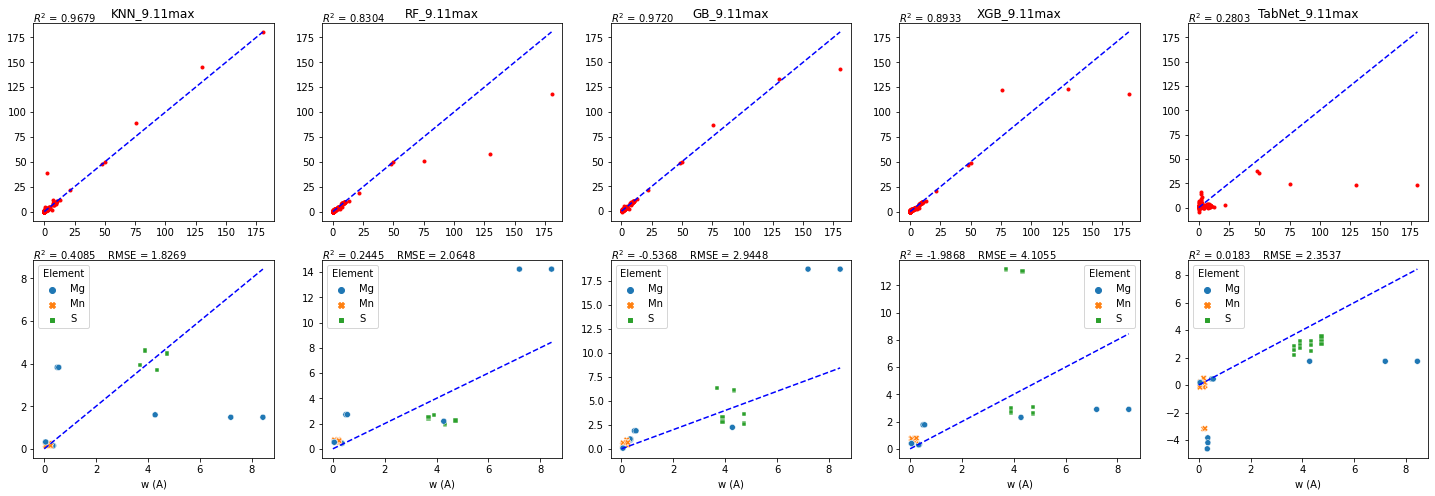

({'GB_9.11max': array([ 4.98875443e-02, -4.04534220e-02,  3.39580544e-02,  1.04646200e-01,
          8.40075158e-02,  9.14602445e-02,  1.72054201e+00,  1.24606328e-01,
          1.12551853e-01,  4.66674756e-02,  2.06368760e-01,  5.62741183e-02,
          1.08726054e-01,  3.18617748e-02,  2.49500080e-02,  4.20938034e-02,
          1.41080546e+00,  2.84463698e-02,  3.04080993e-02,  1.06366340e-01,
          8.67201682e-02,  8.92354257e-02,  9.53951798e-02,  4.42602662e-02,
          1.11241312e-01,  3.37508842e-01,  1.50676904e-02,  2.68866243e-02,
          9.88397027e-02,  1.50239216e+00,  9.30696849e-02,  1.19866252e-01,
          1.03057021e-01,  1.24690639e-01,  1.22629387e-02,  1.19866252e-01,
          8.87521945e-02,  3.08872612e-02,  3.35552125e-01,  5.57033782e-01,
          3.03397632e-01,  5.75223781e-01,  4.06362637e-01,  1.50005273e+00,
          3.10429236e-01,  1.45603716e+00,  5.84164862e-01,  1.48571566e+00,
          6.72487583e-01,  1.34618770e+00,  4.97570839e-01,  1

In [35]:
models = ['KNN_9.11max', 'RF_9.11max', 'GB_9.11max', 'XGB_9.11max', 'TabNet_9.11max']

models_d = create_models_dict(models)

plot_model_prediction(models_d, XW_train, YW_train, XW_test, YW_test, XW_elem, YW_elem, LW_elem)

## Shift

In [37]:
print(XS_train.shape, XS_test.shape, XS_elem.shape)
print(XW_train.shape, XW_test.shape, XW_elem.shape)
#print(XS_elem)

(275, 50) (58, 50) (20, 50)
(743, 50) (154, 50) (34, 50)


In [23]:
print(YS_elem)

2      0.350000
3      0.353000
4      0.330000
587    4.342105
588    3.687708
589    4.342105
590    3.687708
591    4.342105
592    3.687708
593    4.736842
594    3.903226
595    4.736842
596    3.903226
597    4.736842
598    3.903226
730    4.280000
731    8.440000
732    7.200000
733    0.500000
734    0.560000
Name: w (A), dtype: float64


Getting KNN_SHIFT predictions
Getting GB_SHIFT predictions
Getting XGB_SHIFT predictions
[10:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Getting TabNet_SHIFT predictions

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 21.197
Best weights from best epoch are automatically used!
Plotting KNN_SHIFT predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Plotting GB_SHIFT predictions
Plotting XGB_SHIFT predictions
Plotting TabNet_SHIFT predictions


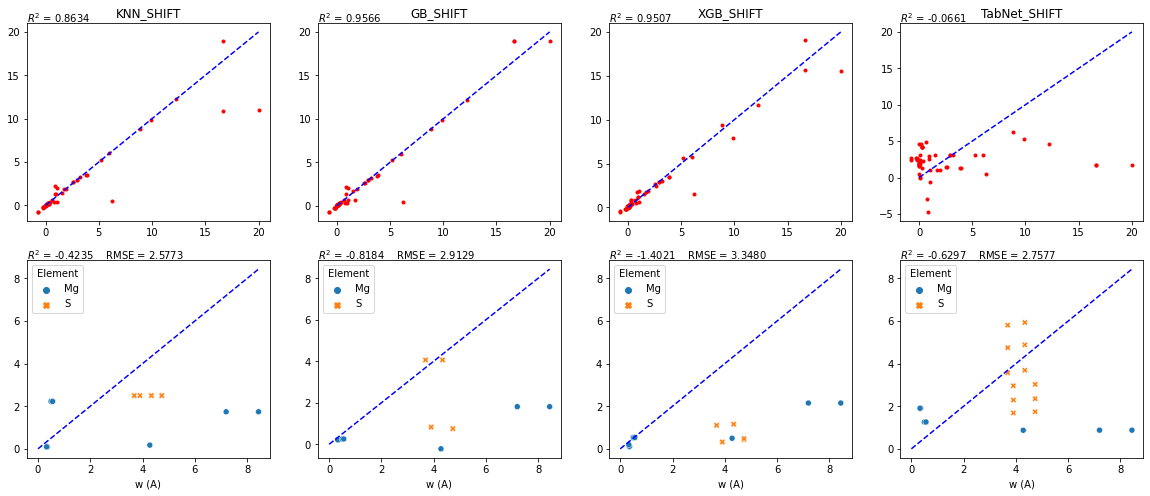

({'GB_SHIFT': array([-2.59310346e-01,  3.91666204e-02, -2.35672990e-01, -6.65330643e-01,
         -1.97868738e-01,  4.12027283e-02, -2.35810597e-01,  4.26402963e-02,
         -1.06844387e-02,  8.81676419e-02, -1.97868738e-01, -2.03051373e-02,
         -6.65468250e-01,  4.33106305e-02,  4.26402963e-02,  1.07328810e-01,
          1.59113465e-01,  1.59903665e-01,  4.36632002e-02,  3.01826828e-01,
          6.55451760e-02,  1.05224689e-01,  1.05224689e-01,  9.98871562e-02,
          4.01470207e-02,  1.94114458e-01,  1.46755968e-01,  2.47311336e-01,
          3.01826828e-01,  6.23425829e-01,  6.45440574e-01,  3.34044165e-01,
          1.92704852e+00,  2.02773660e+00,  2.88451743e-01,  1.32040544e+00,
          3.70799218e-01,  2.15029230e+00,  6.55432110e-01,  2.67965532e+00,
          4.32047723e-01,  2.67965532e+00,  1.70248872e+00,  3.01826828e-01,
          1.89490980e+01,  3.54710071e+00,  5.21354720e+00,  5.98792639e+00,
          1.89490980e+01,  3.21656767e+00,  4.51844911e-01,  2.9

In [22]:
models = ['KNN_SHIFT', 'GB_SHIFT', 'XGB_SHIFT', 'TabNet_SHIFT']

models_d = create_models_dict(models)

plot_model_prediction(models_d, XS_train, YS_train, XS_test, YS_test, XS_elem, YS_elem, LS_elem)

## Comparing old (handmade/handtuned) and auto new TabNet

In [ ]:
models = ['TabNet', 'TabNet_handmade']
models_d = create_models_dict(models)

results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(results)



models = ['TabNet', 'TabNet_handmade']
models_d = create_models_dict(models)

pr, elem, fig, ax = plot_model_prediction(models_d, XW_train, YW_train, XW_test, YW_test, XW_elem, YW_elem, LW_elem)

KeyError: ignored

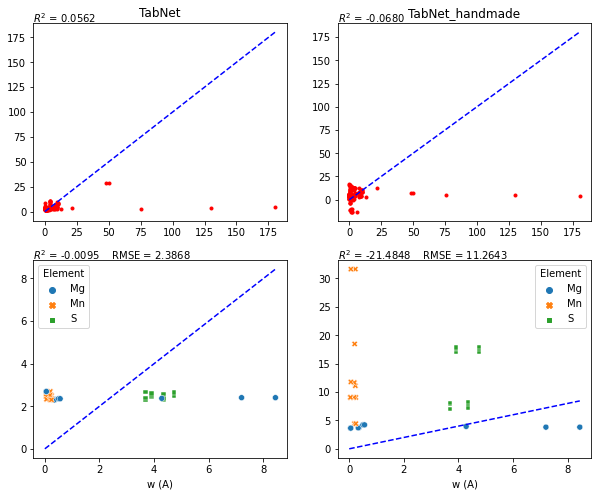

In [ ]:
#ax[0, 0].set_xlim(0, 15)
#ax[0, 0].set_ylim(0, 15)
#ax[0, 1].set_xlim(0, 15)
#ax[0, 1].set_ylim(0, 15)
fig

# Debugging

In [ ]:
target_width.quantile(0.9)

9.113725490196074

In [ ]:
LW_elem

,Element,Wavelength
2,Mg,518.36043
3,Mg,517.26844
4,Mg,516.73213
5,Mn,403.07530
6,Mn,403.30620
7,Mn,403.44830
8,Mn,279.48170
9,Mn,279.82690
10,Mn,280.10810
11,Mn,404.13550


Fitting KNN
Fitting RF
Fitting GB
Fitting XGB
[15:19:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting TabNet

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 359.33225
Best weights from best epoch are automatically used!
Calculating bootstrap score for KNN
Calculating bootstrap score for RF
Calculating bootstrap score for GB
Calculating bootstrap score for XGB
Calculating bootstrap score for TabNet


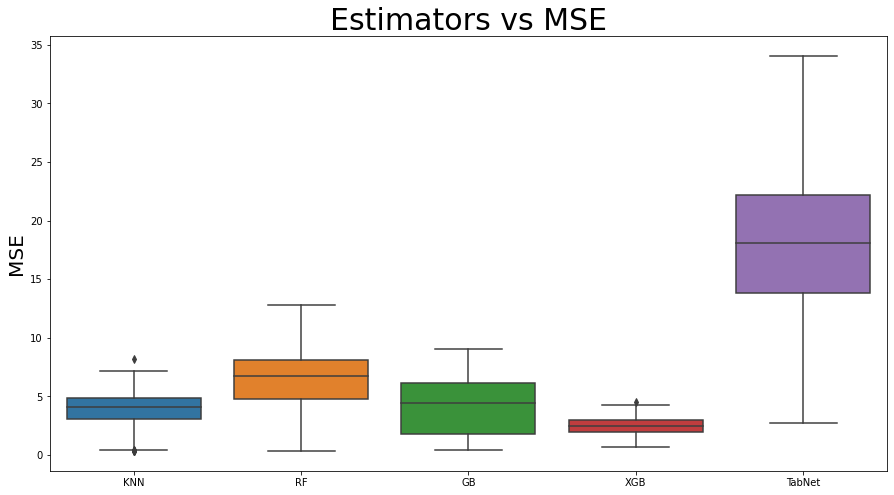

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

tuned_results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(tuned_results)

[16:19:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 7.652456533356582
GB model 11.978170490764201
[16:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 85.67093351905685
GB model 67.74644926737481
[16:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.871245347868278
GB model 48.14135844210374
[16:19:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 2.3040662820980895
GB model 2.5558378882546395
[16:19:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.6383731338990246
GB model 2.1933960069613687

 XGB score 19.827414963255766
GB score 26.52304241909175
{'GB': Gradi

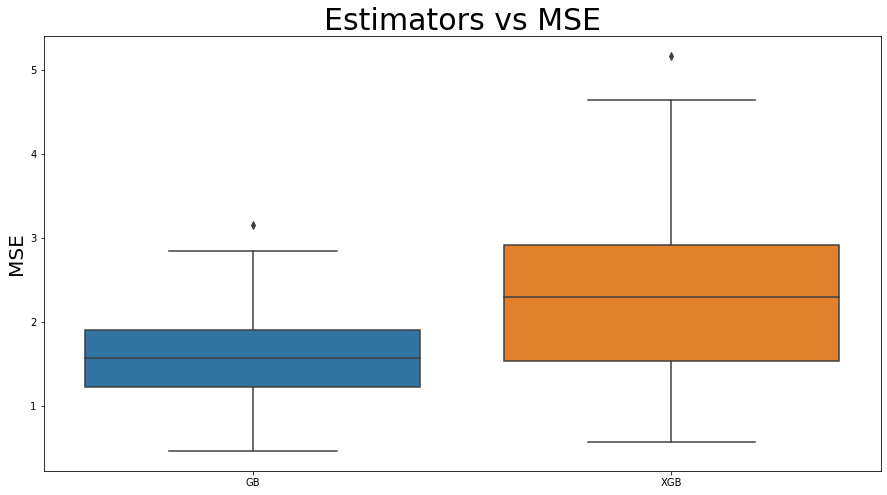

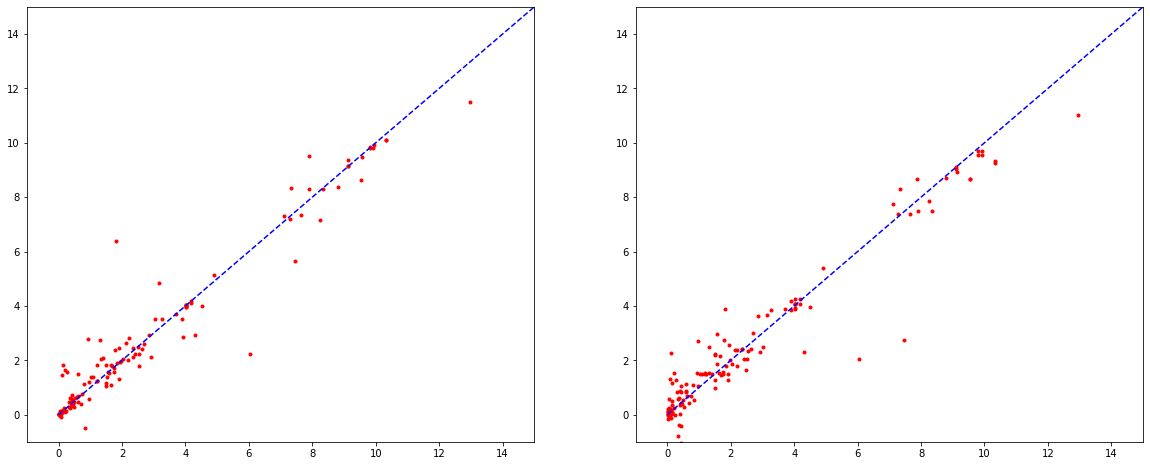

GB MSE: 2.699773000606855
XGB MSE: 5.888925800005179


In [ ]:
nfolds = 5
#kf = KFold(nfolds, shuffle = True, random_state=7)
kf = KFold(nfolds, shuffle = False)
score_XGB = 0
score_GB = 0

with open(path + f'/GB' + '_optimal_parameters', 'r') as fp:
    GB_params = json.load(fp)
with open(path + f'/XGB' + '_optimal_parameters', 'r') as fp:
    XGB_params = json.load(fp)

for train, test in kf.split(XW_train):
    #print(XW_train.iloc[test, :])
    #print(YW_train.iloc[test])
    #break

    model_XGB = xgboost.XGBRegressor(**XGB_params, n_estimators = 500, n_jobs = -1)
    model_GB = GradientBoostingRegressor(**GB_params, n_estimators = 500)
    
    model_XGB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    model_GB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    
    score_XGB += mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True)
    score_GB += mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True)
    print('\n', 'XGB model:', mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True))
    print('GB model', mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True))
score_XGB /= nfolds
score_GB /= nfolds

print(f"\n XGB score {score_XGB}")
print(f"GB score {score_GB}")

models = {
    'GB' : model_GB,
    'XGB' : model_XGB
}
print(models)
rrr = train_and_test_regressor(models,
                               XW_train,
                               YW_train,
                               XW_test.sample(frac = 1, random_state = 777),
                               YW_test.sample(frac = 1, random_state = 777))
plot_model_comparison(rrr)

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 15)
    i.set_ylim(-1, 15)
plt.show()


print(f'GB MSE: {mean_squared_error(YW_test, model_GB.predict(XW_test))}')
print(f'XGB MSE: {mean_squared_error(YW_test, model_XGB.predict(XW_test))}')


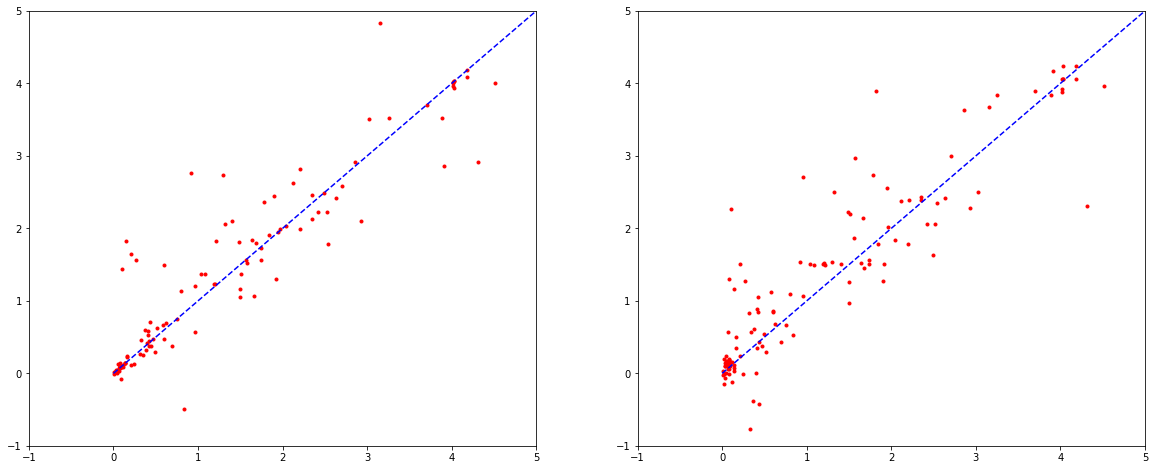

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 5)
    i.set_ylim(-1, 5)
plt.show()

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

In [ ]:
print(models_d.items())

TypeError: ignored

In [ ]:
abc = np.array([2, 3, 4])
abc = abc.flatten()
abc.shape

(3,)